Name: Subrat Kishore Dutta  
Matrikelnummer:  7028082
Email:   subratkishoredutta1234@gmail.com,sudu00001@stud.uni-saarland.de
   
Name:   Prathvish Mithare
Matrikelnummer:   7028692
Email: prmi00001@stud.uni-saarland.de

#### Preamble

In [1]:
# TODO: Import necessary libraries
import torch
import torch.nn as nn
from torchvision import transforms
from torchvision import datasets
import torch.nn.functional as F
from tqdm import tqdm
from torchmetrics import F1Score
import matplotlib.pyplot as plt

In [2]:
torch.cuda.is_available()
device = torch.device("cpu")

# 7.5 Build your own regularized NN

In this exercise you get to use your previously built networks, but this time you need to add regularization in the form of dropout and $L_2$-regularization.

Each layer has the option of using dropout. Your code needs to allow for this flexibility.

Additionally, adding $L_2$-regularization should also be optional upon creation.

**NOTE**: You are allowed to use built-in functions from pytorch to incorporate this functionality.

### 7.5.1 Implement a regularized model (1 point)

Implement your own model (using `torch`) using the skeleton code provided.

In [36]:
class Model(nn.Module):
    """
    Implement a model that incorporates dropout and L2 regularization
    depending on arguments passed.
    
    Args:
    input_dim: dimensionality of the inputs
    hidden_dim: how many units each hidden layer will have
    out_dim: how many output units
    num_layers: how many hidden layers to create/use
    dropout: a list of booleans specifying which hidden layers will have dropout
    dropout_p: the probability used for the `Dropout` layers
    l2_reg: a boolean value that indicates whether L2 regularization should be used
    """
    # TODO: Implement
    def __init__(self, input_dim: int, hidden_dim: int, out_dim: int, num_layers: int, dropout: list, dropout_p: float,
                 l2_reg: bool):
        super(Model, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.out_dim = out_dim
        self.num_layers = num_layers
        self.dropout = dropout
        self.dropout_p = dropout_p
        self.l2_reg = l2_reg
        self.fci = nn.Linear(self.input_dim, self.hidden_dim)
        self.fch = nn.Linear(self.hidden_dim, self.hidden_dim)
        self.fco = nn.Linear(self.hidden_dim,self.out_dim)
        self.softmax = nn.Softmax()
        self.m = nn.Dropout(p=self.dropout_p)
        
        
    def __call__(self,x):
        out = self.fci(x)
        out = F.relu(out)
        #print(self.out)
        for num in range(self.num_layers):
            out = self.fch(out)
            out = F.relu(out)
            if self.dropout[num]:
                out = self.m(out)
        out = self.fco(out)
        #out = self.softmax(out)
        return out
    
    def train(self,train_loader,learning_rate=0.01,epochs=5,lam=0.01):
        loss_fn = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(self.parameters(),lr=learning_rate)
        ep=[]
        lossrec=[]
        for epoch in range(epochs):
            tloss=0
            ep.append(epoch)
            for i,(xs,ys) in enumerate(train_loader):
                xs=xs.to(device)
                ys=ys.to(device)
                pred = self(xs.view(-1,28*28))
                if self.l2_reg:
                    a=torch.tensor(0.).to(device)
                    for p in self.parameters():
                        a+=torch.norm(p)
                    loss = loss_fn(pred,ys)+lam*a
                else:
                    loss = loss_fn(pred,ys) 
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                tloss+=loss
            lossrec.append((tloss/len(train_loader)).log().item())
            print('epoch:',epoch,'loss:',(tloss/len(train_loader)).item())
        
        plt.figure(figsize=(10,10))
        plt.plot(ep,lossrec,color='orange')
        plt.xlabel('epochs')
        plt.ylabel('log loss')
        return lossrec
            
    def test(self,test_loader):
        loss_fn = nn.CrossEntropyLoss()
        loss=0
        for i,(xs,ys) in enumerate(test_loader):
            xs=xs.to(device)
            ys=ys.to(device)
            pred = self(xs.view(-1,28*28))
            loss+= loss_fn(pred,ys).item()
        print(loss/len(test_loader))
        return loss/len(test_loader)
            
    

In [4]:
##function to get accuracy:
def get_accuracy(data,model):
    accdata=torch.utils.data.DataLoader(data,batch_size=len(data))
    for X,Y in accdata:
        X=X.to(device)
        Y=Y.to(device)
        ypred=model(X.view(-1,28*28))
        train_acc = torch.sum(ypred.argmax(1) == Y)
        accuracy = train_acc/len(data)
    print(accuracy.item()*100,"%")

In [5]:
def get_f1(data,model):
    accdata=torch.utils.data.DataLoader(data,batch_size=len(data))
    for X,Y in accdata:
        X=X.to(device)
        Y=Y.to(device)
        f1= F1Score(task="multiclass", num_classes=10)
        ypred=model(X.view(-1,28*28))
        f1 = f1(ypred.argmax(1),Y)
    print("F1 score:",f1.item())

### 7.5.2 Experiment with your model (1 point)

Use the MNIST dataset and evaluation code from the previous assignment to run some experiments. Run the following experiments:

1. Shallow network (not more than 1 hidden layer)
1. Shallow regularized network
1. Deep network (at least 3 hidden layers)
1. Deep regularized network

Report Accuracy and $F_1$ metrics for your experiments and discuss your results. What did you expect to see and what did you end up seeing.

**NOTE**: You can choose how you use regularization. Ideally you would experiment with various parameters for this regularization, the 4 listed variants are merely what you must cover as a minimum. Report results for all your experiments concisely in a table.

**NOTE 2**: Make sure to report your metrics on the training and evaluation/heldout sets.

In [6]:
# Load the data
# DO NOT CHANGE THE CODE IN THIS CELL EXCEPT FOR THE BATCH SIZE IF NECESSARY
transform_fn = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.7,), (0.7,)),])

mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform_fn)
train_dl = torch.utils.data.DataLoader(mnist_train, batch_size=128, shuffle=True)

mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transform_fn)
test_dl = torch.utils.data.DataLoader(mnist_test, batch_size=128, shuffle=False)

# Use the above data for your experiments

## Experiments:

### 1.Choosing the correct learning rate

We took a shallow model to test learning rates between 0.0001 and 0.01 and choose the best performing one going ahead to train our models.

Note: The spacing between the learning rates considered were based on a exponential scale and not linear

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

lr= tensor(1.0000e-04)
epoch: 0 loss: 0.7261985540390015
epoch: 1 loss: 0.33156508207321167
epoch: 2 loss: 0.2777683138847351
epoch: 3 loss: 0.24060821533203125
epoch: 4 loss: 0.2085312157869339
epoch: 5 loss: 0.1846543550491333
epoch: 6 loss: 0.1634846329689026
epoch: 7 loss: 0.1453692764043808
epoch: 8 loss: 0.13161644339561462
epoch: 9 loss: 0.11778869479894638


  1%|▊                                                                              | 1/100 [02:19<3:50:57, 139.97s/it]

lr= tensor(0.0001)
epoch: 0 loss: 0.7224470376968384
epoch: 1 loss: 0.332338809967041
epoch: 2 loss: 0.2793672978878021
epoch: 3 loss: 0.23660603165626526
epoch: 4 loss: 0.20127752423286438
epoch: 5 loss: 0.1751663237810135
epoch: 6 loss: 0.1534990519285202
epoch: 7 loss: 0.13599148392677307
epoch: 8 loss: 0.12034139782190323
epoch: 9 loss: 0.10772135853767395


  2%|█▌                                                                             | 2/100 [04:43<3:50:34, 141.17s/it]

lr= tensor(0.0001)
epoch: 0 loss: 0.7057109475135803
epoch: 1 loss: 0.3223562240600586
epoch: 2 loss: 0.2651713490486145
epoch: 3 loss: 0.22404398024082184
epoch: 4 loss: 0.19154514372348785
epoch: 5 loss: 0.16775110363960266
epoch: 6 loss: 0.1485627144575119
epoch: 7 loss: 0.13018766045570374
epoch: 8 loss: 0.11836354434490204
epoch: 9 loss: 0.10599058866500854


  3%|██▎                                                                            | 3/100 [07:08<3:49:47, 142.14s/it]

lr= tensor(0.0001)
epoch: 0 loss: 0.6853941679000854
epoch: 1 loss: 0.3219083249568939
epoch: 2 loss: 0.2664920389652252
epoch: 3 loss: 0.22069261968135834
epoch: 4 loss: 0.18791748583316803
epoch: 5 loss: 0.1627233475446701
epoch: 6 loss: 0.14276842772960663
epoch: 7 loss: 0.12680627405643463
epoch: 8 loss: 0.11305496841669083
epoch: 9 loss: 0.1032271534204483


  4%|███▏                                                                           | 4/100 [09:30<3:47:35, 142.25s/it]

lr= tensor(0.0001)
epoch: 0 loss: 0.6868946552276611
epoch: 1 loss: 0.32298338413238525
epoch: 2 loss: 0.26580435037612915
epoch: 3 loss: 0.22376565635204315
epoch: 4 loss: 0.18948769569396973
epoch: 5 loss: 0.1616862565279007
epoch: 6 loss: 0.14004001021385193
epoch: 7 loss: 0.12466531991958618
epoch: 8 loss: 0.1087288111448288
epoch: 9 loss: 0.09760579466819763


  5%|███▉                                                                           | 5/100 [11:53<3:45:36, 142.49s/it]

lr= tensor(0.0001)
epoch: 0 loss: 0.6783229112625122
epoch: 1 loss: 0.32230690121650696
epoch: 2 loss: 0.2645258605480194
epoch: 3 loss: 0.22062575817108154
epoch: 4 loss: 0.18642555177211761
epoch: 5 loss: 0.16095983982086182
epoch: 6 loss: 0.14043109118938446
epoch: 7 loss: 0.1261950135231018
epoch: 8 loss: 0.10983021557331085
epoch: 9 loss: 0.09998271614313126


  6%|████▋                                                                          | 6/100 [14:17<3:43:56, 142.94s/it]

lr= tensor(0.0001)
epoch: 0 loss: 0.656182050704956
epoch: 1 loss: 0.3156178295612335
epoch: 2 loss: 0.2568322718143463
epoch: 3 loss: 0.21271288394927979
epoch: 4 loss: 0.18055087327957153
epoch: 5 loss: 0.15583644807338715
epoch: 6 loss: 0.13611404597759247
epoch: 7 loss: 0.12050457298755646
epoch: 8 loss: 0.10846298933029175
epoch: 9 loss: 0.09664372354745865


  7%|█████▌                                                                         | 7/100 [16:41<3:41:55, 143.18s/it]

lr= tensor(0.0001)
epoch: 0 loss: 0.6500186324119568
epoch: 1 loss: 0.314216673374176
epoch: 2 loss: 0.2576373815536499
epoch: 3 loss: 0.21416307985782623
epoch: 4 loss: 0.1804126501083374
epoch: 5 loss: 0.15535730123519897
epoch: 6 loss: 0.13442175090312958
epoch: 7 loss: 0.117735855281353
epoch: 8 loss: 0.10529211163520813
epoch: 9 loss: 0.09384838491678238


  8%|██████▎                                                                        | 8/100 [19:07<3:40:34, 143.86s/it]

lr= tensor(0.0001)
epoch: 0 loss: 0.6325652599334717
epoch: 1 loss: 0.30688783526420593
epoch: 2 loss: 0.2445685863494873
epoch: 3 loss: 0.2000192403793335
epoch: 4 loss: 0.16785331070423126
epoch: 5 loss: 0.14414149522781372
epoch: 6 loss: 0.1248699203133583
epoch: 7 loss: 0.11034607142210007
epoch: 8 loss: 0.09784039109945297
epoch: 9 loss: 0.08868484944105148


  9%|███████                                                                        | 9/100 [21:30<3:37:54, 143.67s/it]

lr= tensor(0.0002)
epoch: 0 loss: 0.6290817856788635
epoch: 1 loss: 0.3021842837333679
epoch: 2 loss: 0.24357464909553528
epoch: 3 loss: 0.199567511677742
epoch: 4 loss: 0.1685882955789566
epoch: 5 loss: 0.14334803819656372
epoch: 6 loss: 0.1256176382303238
epoch: 7 loss: 0.11113671213388443
epoch: 8 loss: 0.09820336103439331
epoch: 9 loss: 0.08925638347864151


 10%|███████▊                                                                      | 10/100 [23:53<3:35:09, 143.44s/it]

lr= tensor(0.0002)
epoch: 0 loss: 0.6177305579185486
epoch: 1 loss: 0.29767322540283203
epoch: 2 loss: 0.23967091739177704
epoch: 3 loss: 0.1957257091999054
epoch: 4 loss: 0.16502083837985992
epoch: 5 loss: 0.13881359994411469
epoch: 6 loss: 0.11940499395132065
epoch: 7 loss: 0.10599629580974579
epoch: 8 loss: 0.09430999308824539
epoch: 9 loss: 0.08379556238651276


 11%|████████▌                                                                     | 11/100 [26:12<3:30:49, 142.13s/it]

lr= tensor(0.0002)
epoch: 0 loss: 0.604367196559906
epoch: 1 loss: 0.29593950510025024
epoch: 2 loss: 0.23265020549297333
epoch: 3 loss: 0.18485158681869507
epoch: 4 loss: 0.1536855250597
epoch: 5 loss: 0.12969151139259338
epoch: 6 loss: 0.11268142610788345
epoch: 7 loss: 0.09768842160701752
epoch: 8 loss: 0.0873471349477768
epoch: 9 loss: 0.07787977904081345


 12%|█████████▎                                                                    | 12/100 [28:31<3:27:12, 141.28s/it]

lr= tensor(0.0002)
epoch: 0 loss: 0.6060585975646973
epoch: 1 loss: 0.29105573892593384
epoch: 2 loss: 0.22441984713077545
epoch: 3 loss: 0.18056538701057434
epoch: 4 loss: 0.1505650281906128
epoch: 5 loss: 0.12528873980045319
epoch: 6 loss: 0.10855430364608765
epoch: 7 loss: 0.09549293667078018
epoch: 8 loss: 0.08421074599027634
epoch: 9 loss: 0.07599163055419922


 13%|██████████▏                                                                   | 13/100 [30:50<3:23:50, 140.58s/it]

lr= tensor(0.0002)
epoch: 0 loss: 0.5887457132339478
epoch: 1 loss: 0.2949238717556
epoch: 2 loss: 0.2367318868637085
epoch: 3 loss: 0.19004882872104645
epoch: 4 loss: 0.1585148721933365
epoch: 5 loss: 0.13387779891490936
epoch: 6 loss: 0.11295254528522491
epoch: 7 loss: 0.09989102929830551
epoch: 8 loss: 0.08993075788021088
epoch: 9 loss: 0.07955925911664963


 14%|██████████▉                                                                   | 14/100 [33:10<3:21:10, 140.35s/it]

lr= tensor(0.0002)
epoch: 0 loss: 0.5875495076179504
epoch: 1 loss: 0.29375508427619934
epoch: 2 loss: 0.23117299377918243
epoch: 3 loss: 0.1880754977464676
epoch: 4 loss: 0.15434257686138153
epoch: 5 loss: 0.12994758784770966
epoch: 6 loss: 0.11056748777627945
epoch: 7 loss: 0.09746280312538147
epoch: 8 loss: 0.0863819271326065
epoch: 9 loss: 0.07856883853673935


 15%|███████████▋                                                                  | 15/100 [35:29<3:18:17, 139.97s/it]

lr= tensor(0.0002)
epoch: 0 loss: 0.567135751247406
epoch: 1 loss: 0.2923163175582886
epoch: 2 loss: 0.2251392900943756
epoch: 3 loss: 0.17555692791938782
epoch: 4 loss: 0.14330323040485382
epoch: 5 loss: 0.1212715432047844
epoch: 6 loss: 0.10414595156908035
epoch: 7 loss: 0.09113294631242752
epoch: 8 loss: 0.08057903498411179
epoch: 9 loss: 0.07190869748592377


 16%|████████████▍                                                                 | 16/100 [37:49<3:15:52, 139.91s/it]

lr= tensor(0.0002)
epoch: 0 loss: 0.561768114566803
epoch: 1 loss: 0.2797674536705017
epoch: 2 loss: 0.21322838962078094
epoch: 3 loss: 0.16823774576187134
epoch: 4 loss: 0.14028199017047882
epoch: 5 loss: 0.1182067021727562
epoch: 6 loss: 0.10284663736820221
epoch: 7 loss: 0.09055177122354507
epoch: 8 loss: 0.07932789623737335
epoch: 9 loss: 0.07079105079174042


 17%|█████████████▎                                                                | 17/100 [40:09<3:13:47, 140.09s/it]

lr= tensor(0.0002)
epoch: 0 loss: 0.5573039054870605
epoch: 1 loss: 0.2784835696220398
epoch: 2 loss: 0.21194086968898773
epoch: 3 loss: 0.17037908732891083
epoch: 4 loss: 0.13924238085746765
epoch: 5 loss: 0.11866267025470734
epoch: 6 loss: 0.10270413756370544
epoch: 7 loss: 0.09094423800706863
epoch: 8 loss: 0.08073213696479797
epoch: 9 loss: 0.07190751284360886


 18%|██████████████                                                                | 18/100 [42:28<3:11:01, 139.78s/it]

lr= tensor(0.0002)
epoch: 0 loss: 0.5451319217681885
epoch: 1 loss: 0.27858951687812805
epoch: 2 loss: 0.20997431874275208
epoch: 3 loss: 0.1658809930086136
epoch: 4 loss: 0.13647237420082092
epoch: 5 loss: 0.11483310908079147
epoch: 6 loss: 0.10049933940172195
epoch: 7 loss: 0.08479543775320053
epoch: 8 loss: 0.07692347466945648
epoch: 9 loss: 0.06889866292476654


 19%|██████████████▊                                                               | 19/100 [44:48<3:08:30, 139.63s/it]

lr= tensor(0.0002)
epoch: 0 loss: 0.5444684624671936
epoch: 1 loss: 0.2778354585170746
epoch: 2 loss: 0.20979858934879303
epoch: 3 loss: 0.1636883020401001
epoch: 4 loss: 0.1330133080482483
epoch: 5 loss: 0.1115640327334404
epoch: 6 loss: 0.09684914350509644
epoch: 7 loss: 0.08454452455043793
epoch: 8 loss: 0.0762588232755661
epoch: 9 loss: 0.06935276836156845


 20%|███████████████▌                                                              | 20/100 [47:07<3:06:13, 139.67s/it]

lr= tensor(0.0003)
epoch: 0 loss: 0.5371057987213135
epoch: 1 loss: 0.2705766260623932
epoch: 2 loss: 0.19982843101024628
epoch: 3 loss: 0.15772582590579987
epoch: 4 loss: 0.12558263540267944
epoch: 5 loss: 0.10568656027317047
epoch: 6 loss: 0.09229438751935959
epoch: 7 loss: 0.08001381903886795
epoch: 8 loss: 0.07134436070919037
epoch: 9 loss: 0.06322810053825378


C:\Users\Asus\Anaconda3\lib\site-packages\ipykernel_launcher.py:73: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
 21%|████████████████▍                                                             | 21/100 [49:27<3:04:00, 139.75s/it]

lr= tensor(0.0003)
epoch: 0 loss: 0.5286252498626709
epoch: 1 loss: 0.26698267459869385
epoch: 2 loss: 0.19694238901138306
epoch: 3 loss: 0.15412305295467377
epoch: 4 loss: 0.12432299554347992
epoch: 5 loss: 0.10726451873779297
epoch: 6 loss: 0.0920996442437172
epoch: 7 loss: 0.08042531460523605
epoch: 8 loss: 0.07155734300613403
epoch: 9 loss: 0.06355201452970505


 22%|█████████████████▏                                                            | 22/100 [51:48<3:01:53, 139.92s/it]

lr= tensor(0.0003)
epoch: 0 loss: 0.5238393545150757
epoch: 1 loss: 0.2704450786113739
epoch: 2 loss: 0.19766846299171448
epoch: 3 loss: 0.15281972289085388
epoch: 4 loss: 0.12511618435382843
epoch: 5 loss: 0.10393641144037247
epoch: 6 loss: 0.09107305109500885
epoch: 7 loss: 0.0797918513417244
epoch: 8 loss: 0.06895629316568375
epoch: 9 loss: 0.06401004642248154


 23%|█████████████████▉                                                            | 23/100 [54:07<2:59:27, 139.84s/it]

lr= tensor(0.0003)
epoch: 0 loss: 0.5252256989479065
epoch: 1 loss: 0.26475876569747925
epoch: 2 loss: 0.19193962216377258
epoch: 3 loss: 0.1487886905670166
epoch: 4 loss: 0.12123287469148636
epoch: 5 loss: 0.10470391809940338
epoch: 6 loss: 0.08847009390592575
epoch: 7 loss: 0.07847151160240173
epoch: 8 loss: 0.07086294144392014
epoch: 9 loss: 0.06210106983780861


 24%|██████████████████▋                                                           | 24/100 [56:28<2:57:23, 140.04s/it]

lr= tensor(0.0003)
epoch: 0 loss: 0.520584762096405
epoch: 1 loss: 0.26094964146614075
epoch: 2 loss: 0.18488265573978424
epoch: 3 loss: 0.1422344446182251
epoch: 4 loss: 0.1155698299407959
epoch: 5 loss: 0.09600885212421417
epoch: 6 loss: 0.08647509664297104
epoch: 7 loss: 0.07557862997055054
epoch: 8 loss: 0.065305195748806
epoch: 9 loss: 0.06292891502380371


 25%|███████████████████▌                                                          | 25/100 [58:48<2:55:04, 140.05s/it]

lr= tensor(0.0003)
epoch: 0 loss: 0.5114021301269531
epoch: 1 loss: 0.2571365237236023
epoch: 2 loss: 0.19227397441864014
epoch: 3 loss: 0.14538486301898956
epoch: 4 loss: 0.12123560160398483
epoch: 5 loss: 0.10217801481485367
epoch: 6 loss: 0.08754465728998184
epoch: 7 loss: 0.07648628950119019
epoch: 8 loss: 0.06929805129766464
epoch: 9 loss: 0.06183969974517822


 26%|███████████████████▊                                                        | 26/100 [1:01:10<2:53:21, 140.56s/it]

lr= tensor(0.0003)
epoch: 0 loss: 0.49698856472969055
epoch: 1 loss: 0.247095987200737
epoch: 2 loss: 0.17926257848739624
epoch: 3 loss: 0.14237499237060547
epoch: 4 loss: 0.11626867949962616
epoch: 5 loss: 0.09613391011953354
epoch: 6 loss: 0.08595214784145355
epoch: 7 loss: 0.07386957108974457
epoch: 8 loss: 0.06735079735517502
epoch: 9 loss: 0.06036927178502083


 27%|████████████████████▌                                                       | 27/100 [1:03:30<2:50:51, 140.44s/it]

lr= tensor(0.0004)
epoch: 0 loss: 0.506584107875824
epoch: 1 loss: 0.25280386209487915
epoch: 2 loss: 0.1800709068775177
epoch: 3 loss: 0.13927531242370605
epoch: 4 loss: 0.11408652365207672
epoch: 5 loss: 0.09736981242895126
epoch: 6 loss: 0.08494050800800323
epoch: 7 loss: 0.07321512699127197
epoch: 8 loss: 0.06339047849178314
epoch: 9 loss: 0.058498695492744446


 28%|█████████████████████▎                                                      | 28/100 [1:05:51<2:48:55, 140.77s/it]

lr= tensor(0.0004)
epoch: 0 loss: 0.49984508752822876
epoch: 1 loss: 0.2470378428697586
epoch: 2 loss: 0.17911478877067566
epoch: 3 loss: 0.1373429000377655
epoch: 4 loss: 0.11192623525857925
epoch: 5 loss: 0.09483770281076431
epoch: 6 loss: 0.08193159103393555
epoch: 7 loss: 0.0734948068857193
epoch: 8 loss: 0.06446392834186554
epoch: 9 loss: 0.058793652802705765


 29%|██████████████████████                                                      | 29/100 [1:08:12<2:46:42, 140.87s/it]

lr= tensor(0.0004)
epoch: 0 loss: 0.48911917209625244
epoch: 1 loss: 0.2369130402803421
epoch: 2 loss: 0.16983497142791748
epoch: 3 loss: 0.13267061114311218
epoch: 4 loss: 0.10939180105924606
epoch: 5 loss: 0.09294310957193375
epoch: 6 loss: 0.08044498413801193
epoch: 7 loss: 0.07131777703762054
epoch: 8 loss: 0.06654045730829239
epoch: 9 loss: 0.057224202901124954


 30%|██████████████████████▊                                                     | 30/100 [1:10:33<2:44:17, 140.82s/it]

lr= tensor(0.0004)
epoch: 0 loss: 0.48116493225097656
epoch: 1 loss: 0.23696866631507874
epoch: 2 loss: 0.1654391884803772
epoch: 3 loss: 0.1298299878835678
epoch: 4 loss: 0.10560844838619232
epoch: 5 loss: 0.09229525923728943
epoch: 6 loss: 0.07959774881601334
epoch: 7 loss: 0.06952638179063797
epoch: 8 loss: 0.06267841905355453
epoch: 9 loss: 0.058431193232536316


 31%|███████████████████████▌                                                    | 31/100 [1:12:54<2:41:55, 140.80s/it]

lr= tensor(0.0004)
epoch: 0 loss: 0.47001928091049194
epoch: 1 loss: 0.23349542915821075
epoch: 2 loss: 0.16091613471508026
epoch: 3 loss: 0.12402013689279556
epoch: 4 loss: 0.10365355759859085
epoch: 5 loss: 0.09149119257926941
epoch: 6 loss: 0.07511966675519943
epoch: 7 loss: 0.06777305155992508
epoch: 8 loss: 0.06143784523010254
epoch: 9 loss: 0.05502421781420708


 32%|████████████████████████▎                                                   | 32/100 [1:15:16<2:40:03, 141.23s/it]

lr= tensor(0.0004)
epoch: 0 loss: 0.47739604115486145
epoch: 1 loss: 0.22380952537059784
epoch: 2 loss: 0.16091637313365936
epoch: 3 loss: 0.12660369277000427
epoch: 4 loss: 0.1024823784828186
epoch: 5 loss: 0.09010352939367294
epoch: 6 loss: 0.07845331728458405
epoch: 7 loss: 0.06948645412921906
epoch: 8 loss: 0.06143566593527794
epoch: 9 loss: 0.05645616352558136


 33%|█████████████████████████                                                   | 33/100 [1:17:37<2:37:42, 141.23s/it]

lr= tensor(0.0005)
epoch: 0 loss: 0.46965837478637695
epoch: 1 loss: 0.22103160619735718
epoch: 2 loss: 0.1546393781900406
epoch: 3 loss: 0.12195134162902832
epoch: 4 loss: 0.09942863881587982
epoch: 5 loss: 0.08729064464569092
epoch: 6 loss: 0.07677330076694489
epoch: 7 loss: 0.06960240751504898
epoch: 8 loss: 0.05939146876335144
epoch: 9 loss: 0.054884061217308044


 34%|█████████████████████████▊                                                  | 34/100 [1:20:00<2:35:41, 141.54s/it]

lr= tensor(0.0005)
epoch: 0 loss: 0.46140509843826294
epoch: 1 loss: 0.21934929490089417
epoch: 2 loss: 0.15348348021507263
epoch: 3 loss: 0.12200403958559036
epoch: 4 loss: 0.10407392680644989
epoch: 5 loss: 0.08253339678049088
epoch: 6 loss: 0.07467660307884216
epoch: 7 loss: 0.06544078886508942
epoch: 8 loss: 0.057525064796209335
epoch: 9 loss: 0.052796535193920135


 35%|██████████████████████████▌                                                 | 35/100 [1:22:20<2:33:04, 141.29s/it]

lr= tensor(0.0005)
epoch: 0 loss: 0.457096666097641
epoch: 1 loss: 0.21331143379211426
epoch: 2 loss: 0.15357285737991333
epoch: 3 loss: 0.11965110152959824
epoch: 4 loss: 0.100208580493927
epoch: 5 loss: 0.08697035908699036
epoch: 6 loss: 0.07288192957639694
epoch: 7 loss: 0.06298660486936569
epoch: 8 loss: 0.058952026069164276
epoch: 9 loss: 0.05632425472140312


 36%|███████████████████████████▎                                                | 36/100 [1:24:42<2:30:42, 141.30s/it]

lr= tensor(0.0005)
epoch: 0 loss: 0.46000710129737854
epoch: 1 loss: 0.21795697510242462
epoch: 2 loss: 0.1526496857404709
epoch: 3 loss: 0.11860810220241547
epoch: 4 loss: 0.09867435693740845
epoch: 5 loss: 0.08610234409570694
epoch: 6 loss: 0.07549899816513062
epoch: 7 loss: 0.06730832159519196
epoch: 8 loss: 0.05872076377272606
epoch: 9 loss: 0.0566641166806221


 37%|████████████████████████████                                                | 37/100 [1:27:03<2:28:33, 141.49s/it]

lr= tensor(0.0006)
epoch: 0 loss: 0.4499307870864868
epoch: 1 loss: 0.20513348281383514
epoch: 2 loss: 0.14330434799194336
epoch: 3 loss: 0.11231592297554016
epoch: 4 loss: 0.09606664627790451
epoch: 5 loss: 0.0828184261918068
epoch: 6 loss: 0.07473123073577881
epoch: 7 loss: 0.06626620888710022
epoch: 8 loss: 0.058535847812891006
epoch: 9 loss: 0.05216963589191437


 38%|████████████████████████████▉                                               | 38/100 [1:29:25<2:26:14, 141.53s/it]

lr= tensor(0.0006)
epoch: 0 loss: 0.4418467581272125
epoch: 1 loss: 0.20929133892059326
epoch: 2 loss: 0.148948535323143
epoch: 3 loss: 0.11383982002735138
epoch: 4 loss: 0.09734831005334854
epoch: 5 loss: 0.0864068865776062
epoch: 6 loss: 0.07588419318199158
epoch: 7 loss: 0.06554024666547775
epoch: 8 loss: 0.05941414088010788
epoch: 9 loss: 0.052398763597011566


 39%|█████████████████████████████▋                                              | 39/100 [1:31:47<2:23:58, 141.61s/it]

lr= tensor(0.0006)
epoch: 0 loss: 0.42645204067230225
epoch: 1 loss: 0.20177674293518066
epoch: 2 loss: 0.14023275673389435
epoch: 3 loss: 0.1115410327911377
epoch: 4 loss: 0.09536414593458176
epoch: 5 loss: 0.08076239377260208
epoch: 6 loss: 0.07238277792930603
epoch: 7 loss: 0.06494547426700592
epoch: 8 loss: 0.05585833266377449
epoch: 9 loss: 0.05191616341471672


 40%|██████████████████████████████▍                                             | 40/100 [1:34:08<2:21:33, 141.56s/it]

lr= tensor(0.0006)
epoch: 0 loss: 0.4367482662200928
epoch: 1 loss: 0.19765271246433258
epoch: 2 loss: 0.14296916127204895
epoch: 3 loss: 0.11342863738536835
epoch: 4 loss: 0.0956716537475586
epoch: 5 loss: 0.0848650187253952
epoch: 6 loss: 0.07449635118246078
epoch: 7 loss: 0.0638800710439682
epoch: 8 loss: 0.05806315317749977
epoch: 9 loss: 0.05505738407373428


 41%|███████████████████████████████▏                                            | 41/100 [1:36:30<2:19:07, 141.49s/it]

lr= tensor(0.0007)
epoch: 0 loss: 0.43015575408935547
epoch: 1 loss: 0.20464615523815155
epoch: 2 loss: 0.13871289789676666
epoch: 3 loss: 0.11301407217979431
epoch: 4 loss: 0.0927056074142456
epoch: 5 loss: 0.07942025363445282
epoch: 6 loss: 0.07150012999773026
epoch: 7 loss: 0.06206779181957245
epoch: 8 loss: 0.06311258673667908
epoch: 9 loss: 0.05083403363823891


 42%|███████████████████████████████▉                                            | 42/100 [1:38:51<2:16:48, 141.52s/it]

lr= tensor(0.0007)
epoch: 0 loss: 0.43281033635139465
epoch: 1 loss: 0.20130115747451782
epoch: 2 loss: 0.1458284556865692
epoch: 3 loss: 0.1147921234369278
epoch: 4 loss: 0.09617770463228226
epoch: 5 loss: 0.08294851332902908
epoch: 6 loss: 0.07418971508741379
epoch: 7 loss: 0.06426597386598587
epoch: 8 loss: 0.056778933852910995
epoch: 9 loss: 0.053580109030008316


 43%|████████████████████████████████▋                                           | 43/100 [1:41:13<2:14:37, 141.72s/it]

lr= tensor(0.0007)
epoch: 0 loss: 0.4215172231197357
epoch: 1 loss: 0.19635960459709167
epoch: 2 loss: 0.13290108740329742
epoch: 3 loss: 0.11252360790967941
epoch: 4 loss: 0.09483210742473602
epoch: 5 loss: 0.08194660395383835
epoch: 6 loss: 0.07419899851083755
epoch: 7 loss: 0.0615139976143837
epoch: 8 loss: 0.057623736560344696
epoch: 9 loss: 0.05481644347310066


 44%|█████████████████████████████████▍                                          | 44/100 [1:43:36<2:12:30, 141.98s/it]

lr= tensor(0.0008)
epoch: 0 loss: 0.4273300766944885
epoch: 1 loss: 0.19555681943893433
epoch: 2 loss: 0.13725677132606506
epoch: 3 loss: 0.10968819260597229
epoch: 4 loss: 0.09341201931238174
epoch: 5 loss: 0.08114219456911087
epoch: 6 loss: 0.0711427628993988
epoch: 7 loss: 0.06417235732078552
epoch: 8 loss: 0.05988933518528938
epoch: 9 loss: 0.051449477672576904


 45%|██████████████████████████████████▏                                         | 45/100 [1:45:59<2:10:30, 142.38s/it]

lr= tensor(0.0008)
epoch: 0 loss: 0.432157963514328
epoch: 1 loss: 0.19537653028964996
epoch: 2 loss: 0.14105600118637085
epoch: 3 loss: 0.11340846121311188
epoch: 4 loss: 0.09662456810474396
epoch: 5 loss: 0.0847952738404274
epoch: 6 loss: 0.07293197512626648
epoch: 7 loss: 0.06735158711671829
epoch: 8 loss: 0.05902199074625969
epoch: 9 loss: 0.054644469171762466


 46%|██████████████████████████████████▉                                         | 46/100 [1:48:23<2:08:30, 142.79s/it]

lr= tensor(0.0008)
epoch: 0 loss: 0.41440823674201965
epoch: 1 loss: 0.192855104804039
epoch: 2 loss: 0.13509295880794525
epoch: 3 loss: 0.1119573786854744
epoch: 4 loss: 0.09380039572715759
epoch: 5 loss: 0.08472885191440582
epoch: 6 loss: 0.07423646748065948
epoch: 7 loss: 0.06573307514190674
epoch: 8 loss: 0.05847040191292763
epoch: 9 loss: 0.052651889622211456


 47%|███████████████████████████████████▋                                        | 47/100 [1:50:47<2:06:24, 143.10s/it]

lr= tensor(0.0009)
epoch: 0 loss: 0.4164014458656311
epoch: 1 loss: 0.19423416256904602
epoch: 2 loss: 0.1415751576423645
epoch: 3 loss: 0.11364713311195374
epoch: 4 loss: 0.09612254053354263
epoch: 5 loss: 0.08240561932325363
epoch: 6 loss: 0.07247453927993774
epoch: 7 loss: 0.0667620524764061
epoch: 8 loss: 0.058058805763721466
epoch: 9 loss: 0.0540168471634388


 48%|████████████████████████████████████▍                                       | 48/100 [1:53:10<2:04:05, 143.18s/it]

lr= tensor(0.0009)
epoch: 0 loss: 0.41473308205604553
epoch: 1 loss: 0.18734030425548553
epoch: 2 loss: 0.13694407045841217
epoch: 3 loss: 0.10951066762208939
epoch: 4 loss: 0.09132473170757294
epoch: 5 loss: 0.08191301673650742
epoch: 6 loss: 0.07190455496311188
epoch: 7 loss: 0.06512459367513657
epoch: 8 loss: 0.05904941260814667
epoch: 9 loss: 0.05407177656888962


 49%|█████████████████████████████████████▏                                      | 49/100 [1:55:32<2:01:20, 142.75s/it]

lr= tensor(0.0010)
epoch: 0 loss: 0.41221702098846436
epoch: 1 loss: 0.1932918280363083
epoch: 2 loss: 0.1390640288591385
epoch: 3 loss: 0.1147623285651207
epoch: 4 loss: 0.09495514631271362
epoch: 5 loss: 0.08392759412527084
epoch: 6 loss: 0.06966930627822876
epoch: 7 loss: 0.06400354206562042
epoch: 8 loss: 0.059391241520643234
epoch: 9 loss: 0.05996059998869896


 50%|██████████████████████████████████████                                      | 50/100 [1:57:56<1:59:18, 143.18s/it]

lr= tensor(0.0010)
epoch: 0 loss: 0.42219045758247375
epoch: 1 loss: 0.1908135861158371
epoch: 2 loss: 0.13875621557235718
epoch: 3 loss: 0.11341134458780289
epoch: 4 loss: 0.09303505718708038
epoch: 5 loss: 0.08559467643499374
epoch: 6 loss: 0.07062961906194687
epoch: 7 loss: 0.06365439295768738
epoch: 8 loss: 0.05900828540325165
epoch: 9 loss: 0.05546654388308525


 51%|██████████████████████████████████████▊                                     | 51/100 [2:00:20<1:57:07, 143.41s/it]

lr= tensor(0.0011)
epoch: 0 loss: 0.4055342674255371
epoch: 1 loss: 0.18582193553447723
epoch: 2 loss: 0.13490843772888184
epoch: 3 loss: 0.11220309883356094
epoch: 4 loss: 0.0942336693406105
epoch: 5 loss: 0.0814325213432312
epoch: 6 loss: 0.07602280378341675
epoch: 7 loss: 0.06504727900028229
epoch: 8 loss: 0.060483526438474655
epoch: 9 loss: 0.05366838723421097


 52%|███████████████████████████████████████▌                                    | 52/100 [2:02:44<1:54:47, 143.50s/it]

lr= tensor(0.0011)
epoch: 0 loss: 0.4097427427768707
epoch: 1 loss: 0.1846863031387329
epoch: 2 loss: 0.13217924535274506
epoch: 3 loss: 0.10986854881048203
epoch: 4 loss: 0.09195344895124435
epoch: 5 loss: 0.08393247425556183
epoch: 6 loss: 0.07504037767648697
epoch: 7 loss: 0.06571793556213379
epoch: 8 loss: 0.06112966313958168
epoch: 9 loss: 0.05462884157896042


 53%|████████████████████████████████████████▎                                   | 53/100 [2:05:08<1:52:37, 143.79s/it]

lr= tensor(0.0012)
epoch: 0 loss: 0.41600388288497925
epoch: 1 loss: 0.18481630086898804
epoch: 2 loss: 0.13258954882621765
epoch: 3 loss: 0.1148037537932396
epoch: 4 loss: 0.09592384099960327
epoch: 5 loss: 0.08214010298252106
epoch: 6 loss: 0.07591822743415833
epoch: 7 loss: 0.06686779856681824
epoch: 8 loss: 0.06390982866287231
epoch: 9 loss: 0.05876936763525009


 54%|█████████████████████████████████████████                                   | 54/100 [2:07:33<1:50:27, 144.08s/it]

lr= tensor(0.0012)
epoch: 0 loss: 0.3962237536907196
epoch: 1 loss: 0.17754358053207397
epoch: 2 loss: 0.13492605090141296
epoch: 3 loss: 0.10826163738965988
epoch: 4 loss: 0.09628261625766754
epoch: 5 loss: 0.08305493742227554
epoch: 6 loss: 0.07336166501045227
epoch: 7 loss: 0.06783940643072128
epoch: 8 loss: 0.062256619334220886
epoch: 9 loss: 0.05698869377374649


 55%|█████████████████████████████████████████▊                                  | 55/100 [2:09:58<1:48:16, 144.37s/it]

lr= tensor(0.0013)
epoch: 0 loss: 0.3978547751903534
epoch: 1 loss: 0.18021978437900543
epoch: 2 loss: 0.13704471290111542
epoch: 3 loss: 0.1094469428062439
epoch: 4 loss: 0.09760603308677673
epoch: 5 loss: 0.0853218138217926
epoch: 6 loss: 0.07716061919927597
epoch: 7 loss: 0.06437981873750687
epoch: 8 loss: 0.06244146451354027
epoch: 9 loss: 0.056182119995355606


 56%|██████████████████████████████████████████▌                                 | 56/100 [2:12:22<1:45:47, 144.27s/it]

lr= tensor(0.0014)
epoch: 0 loss: 0.3944728374481201
epoch: 1 loss: 0.1841556578874588
epoch: 2 loss: 0.13258570432662964
epoch: 3 loss: 0.1138044148683548
epoch: 4 loss: 0.09189306944608688
epoch: 5 loss: 0.08319464325904846
epoch: 6 loss: 0.07304724305868149
epoch: 7 loss: 0.06466665118932724
epoch: 8 loss: 0.05983477085828781
epoch: 9 loss: 0.05675626918673515


 57%|███████████████████████████████████████████▎                                | 57/100 [2:14:46<1:43:19, 144.18s/it]

lr= tensor(0.0014)
epoch: 0 loss: 0.3904187083244324
epoch: 1 loss: 0.17729230225086212
epoch: 2 loss: 0.13086584210395813
epoch: 3 loss: 0.11173734813928604
epoch: 4 loss: 0.09090682119131088
epoch: 5 loss: 0.08537475764751434
epoch: 6 loss: 0.07598720490932465
epoch: 7 loss: 0.0714108794927597
epoch: 8 loss: 0.0645163282752037
epoch: 9 loss: 0.05579106882214546


 58%|████████████████████████████████████████████                                | 58/100 [2:17:10<1:40:56, 144.21s/it]

lr= tensor(0.0015)
epoch: 0 loss: 0.3815295994281769
epoch: 1 loss: 0.17440706491470337
epoch: 2 loss: 0.13817916810512543
epoch: 3 loss: 0.1112525463104248
epoch: 4 loss: 0.09445124864578247
epoch: 5 loss: 0.08447789400815964
epoch: 6 loss: 0.07601884752511978
epoch: 7 loss: 0.06720193475484848
epoch: 8 loss: 0.06597216427326202
epoch: 9 loss: 0.05663828179240227


 59%|████████████████████████████████████████████▊                               | 59/100 [2:19:34<1:38:29, 144.12s/it]

lr= tensor(0.0016)
epoch: 0 loss: 0.4024064242839813
epoch: 1 loss: 0.18570184707641602
epoch: 2 loss: 0.13492895662784576
epoch: 3 loss: 0.1128382682800293
epoch: 4 loss: 0.09830933809280396
epoch: 5 loss: 0.08847241848707199
epoch: 6 loss: 0.07910788059234619
epoch: 7 loss: 0.07071206718683243
epoch: 8 loss: 0.06092919036746025
epoch: 9 loss: 0.059954285621643066


 60%|█████████████████████████████████████████████▌                              | 60/100 [2:22:01<1:36:31, 144.80s/it]

lr= tensor(0.0016)
epoch: 0 loss: 0.3815141022205353
epoch: 1 loss: 0.17742496728897095
epoch: 2 loss: 0.13960017263889313
epoch: 3 loss: 0.11003129184246063
epoch: 4 loss: 0.09691914916038513
epoch: 5 loss: 0.08403690159320831
epoch: 6 loss: 0.07418638467788696
epoch: 7 loss: 0.0692153051495552
epoch: 8 loss: 0.06488315761089325
epoch: 9 loss: 0.060813311487436295


 61%|██████████████████████████████████████████████▎                             | 61/100 [2:24:25<1:34:04, 144.73s/it]

lr= tensor(0.0017)
epoch: 0 loss: 0.40294376015663147
epoch: 1 loss: 0.189849391579628
epoch: 2 loss: 0.13721749186515808
epoch: 3 loss: 0.11503956466913223
epoch: 4 loss: 0.098717600107193
epoch: 5 loss: 0.08627067506313324
epoch: 6 loss: 0.0789191722869873
epoch: 7 loss: 0.07467525452375412
epoch: 8 loss: 0.06593376398086548
epoch: 9 loss: 0.06570792198181152


 62%|███████████████████████████████████████████████                             | 62/100 [2:26:51<1:31:54, 145.12s/it]

lr= tensor(0.0018)
epoch: 0 loss: 0.40145498514175415
epoch: 1 loss: 0.18281976878643036
epoch: 2 loss: 0.13725772500038147
epoch: 3 loss: 0.11443539708852768
epoch: 4 loss: 0.10096417367458344
epoch: 5 loss: 0.08665952831506729
epoch: 6 loss: 0.08133882284164429
epoch: 7 loss: 0.0730125904083252
epoch: 8 loss: 0.06413764506578445
epoch: 9 loss: 0.0646183043718338


 63%|███████████████████████████████████████████████▉                            | 63/100 [2:29:16<1:29:24, 144.99s/it]

lr= tensor(0.0019)
epoch: 0 loss: 0.38909196853637695
epoch: 1 loss: 0.1818697154521942
epoch: 2 loss: 0.13779449462890625
epoch: 3 loss: 0.11474283039569855
epoch: 4 loss: 0.1024407297372818
epoch: 5 loss: 0.08974040299654007
epoch: 6 loss: 0.07956065982580185
epoch: 7 loss: 0.06903248280286789
epoch: 8 loss: 0.06686833500862122
epoch: 9 loss: 0.06638167053461075


 64%|████████████████████████████████████████████████▋                           | 64/100 [2:31:47<1:28:07, 146.86s/it]

lr= tensor(0.0020)
epoch: 0 loss: 0.41650390625
epoch: 1 loss: 0.188017800450325
epoch: 2 loss: 0.13863109052181244
epoch: 3 loss: 0.11238576471805573
epoch: 4 loss: 0.0982704758644104
epoch: 5 loss: 0.09087037295103073
epoch: 6 loss: 0.08349785208702087
epoch: 7 loss: 0.07421629875898361
epoch: 8 loss: 0.07302440702915192
epoch: 9 loss: 0.06761424988508224


 65%|█████████████████████████████████████████████████▍                          | 65/100 [2:34:24<1:27:26, 149.91s/it]

lr= tensor(0.0021)
epoch: 0 loss: 0.3974899351596832
epoch: 1 loss: 0.18621891736984253
epoch: 2 loss: 0.14654089510440826
epoch: 3 loss: 0.117502361536026
epoch: 4 loss: 0.10143988579511642
epoch: 5 loss: 0.09108121693134308
epoch: 6 loss: 0.08377188444137573
epoch: 7 loss: 0.07415560632944107
epoch: 8 loss: 0.06614963710308075
epoch: 9 loss: 0.06255479902029037


 66%|██████████████████████████████████████████████████▏                         | 66/100 [2:36:51<1:24:21, 148.86s/it]

lr= tensor(0.0022)
epoch: 0 loss: 0.39639949798583984
epoch: 1 loss: 0.17961427569389343
epoch: 2 loss: 0.1416652351617813
epoch: 3 loss: 0.11951746046543121
epoch: 4 loss: 0.101750947535038
epoch: 5 loss: 0.0942436009645462
epoch: 6 loss: 0.08417273312807083
epoch: 7 loss: 0.08029550313949585
epoch: 8 loss: 0.07641288638114929
epoch: 9 loss: 0.06323005259037018


 67%|██████████████████████████████████████████████████▉                         | 67/100 [2:39:17<1:21:30, 148.19s/it]

lr= tensor(0.0023)
epoch: 0 loss: 0.403999000787735
epoch: 1 loss: 0.18404705822467804
epoch: 2 loss: 0.14152435958385468
epoch: 3 loss: 0.12071595340967178
epoch: 4 loss: 0.10489001870155334
epoch: 5 loss: 0.0955234095454216
epoch: 6 loss: 0.08815079927444458
epoch: 7 loss: 0.07486038655042648
epoch: 8 loss: 0.07717303931713104
epoch: 9 loss: 0.0686306431889534


 68%|███████████████████████████████████████████████████▋                        | 68/100 [2:41:45<1:18:59, 148.10s/it]

lr= tensor(0.0024)
epoch: 0 loss: 0.4011552333831787
epoch: 1 loss: 0.19160205125808716
epoch: 2 loss: 0.13977809250354767
epoch: 3 loss: 0.1225685253739357
epoch: 4 loss: 0.10902336239814758
epoch: 5 loss: 0.09332622587680817
epoch: 6 loss: 0.08889315277338028
epoch: 7 loss: 0.0786711573600769
epoch: 8 loss: 0.08064637333154678
epoch: 9 loss: 0.07520295679569244


 69%|████████████████████████████████████████████████████▍                       | 69/100 [2:44:12<1:16:23, 147.84s/it]

lr= tensor(0.0025)
epoch: 0 loss: 0.38882964849472046
epoch: 1 loss: 0.18426641821861267
epoch: 2 loss: 0.13768522441387177
epoch: 3 loss: 0.11745192855596542
epoch: 4 loss: 0.09974787384271622
epoch: 5 loss: 0.09338570386171341
epoch: 6 loss: 0.09050709009170532
epoch: 7 loss: 0.08105221390724182
epoch: 8 loss: 0.07500388473272324
epoch: 9 loss: 0.07406995445489883


 70%|█████████████████████████████████████████████████████▏                      | 70/100 [2:46:40<1:13:53, 147.79s/it]

lr= tensor(0.0026)
epoch: 0 loss: 0.4140000343322754
epoch: 1 loss: 0.18473681807518005
epoch: 2 loss: 0.14788220822811127
epoch: 3 loss: 0.12663844227790833
epoch: 4 loss: 0.10891548544168472
epoch: 5 loss: 0.10186492651700974
epoch: 6 loss: 0.09099794179201126
epoch: 7 loss: 0.08521157503128052
epoch: 8 loss: 0.08679454028606415
epoch: 9 loss: 0.0765494629740715


 71%|█████████████████████████████████████████████████████▉                      | 71/100 [2:49:08<1:11:29, 147.90s/it]

lr= tensor(0.0027)
epoch: 0 loss: 0.40030139684677124
epoch: 1 loss: 0.18854840099811554
epoch: 2 loss: 0.14564378559589386
epoch: 3 loss: 0.12230689823627472
epoch: 4 loss: 0.11612194776535034
epoch: 5 loss: 0.10194455087184906
epoch: 6 loss: 0.09562493115663528
epoch: 7 loss: 0.08829468488693237
epoch: 8 loss: 0.08324550837278366
epoch: 9 loss: 0.07534392923116684


 72%|██████████████████████████████████████████████████████▋                     | 72/100 [2:51:36<1:09:02, 147.93s/it]

lr= tensor(0.0028)
epoch: 0 loss: 0.4106833338737488
epoch: 1 loss: 0.1880567967891693
epoch: 2 loss: 0.1518685221672058
epoch: 3 loss: 0.1228983923792839
epoch: 4 loss: 0.11068698018789291
epoch: 5 loss: 0.1043250560760498
epoch: 6 loss: 0.09434650838375092
epoch: 7 loss: 0.09200964123010635
epoch: 8 loss: 0.08173870295286179
epoch: 9 loss: 0.080609530210495


 73%|███████████████████████████████████████████████████████▍                    | 73/100 [2:54:04<1:06:35, 148.00s/it]

lr= tensor(0.0030)
epoch: 0 loss: 0.41041478514671326
epoch: 1 loss: 0.19565412402153015
epoch: 2 loss: 0.15132391452789307
epoch: 3 loss: 0.12847071886062622
epoch: 4 loss: 0.11568716168403625
epoch: 5 loss: 0.10216870158910751
epoch: 6 loss: 0.0981244146823883
epoch: 7 loss: 0.08993788063526154
epoch: 8 loss: 0.0927317664027214
epoch: 9 loss: 0.07945451885461807


 74%|████████████████████████████████████████████████████████▏                   | 74/100 [2:56:35<1:04:30, 148.85s/it]

lr= tensor(0.0031)
epoch: 0 loss: 0.40862196683883667
epoch: 1 loss: 0.19153983891010284
epoch: 2 loss: 0.14843791723251343
epoch: 3 loss: 0.12760478258132935
epoch: 4 loss: 0.11168023943901062
epoch: 5 loss: 0.10914666205644608
epoch: 6 loss: 0.09826495498418808
epoch: 7 loss: 0.09732278436422348
epoch: 8 loss: 0.0886375904083252
epoch: 9 loss: 0.08693396300077438


 75%|█████████████████████████████████████████████████████████                   | 75/100 [2:59:04<1:01:59, 148.77s/it]

lr= tensor(0.0033)
epoch: 0 loss: 0.41584068536758423
epoch: 1 loss: 0.19173084199428558
epoch: 2 loss: 0.15621520578861237
epoch: 3 loss: 0.12626643478870392
epoch: 4 loss: 0.11490734666585922
epoch: 5 loss: 0.10058197379112244
epoch: 6 loss: 0.1015583798289299
epoch: 7 loss: 0.09810306131839752
epoch: 8 loss: 0.08627548813819885
epoch: 9 loss: 0.08493632823228836


 76%|███████████████████████████████████████████████████████████▎                  | 76/100 [3:01:33<59:30, 148.78s/it]

lr= tensor(0.0034)
epoch: 0 loss: 0.41816017031669617
epoch: 1 loss: 0.19614149630069733
epoch: 2 loss: 0.1517554074525833
epoch: 3 loss: 0.13887478411197662
epoch: 4 loss: 0.11584311723709106
epoch: 5 loss: 0.11244221776723862
epoch: 6 loss: 0.10318111628293991
epoch: 7 loss: 0.0987151563167572
epoch: 8 loss: 0.09412963688373566
epoch: 9 loss: 0.08679751306772232


 77%|████████████████████████████████████████████████████████████                  | 77/100 [3:04:03<57:09, 149.12s/it]

lr= tensor(0.0036)
epoch: 0 loss: 0.40476712584495544
epoch: 1 loss: 0.19993659853935242
epoch: 2 loss: 0.15171752870082855
epoch: 3 loss: 0.13631963729858398
epoch: 4 loss: 0.11752096563577652
epoch: 5 loss: 0.11162413656711578
epoch: 6 loss: 0.10969766974449158
epoch: 7 loss: 0.09974560886621475
epoch: 8 loss: 0.09174560010433197
epoch: 9 loss: 0.09368985146284103


 78%|████████████████████████████████████████████████████████████▊                 | 78/100 [3:06:31<54:36, 148.95s/it]

lr= tensor(0.0038)
epoch: 0 loss: 0.4415304660797119
epoch: 1 loss: 0.19811390340328217
epoch: 2 loss: 0.16177068650722504
epoch: 3 loss: 0.13969582319259644
epoch: 4 loss: 0.1256152093410492
epoch: 5 loss: 0.11588387936353683
epoch: 6 loss: 0.1115097925066948
epoch: 7 loss: 0.09980051964521408
epoch: 8 loss: 0.09755315631628036
epoch: 9 loss: 0.09564737975597382


 79%|█████████████████████████████████████████████████████████████▌                | 79/100 [3:09:00<52:11, 149.10s/it]

lr= tensor(0.0039)
epoch: 0 loss: 0.4141252934932709
epoch: 1 loss: 0.20065419375896454
epoch: 2 loss: 0.16038188338279724
epoch: 3 loss: 0.1396525353193283
epoch: 4 loss: 0.12445145845413208
epoch: 5 loss: 0.1178538054227829
epoch: 6 loss: 0.10974785685539246
epoch: 7 loss: 0.1122516319155693
epoch: 8 loss: 0.10238409042358398
epoch: 9 loss: 0.09554827958345413


 80%|██████████████████████████████████████████████████████████████▍               | 80/100 [3:11:29<49:39, 148.97s/it]

lr= tensor(0.0041)
epoch: 0 loss: 0.43703407049179077
epoch: 1 loss: 0.20315499603748322
epoch: 2 loss: 0.16323019564151764
epoch: 3 loss: 0.14572210609912872
epoch: 4 loss: 0.12648174166679382
epoch: 5 loss: 0.12470553070306778
epoch: 6 loss: 0.12351755797863007
epoch: 7 loss: 0.11169325560331345
epoch: 8 loss: 0.10486827045679092
epoch: 9 loss: 0.10470599681138992


 81%|███████████████████████████████████████████████████████████████▏              | 81/100 [3:13:59<47:16, 149.28s/it]

lr= tensor(0.0043)
epoch: 0 loss: 0.4332481622695923
epoch: 1 loss: 0.21074780821800232
epoch: 2 loss: 0.16627472639083862
epoch: 3 loss: 0.15498961508274078
epoch: 4 loss: 0.13389497995376587
epoch: 5 loss: 0.1316838264465332
epoch: 6 loss: 0.12731195986270905
epoch: 7 loss: 0.11717212945222855
epoch: 8 loss: 0.11364612728357315
epoch: 9 loss: 0.1074068620800972


 82%|███████████████████████████████████████████████████████████████▉              | 82/100 [3:16:29<44:51, 149.50s/it]

lr= tensor(0.0045)
epoch: 0 loss: 0.424059122800827
epoch: 1 loss: 0.20434238016605377
epoch: 2 loss: 0.1662958562374115
epoch: 3 loss: 0.15394160151481628
epoch: 4 loss: 0.13855582475662231
epoch: 5 loss: 0.12735573947429657
epoch: 6 loss: 0.1226588785648346
epoch: 7 loss: 0.11635427176952362
epoch: 8 loss: 0.10897736251354218
epoch: 9 loss: 0.11454027891159058


 83%|████████████████████████████████████████████████████████████████▋             | 83/100 [3:18:59<42:20, 149.45s/it]

lr= tensor(0.0048)
epoch: 0 loss: 0.44971930980682373
epoch: 1 loss: 0.2101137638092041
epoch: 2 loss: 0.17456482350826263
epoch: 3 loss: 0.15047191083431244
epoch: 4 loss: 0.13824371993541718
epoch: 5 loss: 0.129562646150589
epoch: 6 loss: 0.12775112688541412
epoch: 7 loss: 0.11654695123434067
epoch: 8 loss: 0.11685942858457565
epoch: 9 loss: 0.1079087182879448


 84%|█████████████████████████████████████████████████████████████████▌            | 84/100 [3:21:29<39:56, 149.76s/it]

lr= tensor(0.0050)
epoch: 0 loss: 0.4556933045387268
epoch: 1 loss: 0.215427964925766
epoch: 2 loss: 0.16952532529830933
epoch: 3 loss: 0.15081340074539185
epoch: 4 loss: 0.14766019582748413
epoch: 5 loss: 0.13633373379707336
epoch: 6 loss: 0.13059958815574646
epoch: 7 loss: 0.12017379701137543
epoch: 8 loss: 0.11736022680997849
epoch: 9 loss: 0.1259806901216507


 85%|██████████████████████████████████████████████████████████████████▎           | 85/100 [3:24:00<37:31, 150.11s/it]

lr= tensor(0.0052)
epoch: 0 loss: 0.45692774653434753
epoch: 1 loss: 0.20591133832931519
epoch: 2 loss: 0.18153178691864014
epoch: 3 loss: 0.1524018496274948
epoch: 4 loss: 0.14791646599769592
epoch: 5 loss: 0.13604062795639038
epoch: 6 loss: 0.1311553716659546
epoch: 7 loss: 0.130193293094635
epoch: 8 loss: 0.12457851320505142
epoch: 9 loss: 0.11660899966955185


 86%|███████████████████████████████████████████████████████████████████           | 86/100 [3:26:30<35:00, 150.01s/it]

lr= tensor(0.0055)
epoch: 0 loss: 0.450321227312088
epoch: 1 loss: 0.22180546820163727
epoch: 2 loss: 0.1763485074043274
epoch: 3 loss: 0.16558152437210083
epoch: 4 loss: 0.1538490653038025
epoch: 5 loss: 0.14717744290828705
epoch: 6 loss: 0.13540269434452057
epoch: 7 loss: 0.13681268692016602
epoch: 8 loss: 0.13693572580814362
epoch: 9 loss: 0.1283099353313446


 87%|███████████████████████████████████████████████████████████████████▊          | 87/100 [3:29:00<32:30, 150.01s/it]

lr= tensor(0.0057)
epoch: 0 loss: 0.45582684874534607
epoch: 1 loss: 0.2342303842306137
epoch: 2 loss: 0.1857338398694992
epoch: 3 loss: 0.17129439115524292
epoch: 4 loss: 0.16679637134075165
epoch: 5 loss: 0.15614357590675354
epoch: 6 loss: 0.1422128528356552
epoch: 7 loss: 0.14572478830814362
epoch: 8 loss: 0.13865219056606293
epoch: 9 loss: 0.13366404175758362


 88%|████████████████████████████████████████████████████████████████████▋         | 88/100 [3:31:30<30:00, 150.01s/it]

lr= tensor(0.0060)
epoch: 0 loss: 0.5044978857040405
epoch: 1 loss: 0.24283753335475922
epoch: 2 loss: 0.19477204978466034
epoch: 3 loss: 0.1765502244234085
epoch: 4 loss: 0.1763928234577179
epoch: 5 loss: 0.1562792807817459
epoch: 6 loss: 0.15494602918624878
epoch: 7 loss: 0.15499524772167206
epoch: 8 loss: 0.1504824161529541
epoch: 9 loss: 0.1456756442785263


 89%|█████████████████████████████████████████████████████████████████████▍        | 89/100 [3:34:01<27:32, 150.24s/it]

lr= tensor(0.0063)
epoch: 0 loss: 0.47944754362106323
epoch: 1 loss: 0.22481143474578857
epoch: 2 loss: 0.1949775516986847
epoch: 3 loss: 0.1814732849597931
epoch: 4 loss: 0.1659870743751526
epoch: 5 loss: 0.1620480865240097
epoch: 6 loss: 0.1631614863872528
epoch: 7 loss: 0.15030084550380707
epoch: 8 loss: 0.1412765383720398
epoch: 9 loss: 0.15046986937522888


 90%|██████████████████████████████████████████████████████████████████████▏       | 90/100 [3:36:31<25:03, 150.30s/it]

lr= tensor(0.0066)
epoch: 0 loss: 0.5212571620941162
epoch: 1 loss: 0.2533228099346161
epoch: 2 loss: 0.2278589904308319
epoch: 3 loss: 0.215977281332016
epoch: 4 loss: 0.20376020669937134
epoch: 5 loss: 0.18896159529685974
epoch: 6 loss: 0.1887228786945343
epoch: 7 loss: 0.18714724481105804
epoch: 8 loss: 0.18829657137393951
epoch: 9 loss: 0.1782967895269394


 91%|██████████████████████████████████████████████████████████████████████▉       | 91/100 [3:39:03<22:36, 150.69s/it]

lr= tensor(0.0069)
epoch: 0 loss: 0.48670509457588196
epoch: 1 loss: 0.2320546656847
epoch: 2 loss: 0.19693584740161896
epoch: 3 loss: 0.18266285955905914
epoch: 4 loss: 0.18204306066036224
epoch: 5 loss: 0.17838773131370544
epoch: 6 loss: 0.16535700857639313
epoch: 7 loss: 0.15791235864162445
epoch: 8 loss: 0.1674746721982956
epoch: 9 loss: 0.16025583446025848


 92%|███████████████████████████████████████████████████████████████████████▊      | 92/100 [3:41:34<20:06, 150.84s/it]

lr= tensor(0.0072)
epoch: 0 loss: 0.5431739687919617
epoch: 1 loss: 0.26754796504974365
epoch: 2 loss: 0.22937838733196259
epoch: 3 loss: 0.20739486813545227
epoch: 4 loss: 0.1907929927110672
epoch: 5 loss: 0.18887734413146973
epoch: 6 loss: 0.18333573639392853
epoch: 7 loss: 0.1740819811820984
epoch: 8 loss: 0.174551323056221
epoch: 9 loss: 0.181254580616951


 93%|████████████████████████████████████████████████████████████████████████▌     | 93/100 [3:44:06<17:38, 151.22s/it]

lr= tensor(0.0076)
epoch: 0 loss: 0.5345053672790527
epoch: 1 loss: 0.281465619802475
epoch: 2 loss: 0.238008052110672
epoch: 3 loss: 0.22089539468288422
epoch: 4 loss: 0.21688343584537506
epoch: 5 loss: 0.20764154195785522
epoch: 6 loss: 0.2077423632144928
epoch: 7 loss: 0.20297710597515106
epoch: 8 loss: 0.19248658418655396
epoch: 9 loss: 0.20327512919902802


 94%|█████████████████████████████████████████████████████████████████████████▎    | 94/100 [3:46:39<15:11, 151.92s/it]

lr= tensor(0.0079)
epoch: 0 loss: 1.2691071033477783
epoch: 1 loss: 1.000794529914856
epoch: 2 loss: 0.9830292463302612
epoch: 3 loss: 0.9650202393531799
epoch: 4 loss: 0.9598974585533142
epoch: 5 loss: 0.9204556345939636
epoch: 6 loss: 0.9057744741439819
epoch: 7 loss: 0.8982717394828796
epoch: 8 loss: 0.8913766741752625
epoch: 9 loss: 0.8891043066978455


 95%|██████████████████████████████████████████████████████████████████████████    | 95/100 [3:49:18<12:49, 153.87s/it]

lr= tensor(0.0083)
epoch: 0 loss: 0.538139283657074
epoch: 1 loss: 0.2913464903831482
epoch: 2 loss: 0.2622084617614746
epoch: 3 loss: 0.2370252162218094
epoch: 4 loss: 0.22490552067756653
epoch: 5 loss: 0.21938413381576538
epoch: 6 loss: 0.22505256533622742
epoch: 7 loss: 0.21188677847385406
epoch: 8 loss: 0.20747274160385132
epoch: 9 loss: 0.20691463351249695


 96%|██████████████████████████████████████████████████████████████████████████▉   | 96/100 [3:51:54<10:17, 154.42s/it]

lr= tensor(0.0087)
epoch: 0 loss: 0.6167418360710144
epoch: 1 loss: 0.35346171259880066
epoch: 2 loss: 0.3180233836174011
epoch: 3 loss: 0.3052132725715637
epoch: 4 loss: 0.2877047061920166
epoch: 5 loss: 0.29006341099739075
epoch: 6 loss: 0.2700932025909424
epoch: 7 loss: 0.26260629296302795
epoch: 8 loss: 0.27154433727264404
epoch: 9 loss: 0.25664380192756653


 97%|███████████████████████████████████████████████████████████████████████████▋  | 97/100 [3:54:24<07:40, 153.37s/it]

lr= tensor(0.0091)
epoch: 0 loss: 0.5676494240760803
epoch: 1 loss: 0.25412964820861816
epoch: 2 loss: 0.23459500074386597
epoch: 3 loss: 0.21878160536289215
epoch: 4 loss: 0.22044038772583008
epoch: 5 loss: 0.20668664574623108
epoch: 6 loss: 0.20305095613002777
epoch: 7 loss: 0.1947251856327057
epoch: 8 loss: 0.1917610913515091
epoch: 9 loss: 0.18778494000434875


 98%|████████████████████████████████████████████████████████████████████████████▍ | 98/100 [3:56:55<05:05, 152.61s/it]

lr= tensor(0.0095)
epoch: 0 loss: 0.5623106956481934
epoch: 1 loss: 0.27150216698646545
epoch: 2 loss: 0.2605852782726288
epoch: 3 loss: 0.23845824599266052
epoch: 4 loss: 0.22479884326457977
epoch: 5 loss: 0.21791593730449677
epoch: 6 loss: 0.21649383008480072
epoch: 7 loss: 0.2121918648481369
epoch: 8 loss: 0.20652027428150177
epoch: 9 loss: 0.2087748944759369


 99%|█████████████████████████████████████████████████████████████████████████████▏| 99/100 [3:59:26<02:32, 152.02s/it]

lr= tensor(0.0100)
epoch: 0 loss: 0.6657031774520874
epoch: 1 loss: 0.31354790925979614
epoch: 2 loss: 0.29789072275161743
epoch: 3 loss: 0.2706852853298187
epoch: 4 loss: 0.27046844363212585
epoch: 5 loss: 0.25771984457969666
epoch: 6 loss: 0.25950151681900024
epoch: 7 loss: 0.25977441668510437
epoch: 8 loss: 0.26075392961502075
epoch: 9 loss: 0.24655741453170776


100%|█████████████████████████████████████████████████████████████████████████████| 100/100 [4:01:57<00:00, 145.18s/it]


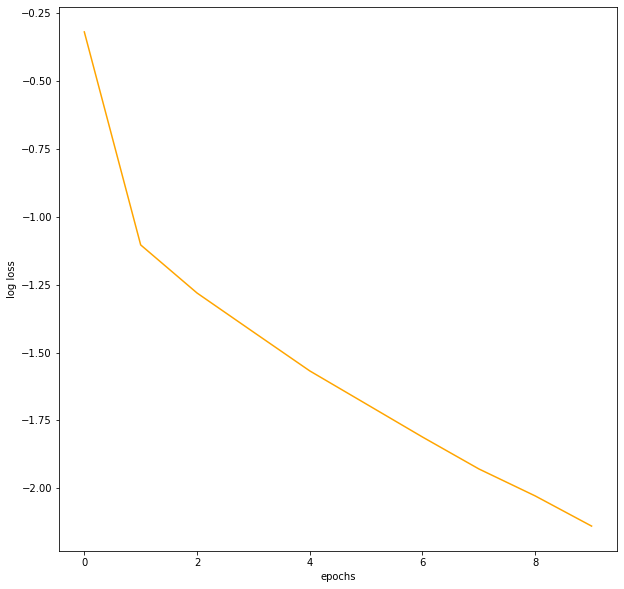

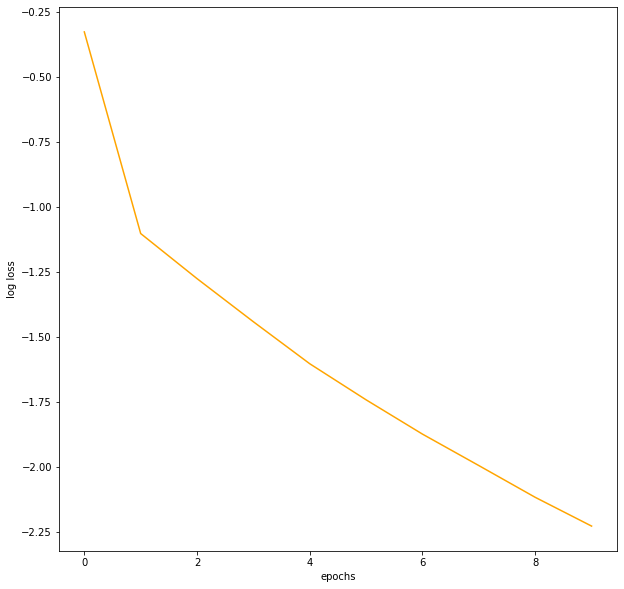

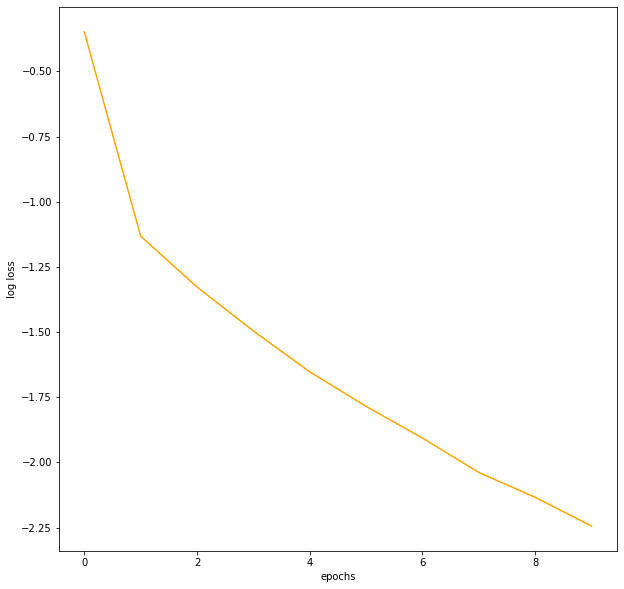

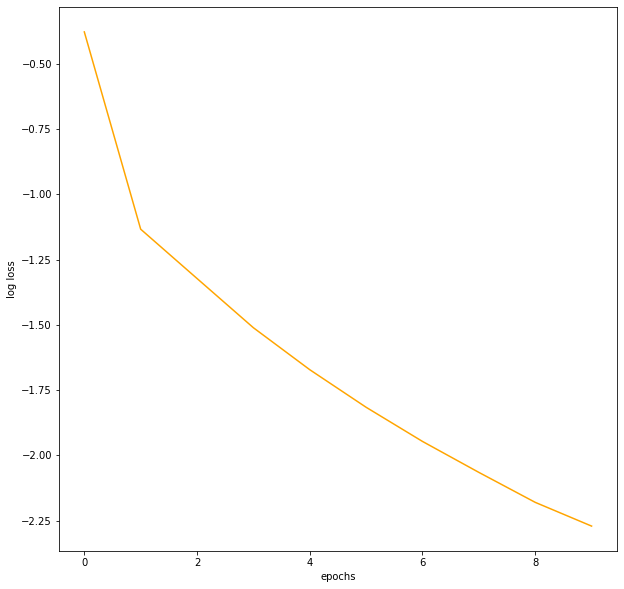

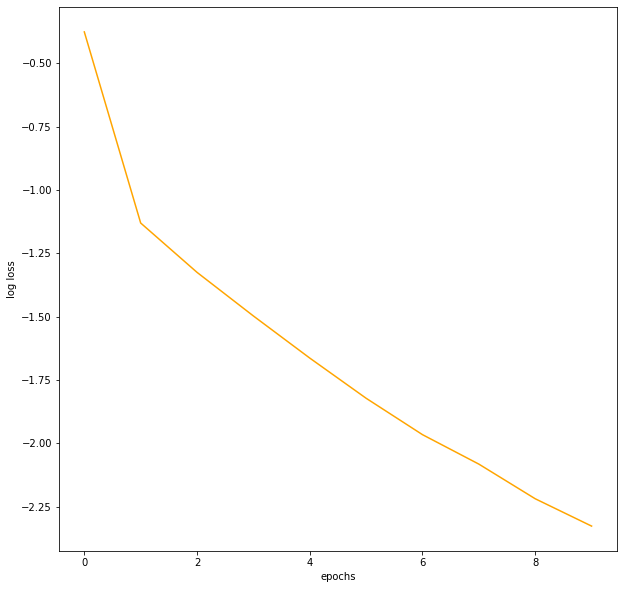

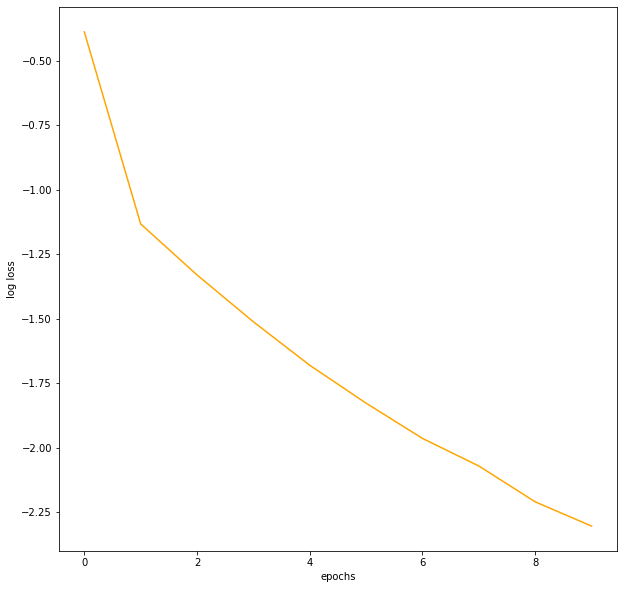

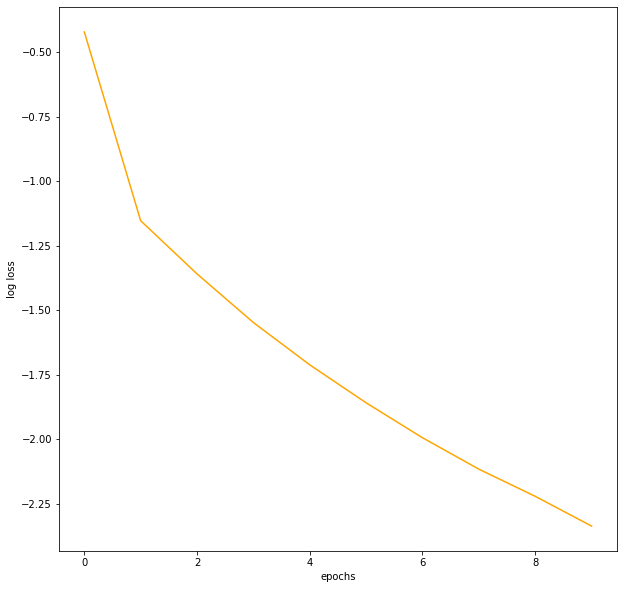

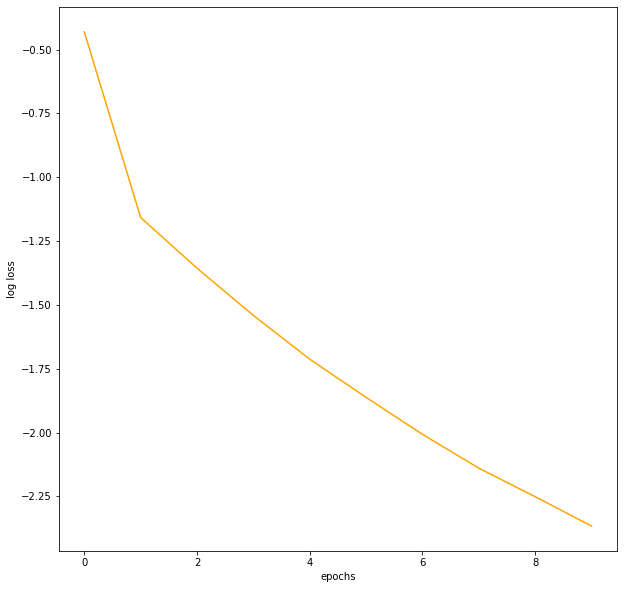

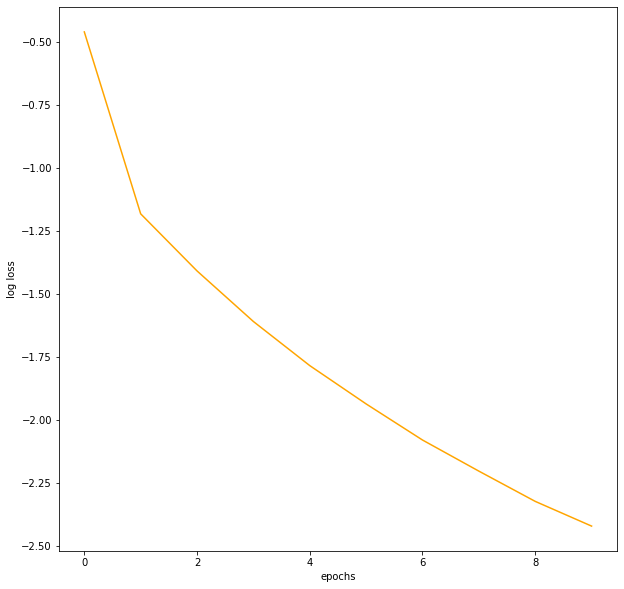

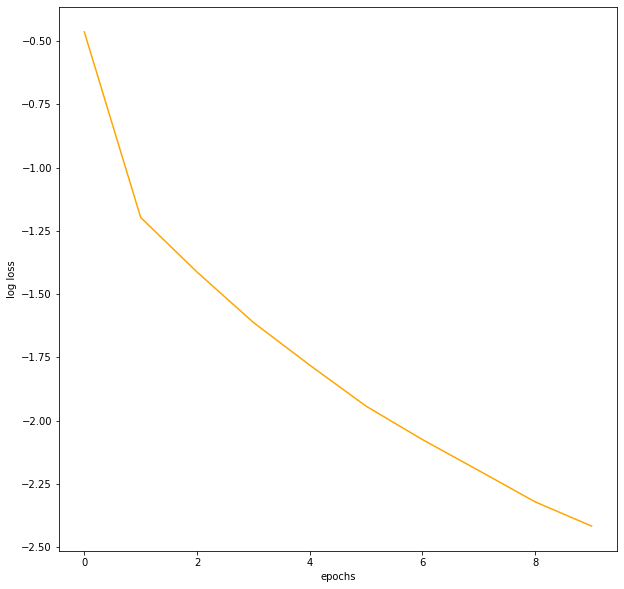

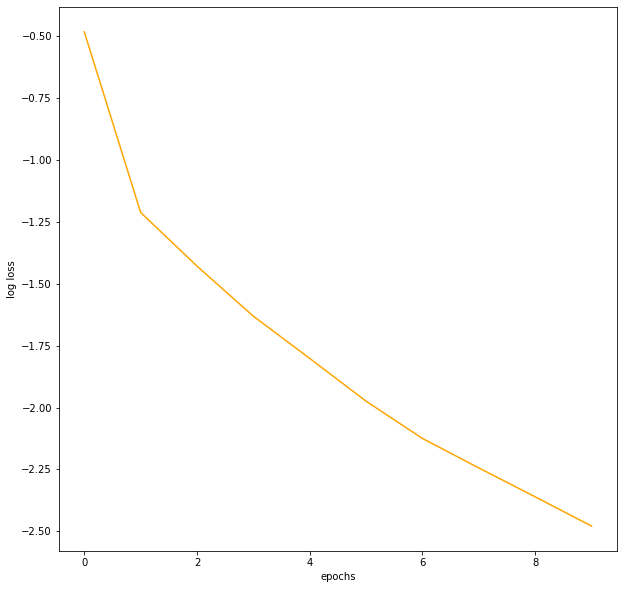

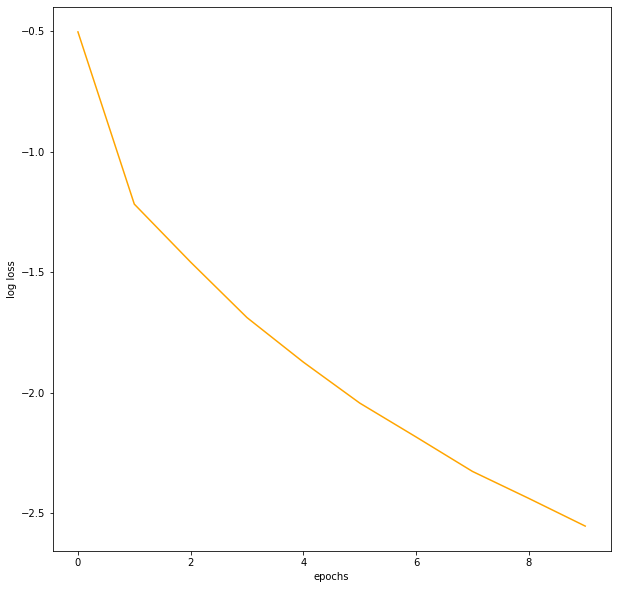

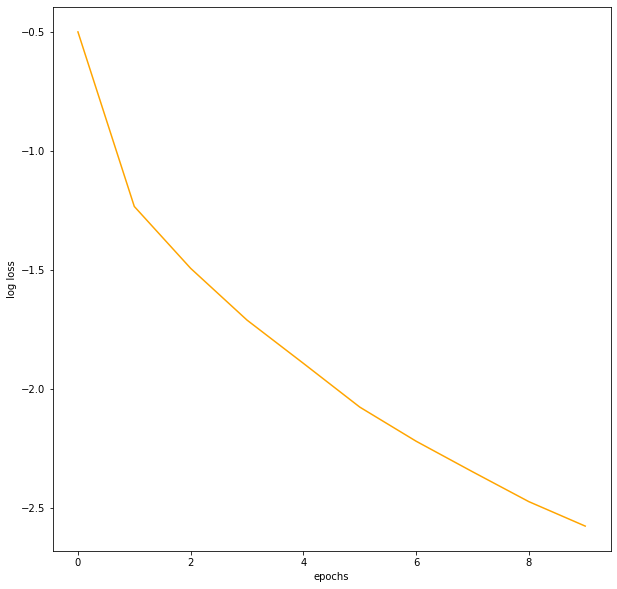

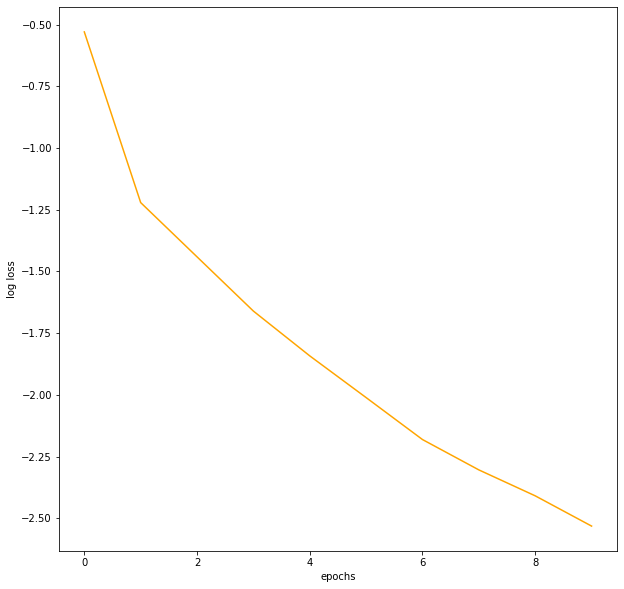

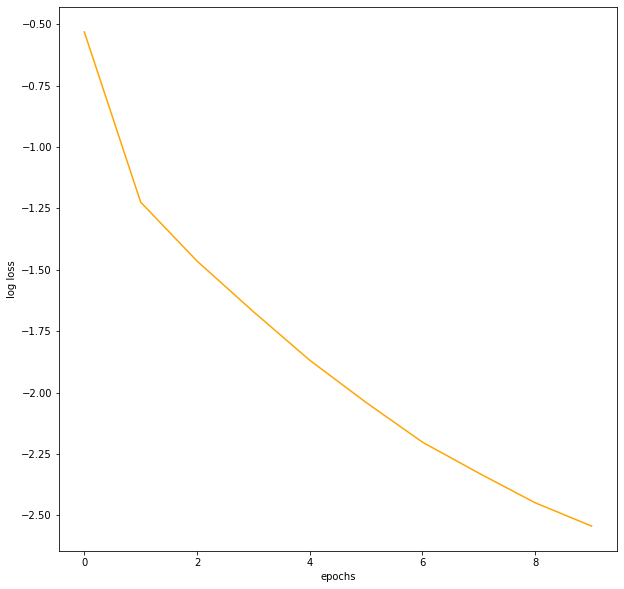

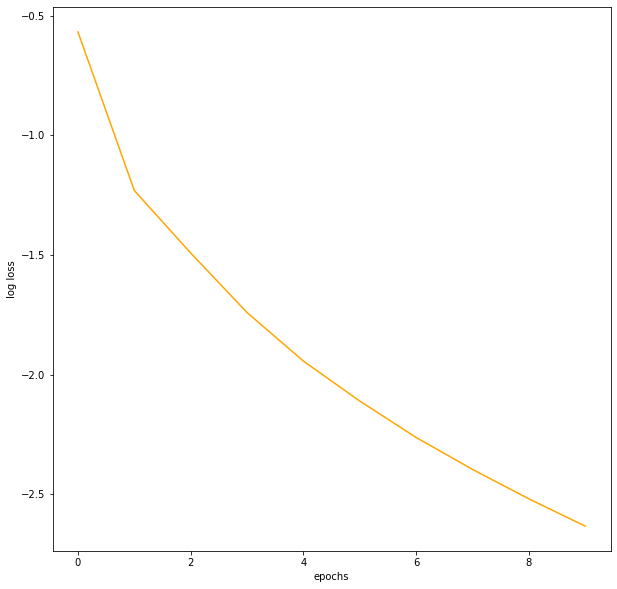

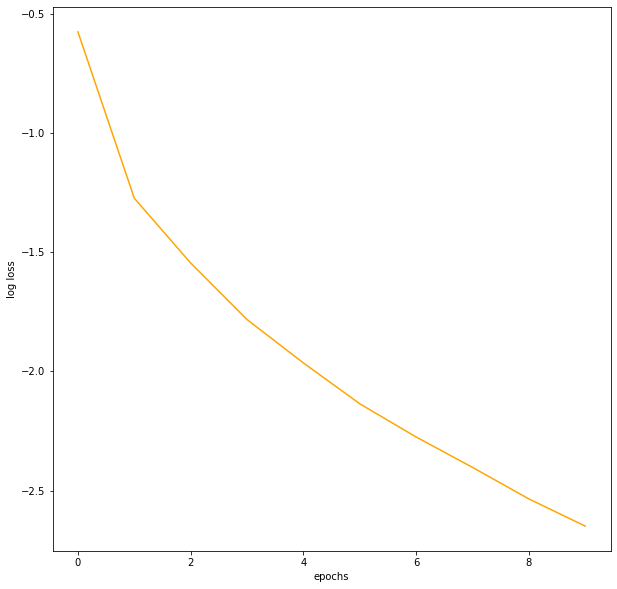

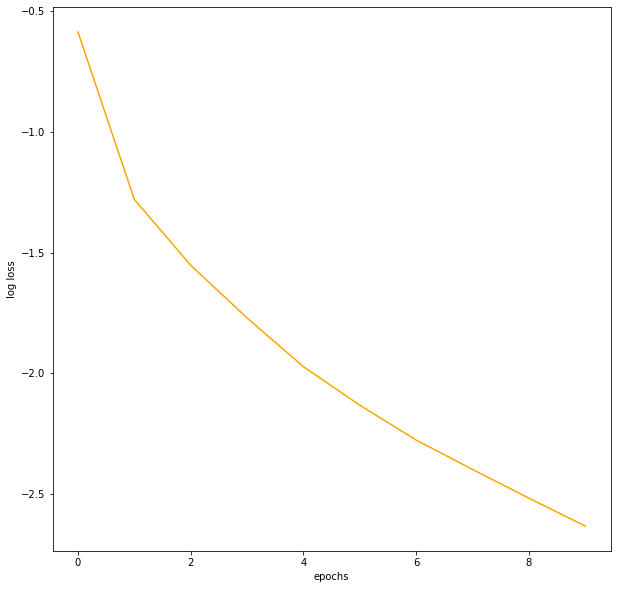

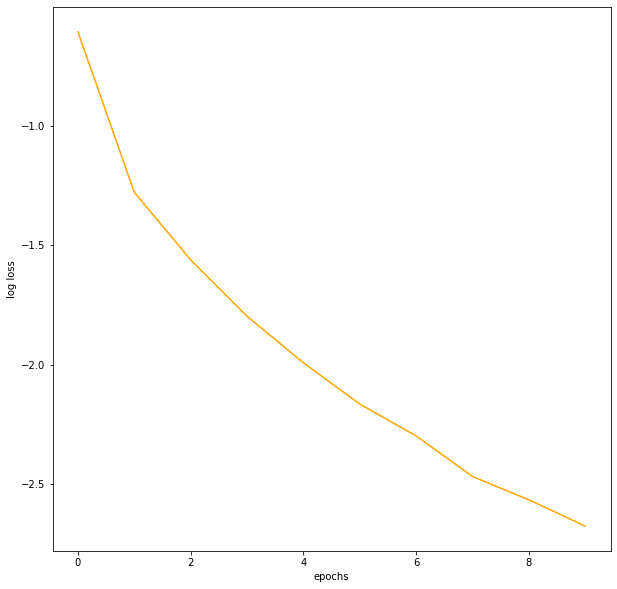

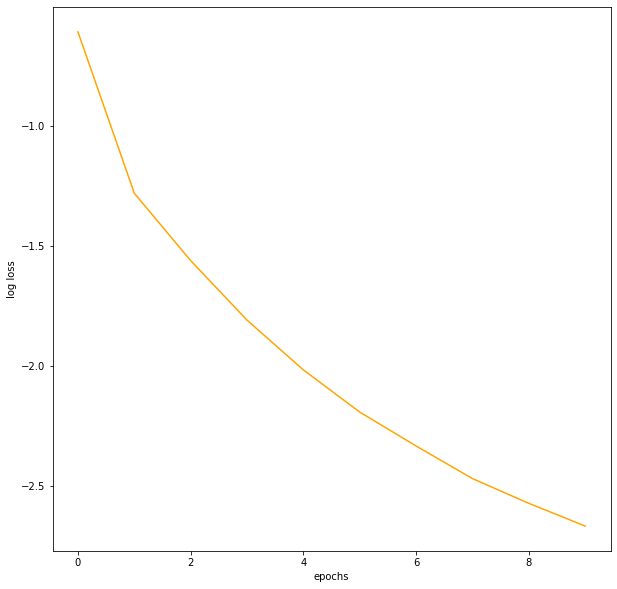

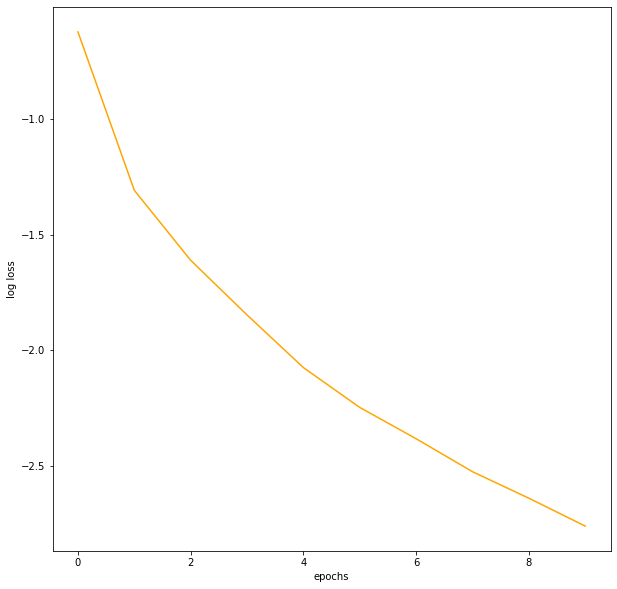

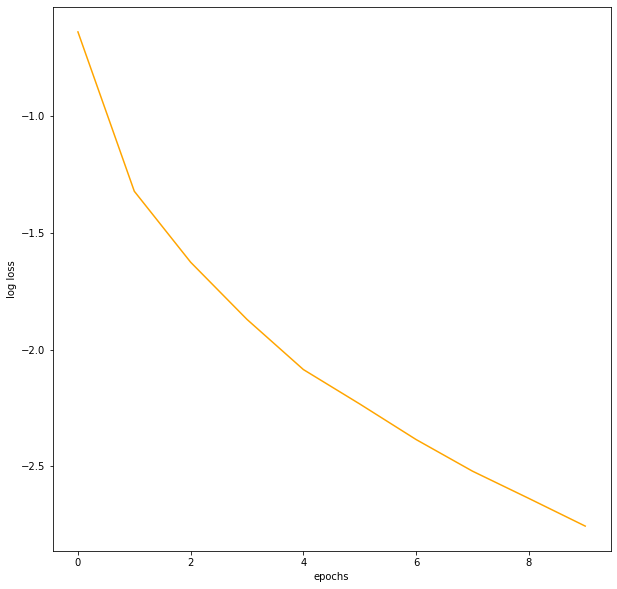

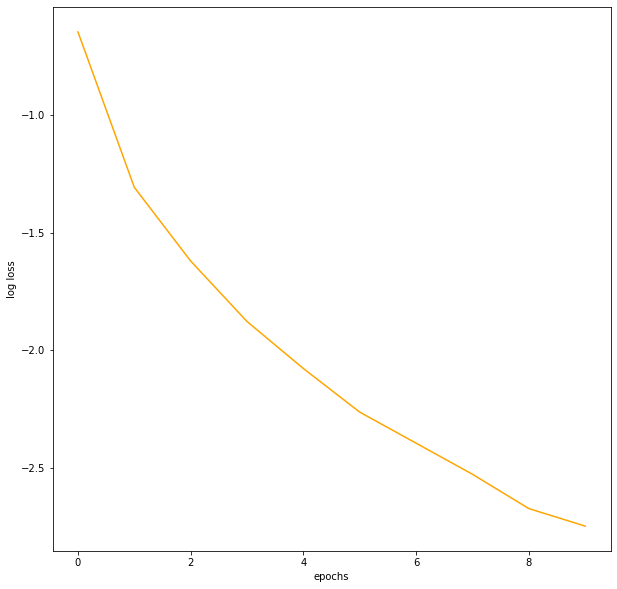

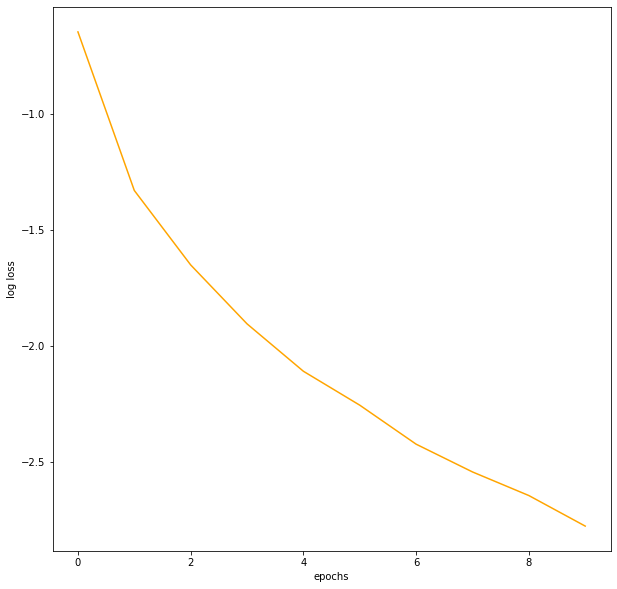

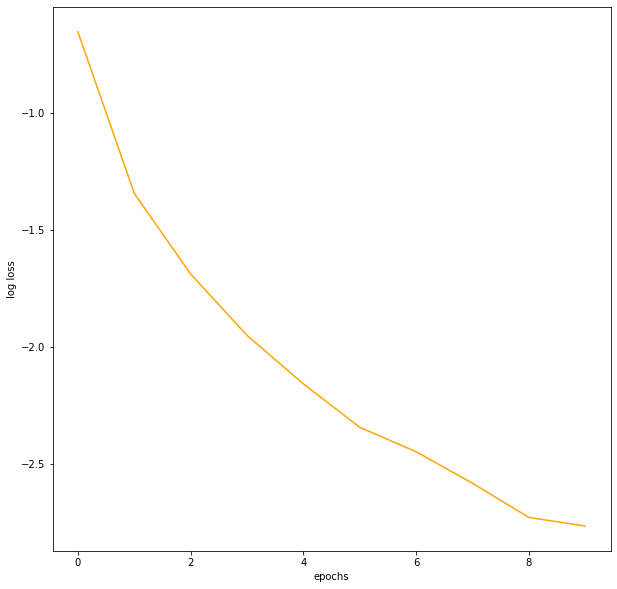

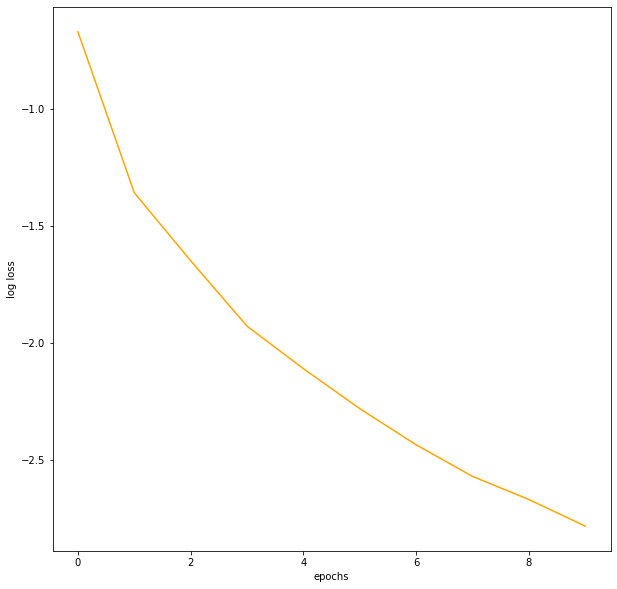

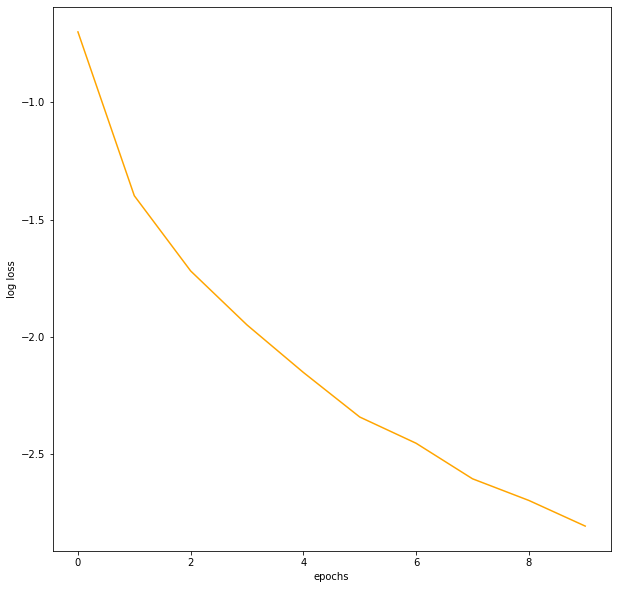

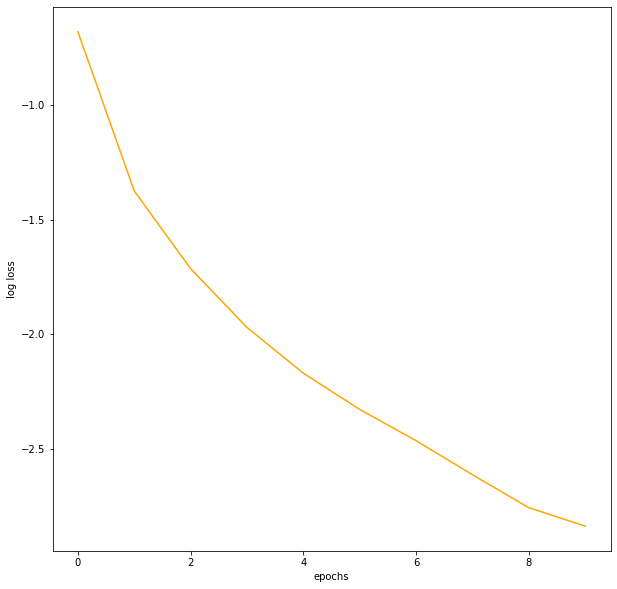

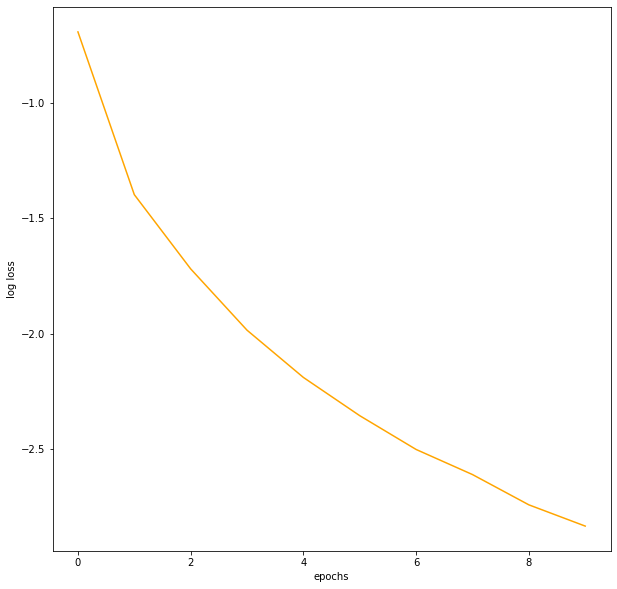

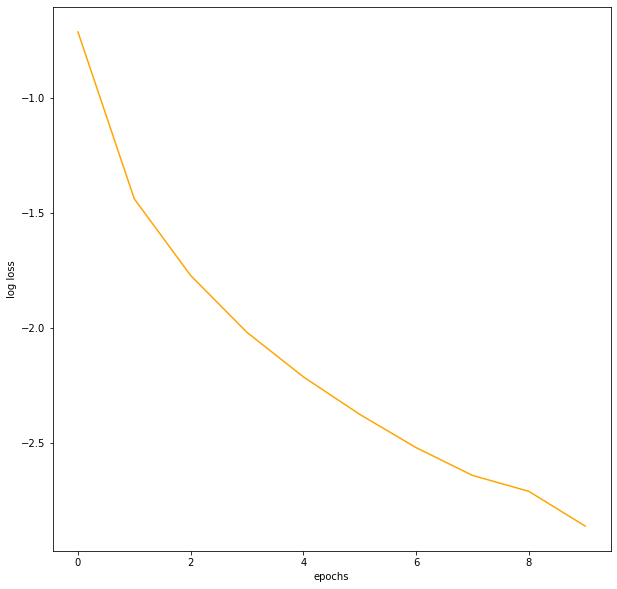

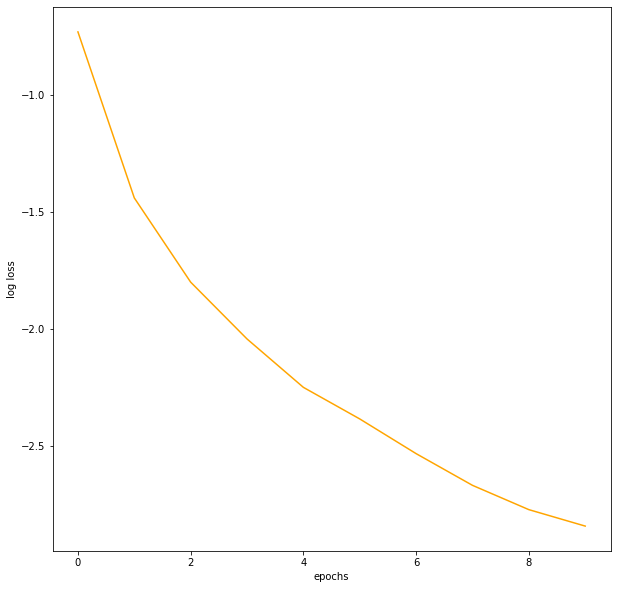

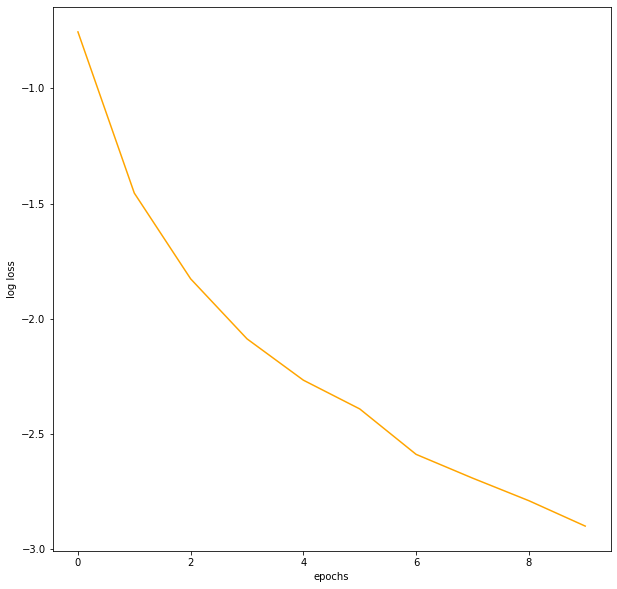

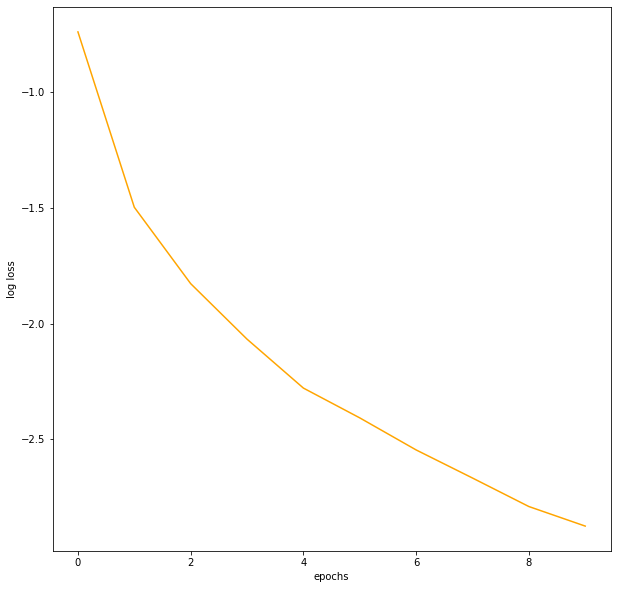

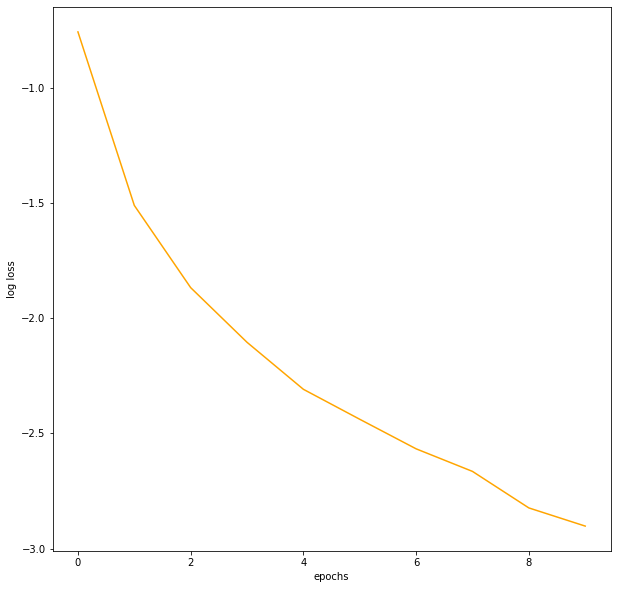

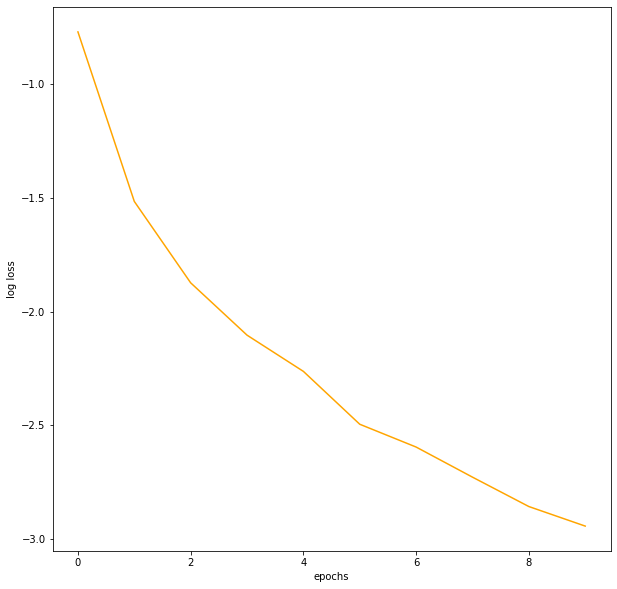

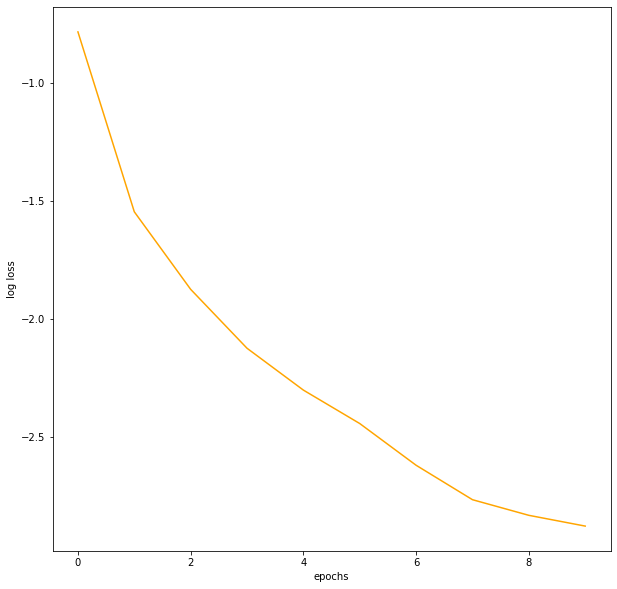

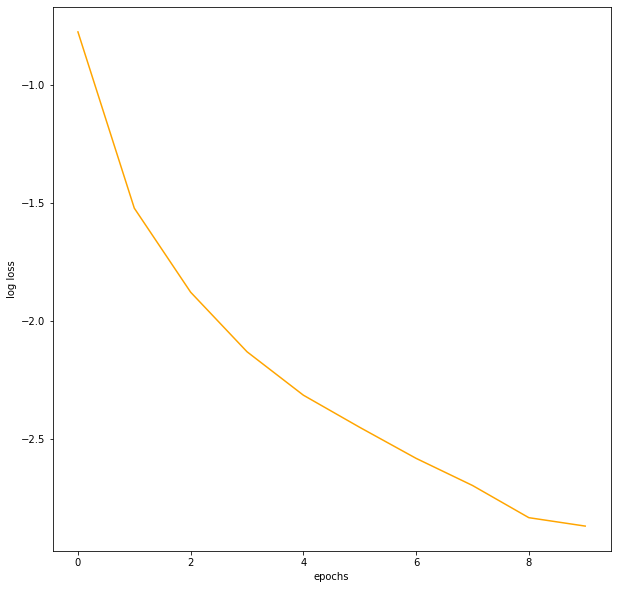

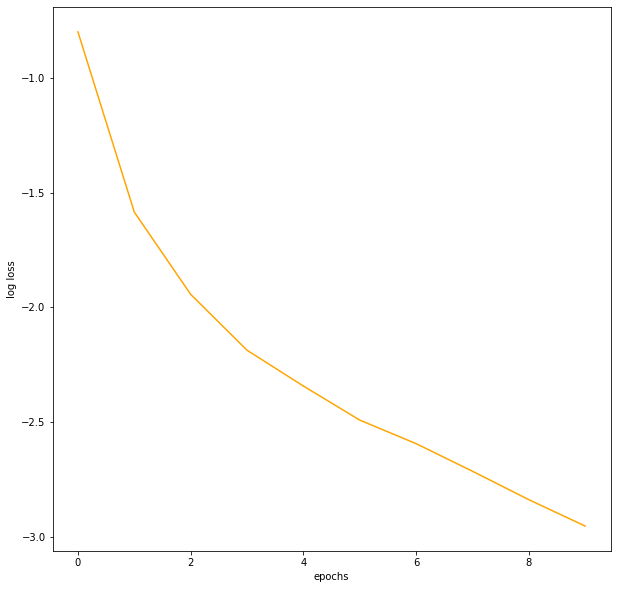

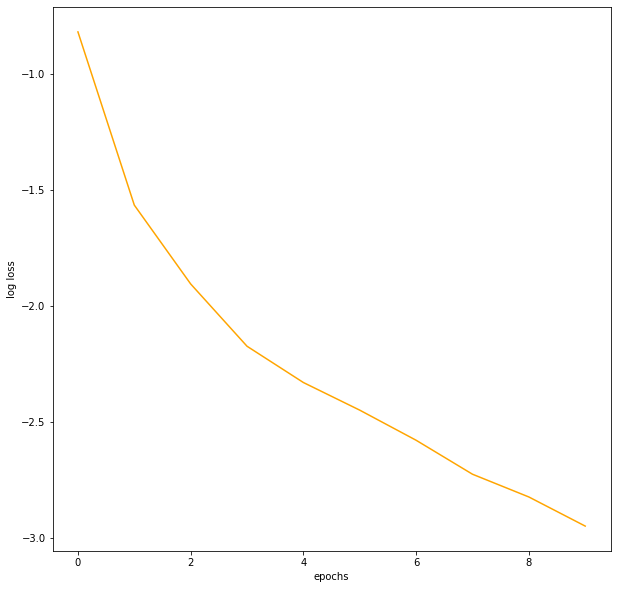

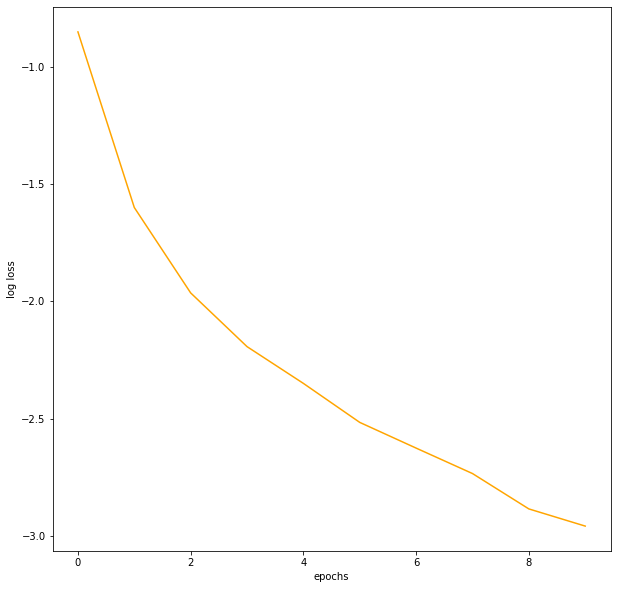

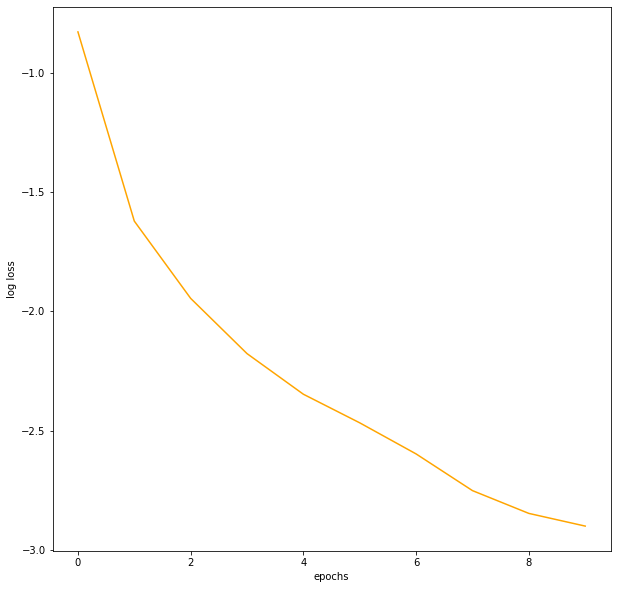

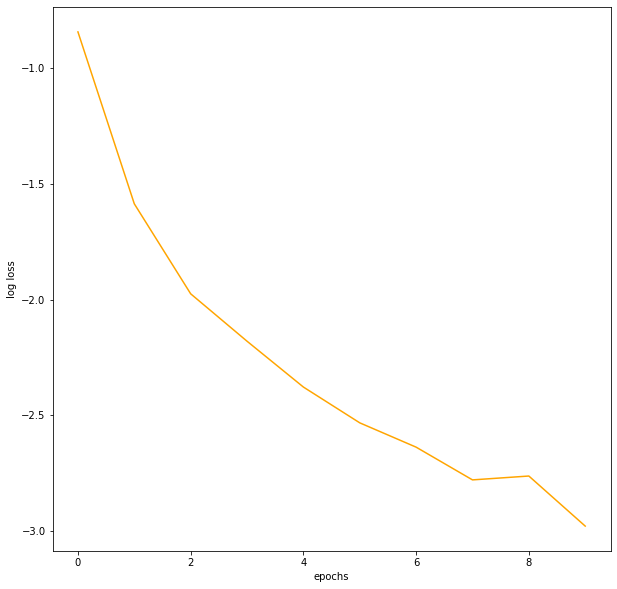

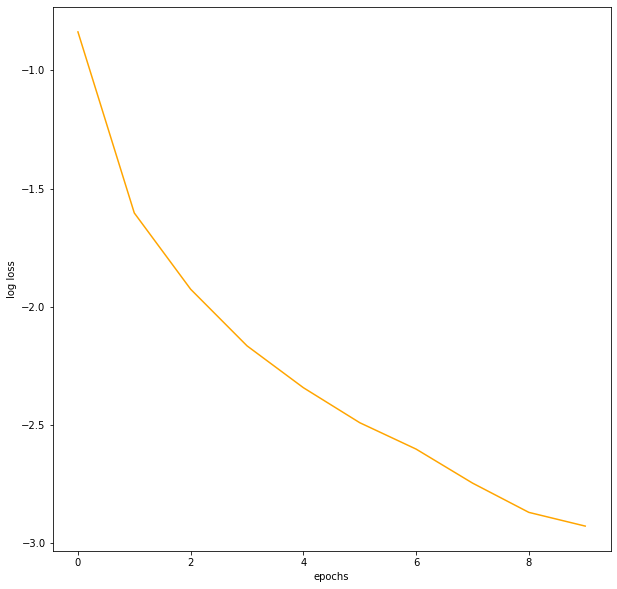

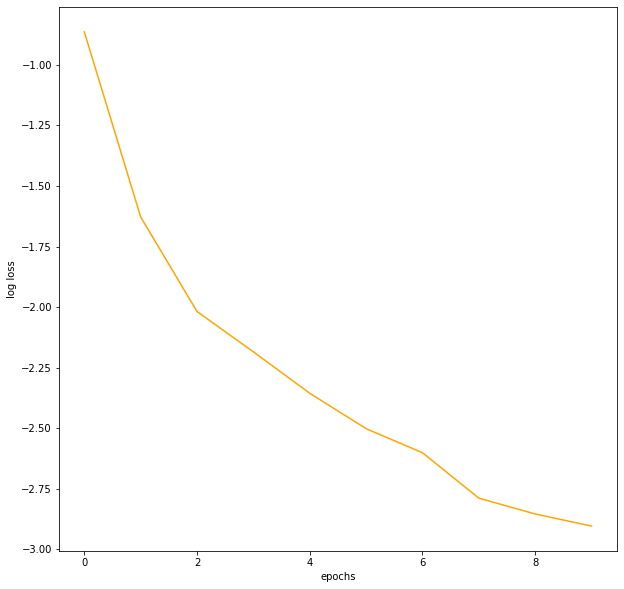

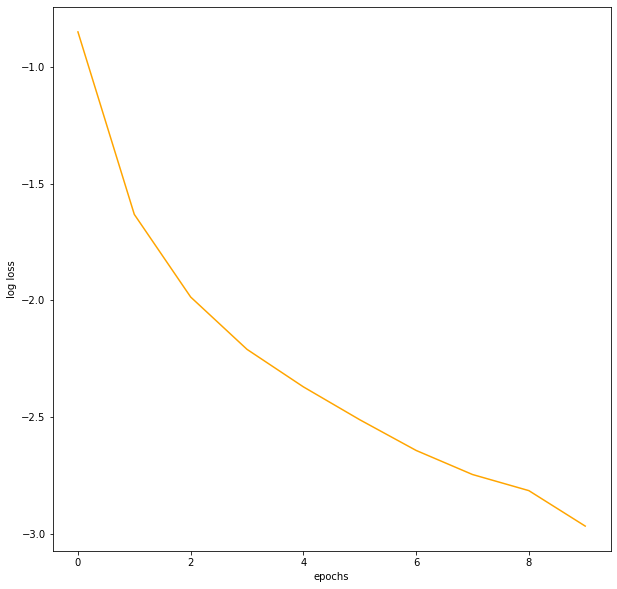

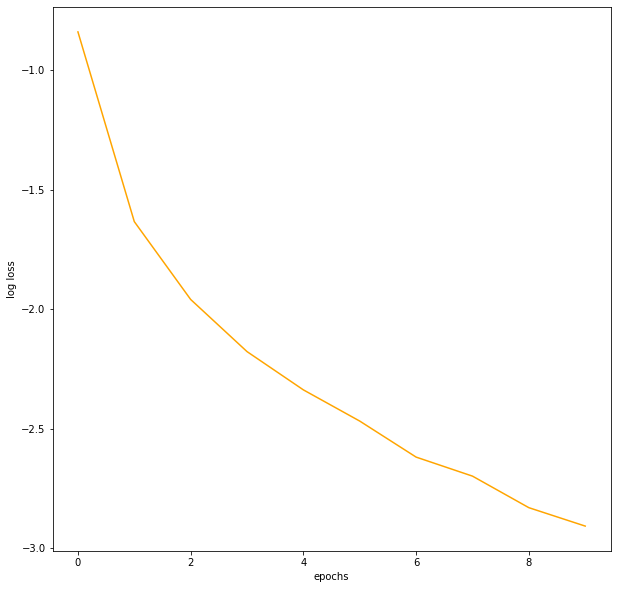

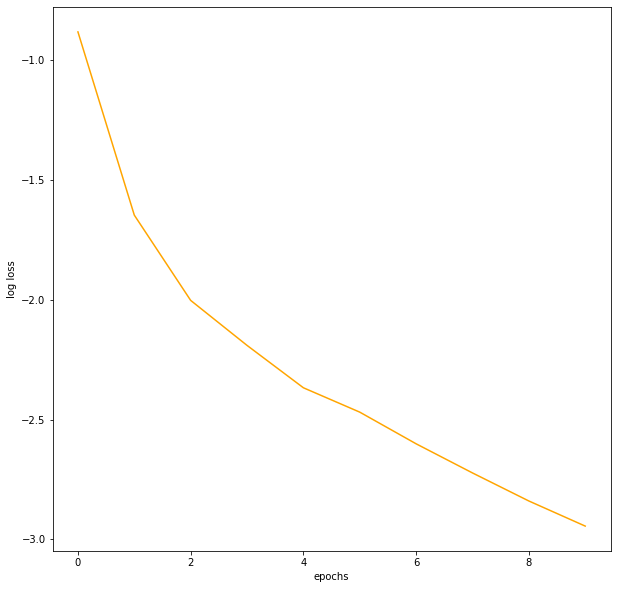

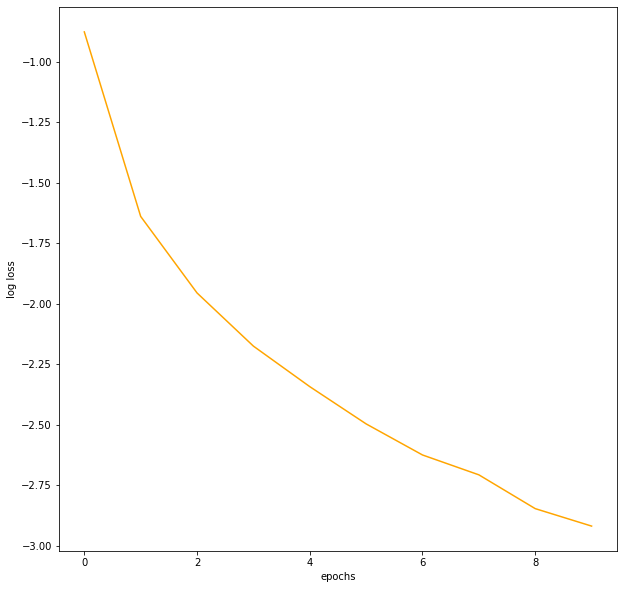

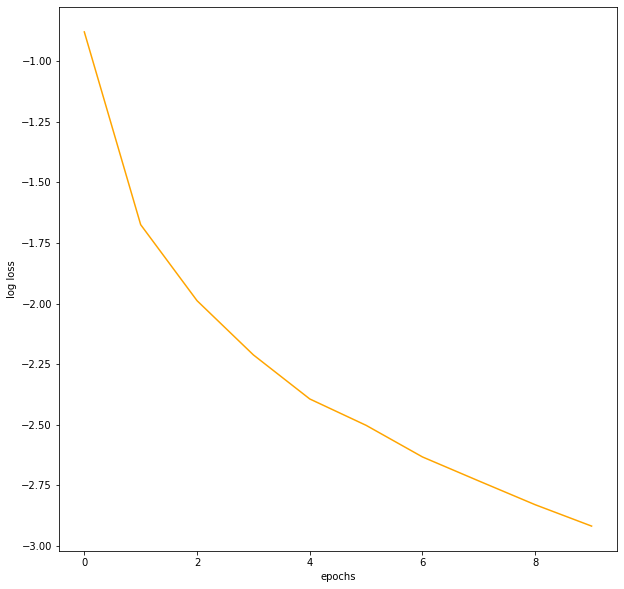

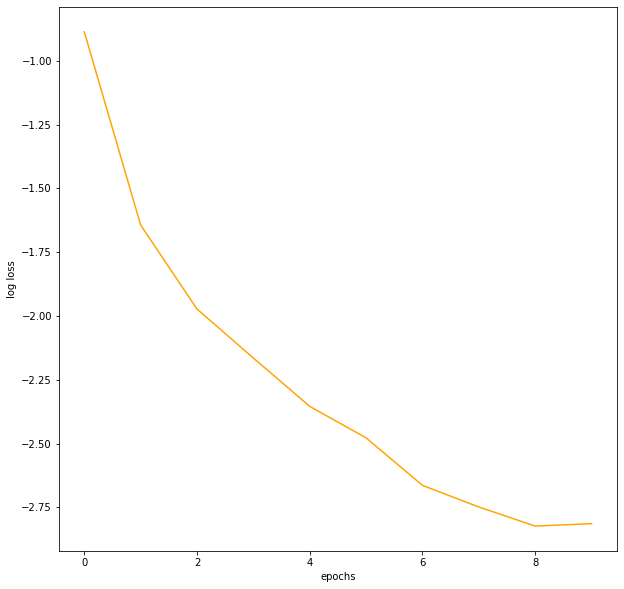

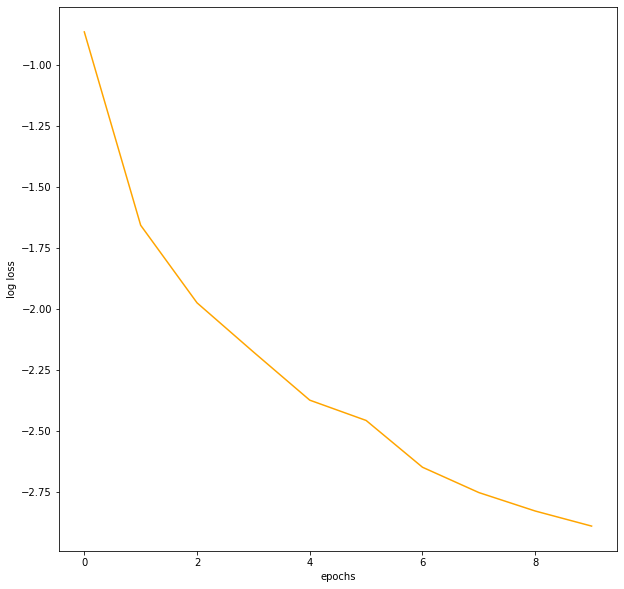

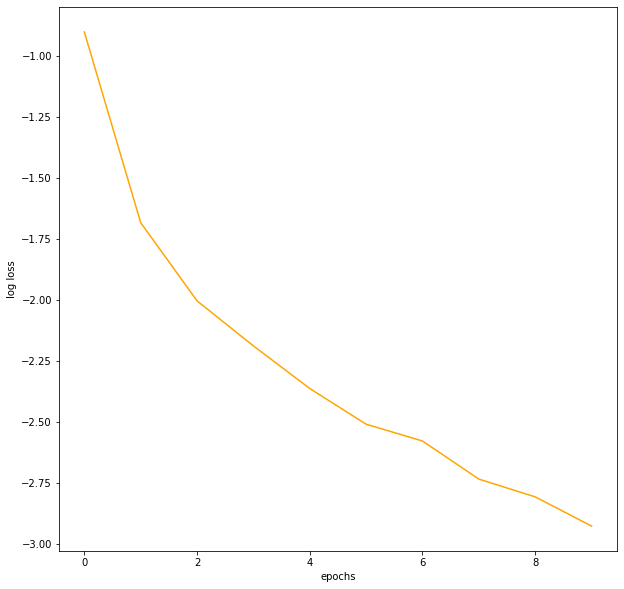

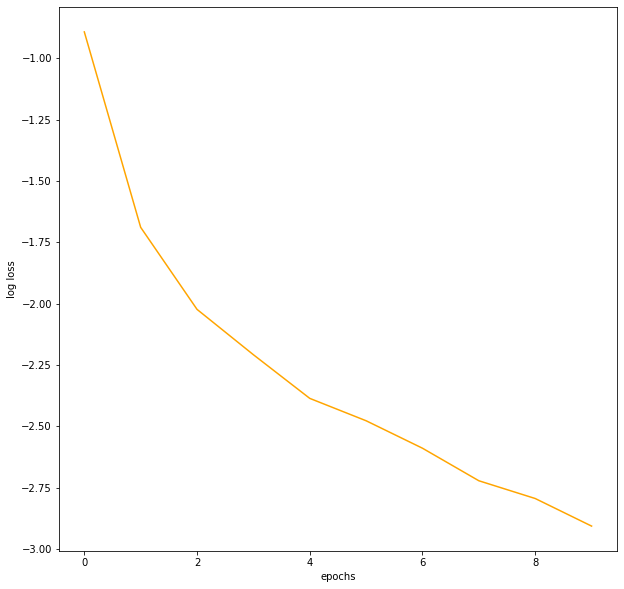

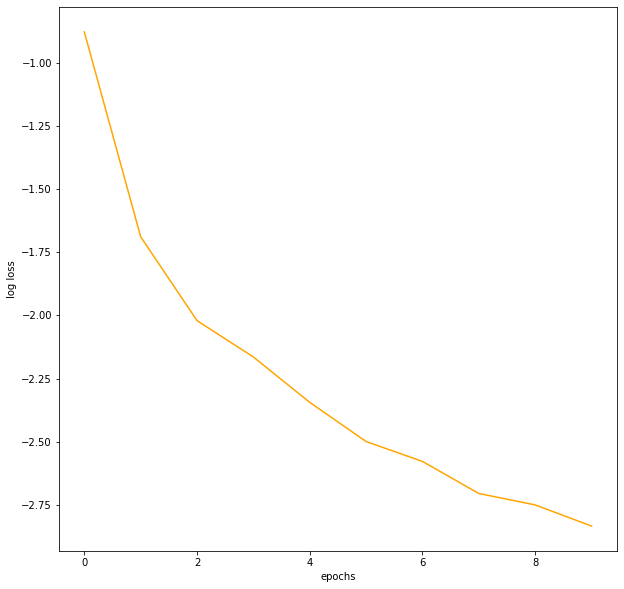

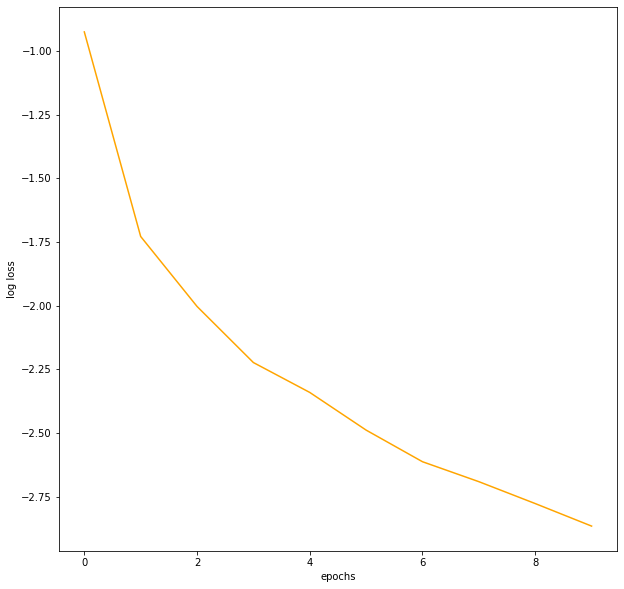

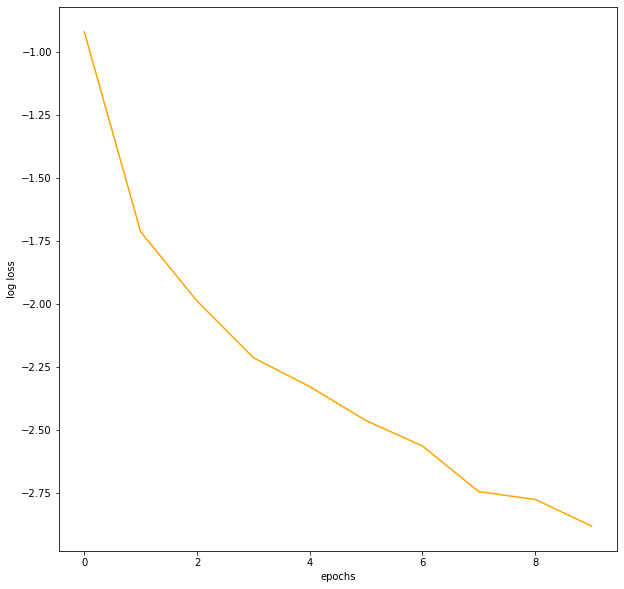

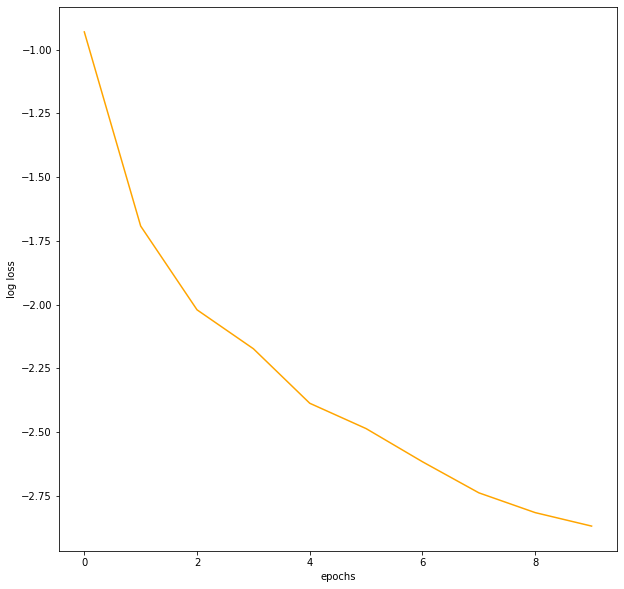

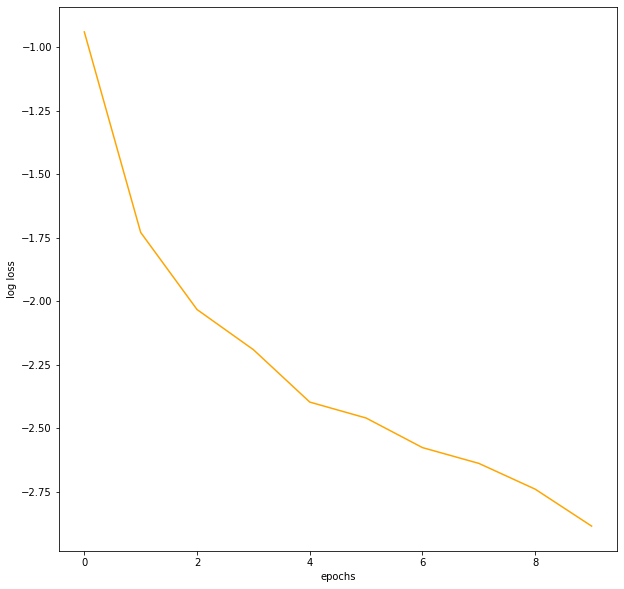

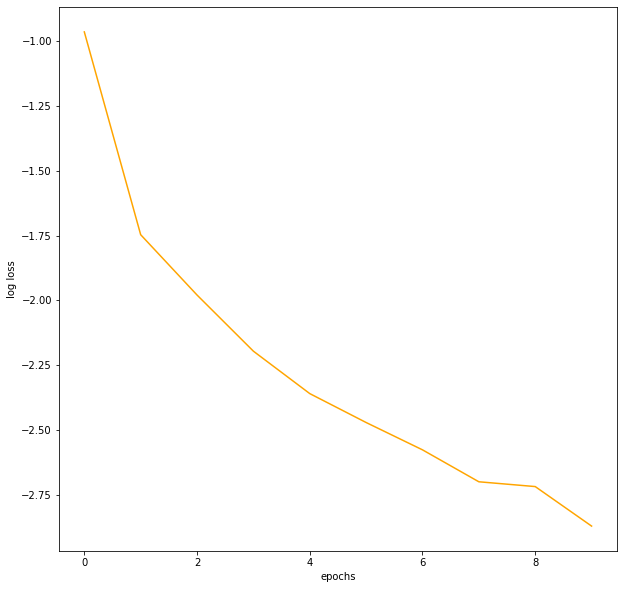

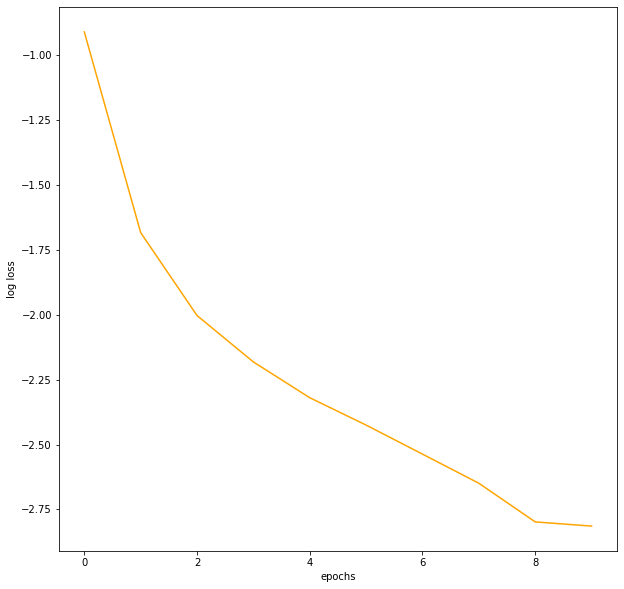

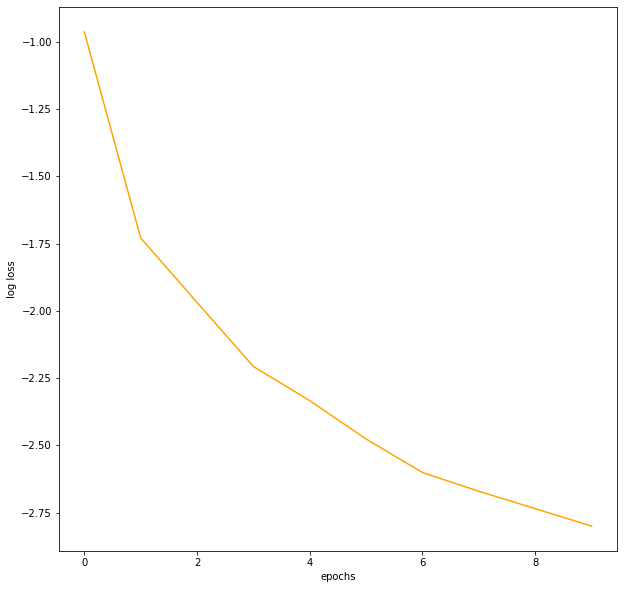

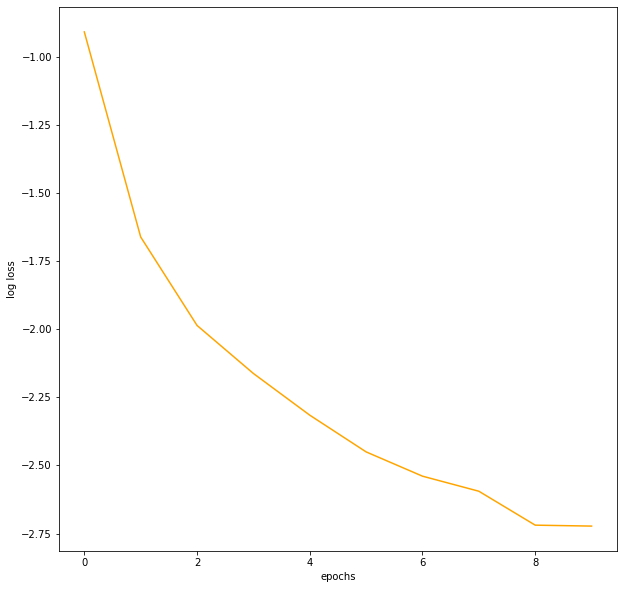

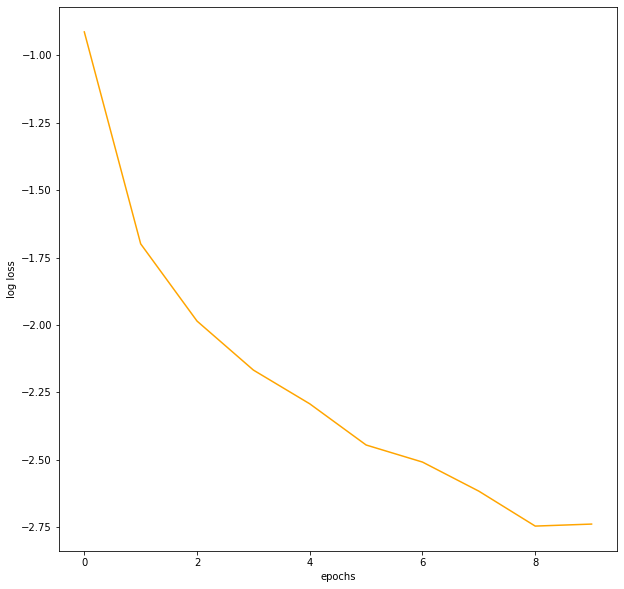

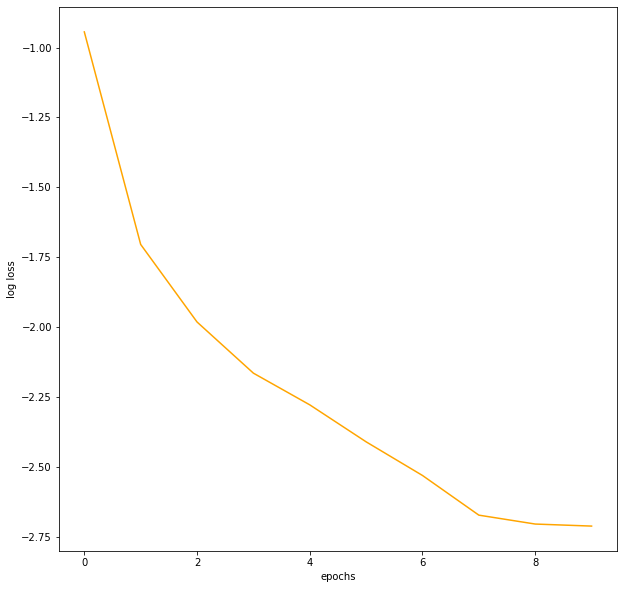

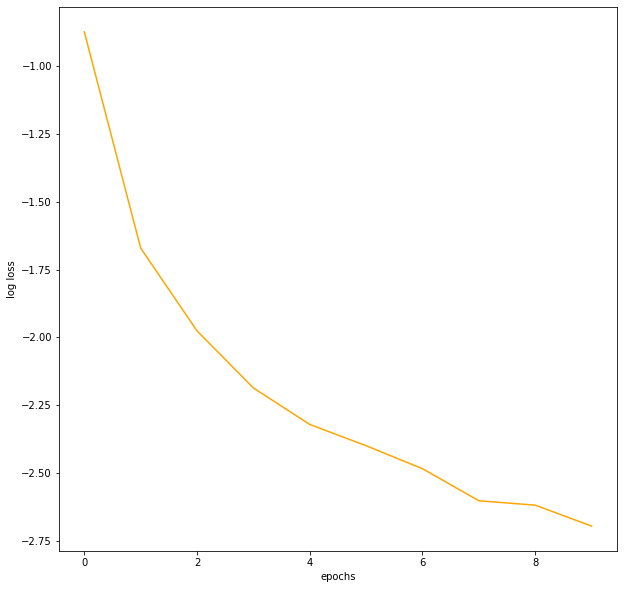

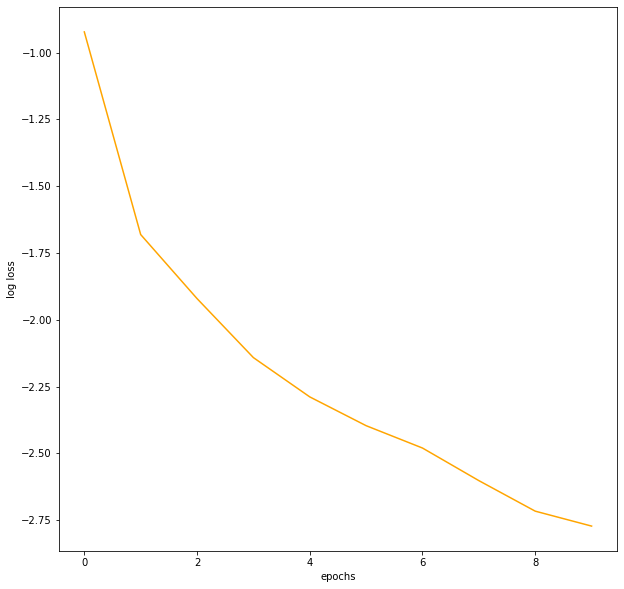

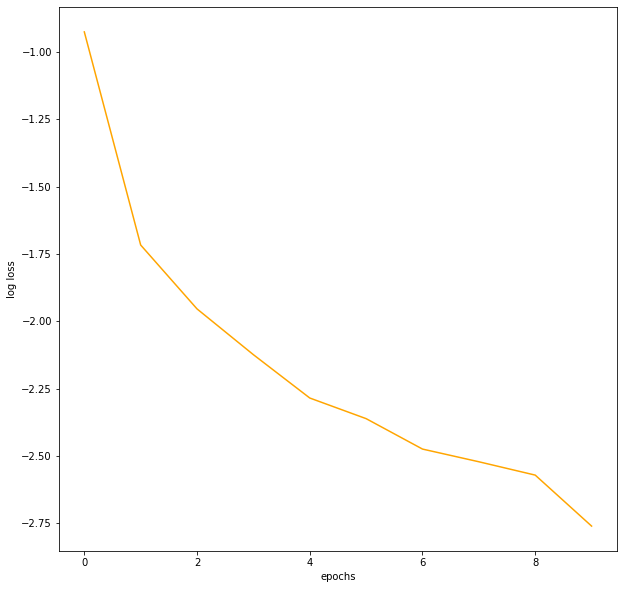

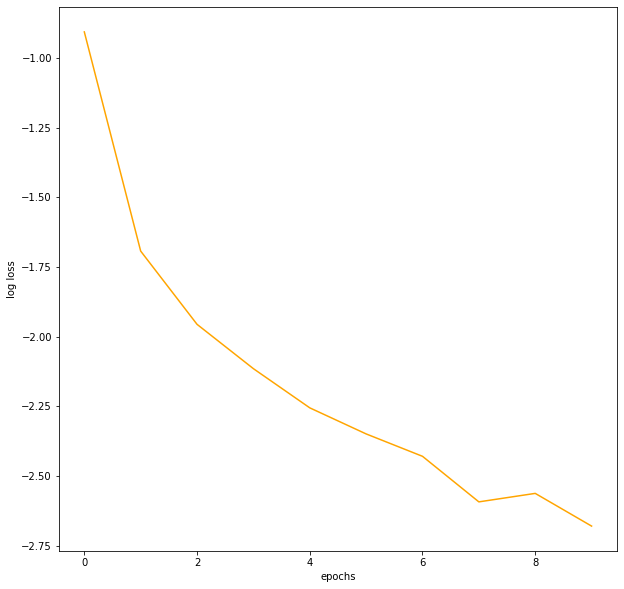

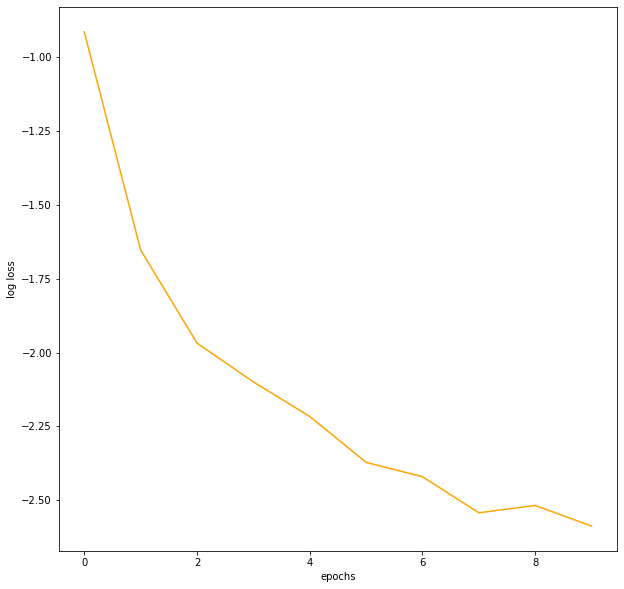

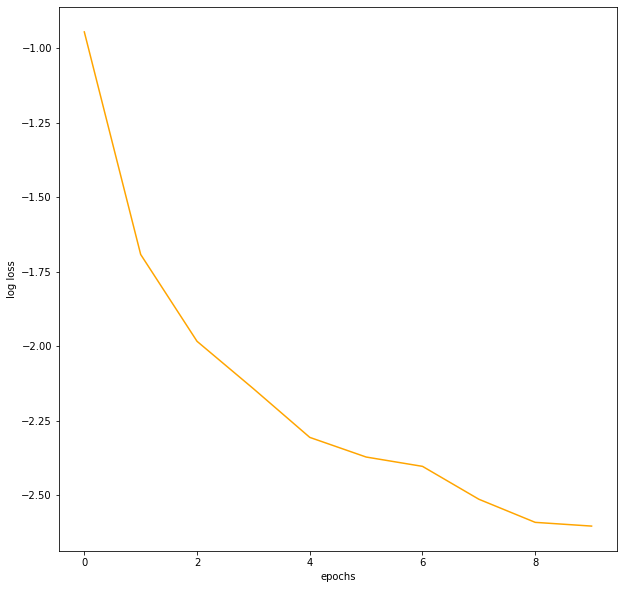

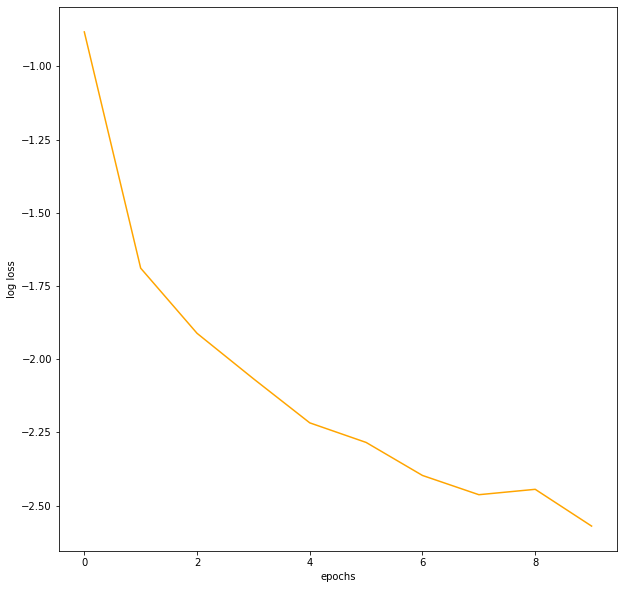

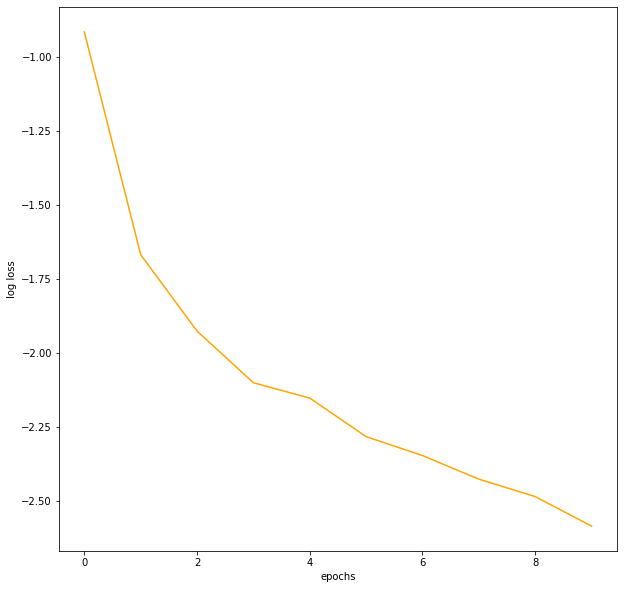

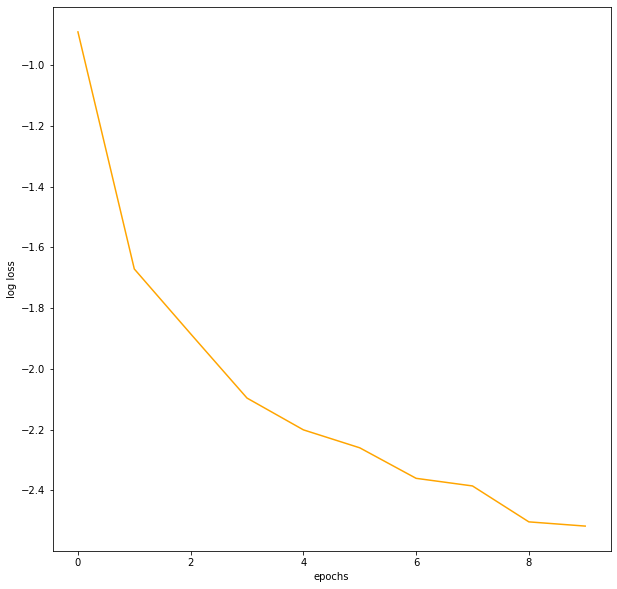

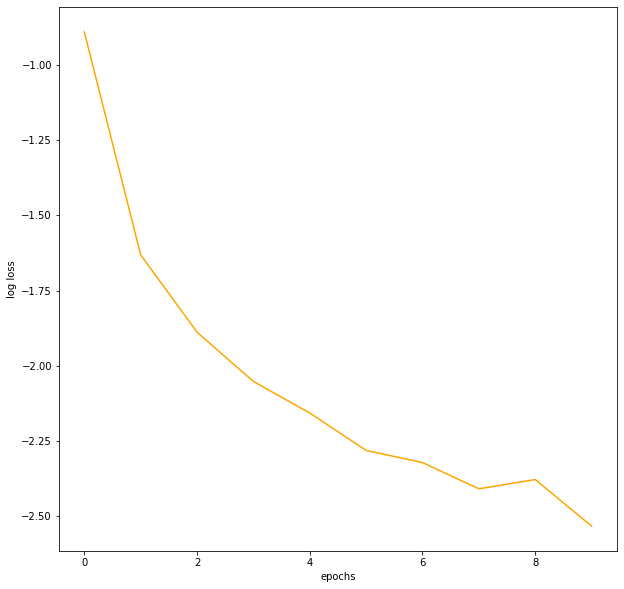

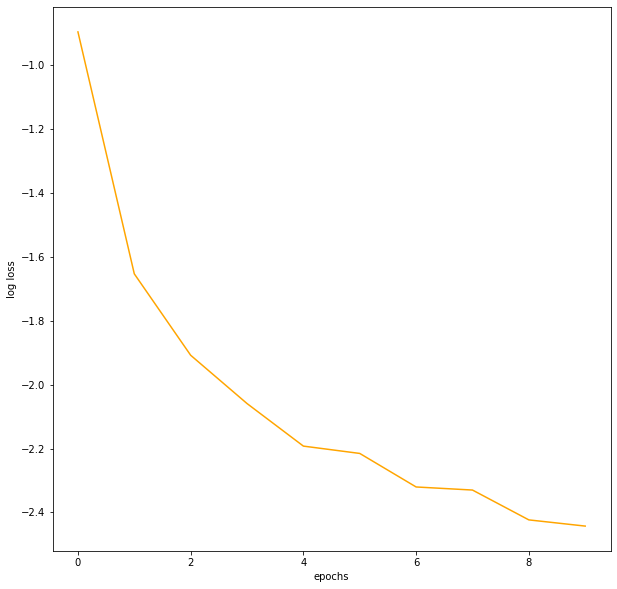

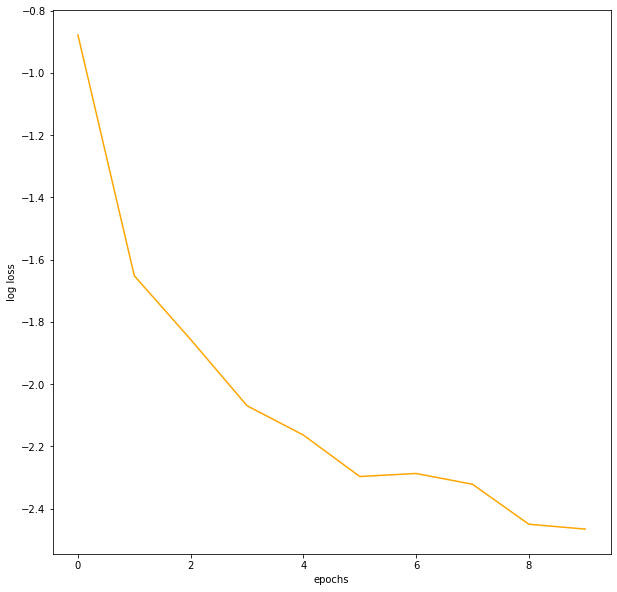

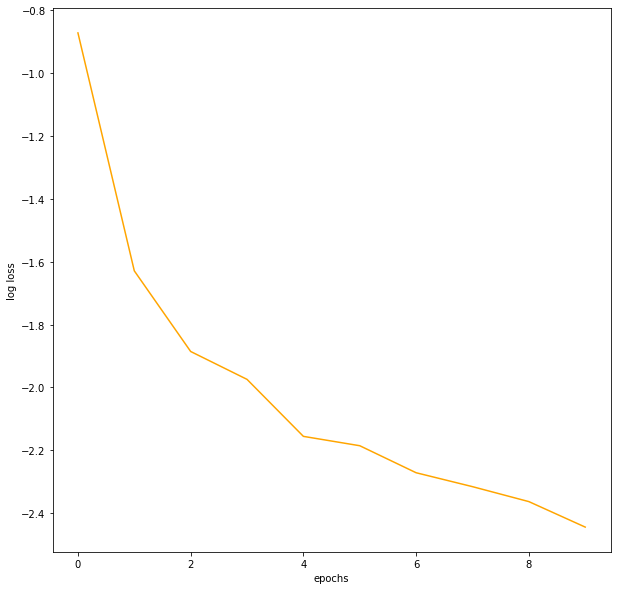

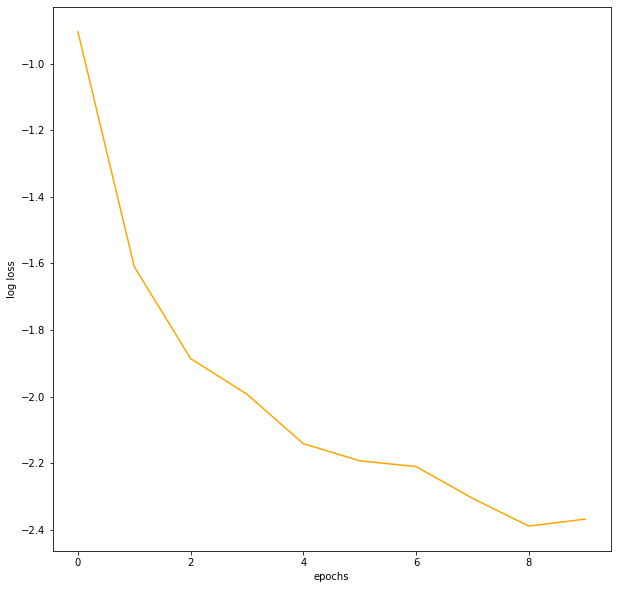

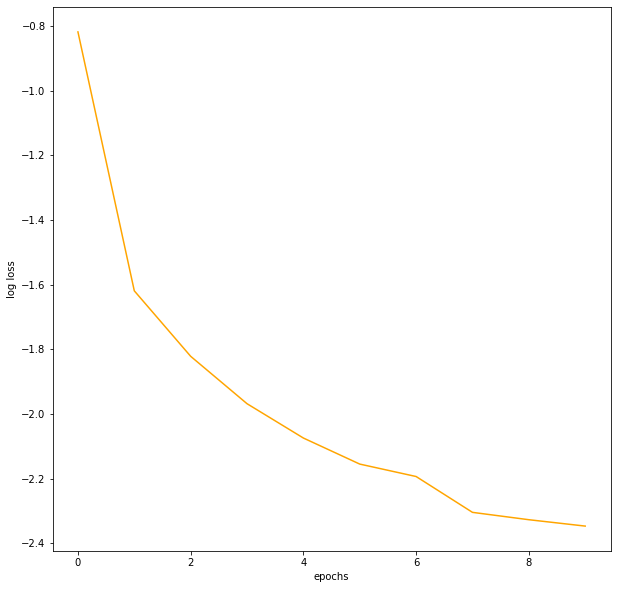

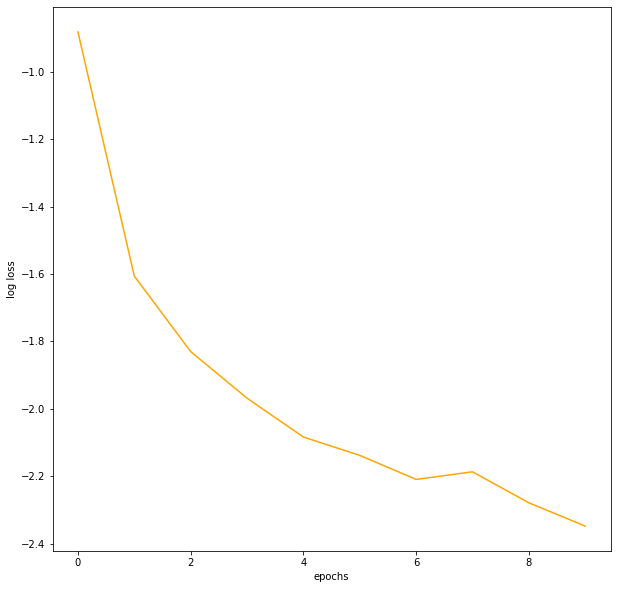

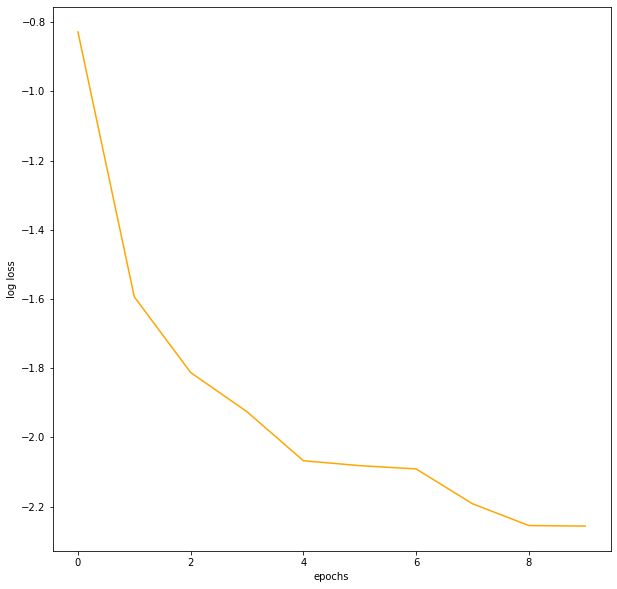

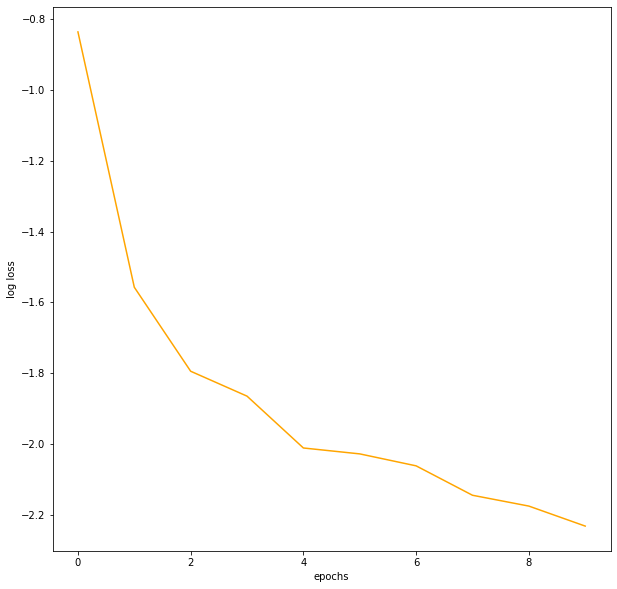

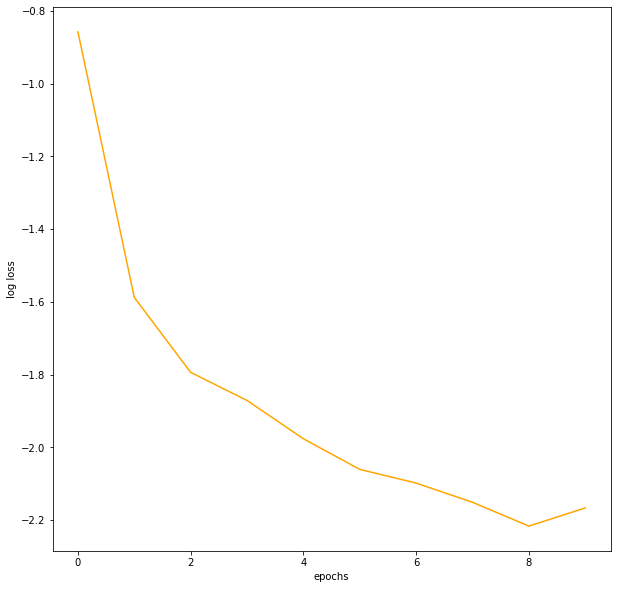

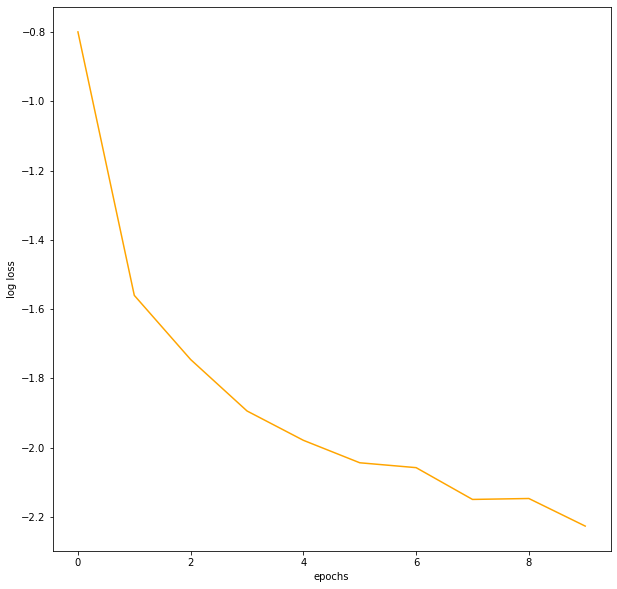

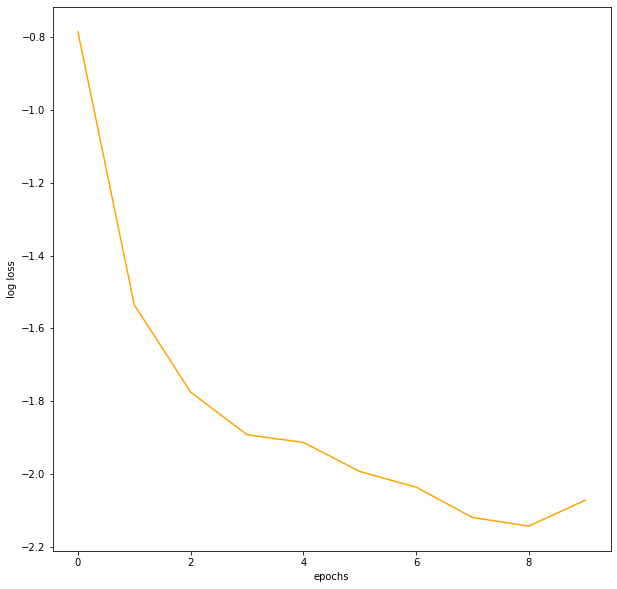

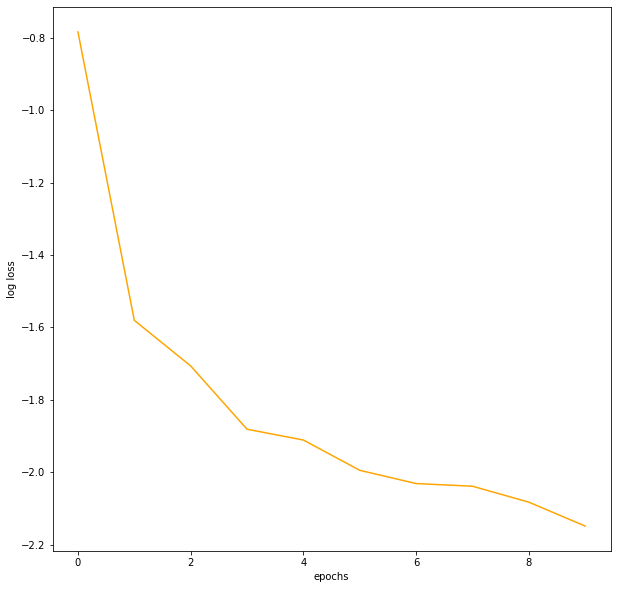

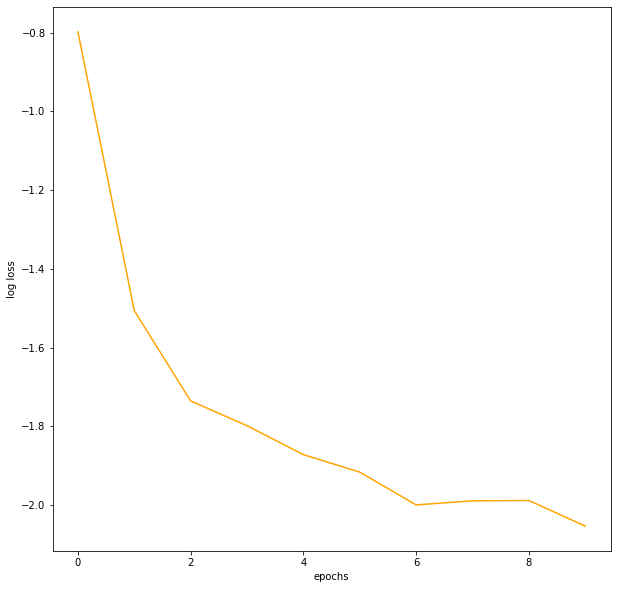

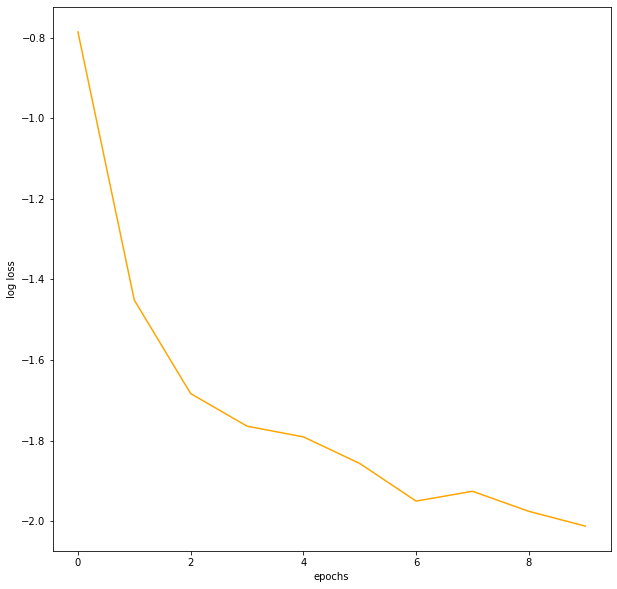

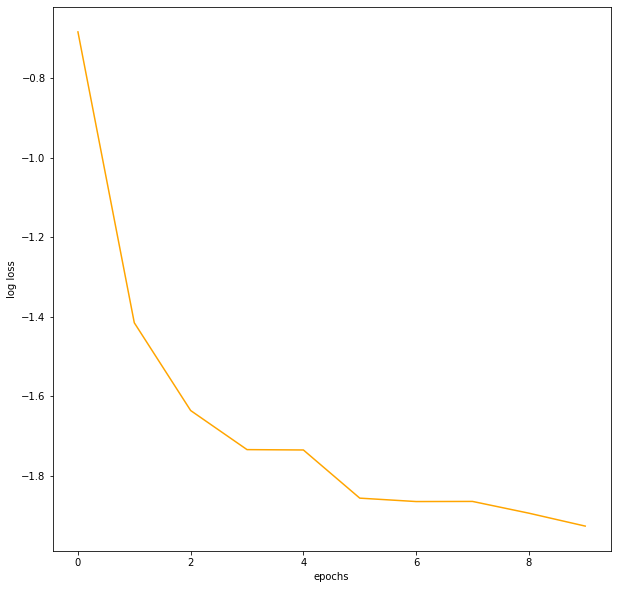

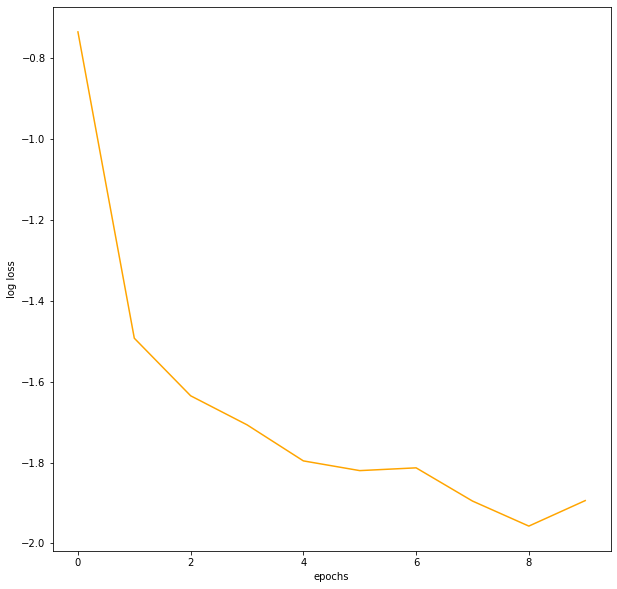

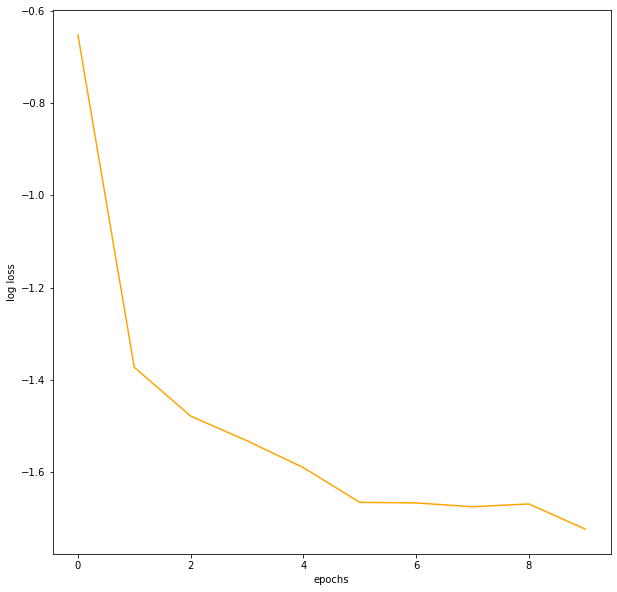

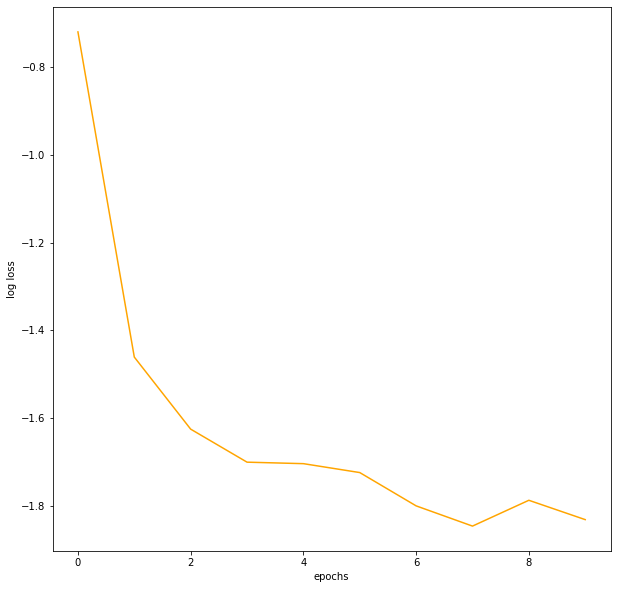

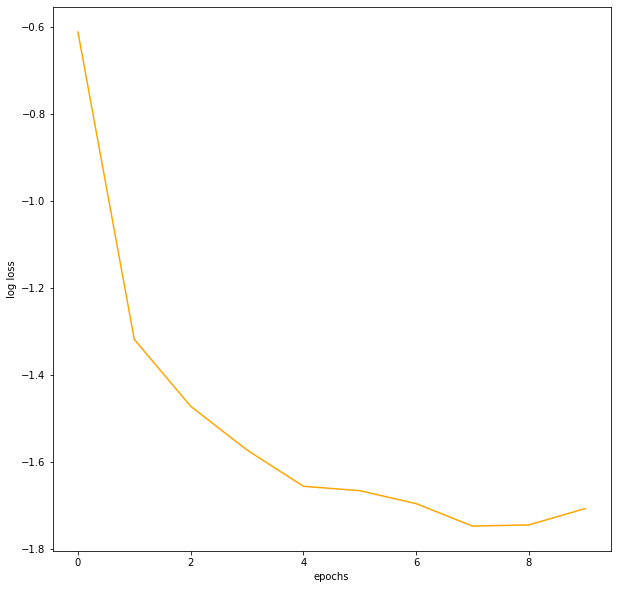

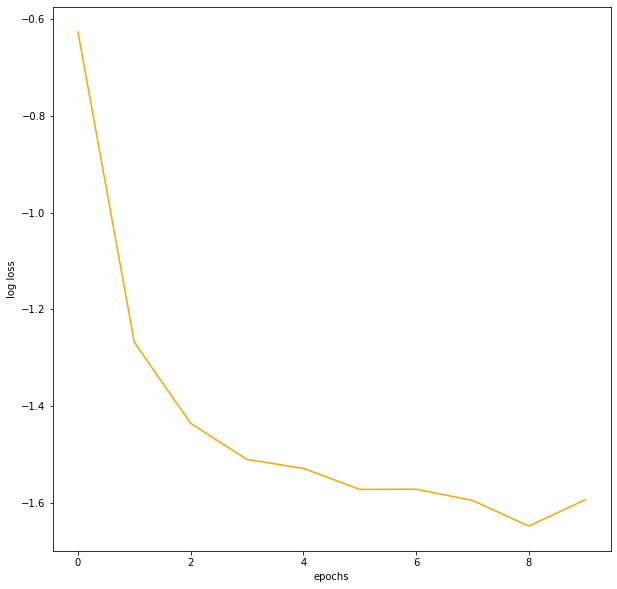

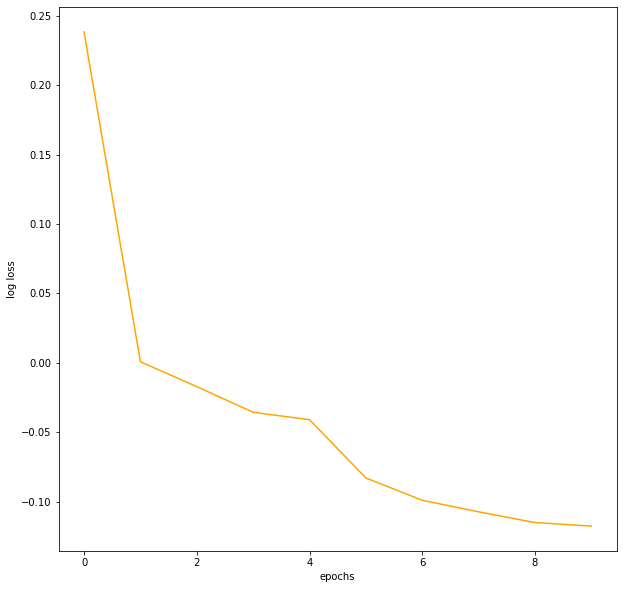

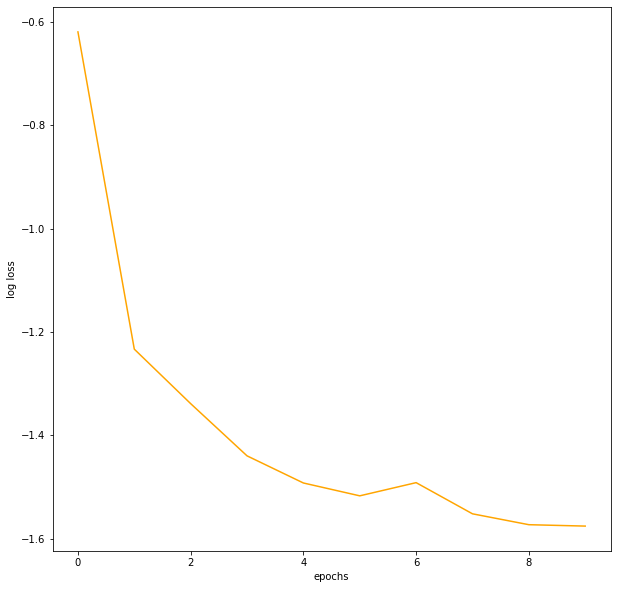

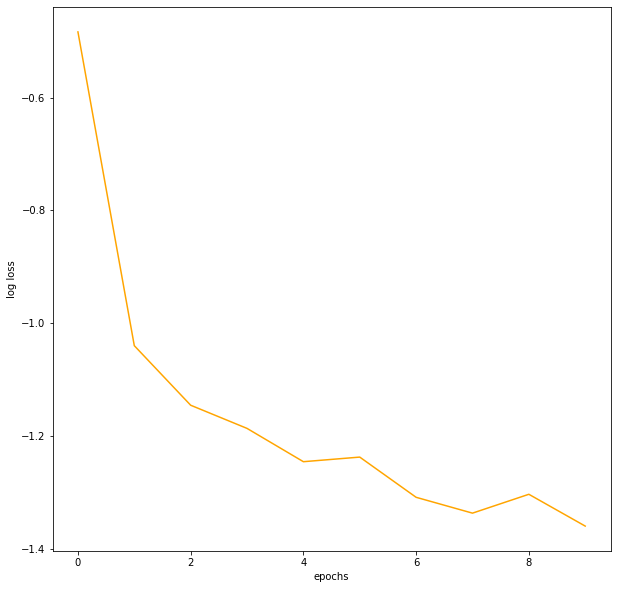

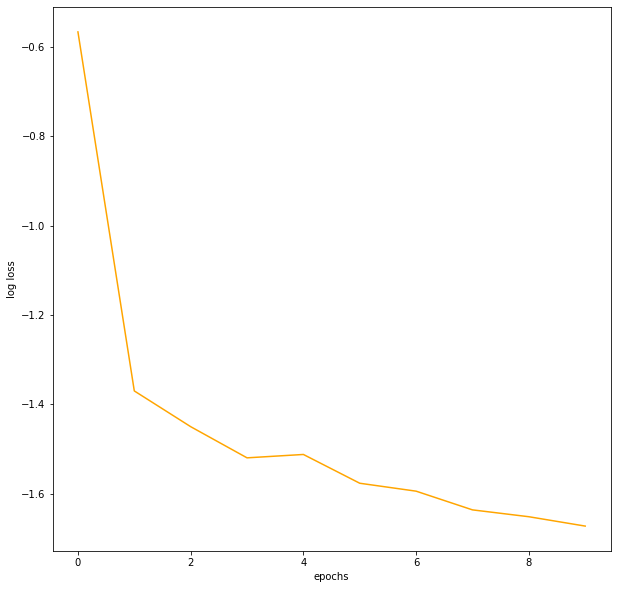

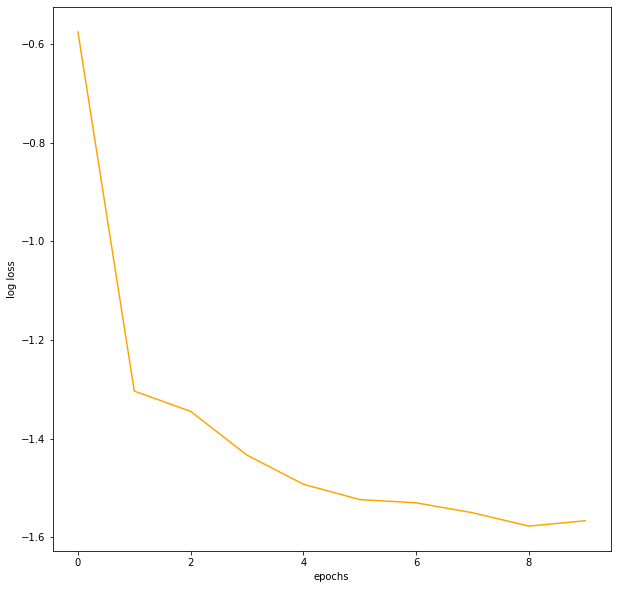

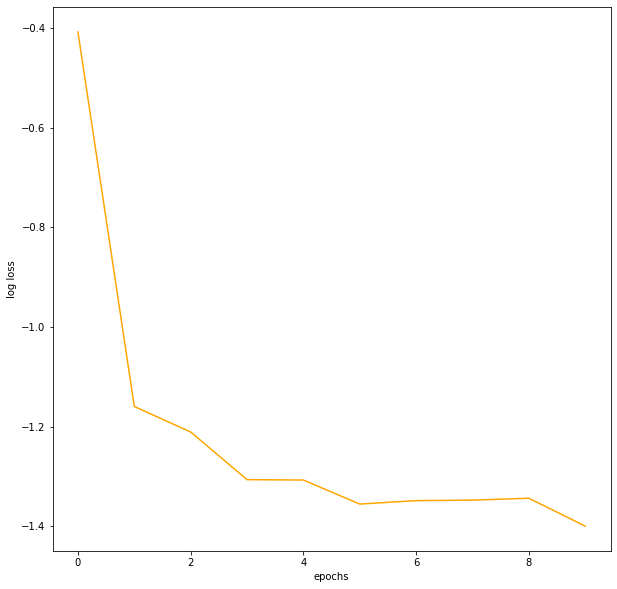

In [7]:
lrs = 10**torch.linspace(-4,-2,100)
lossesl=[]
for lr in tqdm(lrs):
    print('lr=',lr)
    modellr = Model(28*28, 500, 10,1, [0,0,0,0,0],0,False)
    lossl=modellr.train(train_dl,epochs = 10, learning_rate=lr,lam=0)
    lossl=torch.tensor(lossl).exp()
    lossesl.append(min(lossl).item())

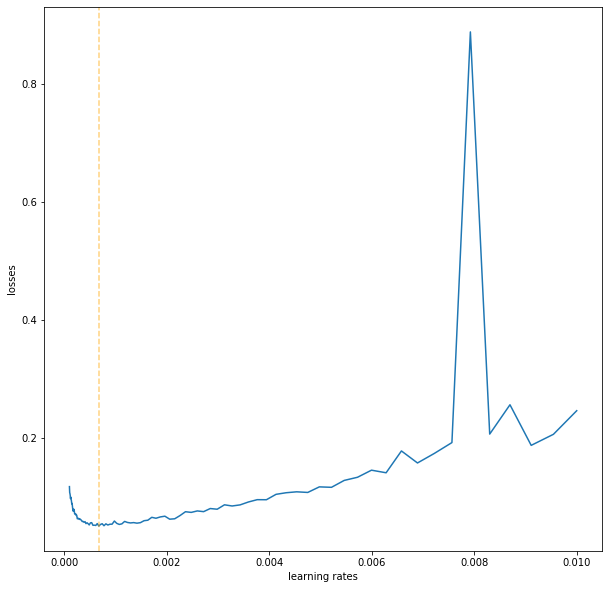

In [8]:
## lr vs losses:
optimal_lr = lrs[lossesl.index(min(lossesl))]
plt.figure(figsize=(10,10))
plt.plot(lrs,torch.tensor(lossesl))
plt.xlabel('learning rates')
plt.ylabel('losses')
plt.axvline(x=optimal_lr,color='orange',linestyle='--',alpha=0.5)

In [9]:
print('optimal learning rate: \n',optimal_lr.item())
print('least training loss',min(lossesl))

optimal learning rate: 
 0.0006734147318638861
least training loss 0.050834037363529205


### Expectations:
The objective was to try to get the learning rate which gives the least training error within a short span of training (10 epochs). 
The expectation was that the lower learning rates will be updating the model at a very slow rate and hence won't be able to converge to a descent loss value within 10 epochs and if the learning rate was too high it wont converge at all as the weights will keep oscillating, thereby giving a U shapped curve.

### Observations:
The obtained curve is a U shapped curve (considering the exponential scale spacing between the learning rates) giving lowest training error at a learning rate of <b>0.00115</b> with training loss of <b>0.0509</b>.





### 2. correct regularization coefficient (lambda) 

Taking the optimal learning rate we now move on with similar experimental setup to find the optimal regularisation term. We test regularisation value between 0.0001 and 0.01. The spacing between the terms are again not linear and are based on exponential scale.

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

epoch: 0 loss: 0.4293585419654846
epoch: 1 loss: 0.20434892177581787
epoch: 2 loss: 0.14299586415290833
epoch: 3 loss: 0.11663222312927246
epoch: 4 loss: 0.09971503913402557
epoch: 5 loss: 0.08342413604259491
epoch: 6 loss: 0.07788243889808655
epoch: 7 loss: 0.06997621059417725
epoch: 8 loss: 0.05990080535411835
epoch: 9 loss: 0.059773851186037064
0.07834238199299036


  1%|▊                                                                              | 1/100 [02:42<4:28:05, 162.48s/it]

epoch: 0 loss: 0.44438913464546204
epoch: 1 loss: 0.20502649247646332
epoch: 2 loss: 0.14361345767974854
epoch: 3 loss: 0.11601251363754272
epoch: 4 loss: 0.09470734000205994
epoch: 5 loss: 0.08576501905918121
epoch: 6 loss: 0.07398869097232819
epoch: 7 loss: 0.06797564774751663
epoch: 8 loss: 0.06589917838573456
epoch: 9 loss: 0.05830187350511551
0.09127076368048033


  2%|█▌                                                                             | 2/100 [05:24<4:24:59, 162.24s/it]

epoch: 0 loss: 0.4354010224342346
epoch: 1 loss: 0.20846539735794067
epoch: 2 loss: 0.14993026852607727
epoch: 3 loss: 0.11935985088348389
epoch: 4 loss: 0.0985860601067543
epoch: 5 loss: 0.08857601881027222
epoch: 6 loss: 0.07594292610883713
epoch: 7 loss: 0.07177562266588211
epoch: 8 loss: 0.06124766170978546
epoch: 9 loss: 0.05820460617542267
0.08228415611444655


  3%|██▎                                                                            | 3/100 [08:10<4:24:19, 163.50s/it]

epoch: 0 loss: 0.4387572407722473
epoch: 1 loss: 0.2073916792869568
epoch: 2 loss: 0.14887084066867828
epoch: 3 loss: 0.12069536745548248
epoch: 4 loss: 0.10617280751466751
epoch: 5 loss: 0.08754193037748337
epoch: 6 loss: 0.07792061567306519
epoch: 7 loss: 0.07135194540023804
epoch: 8 loss: 0.06411346793174744
epoch: 9 loss: 0.05851065367460251
0.07124131550582102


  4%|███▏                                                                           | 4/100 [10:55<4:22:03, 163.78s/it]

epoch: 0 loss: 0.44115597009658813
epoch: 1 loss: 0.20221585035324097
epoch: 2 loss: 0.1436324119567871
epoch: 3 loss: 0.11941046267747879
epoch: 4 loss: 0.10246400535106659
epoch: 5 loss: 0.08488322049379349
epoch: 6 loss: 0.07418855279684067
epoch: 7 loss: 0.06710807979106903
epoch: 8 loss: 0.062193747609853745
epoch: 9 loss: 0.058025699108839035
0.08002975568708763


  5%|███▉                                                                           | 5/100 [13:44<4:21:54, 165.42s/it]

epoch: 0 loss: 0.4347335398197174
epoch: 1 loss: 0.20636796951293945
epoch: 2 loss: 0.14483685791492462
epoch: 3 loss: 0.11899734288454056
epoch: 4 loss: 0.09996207058429718
epoch: 5 loss: 0.08772551268339157
epoch: 6 loss: 0.08115556091070175
epoch: 7 loss: 0.07199087738990784
epoch: 8 loss: 0.06553614884614944
epoch: 9 loss: 0.05669350177049637
0.08218427884754949


  6%|████▋                                                                          | 6/100 [16:31<4:19:47, 165.82s/it]

epoch: 0 loss: 0.44782203435897827
epoch: 1 loss: 0.2135971039533615
epoch: 2 loss: 0.1526453197002411
epoch: 3 loss: 0.12010041624307632
epoch: 4 loss: 0.1066068485379219
epoch: 5 loss: 0.0920831710100174
epoch: 6 loss: 0.08171309530735016
epoch: 7 loss: 0.07390028238296509
epoch: 8 loss: 0.06757065653800964
epoch: 9 loss: 0.06157601252198219
0.07464760290665104


  7%|█████▌                                                                         | 7/100 [19:18<4:17:36, 166.20s/it]

epoch: 0 loss: 0.43706226348876953
epoch: 1 loss: 0.20805223286151886
epoch: 2 loss: 0.14976125955581665
epoch: 3 loss: 0.11907725781202316
epoch: 4 loss: 0.09892213344573975
epoch: 5 loss: 0.0866955816745758
epoch: 6 loss: 0.07958915829658508
epoch: 7 loss: 0.07077512890100479
epoch: 8 loss: 0.06888465583324432
epoch: 9 loss: 0.0591595284640789
0.0882989825324238


  8%|██████▎                                                                        | 8/100 [22:06<4:15:49, 166.84s/it]

epoch: 0 loss: 0.4339306056499481
epoch: 1 loss: 0.20154008269309998
epoch: 2 loss: 0.14649765193462372
epoch: 3 loss: 0.11770614236593246
epoch: 4 loss: 0.09803741425275803
epoch: 5 loss: 0.08853547275066376
epoch: 6 loss: 0.07891659438610077
epoch: 7 loss: 0.07218983769416809
epoch: 8 loss: 0.06512550264596939
epoch: 9 loss: 0.05998983234167099
0.06918465151691727


  9%|███████                                                                        | 9/100 [24:50<4:11:33, 165.86s/it]

epoch: 0 loss: 0.43774309754371643
epoch: 1 loss: 0.2056725174188614
epoch: 2 loss: 0.14914564788341522
epoch: 3 loss: 0.11901971697807312
epoch: 4 loss: 0.10144441574811935
epoch: 5 loss: 0.08662856370210648
epoch: 6 loss: 0.07786104828119278
epoch: 7 loss: 0.07233088463544846
epoch: 8 loss: 0.06509459763765335
epoch: 9 loss: 0.059785373508930206
0.08829420352652315


 10%|███████▊                                                                      | 10/100 [27:35<4:08:32, 165.70s/it]

epoch: 0 loss: 0.43768396973609924
epoch: 1 loss: 0.2076883316040039
epoch: 2 loss: 0.15019485354423523
epoch: 3 loss: 0.11861541867256165
epoch: 4 loss: 0.10255714505910873
epoch: 5 loss: 0.08757492154836655
epoch: 6 loss: 0.0793059915304184
epoch: 7 loss: 0.06835789233446121
epoch: 8 loss: 0.06417489051818848
epoch: 9 loss: 0.06207209452986717
0.07258130114339882


 11%|████████▌                                                                     | 11/100 [30:19<4:05:08, 165.26s/it]

epoch: 0 loss: 0.4397524297237396
epoch: 1 loss: 0.2098638117313385
epoch: 2 loss: 0.15083809196949005
epoch: 3 loss: 0.11940085887908936
epoch: 4 loss: 0.10554628074169159
epoch: 5 loss: 0.08947049826383591
epoch: 6 loss: 0.08295341581106186
epoch: 7 loss: 0.07279792428016663
epoch: 8 loss: 0.06677026301622391
epoch: 9 loss: 0.060897327959537506
0.08004383271161461


 12%|█████████▎                                                                    | 12/100 [33:03<4:01:49, 164.88s/it]

epoch: 0 loss: 0.43160685896873474
epoch: 1 loss: 0.20107340812683105
epoch: 2 loss: 0.14676737785339355
epoch: 3 loss: 0.1218014806509018
epoch: 4 loss: 0.1002047210931778
epoch: 5 loss: 0.08636419475078583
epoch: 6 loss: 0.08071478456258774
epoch: 7 loss: 0.07127630710601807
epoch: 8 loss: 0.06340436637401581
epoch: 9 loss: 0.05911673605442047
0.08247806171516746


 13%|██████████▏                                                                   | 13/100 [35:46<3:58:19, 164.36s/it]

epoch: 0 loss: 0.4244479537010193
epoch: 1 loss: 0.20522278547286987
epoch: 2 loss: 0.14883776009082794
epoch: 3 loss: 0.12015509605407715
epoch: 4 loss: 0.09914887696504593
epoch: 5 loss: 0.08976732939481735
epoch: 6 loss: 0.07498902082443237
epoch: 7 loss: 0.07245416939258575
epoch: 8 loss: 0.06758017838001251
epoch: 9 loss: 0.058831796050071716
0.08764485512138787


 14%|██████████▉                                                                   | 14/100 [38:27<3:53:55, 163.20s/it]

epoch: 0 loss: 0.43682125210762024
epoch: 1 loss: 0.21144524216651917
epoch: 2 loss: 0.1511925607919693
epoch: 3 loss: 0.12176381796598434
epoch: 4 loss: 0.10171733796596527
epoch: 5 loss: 0.09046091139316559
epoch: 6 loss: 0.07970474660396576
epoch: 7 loss: 0.07260743528604507
epoch: 8 loss: 0.06733318418264389
epoch: 9 loss: 0.06019376218318939
0.07709119958940104


 15%|███████████▋                                                                  | 15/100 [41:14<3:52:51, 164.37s/it]

epoch: 0 loss: 0.4320037066936493
epoch: 1 loss: 0.2096833884716034
epoch: 2 loss: 0.15240933001041412
epoch: 3 loss: 0.12239546328783035
epoch: 4 loss: 0.10436996817588806
epoch: 5 loss: 0.09035729616880417
epoch: 6 loss: 0.08340328931808472
epoch: 7 loss: 0.07440955191850662
epoch: 8 loss: 0.06877099722623825
epoch: 9 loss: 0.06311628222465515
0.08208780415294267


 16%|████████████▍                                                                 | 16/100 [44:06<3:53:15, 166.62s/it]

epoch: 0 loss: 0.44517600536346436
epoch: 1 loss: 0.20537841320037842
epoch: 2 loss: 0.15041790902614594
epoch: 3 loss: 0.11990085244178772
epoch: 4 loss: 0.1065206304192543
epoch: 5 loss: 0.09286122769117355
epoch: 6 loss: 0.08025234937667847
epoch: 7 loss: 0.07271040230989456
epoch: 8 loss: 0.07078270614147186
epoch: 9 loss: 0.0649426281452179
0.10005063528881726


 17%|█████████████▎                                                                | 17/100 [46:46<3:47:58, 164.80s/it]

epoch: 0 loss: 0.4400045573711395
epoch: 1 loss: 0.20741115510463715
epoch: 2 loss: 0.147210955619812
epoch: 3 loss: 0.12242543697357178
epoch: 4 loss: 0.10353638231754303
epoch: 5 loss: 0.09142044186592102
epoch: 6 loss: 0.07781200110912323
epoch: 7 loss: 0.07301076501607895
epoch: 8 loss: 0.06655444949865341
epoch: 9 loss: 0.0629941001534462
0.08398992791267176


 18%|██████████████                                                                | 18/100 [49:32<3:45:44, 165.17s/it]

epoch: 0 loss: 0.44120538234710693
epoch: 1 loss: 0.21195641160011292
epoch: 2 loss: 0.15438133478164673
epoch: 3 loss: 0.12400900572538376
epoch: 4 loss: 0.10452567040920258
epoch: 5 loss: 0.09205630421638489
epoch: 6 loss: 0.08261093497276306
epoch: 7 loss: 0.07423984259366989
epoch: 8 loss: 0.07134661823511124
epoch: 9 loss: 0.0630698874592781
0.07919657172427419


 19%|██████████████▊                                                               | 19/100 [52:20<3:43:48, 165.79s/it]

epoch: 0 loss: 0.43532538414001465
epoch: 1 loss: 0.2017596811056137
epoch: 2 loss: 0.14709602296352386
epoch: 3 loss: 0.12399541586637497
epoch: 4 loss: 0.10254349559545517
epoch: 5 loss: 0.0901644304394722
epoch: 6 loss: 0.08473803102970123
epoch: 7 loss: 0.0735774040222168
epoch: 8 loss: 0.06964040547609329
epoch: 9 loss: 0.06339780986309052
0.08034559176156085


 20%|███████████████▌                                                              | 20/100 [55:04<3:40:30, 165.38s/it]

epoch: 0 loss: 0.44002771377563477
epoch: 1 loss: 0.2021609991788864
epoch: 2 loss: 0.146922767162323
epoch: 3 loss: 0.11849096417427063
epoch: 4 loss: 0.10220862925052643
epoch: 5 loss: 0.09089449793100357
epoch: 6 loss: 0.08299779891967773
epoch: 7 loss: 0.07398428022861481
epoch: 8 loss: 0.07026577740907669
epoch: 9 loss: 0.0653926357626915


C:\Users\Asus\Anaconda3\lib\site-packages\ipykernel_launcher.py:73: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


0.07683557818833107


 21%|████████████████▍                                                             | 21/100 [57:51<3:38:18, 165.80s/it]

epoch: 0 loss: 0.4448269307613373
epoch: 1 loss: 0.2115565985441208
epoch: 2 loss: 0.15347447991371155
epoch: 3 loss: 0.12431702017784119
epoch: 4 loss: 0.10620425641536713
epoch: 5 loss: 0.0943668782711029
epoch: 6 loss: 0.08547528088092804
epoch: 7 loss: 0.07567677646875381
epoch: 8 loss: 0.06843800097703934
epoch: 9 loss: 0.06372889876365662
0.07037356359013976


 22%|████████████████▋                                                           | 22/100 [1:00:37<3:35:53, 166.07s/it]

epoch: 0 loss: 0.4449109137058258
epoch: 1 loss: 0.20769883692264557
epoch: 2 loss: 0.1520334780216217
epoch: 3 loss: 0.12104914337396622
epoch: 4 loss: 0.10632394254207611
epoch: 5 loss: 0.09448446333408356
epoch: 6 loss: 0.08301514387130737
epoch: 7 loss: 0.07545305043458939
epoch: 8 loss: 0.07144878804683685
epoch: 9 loss: 0.0671343058347702
0.09249690941187164


 23%|█████████████████▍                                                          | 23/100 [1:03:17<3:30:34, 164.08s/it]

epoch: 0 loss: 0.448585569858551
epoch: 1 loss: 0.21748532354831696
epoch: 2 loss: 0.15501368045806885
epoch: 3 loss: 0.12209241837263107
epoch: 4 loss: 0.10505186766386032
epoch: 5 loss: 0.09510425478219986
epoch: 6 loss: 0.08417229354381561
epoch: 7 loss: 0.0792975127696991
epoch: 8 loss: 0.07199525833129883
epoch: 9 loss: 0.06541046500205994
0.09443541890330011


 24%|██████████████████▏                                                         | 24/100 [1:06:05<3:29:19, 165.26s/it]

epoch: 0 loss: 0.4451892375946045
epoch: 1 loss: 0.20795994997024536
epoch: 2 loss: 0.15316632390022278
epoch: 3 loss: 0.12330299615859985
epoch: 4 loss: 0.10924389958381653
epoch: 5 loss: 0.0943102091550827
epoch: 6 loss: 0.08496838808059692
epoch: 7 loss: 0.08122989535331726
epoch: 8 loss: 0.07153666764497757
epoch: 9 loss: 0.06614261120557785
0.08614319200477197


 25%|███████████████████                                                         | 25/100 [1:08:49<3:26:01, 164.83s/it]

epoch: 0 loss: 0.45185258984565735
epoch: 1 loss: 0.21876591444015503
epoch: 2 loss: 0.16017577052116394
epoch: 3 loss: 0.1284964233636856
epoch: 4 loss: 0.11098816990852356
epoch: 5 loss: 0.09975636005401611
epoch: 6 loss: 0.08954741805791855
epoch: 7 loss: 0.08104535192251205
epoch: 8 loss: 0.07482520490884781
epoch: 9 loss: 0.06953741610050201
0.08018862620869922


 26%|███████████████████▊                                                        | 26/100 [1:11:39<3:25:13, 166.40s/it]

epoch: 0 loss: 0.4417960047721863
epoch: 1 loss: 0.2127930223941803
epoch: 2 loss: 0.15649595856666565
epoch: 3 loss: 0.12753023207187653
epoch: 4 loss: 0.11060094833374023
epoch: 5 loss: 0.09635225683450699
epoch: 6 loss: 0.08691906183958054
epoch: 7 loss: 0.08047512173652649
epoch: 8 loss: 0.07346037030220032
epoch: 9 loss: 0.07033107429742813
0.07122822877707084


 27%|████████████████████▌                                                       | 27/100 [1:14:20<3:20:44, 164.99s/it]

epoch: 0 loss: 0.45095294713974
epoch: 1 loss: 0.21757465600967407
epoch: 2 loss: 0.15629254281520844
epoch: 3 loss: 0.12839317321777344
epoch: 4 loss: 0.1095174103975296
epoch: 5 loss: 0.09748713672161102
epoch: 6 loss: 0.08749227225780487
epoch: 7 loss: 0.07968093454837799
epoch: 8 loss: 0.07376938313245773
epoch: 9 loss: 0.07080066949129105
0.07939864406096926


 28%|█████████████████████▎                                                      | 28/100 [1:17:06<3:18:02, 165.04s/it]

epoch: 0 loss: 0.45204466581344604
epoch: 1 loss: 0.21758414804935455
epoch: 2 loss: 0.15709401667118073
epoch: 3 loss: 0.1268419325351715
epoch: 4 loss: 0.1087113469839096
epoch: 5 loss: 0.09650056809186935
epoch: 6 loss: 0.08940395712852478
epoch: 7 loss: 0.07945966720581055
epoch: 8 loss: 0.07403303682804108
epoch: 9 loss: 0.06918658316135406
0.09158424624681025


 29%|██████████████████████                                                      | 29/100 [1:19:53<3:16:14, 165.84s/it]

epoch: 0 loss: 0.4461594521999359
epoch: 1 loss: 0.21296550333499908
epoch: 2 loss: 0.15603013336658478
epoch: 3 loss: 0.12771272659301758
epoch: 4 loss: 0.1109914630651474
epoch: 5 loss: 0.09564374387264252
epoch: 6 loss: 0.08768738061189651
epoch: 7 loss: 0.08141183853149414
epoch: 8 loss: 0.07529330253601074
epoch: 9 loss: 0.07117749750614166
0.07181723653913558


 30%|██████████████████████▊                                                     | 30/100 [1:22:38<3:12:56, 165.38s/it]

epoch: 0 loss: 0.44274502992630005
epoch: 1 loss: 0.21250216662883759
epoch: 2 loss: 0.1578223556280136
epoch: 3 loss: 0.12644384801387787
epoch: 4 loss: 0.11008571833372116
epoch: 5 loss: 0.09762659668922424
epoch: 6 loss: 0.0879703164100647
epoch: 7 loss: 0.08140438795089722
epoch: 8 loss: 0.07654695957899094
epoch: 9 loss: 0.07247037440538406
0.0743495893452458


 31%|███████████████████████▌                                                    | 31/100 [1:25:28<3:11:44, 166.74s/it]

epoch: 0 loss: 0.44413381814956665
epoch: 1 loss: 0.21241521835327148
epoch: 2 loss: 0.16306225955486298
epoch: 3 loss: 0.12786658108234406
epoch: 4 loss: 0.11193127930164337
epoch: 5 loss: 0.1004076600074768
epoch: 6 loss: 0.0913703665137291
epoch: 7 loss: 0.0833878293633461
epoch: 8 loss: 0.07657209783792496
epoch: 9 loss: 0.07221507281064987
0.09021122796944331


 32%|████████████████████████▎                                                   | 32/100 [1:28:12<3:08:13, 166.08s/it]

epoch: 0 loss: 0.44435474276542664
epoch: 1 loss: 0.21223367750644684
epoch: 2 loss: 0.15849055349826813
epoch: 3 loss: 0.1327659636735916
epoch: 4 loss: 0.11167144775390625
epoch: 5 loss: 0.10031076520681381
epoch: 6 loss: 0.09214106947183609
epoch: 7 loss: 0.08620123565196991
epoch: 8 loss: 0.07943197339773178
epoch: 9 loss: 0.0753413662314415
0.07688348172869845


 33%|█████████████████████████                                                   | 33/100 [1:30:56<3:04:43, 165.43s/it]

epoch: 0 loss: 0.4540974199771881
epoch: 1 loss: 0.21634513139724731
epoch: 2 loss: 0.1620206981897354
epoch: 3 loss: 0.13148492574691772
epoch: 4 loss: 0.11239326000213623
epoch: 5 loss: 0.10139233618974686
epoch: 6 loss: 0.0937817320227623
epoch: 7 loss: 0.08449768275022507
epoch: 8 loss: 0.08006129413843155
epoch: 9 loss: 0.07132019102573395
0.07697824851898595


 34%|█████████████████████████▊                                                  | 34/100 [1:33:46<3:03:19, 166.65s/it]

epoch: 0 loss: 0.4436686038970947
epoch: 1 loss: 0.21528765559196472
epoch: 2 loss: 0.15858542919158936
epoch: 3 loss: 0.13313986361026764
epoch: 4 loss: 0.11302734166383743
epoch: 5 loss: 0.10108517110347748
epoch: 6 loss: 0.09442897886037827
epoch: 7 loss: 0.08431173115968704
epoch: 8 loss: 0.0796794667840004
epoch: 9 loss: 0.0738167092204094
0.07711770242784478


 35%|██████████████████████████▌                                                 | 35/100 [1:36:35<3:01:21, 167.41s/it]

epoch: 0 loss: 0.44042715430259705
epoch: 1 loss: 0.21913880109786987
epoch: 2 loss: 0.16053971648216248
epoch: 3 loss: 0.13071893155574799
epoch: 4 loss: 0.11349157989025116
epoch: 5 loss: 0.10484585911035538
epoch: 6 loss: 0.09487312287092209
epoch: 7 loss: 0.0893184170126915
epoch: 8 loss: 0.0825662687420845
epoch: 9 loss: 0.07605626434087753
0.07420100833810984


 36%|███████████████████████████▎                                                | 36/100 [1:39:20<2:57:54, 166.80s/it]

epoch: 0 loss: 0.45643433928489685
epoch: 1 loss: 0.22249248623847961
epoch: 2 loss: 0.1611119508743286
epoch: 3 loss: 0.13153880834579468
epoch: 4 loss: 0.11857101321220398
epoch: 5 loss: 0.1039186418056488
epoch: 6 loss: 0.0955098420381546
epoch: 7 loss: 0.08719188719987869
epoch: 8 loss: 0.08002477139234543
epoch: 9 loss: 0.07760273665189743
0.0792031570697274


 37%|████████████████████████████                                                | 37/100 [1:42:12<2:56:37, 168.22s/it]

epoch: 0 loss: 0.45168930292129517
epoch: 1 loss: 0.2164035588502884
epoch: 2 loss: 0.15862785279750824
epoch: 3 loss: 0.13712742924690247
epoch: 4 loss: 0.1154157742857933
epoch: 5 loss: 0.10542389750480652
epoch: 6 loss: 0.09718205034732819
epoch: 7 loss: 0.08863477408885956
epoch: 8 loss: 0.08236688375473022
epoch: 9 loss: 0.0790095329284668
0.07910268664171424


 38%|████████████████████████████▉                                               | 38/100 [1:44:59<2:53:35, 167.99s/it]

epoch: 0 loss: 0.44223082065582275
epoch: 1 loss: 0.22131186723709106
epoch: 2 loss: 0.16314662992954254
epoch: 3 loss: 0.13627119362354279
epoch: 4 loss: 0.11766602098941803
epoch: 5 loss: 0.10517782717943192
epoch: 6 loss: 0.09510193020105362
epoch: 7 loss: 0.08993440121412277
epoch: 8 loss: 0.0823153704404831
epoch: 9 loss: 0.07678607851266861
0.10458261865342944


 39%|█████████████████████████████▋                                              | 39/100 [1:47:46<2:50:33, 167.76s/it]

epoch: 0 loss: 0.4505090117454529
epoch: 1 loss: 0.21768076717853546
epoch: 2 loss: 0.15848132967948914
epoch: 3 loss: 0.13619616627693176
epoch: 4 loss: 0.11901996284723282
epoch: 5 loss: 0.10366102308034897
epoch: 6 loss: 0.09498506039381027
epoch: 7 loss: 0.09080009907484055
epoch: 8 loss: 0.08803308010101318
epoch: 9 loss: 0.0806308388710022
0.07368418077541856


 40%|██████████████████████████████▍                                             | 40/100 [1:50:39<2:49:22, 169.38s/it]

epoch: 0 loss: 0.45860031247138977
epoch: 1 loss: 0.22461211681365967
epoch: 2 loss: 0.16372260451316833
epoch: 3 loss: 0.1357361227273941
epoch: 4 loss: 0.11840285360813141
epoch: 5 loss: 0.1078873723745346
epoch: 6 loss: 0.0981699526309967
epoch: 7 loss: 0.09439119696617126
epoch: 8 loss: 0.08840767294168472
epoch: 9 loss: 0.083201564848423
0.07993388278380366


 41%|███████████████████████████████▏                                            | 41/100 [1:53:27<2:45:54, 168.71s/it]

epoch: 0 loss: 0.45352810621261597
epoch: 1 loss: 0.22190341353416443
epoch: 2 loss: 0.16513341665267944
epoch: 3 loss: 0.13471464812755585
epoch: 4 loss: 0.12139090895652771
epoch: 5 loss: 0.10775143653154373
epoch: 6 loss: 0.10111469775438309
epoch: 7 loss: 0.0923769474029541
epoch: 8 loss: 0.08563908189535141
epoch: 9 loss: 0.0837286040186882
0.07750421932346226


 42%|███████████████████████████████▉                                            | 42/100 [1:56:13<2:42:20, 167.93s/it]

epoch: 0 loss: 0.45369574427604675
epoch: 1 loss: 0.22417111694812775
epoch: 2 loss: 0.16840635240077972
epoch: 3 loss: 0.14087197184562683
epoch: 4 loss: 0.12215305864810944
epoch: 5 loss: 0.1099858507514
epoch: 6 loss: 0.10303317755460739
epoch: 7 loss: 0.09446991235017776
epoch: 8 loss: 0.08757207542657852
epoch: 9 loss: 0.08408842980861664
0.08983196772906128


 43%|████████████████████████████████▋                                           | 43/100 [1:58:57<2:38:28, 166.82s/it]

epoch: 0 loss: 0.46249353885650635
epoch: 1 loss: 0.22539211809635162
epoch: 2 loss: 0.16700837016105652
epoch: 3 loss: 0.1447622925043106
epoch: 4 loss: 0.11990304291248322
epoch: 5 loss: 0.11452911049127579
epoch: 6 loss: 0.10230594873428345
epoch: 7 loss: 0.09316889941692352
epoch: 8 loss: 0.09065631031990051
epoch: 9 loss: 0.08426587283611298
0.07649651105601128


 44%|█████████████████████████████████▍                                          | 44/100 [2:01:47<2:36:37, 167.81s/it]

epoch: 0 loss: 0.45878735184669495
epoch: 1 loss: 0.22340357303619385
epoch: 2 loss: 0.172260120511055
epoch: 3 loss: 0.14285120368003845
epoch: 4 loss: 0.12557865679264069
epoch: 5 loss: 0.11255335062742233
epoch: 6 loss: 0.10338391363620758
epoch: 7 loss: 0.09825078397989273
epoch: 8 loss: 0.09224888682365417
epoch: 9 loss: 0.08671559393405914
0.080133268915049


 45%|██████████████████████████████████▏                                         | 45/100 [2:04:38<2:34:38, 168.70s/it]

epoch: 0 loss: 0.4509771466255188
epoch: 1 loss: 0.22672255337238312
epoch: 2 loss: 0.17235496640205383
epoch: 3 loss: 0.14013457298278809
epoch: 4 loss: 0.12833166122436523
epoch: 5 loss: 0.11466291546821594
epoch: 6 loss: 0.1055256724357605
epoch: 7 loss: 0.10182733088731766
epoch: 8 loss: 0.0947631448507309
epoch: 9 loss: 0.09046663343906403
0.08064161366422047


 46%|██████████████████████████████████▉                                         | 46/100 [2:07:25<2:31:19, 168.13s/it]

epoch: 0 loss: 0.4519115090370178
epoch: 1 loss: 0.22560593485832214
epoch: 2 loss: 0.16958142817020416
epoch: 3 loss: 0.14261992275714874
epoch: 4 loss: 0.1245398297905922
epoch: 5 loss: 0.11293251067399979
epoch: 6 loss: 0.10331427305936813
epoch: 7 loss: 0.09713693708181381
epoch: 8 loss: 0.09260064363479614
epoch: 9 loss: 0.08937017619609833
0.08842484820250987


 47%|███████████████████████████████████▋                                        | 47/100 [2:10:11<2:28:07, 167.68s/it]

epoch: 0 loss: 0.4630204141139984
epoch: 1 loss: 0.22566381096839905
epoch: 2 loss: 0.17323586344718933
epoch: 3 loss: 0.14385591447353363
epoch: 4 loss: 0.1268233358860016
epoch: 5 loss: 0.11612234264612198
epoch: 6 loss: 0.10833483189344406
epoch: 7 loss: 0.1015089899301529
epoch: 8 loss: 0.09629380702972412
epoch: 9 loss: 0.09212401509284973
0.08117600352005279


 48%|████████████████████████████████████▍                                       | 48/100 [2:12:56<2:24:40, 166.94s/it]

epoch: 0 loss: 0.4661078453063965
epoch: 1 loss: 0.22952042520046234
epoch: 2 loss: 0.17070859670639038
epoch: 3 loss: 0.14564421772956848
epoch: 4 loss: 0.12984570860862732
epoch: 5 loss: 0.11494562774896622
epoch: 6 loss: 0.1063847541809082
epoch: 7 loss: 0.10150288045406342
epoch: 8 loss: 0.09859452396631241
epoch: 9 loss: 0.09347624331712723
0.08162926395660962


 49%|█████████████████████████████████████▏                                      | 49/100 [2:15:45<2:22:14, 167.34s/it]

epoch: 0 loss: 0.4614296555519104
epoch: 1 loss: 0.22823792695999146
epoch: 2 loss: 0.17353174090385437
epoch: 3 loss: 0.1455880105495453
epoch: 4 loss: 0.1283731907606125
epoch: 5 loss: 0.12056819349527359
epoch: 6 loss: 0.10976763814687729
epoch: 7 loss: 0.1050732359290123
epoch: 8 loss: 0.09945764392614365
epoch: 9 loss: 0.09694580733776093
0.07456162023981384


 50%|██████████████████████████████████████                                      | 50/100 [2:18:33<2:19:47, 167.74s/it]

epoch: 0 loss: 0.4574127197265625
epoch: 1 loss: 0.22889158129692078
epoch: 2 loss: 0.17334924638271332
epoch: 3 loss: 0.14641259610652924
epoch: 4 loss: 0.13444577157497406
epoch: 5 loss: 0.12097402662038803
epoch: 6 loss: 0.11152731627225876
epoch: 7 loss: 0.10724994540214539
epoch: 8 loss: 0.10022832453250885
epoch: 9 loss: 0.09818040579557419
0.08355428153410248


 51%|██████████████████████████████████████▊                                     | 51/100 [2:21:17<2:16:02, 166.58s/it]

epoch: 0 loss: 0.46052080392837524
epoch: 1 loss: 0.23889876902103424
epoch: 2 loss: 0.17801573872566223
epoch: 3 loss: 0.15047316253185272
epoch: 4 loss: 0.13534855842590332
epoch: 5 loss: 0.12567685544490814
epoch: 6 loss: 0.11496388167142868
epoch: 7 loss: 0.10825207829475403
epoch: 8 loss: 0.10473804175853729
epoch: 9 loss: 0.09927792847156525
0.07414822836326954


 52%|███████████████████████████████████████▌                                    | 52/100 [2:24:05<2:13:33, 166.95s/it]

epoch: 0 loss: 0.46303418278694153
epoch: 1 loss: 0.2320367991924286
epoch: 2 loss: 0.1772117018699646
epoch: 3 loss: 0.15312467515468597
epoch: 4 loss: 0.1342802196741104
epoch: 5 loss: 0.1231677234172821
epoch: 6 loss: 0.11580085009336472
epoch: 7 loss: 0.10932524502277374
epoch: 8 loss: 0.10533105581998825
epoch: 9 loss: 0.09846740961074829
0.08304297239954371


 53%|████████████████████████████████████████▎                                   | 53/100 [2:26:51<2:10:26, 166.53s/it]

epoch: 0 loss: 0.47267988324165344
epoch: 1 loss: 0.24385742843151093
epoch: 2 loss: 0.18286094069480896
epoch: 3 loss: 0.15475572645664215
epoch: 4 loss: 0.1402641385793686
epoch: 5 loss: 0.12398305535316467
epoch: 6 loss: 0.11820655316114426
epoch: 7 loss: 0.11006652563810349
epoch: 8 loss: 0.10646995157003403
epoch: 9 loss: 0.10495509207248688
0.08376936346758157


 54%|█████████████████████████████████████████                                   | 54/100 [2:29:40<2:08:16, 167.31s/it]

epoch: 0 loss: 0.47550708055496216
epoch: 1 loss: 0.2391357570886612
epoch: 2 loss: 0.18400555849075317
epoch: 3 loss: 0.15550759434700012
epoch: 4 loss: 0.1392272412776947
epoch: 5 loss: 0.12733806669712067
epoch: 6 loss: 0.12065890431404114
epoch: 7 loss: 0.11285121738910675
epoch: 8 loss: 0.10819043964147568
epoch: 9 loss: 0.10119155049324036
0.1076903200547706


 55%|█████████████████████████████████████████▊                                  | 55/100 [2:32:28<2:05:45, 167.68s/it]

epoch: 0 loss: 0.46228668093681335
epoch: 1 loss: 0.2351847141981125
epoch: 2 loss: 0.1826508641242981
epoch: 3 loss: 0.15633049607276917
epoch: 4 loss: 0.1411382555961609
epoch: 5 loss: 0.1299053132534027
epoch: 6 loss: 0.1199556440114975
epoch: 7 loss: 0.11158280819654465
epoch: 8 loss: 0.11368491500616074
epoch: 9 loss: 0.10555686801671982
0.08159880782035474


 56%|██████████████████████████████████████████▌                                 | 56/100 [2:35:17<2:03:05, 167.85s/it]

epoch: 0 loss: 0.47002074122428894
epoch: 1 loss: 0.242845356464386
epoch: 2 loss: 0.184655100107193
epoch: 3 loss: 0.15542808175086975
epoch: 4 loss: 0.14070507884025574
epoch: 5 loss: 0.13105468451976776
epoch: 6 loss: 0.12321995198726654
epoch: 7 loss: 0.11846643686294556
epoch: 8 loss: 0.11205871403217316
epoch: 9 loss: 0.11017987132072449
0.07602951834140392


 57%|███████████████████████████████████████████▎                                | 57/100 [2:38:07<2:00:51, 168.64s/it]

epoch: 0 loss: 0.47385597229003906
epoch: 1 loss: 0.238991841673851
epoch: 2 loss: 0.18445660173892975
epoch: 3 loss: 0.16062110662460327
epoch: 4 loss: 0.14490029215812683
epoch: 5 loss: 0.13249781727790833
epoch: 6 loss: 0.1254155933856964
epoch: 7 loss: 0.11822143942117691
epoch: 8 loss: 0.11765912175178528
epoch: 9 loss: 0.10892385244369507
0.07686995739806915


 58%|████████████████████████████████████████████                                | 58/100 [2:40:54<1:57:43, 168.18s/it]

epoch: 0 loss: 0.4757130444049835
epoch: 1 loss: 0.2465629130601883
epoch: 2 loss: 0.19048526883125305
epoch: 3 loss: 0.16390593349933624
epoch: 4 loss: 0.14640820026397705
epoch: 5 loss: 0.13791608810424805
epoch: 6 loss: 0.12638773024082184
epoch: 7 loss: 0.12202624976634979
epoch: 8 loss: 0.11853644996881485
epoch: 9 loss: 0.11361110210418701
0.07819270542852251


 59%|████████████████████████████████████████████▊                               | 59/100 [2:43:40<1:54:23, 167.41s/it]

epoch: 0 loss: 0.4745115041732788
epoch: 1 loss: 0.2499481439590454
epoch: 2 loss: 0.19449448585510254
epoch: 3 loss: 0.1652139276266098
epoch: 4 loss: 0.14997988939285278
epoch: 5 loss: 0.14010263979434967
epoch: 6 loss: 0.12776245176792145
epoch: 7 loss: 0.12572522461414337
epoch: 8 loss: 0.11869116127490997
epoch: 9 loss: 0.11659710854291916
0.07103709041146868


 60%|█████████████████████████████████████████████▌                              | 60/100 [2:46:28<1:51:43, 167.59s/it]

epoch: 0 loss: 0.48005926609039307
epoch: 1 loss: 0.2497410774230957
epoch: 2 loss: 0.19417832791805267
epoch: 3 loss: 0.16776974499225616
epoch: 4 loss: 0.1491040736436844
epoch: 5 loss: 0.1406438797712326
epoch: 6 loss: 0.1347191482782364
epoch: 7 loss: 0.12752117216587067
epoch: 8 loss: 0.11870566010475159
epoch: 9 loss: 0.11957092583179474
0.07423816019812116


 61%|██████████████████████████████████████████████▎                             | 61/100 [2:49:15<1:48:56, 167.59s/it]

epoch: 0 loss: 0.4832027554512024
epoch: 1 loss: 0.2521045207977295
epoch: 2 loss: 0.19799531996250153
epoch: 3 loss: 0.1704591065645218
epoch: 4 loss: 0.15084509551525116
epoch: 5 loss: 0.14164812862873077
epoch: 6 loss: 0.1349829137325287
epoch: 7 loss: 0.1297740340232849
epoch: 8 loss: 0.12287148833274841
epoch: 9 loss: 0.12397243827581406
0.08046555861129272


 62%|███████████████████████████████████████████████                             | 62/100 [2:52:06<1:46:38, 168.37s/it]

epoch: 0 loss: 0.48878028988838196
epoch: 1 loss: 0.25474226474761963
epoch: 2 loss: 0.19735009968280792
epoch: 3 loss: 0.16932909190654755
epoch: 4 loss: 0.15925385057926178
epoch: 5 loss: 0.14637653529644012
epoch: 6 loss: 0.1358695924282074
epoch: 7 loss: 0.13164368271827698
epoch: 8 loss: 0.1285889744758606
epoch: 9 loss: 0.12192635238170624
0.08180480932557507


 63%|███████████████████████████████████████████████▉                            | 63/100 [2:54:55<1:43:59, 168.63s/it]

epoch: 0 loss: 0.48438549041748047
epoch: 1 loss: 0.2534957826137543
epoch: 2 loss: 0.1994001567363739
epoch: 3 loss: 0.17192292213439941
epoch: 4 loss: 0.15919607877731323
epoch: 5 loss: 0.14743301272392273
epoch: 6 loss: 0.14006827771663666
epoch: 7 loss: 0.13788297772407532
epoch: 8 loss: 0.12801192700862885
epoch: 9 loss: 0.12869027256965637
0.09757496259555433


 64%|████████████████████████████████████████████████▋                           | 64/100 [2:57:39<1:40:25, 167.39s/it]

epoch: 0 loss: 0.48187902569770813
epoch: 1 loss: 0.25803473591804504
epoch: 2 loss: 0.20580630004405975
epoch: 3 loss: 0.1798427402973175
epoch: 4 loss: 0.16264677047729492
epoch: 5 loss: 0.15243451297283173
epoch: 6 loss: 0.1445022076368332
epoch: 7 loss: 0.1420641392469406
epoch: 8 loss: 0.13450239598751068
epoch: 9 loss: 0.13158996403217316
0.08142997498647604


 65%|█████████████████████████████████████████████████▍                          | 65/100 [3:00:27<1:37:46, 167.61s/it]

epoch: 0 loss: 0.4841035008430481
epoch: 1 loss: 0.25759565830230713
epoch: 2 loss: 0.20664340257644653
epoch: 3 loss: 0.18086956441402435
epoch: 4 loss: 0.1620418131351471
epoch: 5 loss: 0.15322381258010864
epoch: 6 loss: 0.14514753222465515
epoch: 7 loss: 0.14100037515163422
epoch: 8 loss: 0.1397314816713333
epoch: 9 loss: 0.13363485038280487
0.07701361771633176


 66%|██████████████████████████████████████████████████▏                         | 66/100 [3:03:13<1:34:42, 167.14s/it]

epoch: 0 loss: 0.48140767216682434
epoch: 1 loss: 0.25690701603889465
epoch: 2 loss: 0.2066512107849121
epoch: 3 loss: 0.17801614105701447
epoch: 4 loss: 0.16809509694576263
epoch: 5 loss: 0.15817643702030182
epoch: 6 loss: 0.15229308605194092
epoch: 7 loss: 0.14392396807670593
epoch: 8 loss: 0.14070990681648254
epoch: 9 loss: 0.13745450973510742
0.11116826786700919


 67%|██████████████████████████████████████████████████▉                         | 67/100 [3:05:57<1:31:15, 165.92s/it]

epoch: 0 loss: 0.4985926151275635
epoch: 1 loss: 0.26809847354888916
epoch: 2 loss: 0.2118622213602066
epoch: 3 loss: 0.18688452243804932
epoch: 4 loss: 0.1706070899963379
epoch: 5 loss: 0.1618993729352951
epoch: 6 loss: 0.15196283161640167
epoch: 7 loss: 0.1486898511648178
epoch: 8 loss: 0.14103396236896515
epoch: 9 loss: 0.1414327323436737
0.096924904651374


 68%|███████████████████████████████████████████████████▋                        | 68/100 [3:08:48<1:29:21, 167.54s/it]

epoch: 0 loss: 0.49158811569213867
epoch: 1 loss: 0.263069748878479
epoch: 2 loss: 0.2118077278137207
epoch: 3 loss: 0.1870567500591278
epoch: 4 loss: 0.17159250378608704
epoch: 5 loss: 0.1642741560935974
epoch: 6 loss: 0.1556723415851593
epoch: 7 loss: 0.14970511198043823
epoch: 8 loss: 0.14540763199329376
epoch: 9 loss: 0.14085496962070465
0.08540714760841447


 69%|████████████████████████████████████████████████████▍                       | 69/100 [3:11:35<1:26:27, 167.34s/it]

epoch: 0 loss: 0.5023545622825623
epoch: 1 loss: 0.2691021263599396
epoch: 2 loss: 0.21548210084438324
epoch: 3 loss: 0.19066715240478516
epoch: 4 loss: 0.17845416069030762
epoch: 5 loss: 0.17066815495491028
epoch: 6 loss: 0.16046853363513947
epoch: 7 loss: 0.15113553404808044
epoch: 8 loss: 0.14923572540283203
epoch: 9 loss: 0.14828108251094818
0.09894935848173697


 70%|█████████████████████████████████████████████████████▏                      | 70/100 [3:14:21<1:23:27, 166.92s/it]

epoch: 0 loss: 0.4974258840084076
epoch: 1 loss: 0.2692219913005829
epoch: 2 loss: 0.21662655472755432
epoch: 3 loss: 0.19191893935203552
epoch: 4 loss: 0.17853346467018127
epoch: 5 loss: 0.16767618060112
epoch: 6 loss: 0.1609995812177658
epoch: 7 loss: 0.15597717463970184
epoch: 8 loss: 0.1513933390378952
epoch: 9 loss: 0.14863961935043335
0.08770090870447221


 71%|█████████████████████████████████████████████████████▉                      | 71/100 [3:17:11<1:21:09, 167.92s/it]

epoch: 0 loss: 0.5163781046867371
epoch: 1 loss: 0.28446459770202637
epoch: 2 loss: 0.22696343064308167
epoch: 3 loss: 0.19460666179656982
epoch: 4 loss: 0.18182092905044556
epoch: 5 loss: 0.17024758458137512
epoch: 6 loss: 0.16197919845581055
epoch: 7 loss: 0.15755575895309448
epoch: 8 loss: 0.15352730453014374
epoch: 9 loss: 0.1493488997220993
0.07473783145358055


 72%|██████████████████████████████████████████████████████▋                     | 72/100 [3:20:01<1:18:41, 168.61s/it]

epoch: 0 loss: 0.5170175433158875
epoch: 1 loss: 0.27999475598335266
epoch: 2 loss: 0.22779761254787445
epoch: 3 loss: 0.2039763480424881
epoch: 4 loss: 0.18517352640628815
epoch: 5 loss: 0.18084309995174408
epoch: 6 loss: 0.16999182105064392
epoch: 7 loss: 0.16516129672527313
epoch: 8 loss: 0.15991337597370148
epoch: 9 loss: 0.154435396194458
0.08206860146034343


 73%|███████████████████████████████████████████████████████▍                    | 73/100 [3:22:49<1:15:47, 168.43s/it]

epoch: 0 loss: 0.5059103965759277
epoch: 1 loss: 0.27868324518203735
epoch: 2 loss: 0.22725215554237366
epoch: 3 loss: 0.2070648968219757
epoch: 4 loss: 0.18963032960891724
epoch: 5 loss: 0.18189215660095215
epoch: 6 loss: 0.17508743703365326
epoch: 7 loss: 0.16954593360424042
epoch: 8 loss: 0.16289260983467102
epoch: 9 loss: 0.16351783275604248
0.11457975462220515


 74%|████████████████████████████████████████████████████████▏                   | 74/100 [3:25:34<1:12:32, 167.39s/it]

epoch: 0 loss: 0.509860098361969
epoch: 1 loss: 0.2862839698791504
epoch: 2 loss: 0.23547278344631195
epoch: 3 loss: 0.21555708348751068
epoch: 4 loss: 0.19503799080848694
epoch: 5 loss: 0.1874019354581833
epoch: 6 loss: 0.17980550229549408
epoch: 7 loss: 0.17280162870883942
epoch: 8 loss: 0.1683027446269989
epoch: 9 loss: 0.1613827347755432
0.08885400805510345


 75%|█████████████████████████████████████████████████████████                   | 75/100 [3:28:21<1:09:44, 167.38s/it]

epoch: 0 loss: 0.5246755480766296
epoch: 1 loss: 0.29364094138145447
epoch: 2 loss: 0.23890645802021027
epoch: 3 loss: 0.21678562462329865
epoch: 4 loss: 0.1981251835823059
epoch: 5 loss: 0.1898735612630844
epoch: 6 loss: 0.18197132647037506
epoch: 7 loss: 0.17800961434841156
epoch: 8 loss: 0.17077197134494781
epoch: 9 loss: 0.16670852899551392
0.0814833078191533


 76%|█████████████████████████████████████████████████████████▊                  | 76/100 [3:31:12<1:07:23, 168.46s/it]

epoch: 0 loss: 0.5091495513916016
epoch: 1 loss: 0.2960945963859558
epoch: 2 loss: 0.24062317609786987
epoch: 3 loss: 0.21703575551509857
epoch: 4 loss: 0.20390312373638153
epoch: 5 loss: 0.19368067383766174
epoch: 6 loss: 0.186899334192276
epoch: 7 loss: 0.181840717792511
epoch: 8 loss: 0.17597201466560364
epoch: 9 loss: 0.1728329360485077
0.07076589216601953


 77%|██████████████████████████████████████████████████████████▌                 | 77/100 [3:33:59<1:04:20, 167.84s/it]

epoch: 0 loss: 0.5379859209060669
epoch: 1 loss: 0.2950643002986908
epoch: 2 loss: 0.24704140424728394
epoch: 3 loss: 0.2195388823747635
epoch: 4 loss: 0.20539365708827972
epoch: 5 loss: 0.1978112906217575
epoch: 6 loss: 0.1905204802751541
epoch: 7 loss: 0.18267974257469177
epoch: 8 loss: 0.1812732070684433
epoch: 9 loss: 0.17555251717567444
0.09373312270198064


 78%|███████████████████████████████████████████████████████████▎                | 78/100 [3:36:48<1:01:42, 168.29s/it]

epoch: 0 loss: 0.5307367444038391
epoch: 1 loss: 0.30039846897125244
epoch: 2 loss: 0.24406199157238007
epoch: 3 loss: 0.2221728265285492
epoch: 4 loss: 0.2102782130241394
epoch: 5 loss: 0.19882914423942566
epoch: 6 loss: 0.18931853771209717
epoch: 7 loss: 0.18920966982841492
epoch: 8 loss: 0.18159839510917664
epoch: 9 loss: 0.1779460310935974
0.0802889498800947


 79%|████████████████████████████████████████████████████████████                | 79/100 [3:40:00<1:01:24, 175.46s/it]

epoch: 0 loss: 0.5327096581459045
epoch: 1 loss: 0.30747395753860474
epoch: 2 loss: 0.2574501037597656
epoch: 3 loss: 0.231501504778862
epoch: 4 loss: 0.21360453963279724
epoch: 5 loss: 0.20996218919754028
epoch: 6 loss: 0.19837839901447296
epoch: 7 loss: 0.19422277808189392
epoch: 8 loss: 0.18679437041282654
epoch: 9 loss: 0.1832502782344818
0.08209166234901434


 80%|██████████████████████████████████████████████████████████████▍               | 80/100 [3:42:59<58:46, 176.31s/it]

epoch: 0 loss: 0.5374411940574646
epoch: 1 loss: 0.31439775228500366
epoch: 2 loss: 0.26463085412979126
epoch: 3 loss: 0.2394380271434784
epoch: 4 loss: 0.2217332124710083
epoch: 5 loss: 0.21241727471351624
epoch: 6 loss: 0.20258724689483643
epoch: 7 loss: 0.19929949939250946
epoch: 8 loss: 0.19385123252868652
epoch: 9 loss: 0.18947967886924744
0.10120439503041297


 81%|███████████████████████████████████████████████████████████████▏              | 81/100 [3:46:00<56:15, 177.67s/it]

epoch: 0 loss: 0.5393898487091064
epoch: 1 loss: 0.3197098970413208
epoch: 2 loss: 0.2700326442718506
epoch: 3 loss: 0.23687724769115448
epoch: 4 loss: 0.22495537996292114
epoch: 5 loss: 0.2164711058139801
epoch: 6 loss: 0.21034826338291168
epoch: 7 loss: 0.20244883000850677
epoch: 8 loss: 0.19662420451641083
epoch: 9 loss: 0.1943308562040329
0.08045135297785996


 82%|███████████████████████████████████████████████████████████████▉              | 82/100 [3:49:05<54:01, 180.07s/it]

epoch: 0 loss: 0.545237123966217
epoch: 1 loss: 0.3283953070640564
epoch: 2 loss: 0.27222907543182373
epoch: 3 loss: 0.25108566880226135
epoch: 4 loss: 0.23183003067970276
epoch: 5 loss: 0.22421476244926453
epoch: 6 loss: 0.21468056738376617
epoch: 7 loss: 0.20834879577159882
epoch: 8 loss: 0.20485754311084747
epoch: 9 loss: 0.1981600821018219
0.07473379466019547


 83%|████████████████████████████████████████████████████████████████▋             | 83/100 [3:52:03<50:47, 179.27s/it]

epoch: 0 loss: 0.5587918162345886
epoch: 1 loss: 0.3327001631259918
epoch: 2 loss: 0.27655091881752014
epoch: 3 loss: 0.2527554929256439
epoch: 4 loss: 0.24056316912174225
epoch: 5 loss: 0.22546406090259552
epoch: 6 loss: 0.2185453176498413
epoch: 7 loss: 0.21580609679222107
epoch: 8 loss: 0.2049989551305771
epoch: 9 loss: 0.2061898559331894
0.08775760209235021


 84%|█████████████████████████████████████████████████████████████████▌            | 84/100 [3:55:00<47:38, 178.68s/it]

epoch: 0 loss: 0.5590044856071472
epoch: 1 loss: 0.32586920261383057
epoch: 2 loss: 0.28229349851608276
epoch: 3 loss: 0.2572237551212311
epoch: 4 loss: 0.24132737517356873
epoch: 5 loss: 0.23620980978012085
epoch: 6 loss: 0.22640199959278107
epoch: 7 loss: 0.2211892157793045
epoch: 8 loss: 0.21486617624759674
epoch: 9 loss: 0.20937508344650269
0.08195060986548049


 85%|██████████████████████████████████████████████████████████████████▎           | 85/100 [3:57:55<44:23, 177.58s/it]

epoch: 0 loss: 0.5656222105026245
epoch: 1 loss: 0.34202438592910767
epoch: 2 loss: 0.2855626940727234
epoch: 3 loss: 0.26307255029678345
epoch: 4 loss: 0.2498045414686203
epoch: 5 loss: 0.23872964084148407
epoch: 6 loss: 0.22970454394817352
epoch: 7 loss: 0.22483427822589874
epoch: 8 loss: 0.21890659630298615
epoch: 9 loss: 0.21632757782936096
0.08229852736598954


 86%|███████████████████████████████████████████████████████████████████           | 86/100 [4:00:57<41:45, 179.00s/it]

epoch: 0 loss: 0.5707135200500488
epoch: 1 loss: 0.34221237897872925
epoch: 2 loss: 0.2918972373008728
epoch: 3 loss: 0.2690381407737732
epoch: 4 loss: 0.253333181142807
epoch: 5 loss: 0.24295207858085632
epoch: 6 loss: 0.23593728244304657
epoch: 7 loss: 0.2281261831521988
epoch: 8 loss: 0.2223576456308365
epoch: 9 loss: 0.22073420882225037
0.07659029732664599


 87%|███████████████████████████████████████████████████████████████████▊          | 87/100 [4:04:09<39:37, 182.90s/it]

epoch: 0 loss: 0.5779333114624023
epoch: 1 loss: 0.3519428074359894
epoch: 2 loss: 0.2995544672012329
epoch: 3 loss: 0.27802574634552
epoch: 4 loss: 0.26105743646621704
epoch: 5 loss: 0.2505229711532593
epoch: 6 loss: 0.24109873175621033
epoch: 7 loss: 0.23622387647628784
epoch: 8 loss: 0.2290739268064499
epoch: 9 loss: 0.22672219574451447
0.08390864051946238


 88%|████████████████████████████████████████████████████████████████████▋         | 88/100 [4:07:18<36:56, 184.75s/it]

epoch: 0 loss: 0.5940445065498352
epoch: 1 loss: 0.3589004874229431
epoch: 2 loss: 0.3052094578742981
epoch: 3 loss: 0.282322496175766
epoch: 4 loss: 0.265239417552948
epoch: 5 loss: 0.2573782205581665
epoch: 6 loss: 0.2475852221250534
epoch: 7 loss: 0.24010992050170898
epoch: 8 loss: 0.23432601988315582
epoch: 9 loss: 0.22999319434165955
0.08329241465824315


 89%|█████████████████████████████████████████████████████████████████████▍        | 89/100 [4:10:39<34:43, 189.45s/it]

epoch: 0 loss: 0.5847996473312378
epoch: 1 loss: 0.3705054223537445
epoch: 2 loss: 0.31697535514831543
epoch: 3 loss: 0.29302433133125305
epoch: 4 loss: 0.27835139632225037
epoch: 5 loss: 0.2667592763900757
epoch: 6 loss: 0.25651827454566956
epoch: 7 loss: 0.2509789764881134
epoch: 8 loss: 0.24330957233905792
epoch: 9 loss: 0.24171563982963562
0.0813345884450393


 90%|██████████████████████████████████████████████████████████████████████▏       | 90/100 [4:13:38<31:04, 186.40s/it]

epoch: 0 loss: 0.5954836010932922
epoch: 1 loss: 0.37298935651779175
epoch: 2 loss: 0.3207434117794037
epoch: 3 loss: 0.29619288444519043
epoch: 4 loss: 0.2813417613506317
epoch: 5 loss: 0.2697555422782898
epoch: 6 loss: 0.2660026550292969
epoch: 7 loss: 0.2539331614971161
epoch: 8 loss: 0.25020846724510193
epoch: 9 loss: 0.24065884947776794
0.08526234449435591


 91%|██████████████████████████████████████████████████████████████████████▉       | 91/100 [4:16:30<27:18, 182.08s/it]

epoch: 0 loss: 0.6014103889465332
epoch: 1 loss: 0.3803507387638092
epoch: 2 loss: 0.32656362652778625
epoch: 3 loss: 0.3028421103954315
epoch: 4 loss: 0.2866889536380768
epoch: 5 loss: 0.2727556526660919
epoch: 6 loss: 0.26475635170936584
epoch: 7 loss: 0.2589226961135864
epoch: 8 loss: 0.2565862536430359
epoch: 9 loss: 0.24720917642116547
0.10024923027958721


 92%|███████████████████████████████████████████████████████████████████████▊      | 92/100 [4:19:27<24:04, 180.61s/it]

epoch: 0 loss: 0.6081534028053284
epoch: 1 loss: 0.3869483768939972
epoch: 2 loss: 0.3323672115802765
epoch: 3 loss: 0.31256604194641113
epoch: 4 loss: 0.2953934967517853
epoch: 5 loss: 0.2797966003417969
epoch: 6 loss: 0.274053156375885
epoch: 7 loss: 0.26732268929481506
epoch: 8 loss: 0.2642321288585663
epoch: 9 loss: 0.2583712339401245
0.08932241407529556


 93%|████████████████████████████████████████████████████████████████████████▌     | 93/100 [4:22:26<21:00, 180.03s/it]

epoch: 0 loss: 0.6182259321212769
epoch: 1 loss: 0.3959667384624481
epoch: 2 loss: 0.34759721159935
epoch: 3 loss: 0.3160727024078369
epoch: 4 loss: 0.30086806416511536
epoch: 5 loss: 0.2900937497615814
epoch: 6 loss: 0.27864521741867065
epoch: 7 loss: 0.2741851806640625
epoch: 8 loss: 0.2685370147228241
epoch: 9 loss: 0.262190580368042
0.08859990616594264


 94%|█████████████████████████████████████████████████████████████████████████▎    | 94/100 [4:25:26<18:00, 180.10s/it]

epoch: 0 loss: 0.6342682838439941
epoch: 1 loss: 0.4007279574871063
epoch: 2 loss: 0.3528083562850952
epoch: 3 loss: 0.3217017650604248
epoch: 4 loss: 0.30801495909690857
epoch: 5 loss: 0.2947741150856018
epoch: 6 loss: 0.2856546938419342
epoch: 7 loss: 0.27943941950798035
epoch: 8 loss: 0.2735801637172699
epoch: 9 loss: 0.269278347492218
0.09511771999723927


 95%|██████████████████████████████████████████████████████████████████████████    | 95/100 [4:28:22<14:53, 178.70s/it]

epoch: 0 loss: 0.637434720993042
epoch: 1 loss: 0.41828030347824097
epoch: 2 loss: 0.3559194803237915
epoch: 3 loss: 0.33208173513412476
epoch: 4 loss: 0.3157306909561157
epoch: 5 loss: 0.3019367754459381
epoch: 6 loss: 0.29173386096954346
epoch: 7 loss: 0.28597521781921387
epoch: 8 loss: 0.2791675925254822
epoch: 9 loss: 0.2725456655025482
0.09254214739061514


 96%|██████████████████████████████████████████████████████████████████████████▉   | 96/100 [4:31:13<11:46, 176.61s/it]

epoch: 0 loss: 0.6443243026733398
epoch: 1 loss: 0.41853460669517517
epoch: 2 loss: 0.3633536398410797
epoch: 3 loss: 0.33876508474349976
epoch: 4 loss: 0.3214549124240875
epoch: 5 loss: 0.30738627910614014
epoch: 6 loss: 0.2990742623806
epoch: 7 loss: 0.29667943716049194
epoch: 8 loss: 0.28188249468803406
epoch: 9 loss: 0.282375305891037
0.10360182534396366


 97%|███████████████████████████████████████████████████████████████████████████▋  | 97/100 [4:34:06<08:46, 175.36s/it]

epoch: 0 loss: 0.6514075398445129
epoch: 1 loss: 0.43389835953712463
epoch: 2 loss: 0.3769407868385315
epoch: 3 loss: 0.3476254642009735
epoch: 4 loss: 0.3299357295036316
epoch: 5 loss: 0.31801310181617737
epoch: 6 loss: 0.30850377678871155
epoch: 7 loss: 0.30056828260421753
epoch: 8 loss: 0.2968200147151947
epoch: 9 loss: 0.28667086362838745
0.09206572028843663


 98%|████████████████████████████████████████████████████████████████████████████▍ | 98/100 [4:36:58<05:48, 174.43s/it]

epoch: 0 loss: 0.6597353219985962
epoch: 1 loss: 0.4341587722301483
epoch: 2 loss: 0.37701618671417236
epoch: 3 loss: 0.3556016683578491
epoch: 4 loss: 0.3301081359386444
epoch: 5 loss: 0.32097166776657104
epoch: 6 loss: 0.3126213252544403
epoch: 7 loss: 0.3079684376716614
epoch: 8 loss: 0.3027602732181549
epoch: 9 loss: 0.29583582282066345
0.09946572512117084


 99%|█████████████████████████████████████████████████████████████████████████████▏| 99/100 [4:39:51<02:54, 174.02s/it]

epoch: 0 loss: 0.6717109680175781
epoch: 1 loss: 0.45296865701675415
epoch: 2 loss: 0.3922693431377411
epoch: 3 loss: 0.36512044072151184
epoch: 4 loss: 0.3450089693069458
epoch: 5 loss: 0.33188602328300476
epoch: 6 loss: 0.3213730752468109
epoch: 7 loss: 0.3136586844921112
epoch: 8 loss: 0.30766698718070984
epoch: 9 loss: 0.3030116558074951
0.09351756026426071


100%|█████████████████████████████████████████████████████████████████████████████| 100/100 [4:42:43<00:00, 169.64s/it]


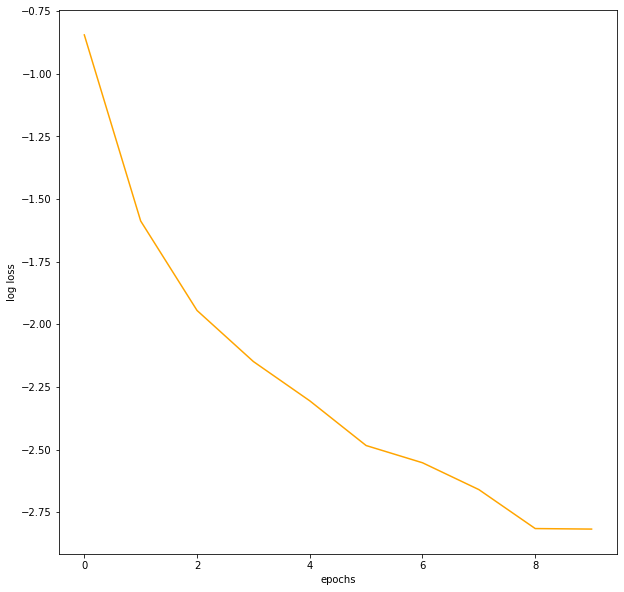

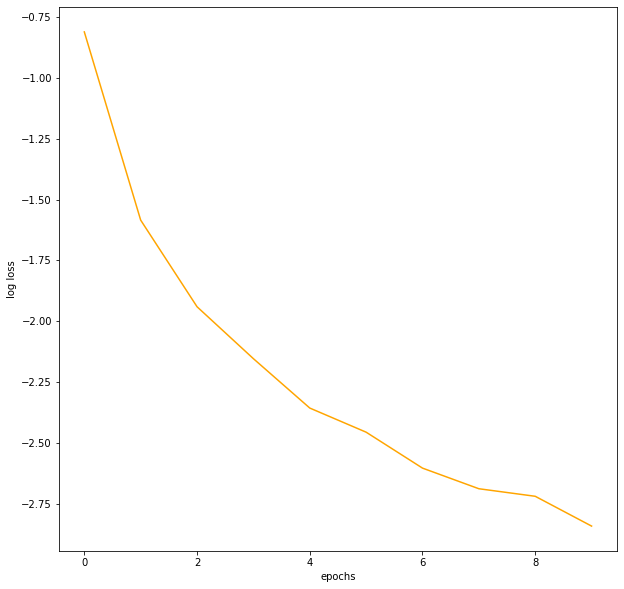

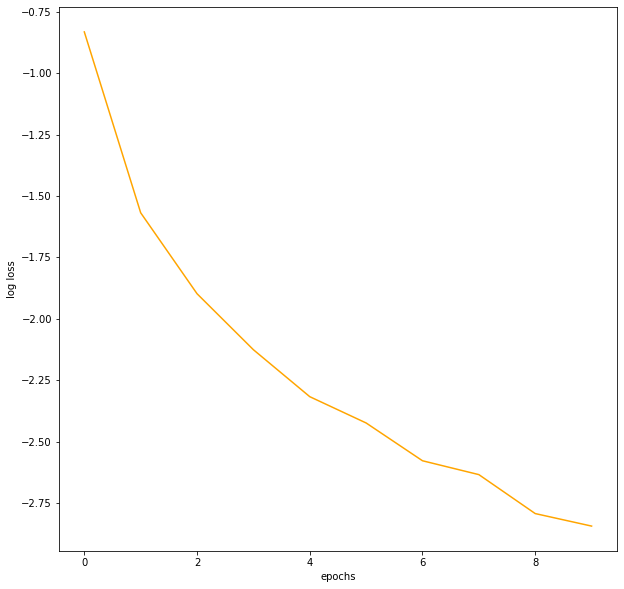

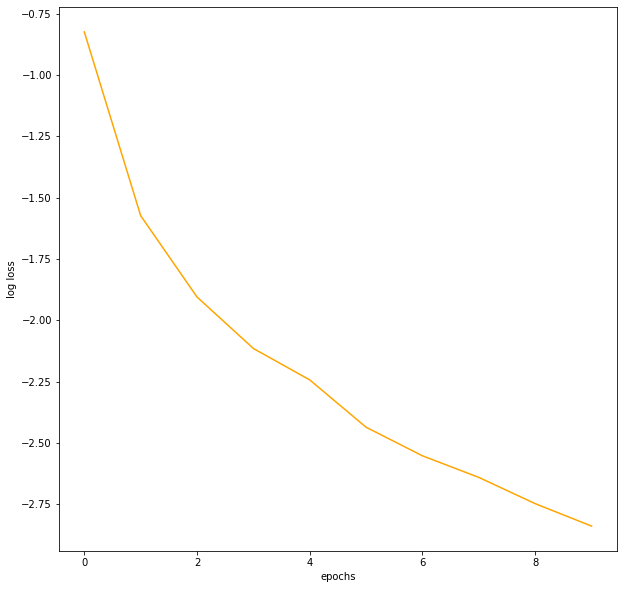

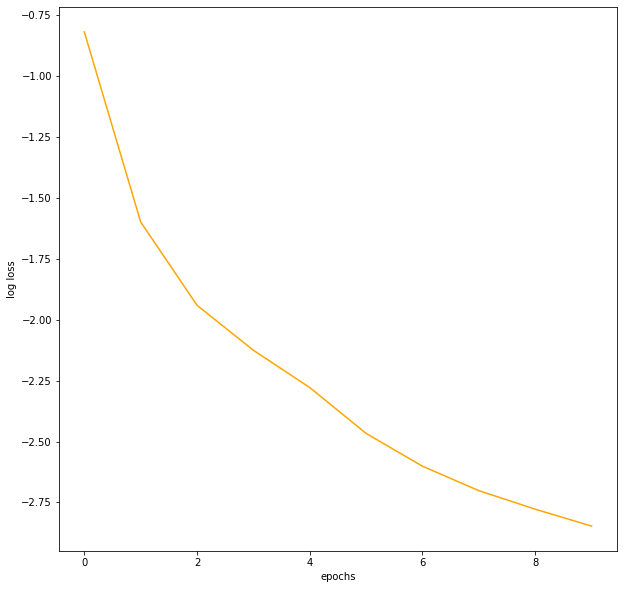

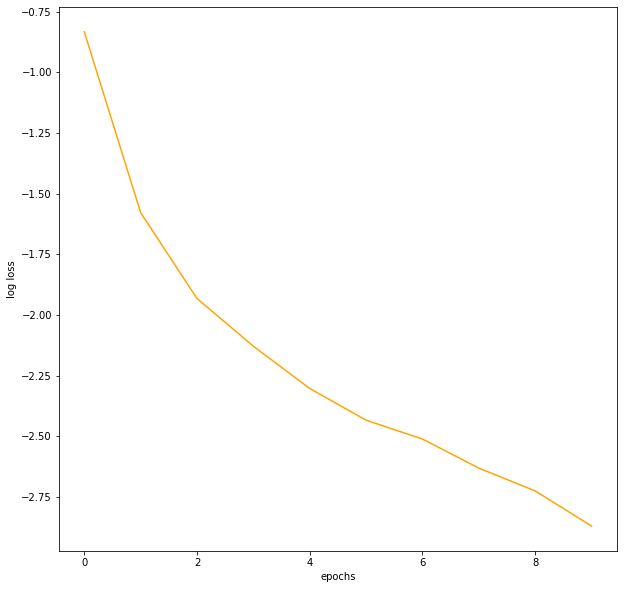

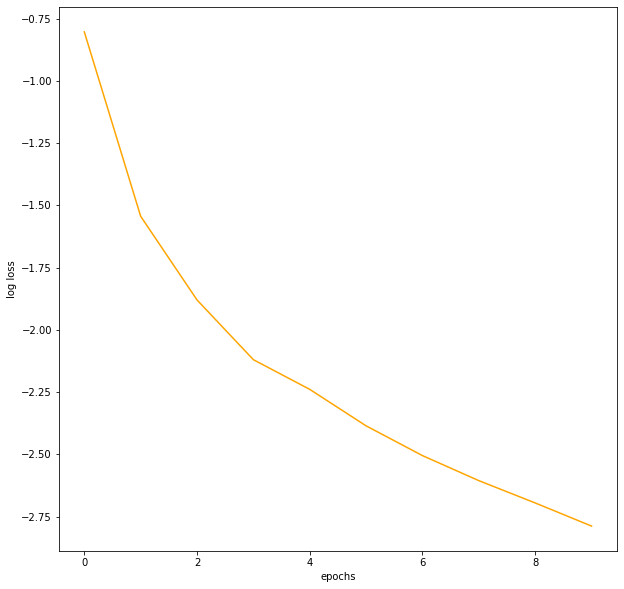

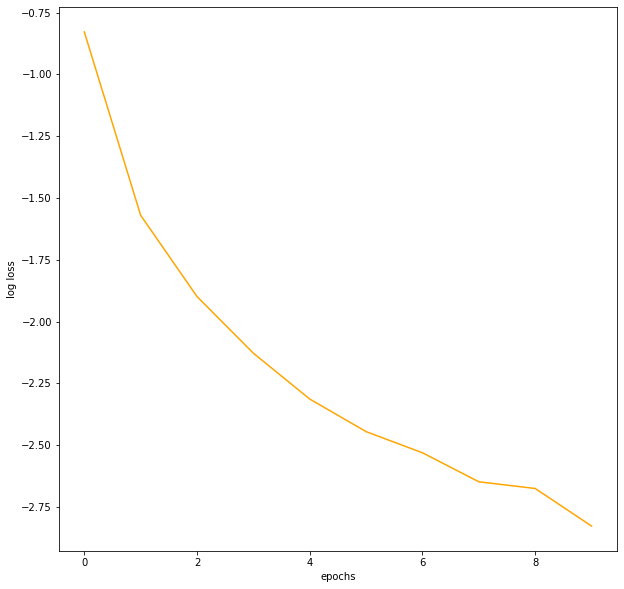

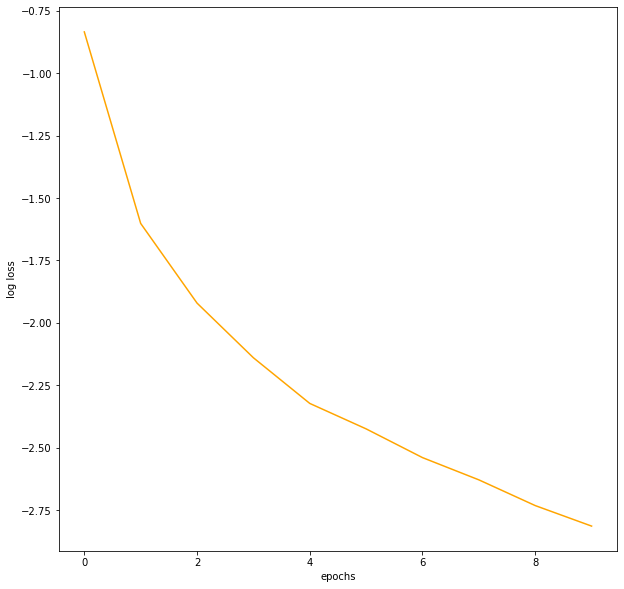

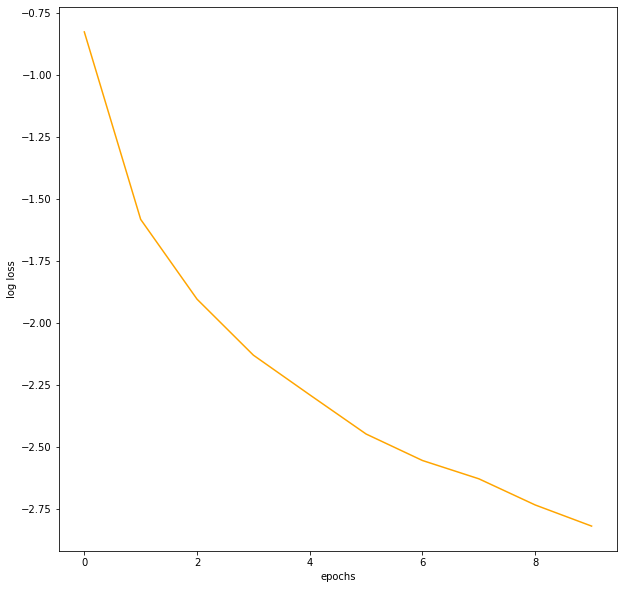

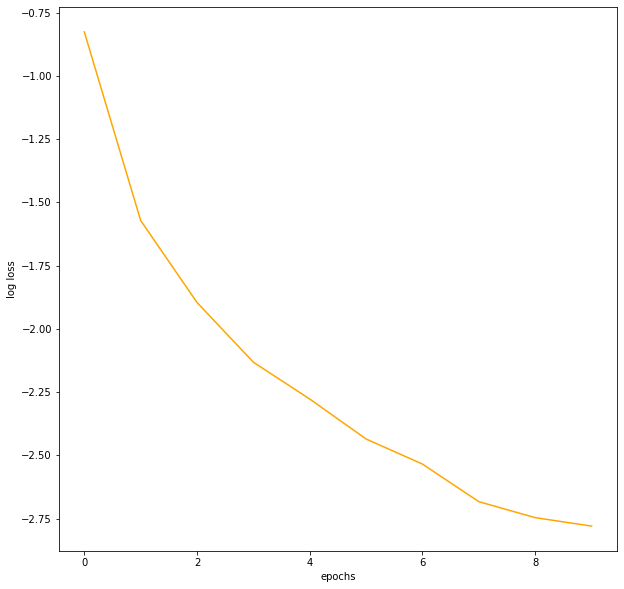

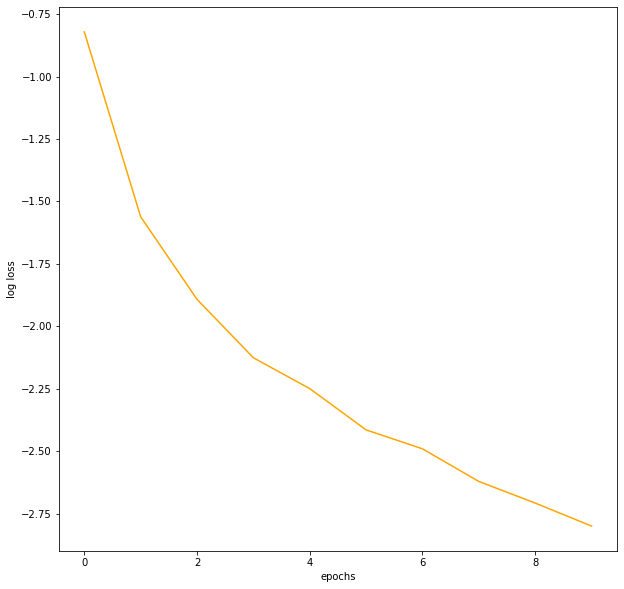

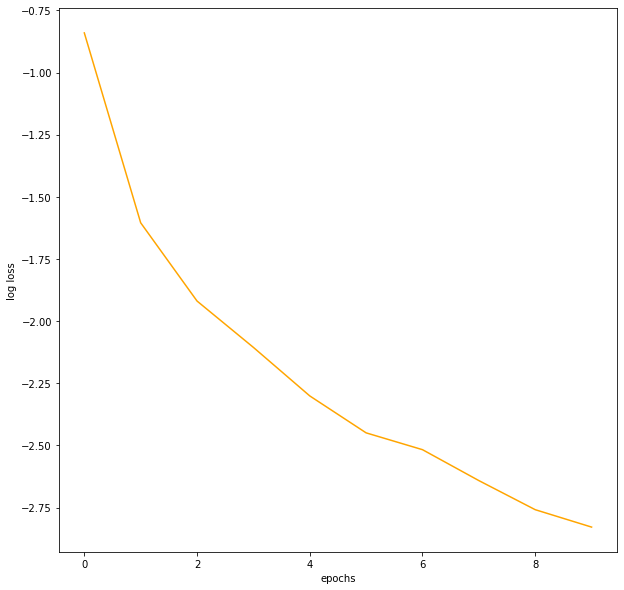

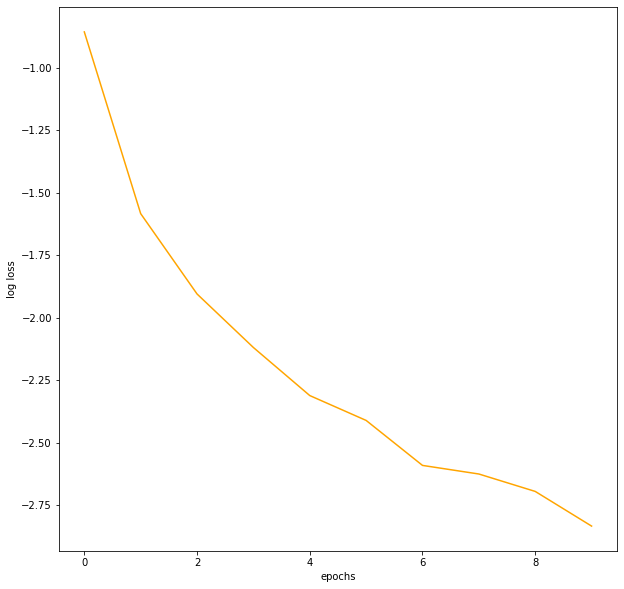

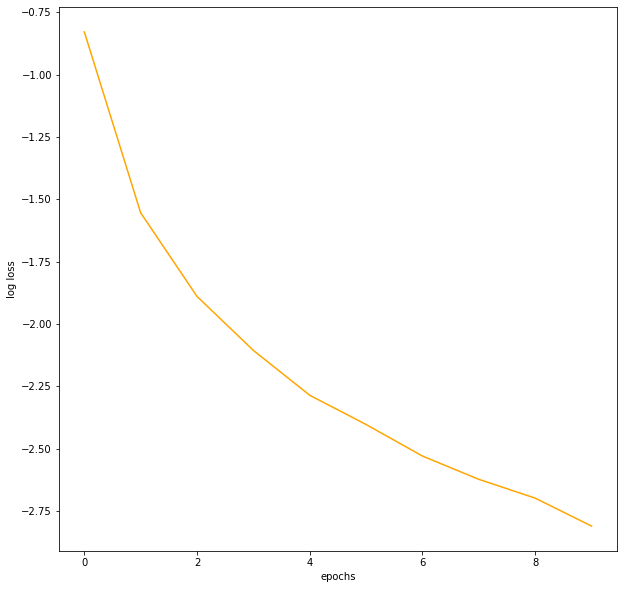

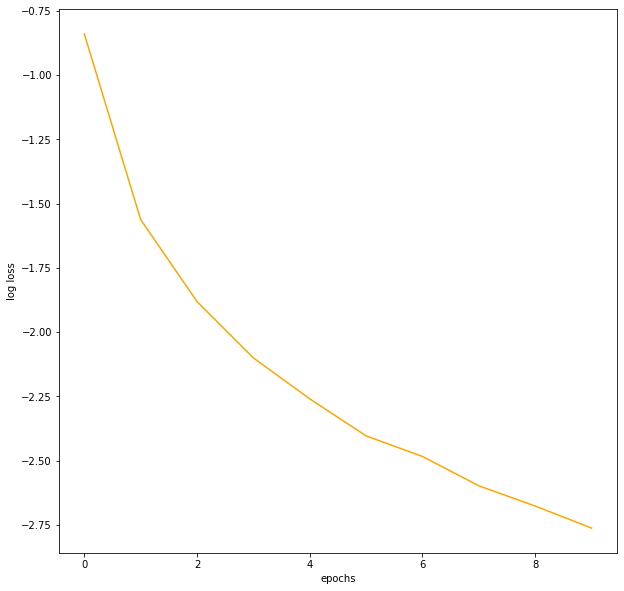

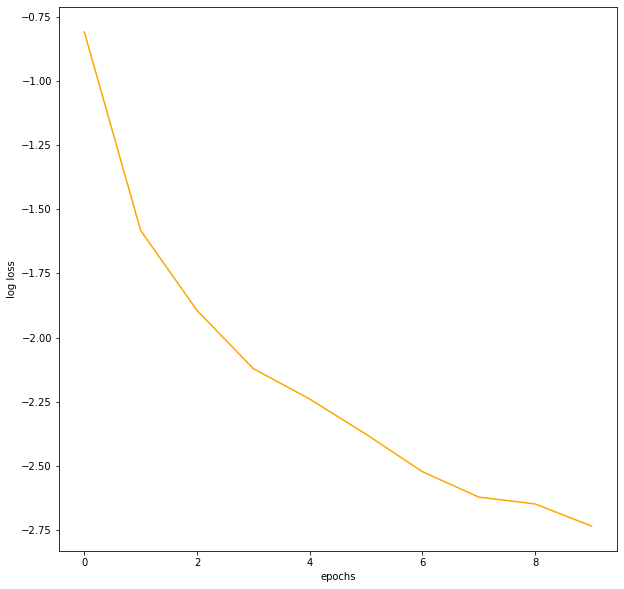

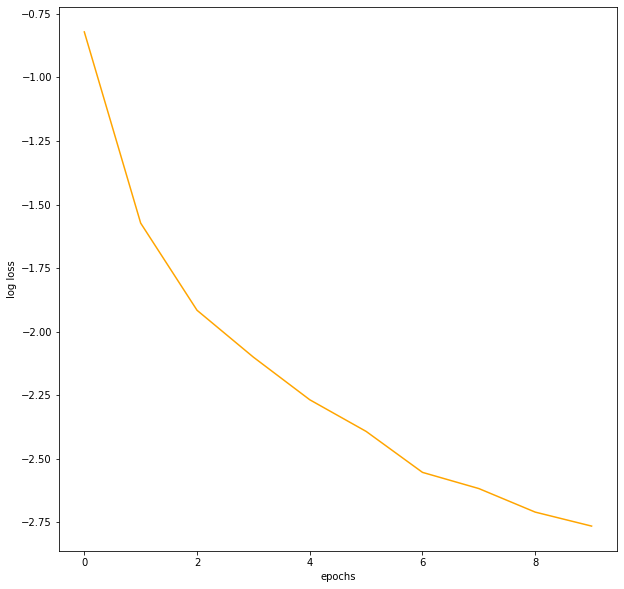

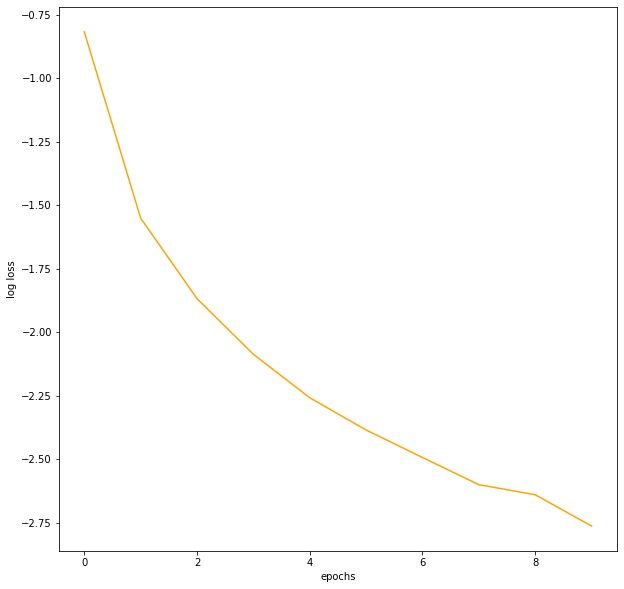

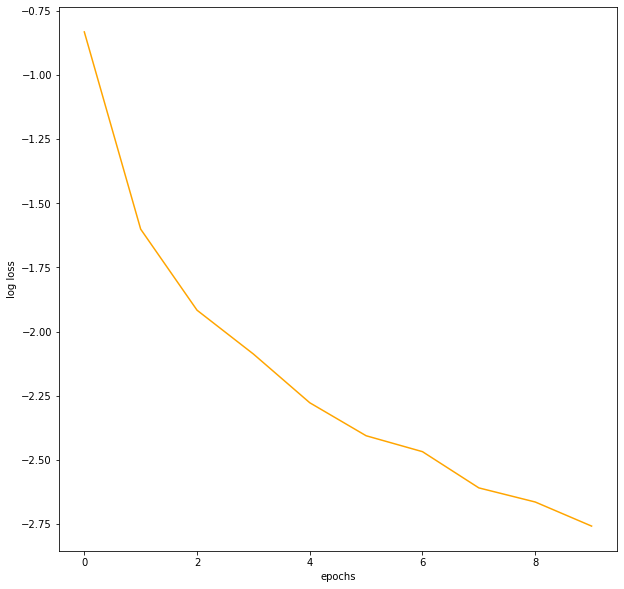

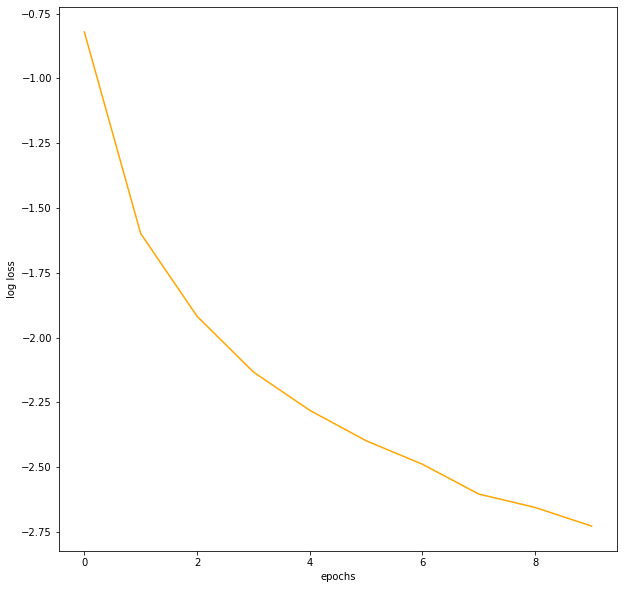

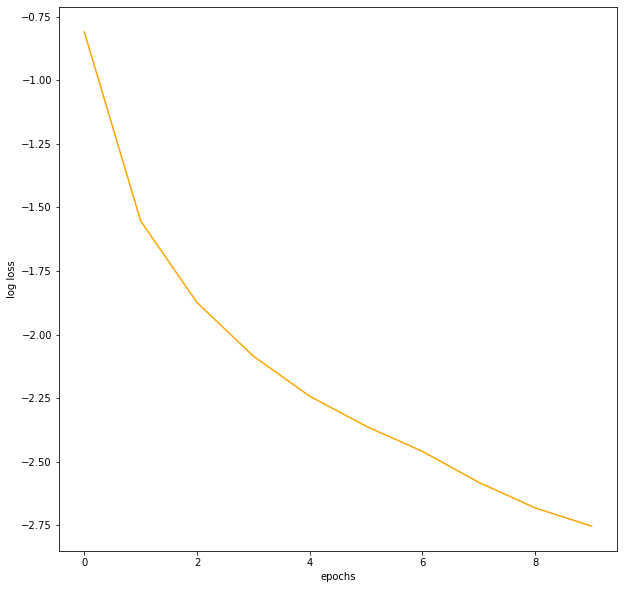

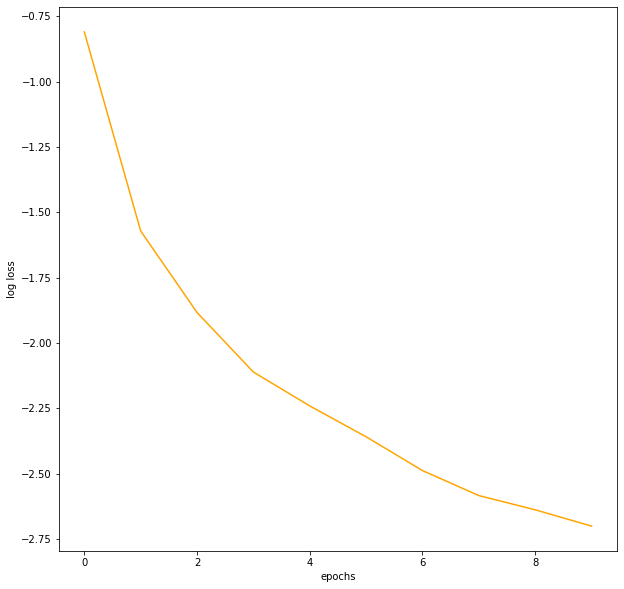

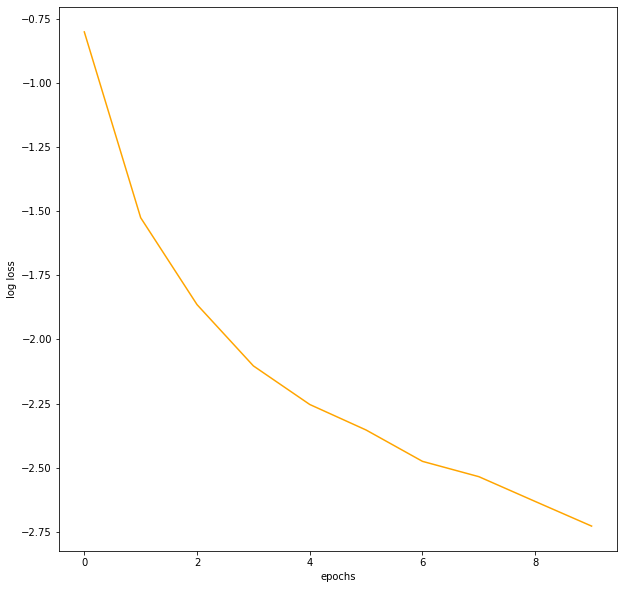

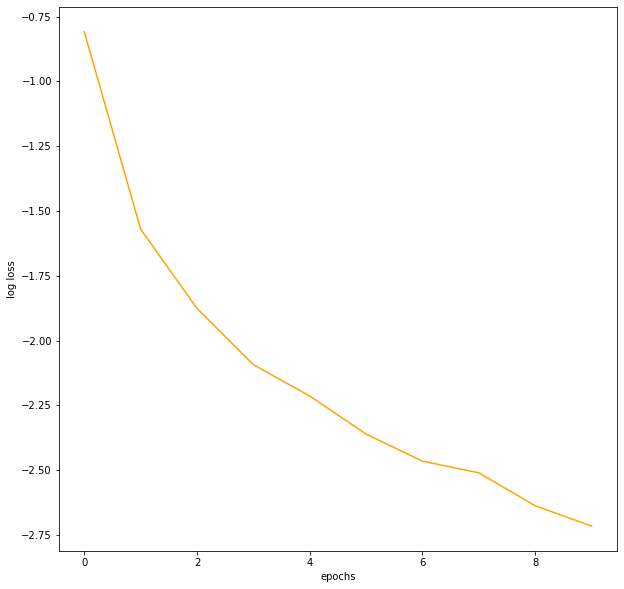

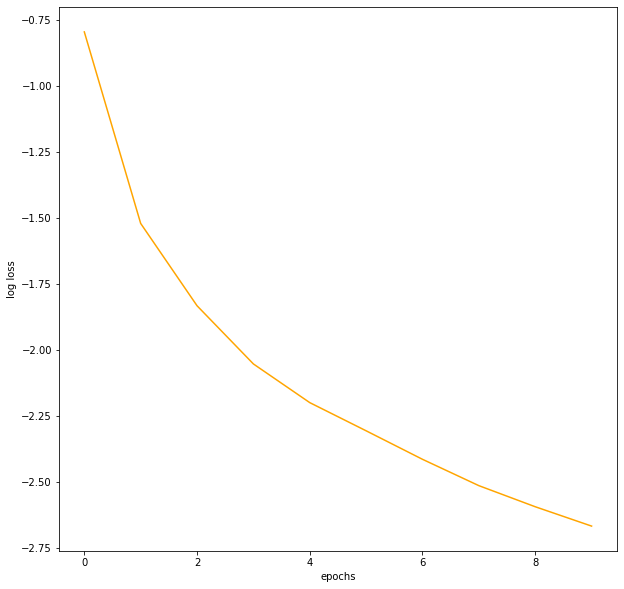

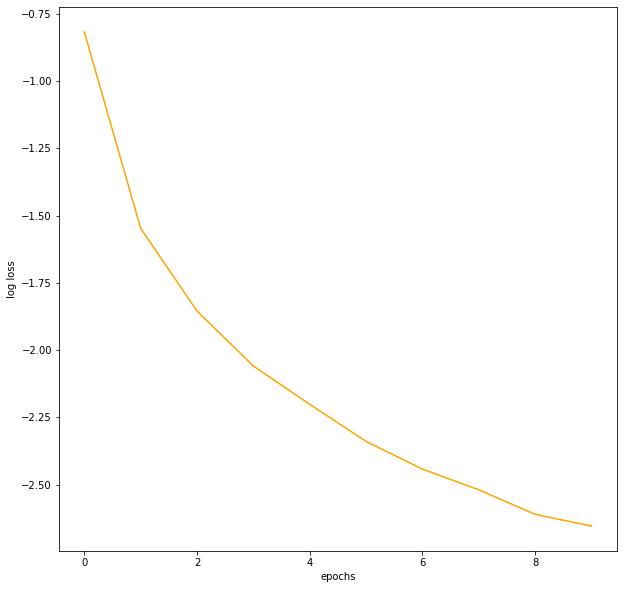

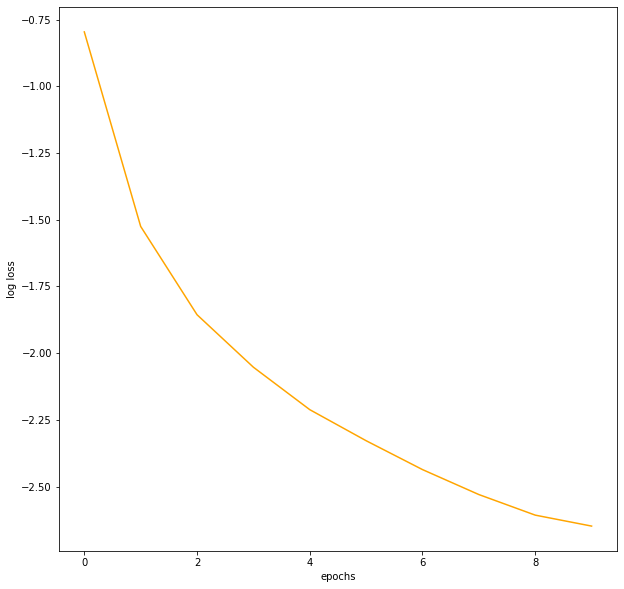

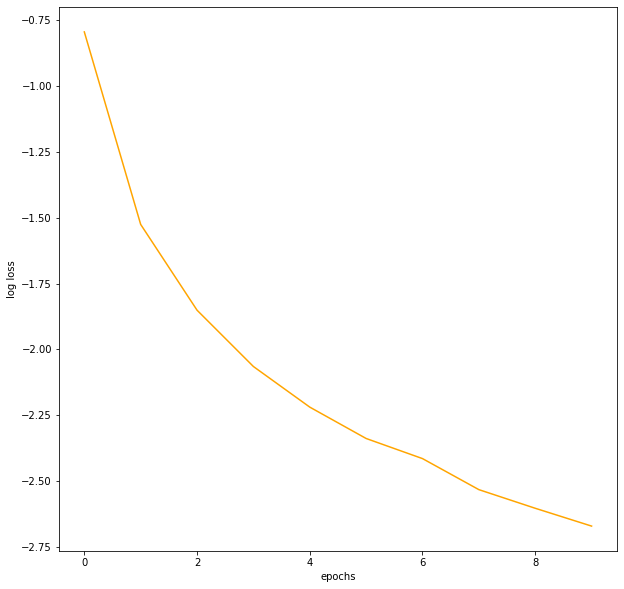

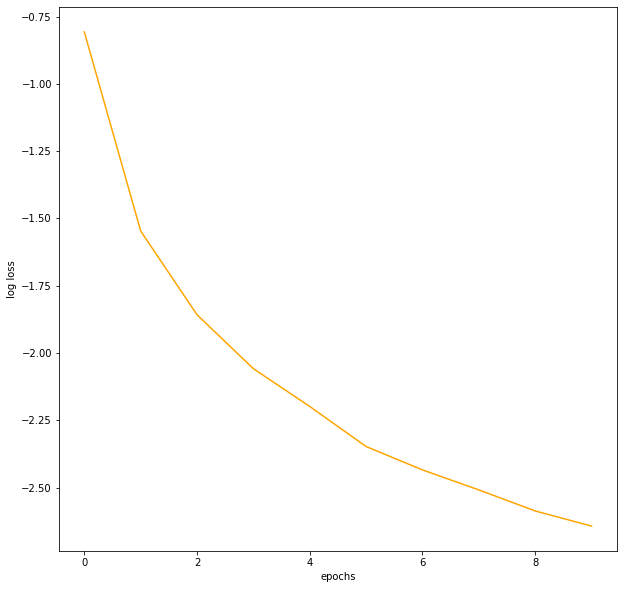

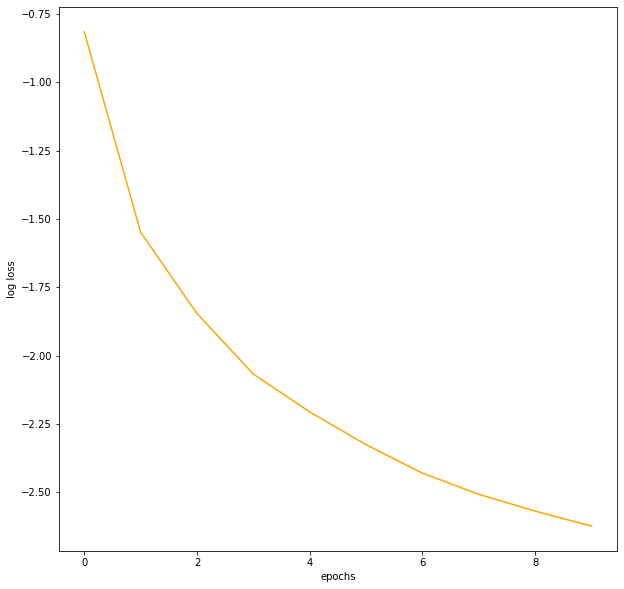

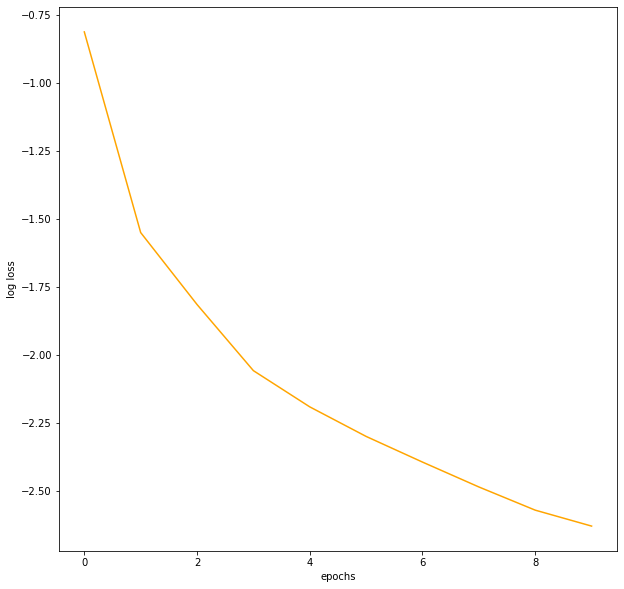

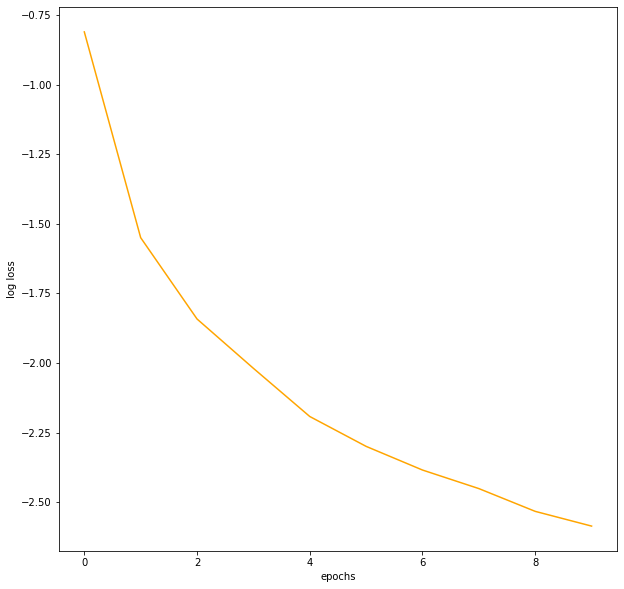

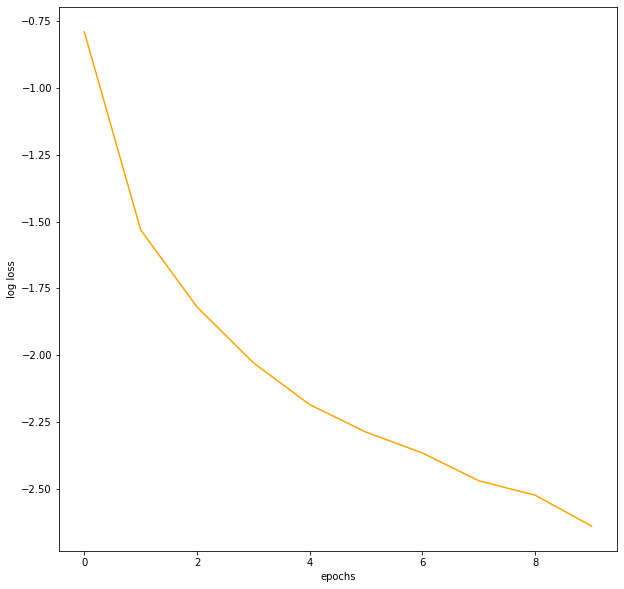

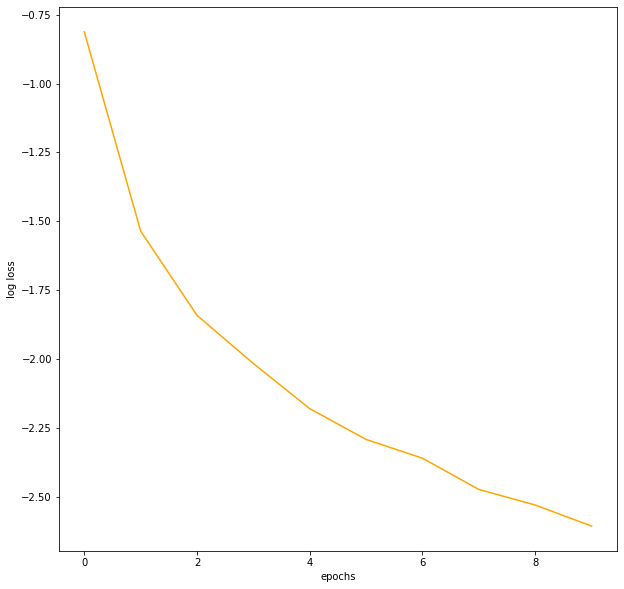

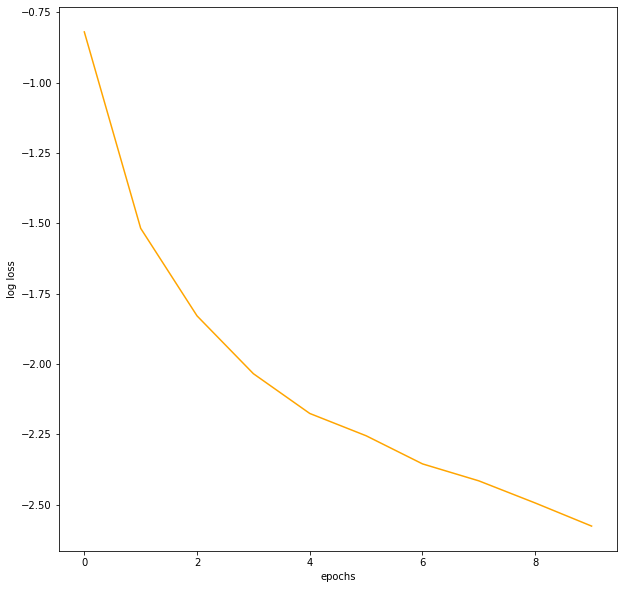

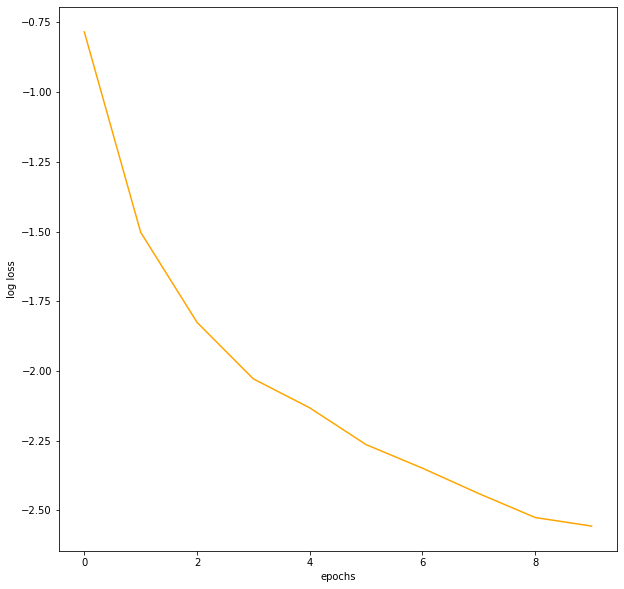

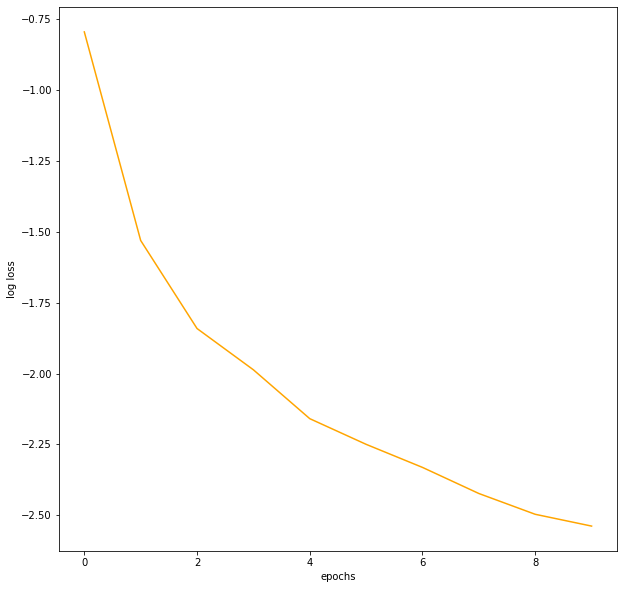

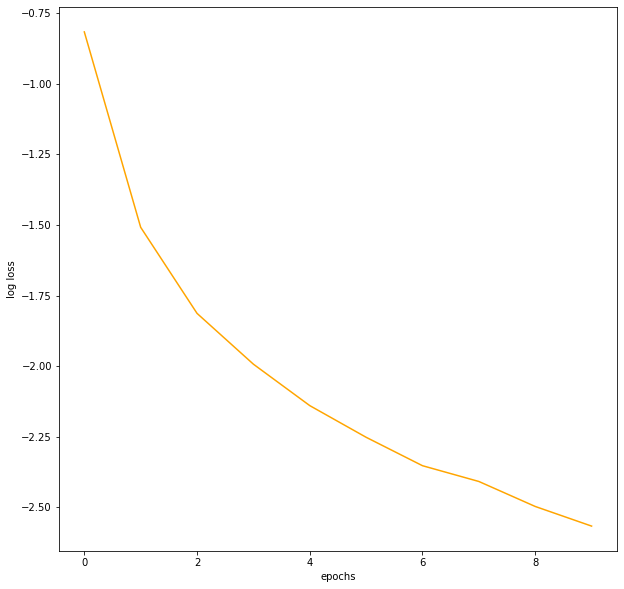

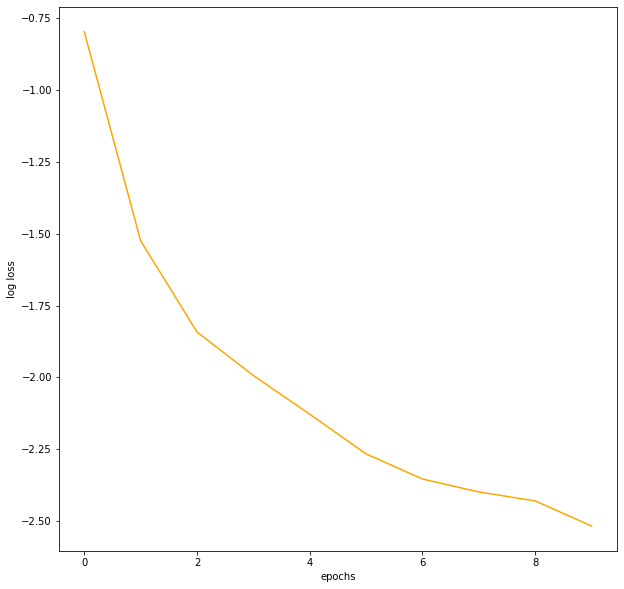

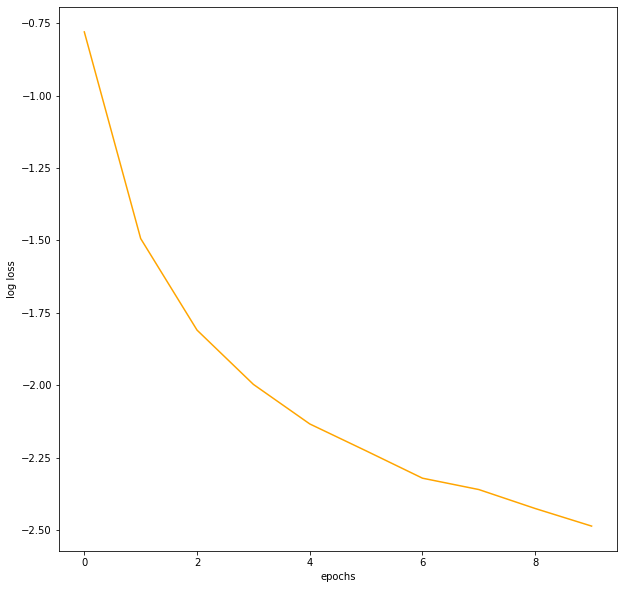

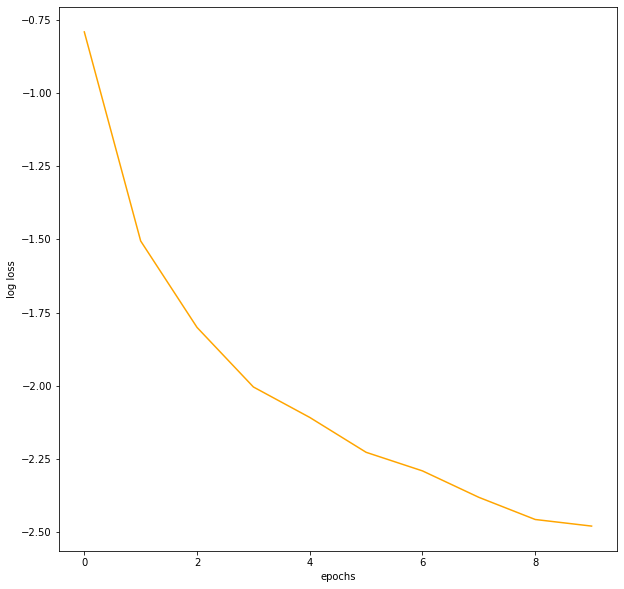

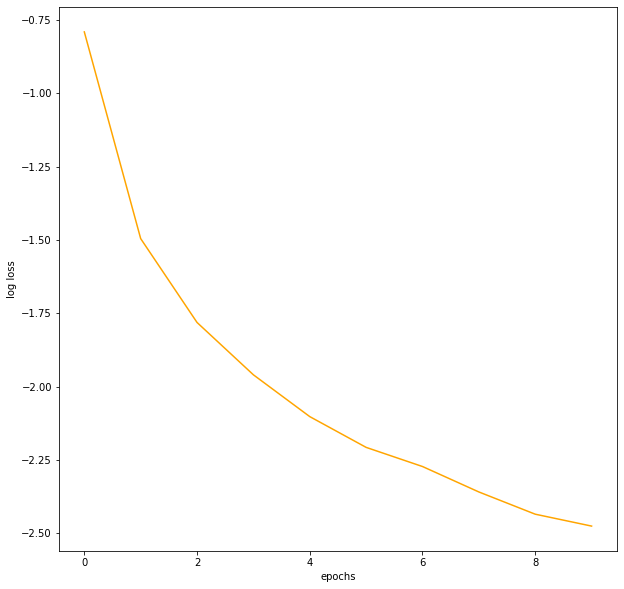

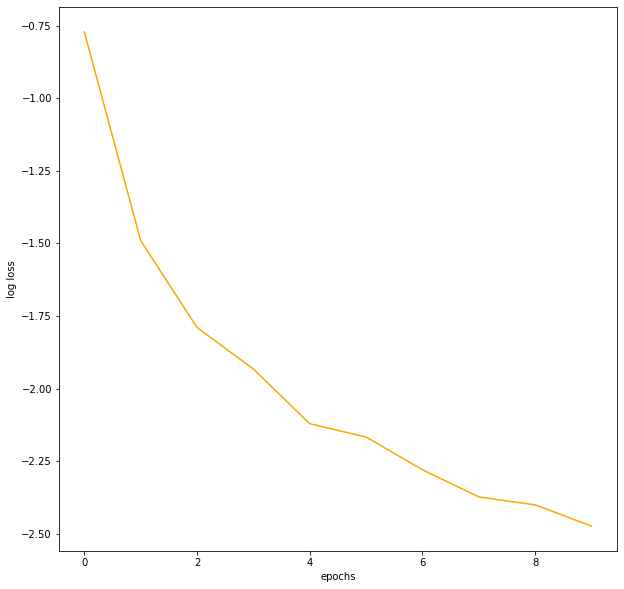

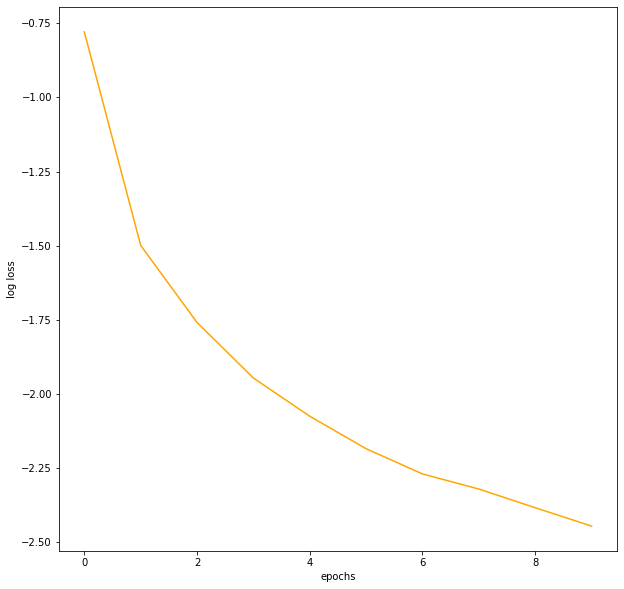

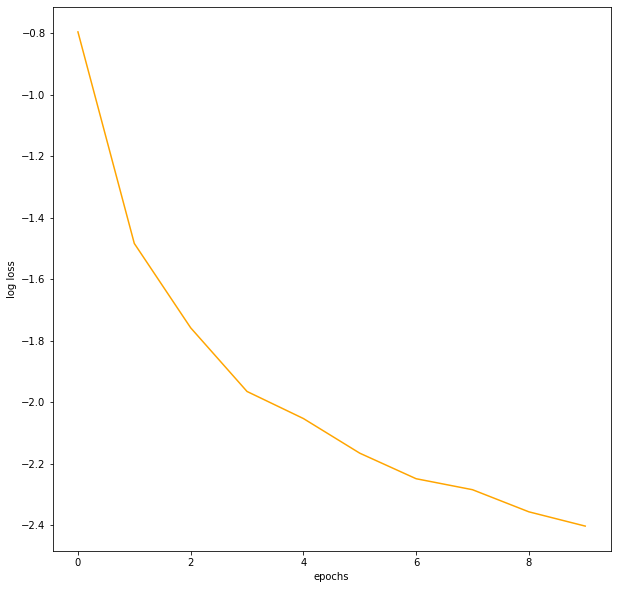

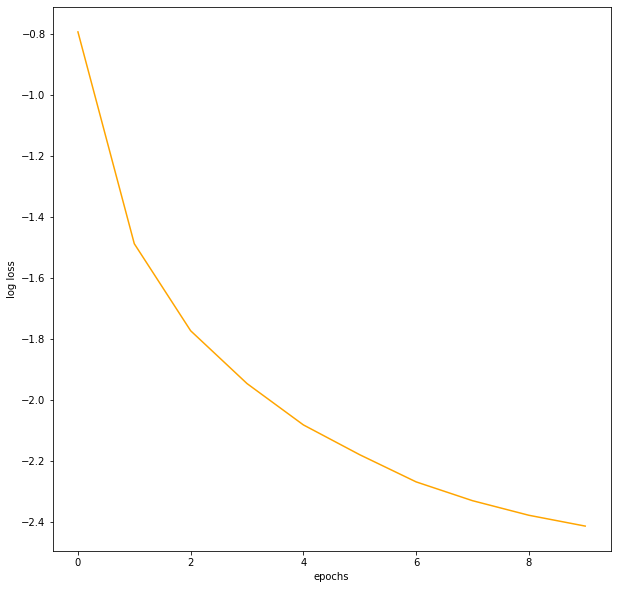

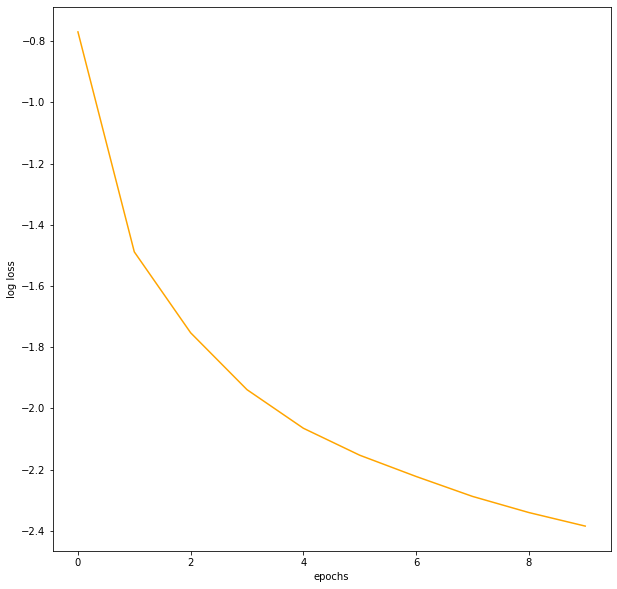

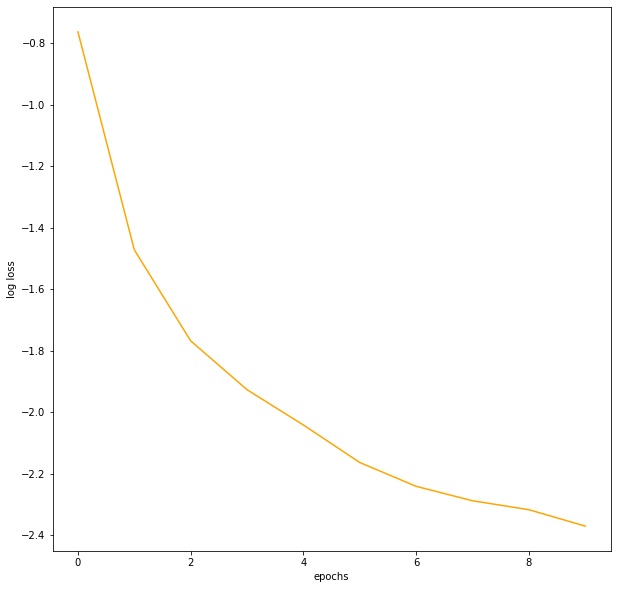

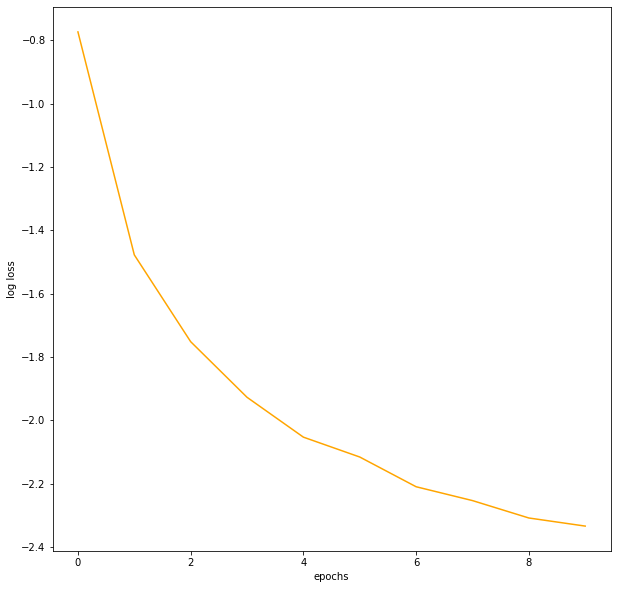

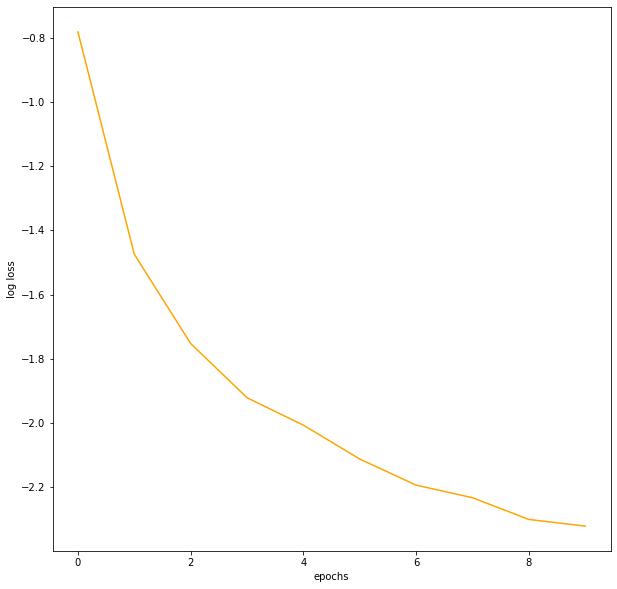

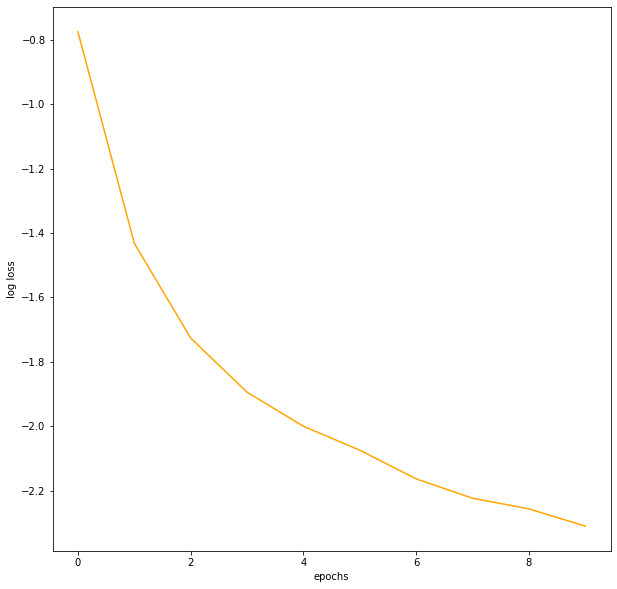

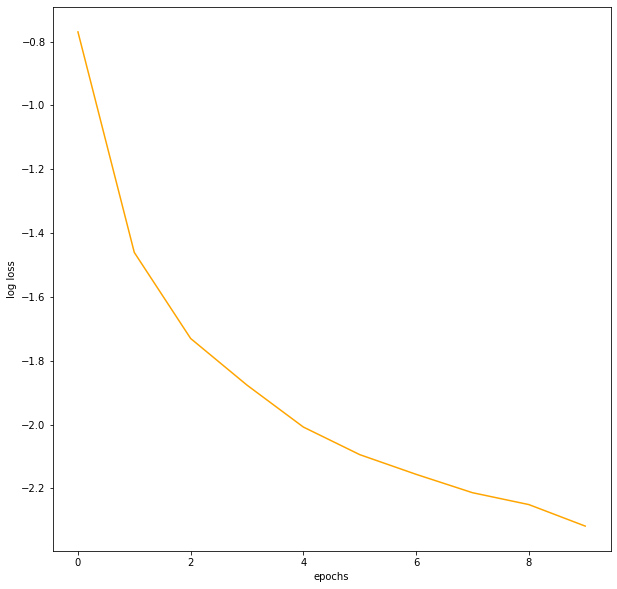

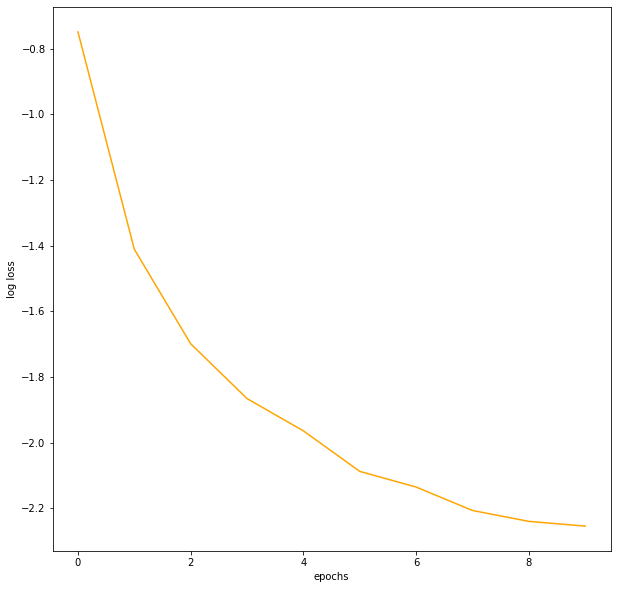

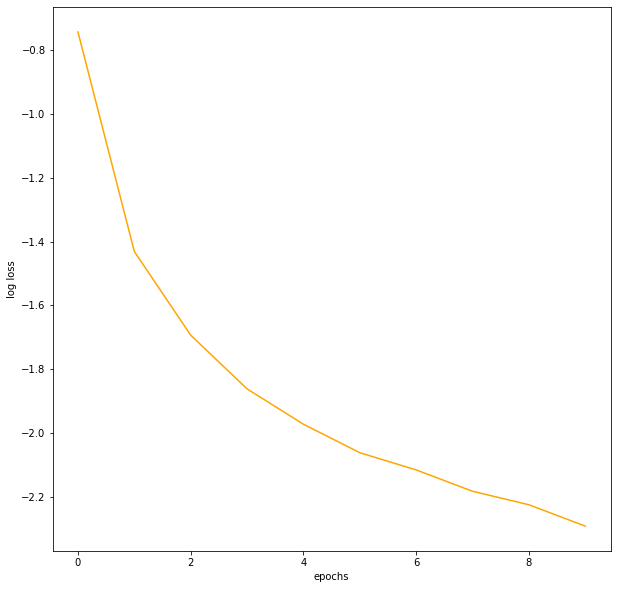

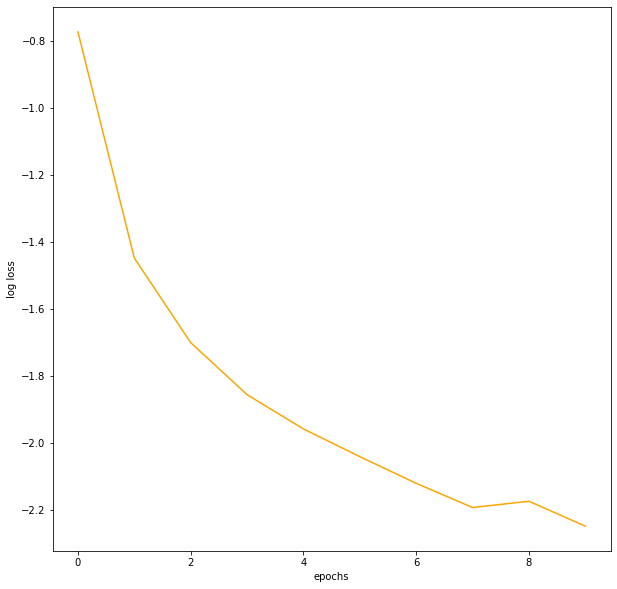

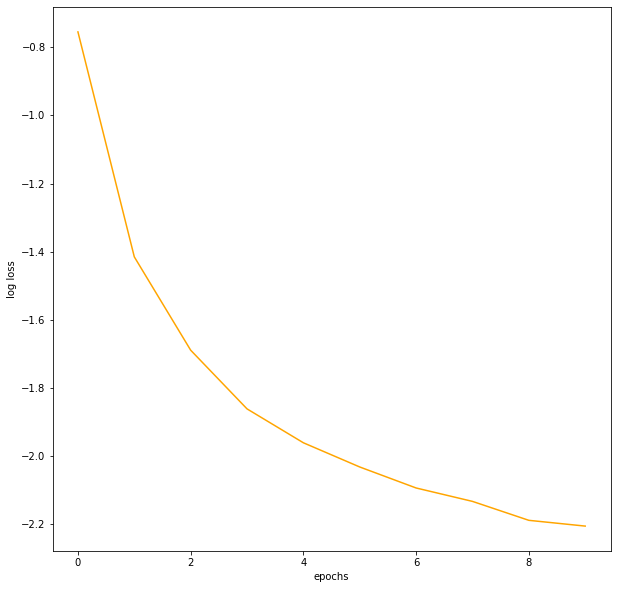

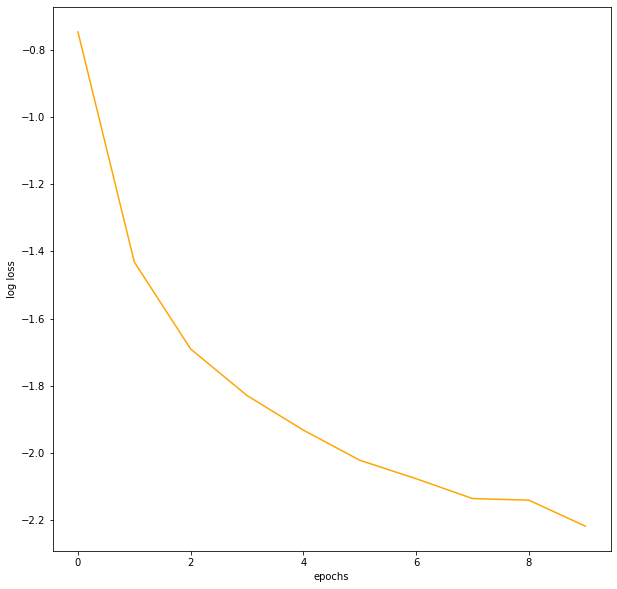

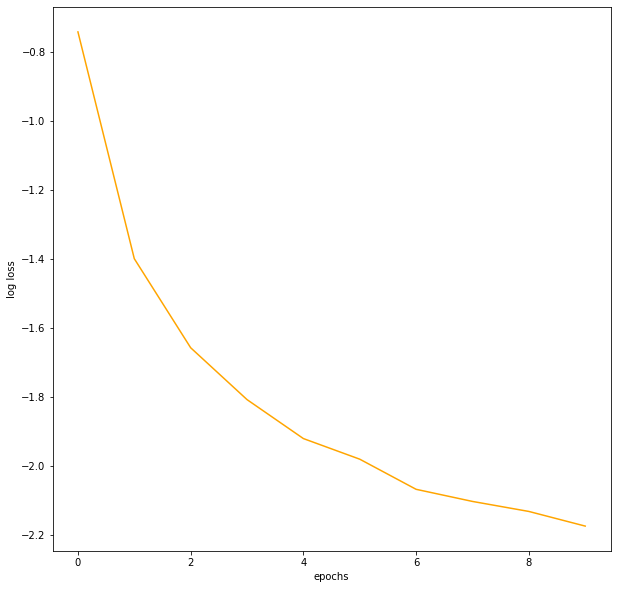

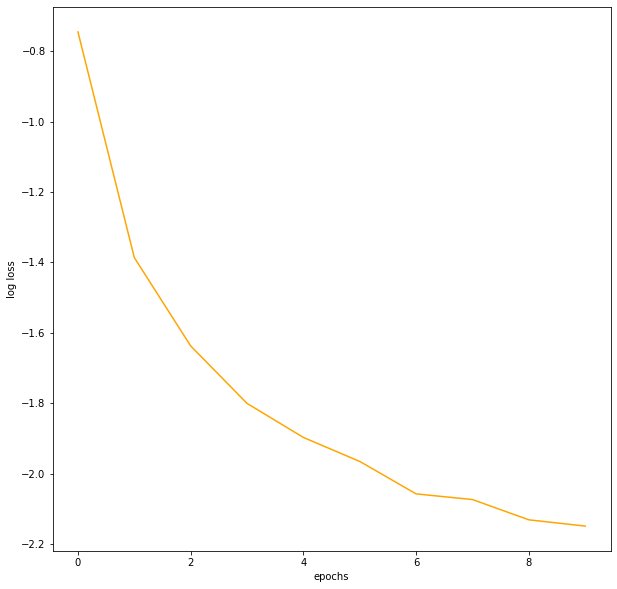

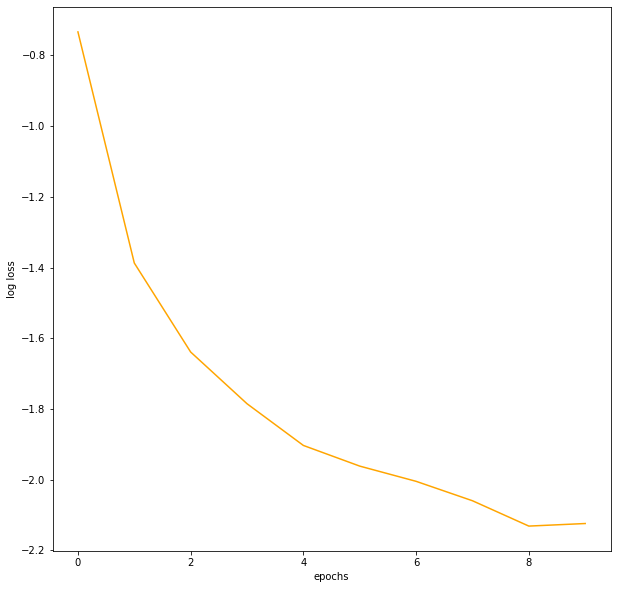

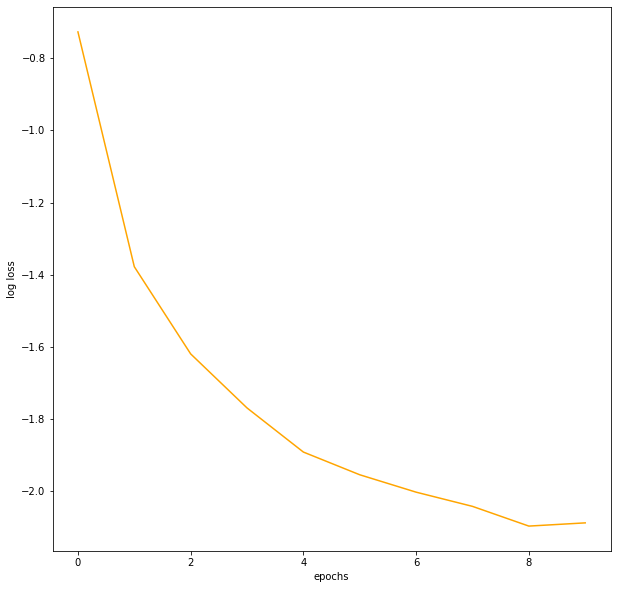

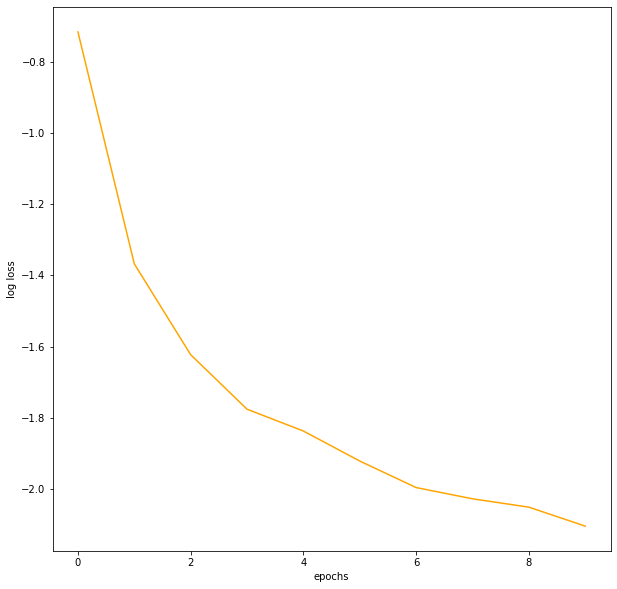

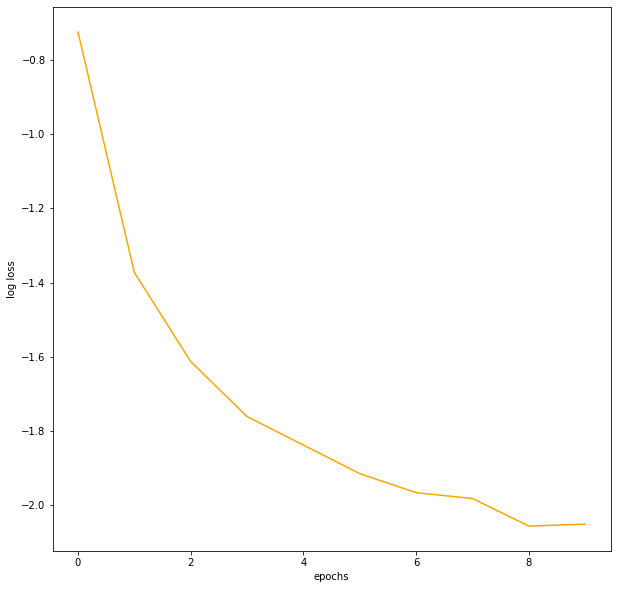

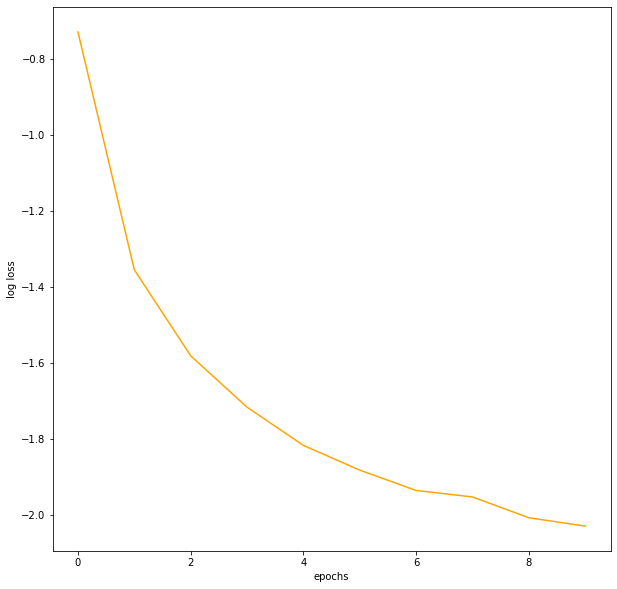

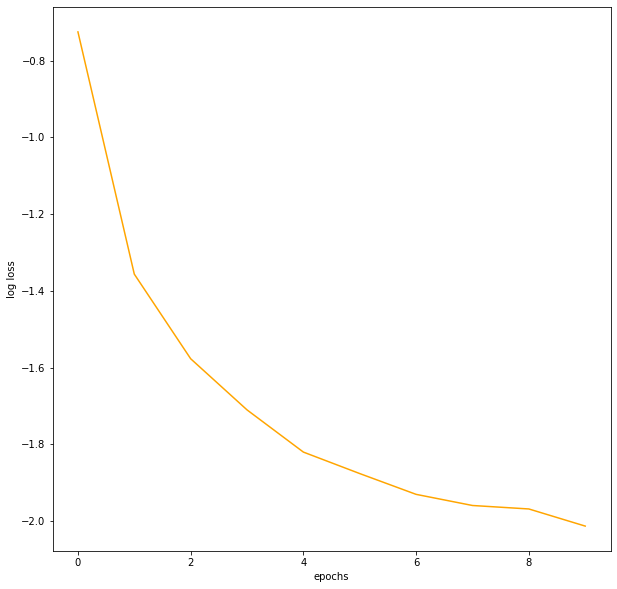

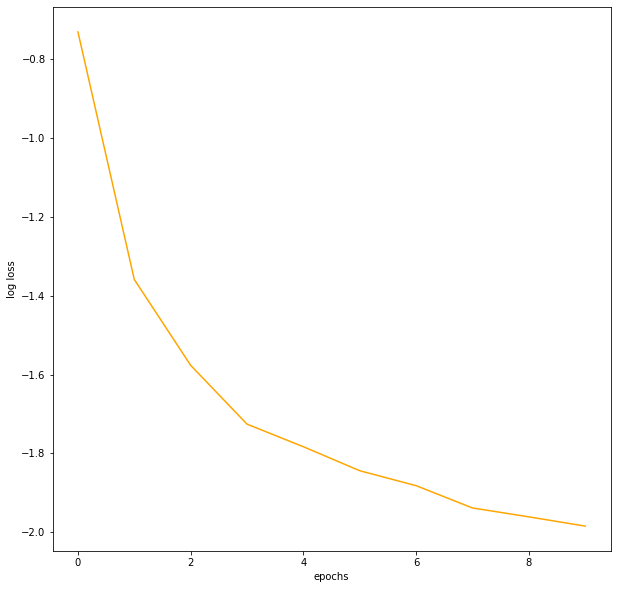

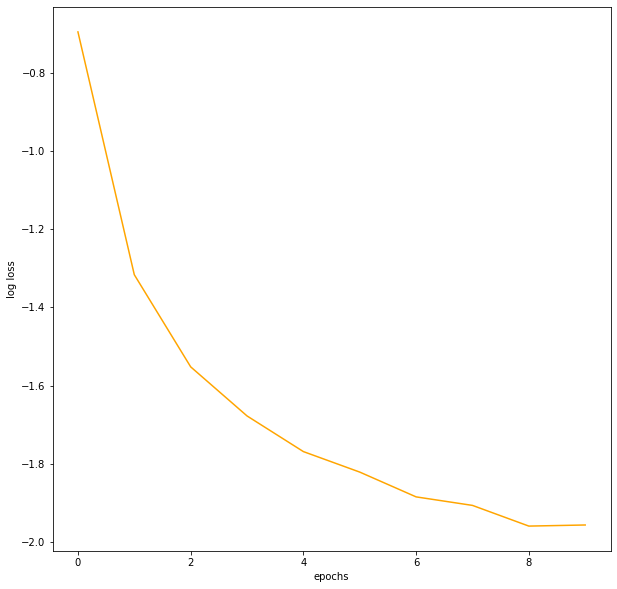

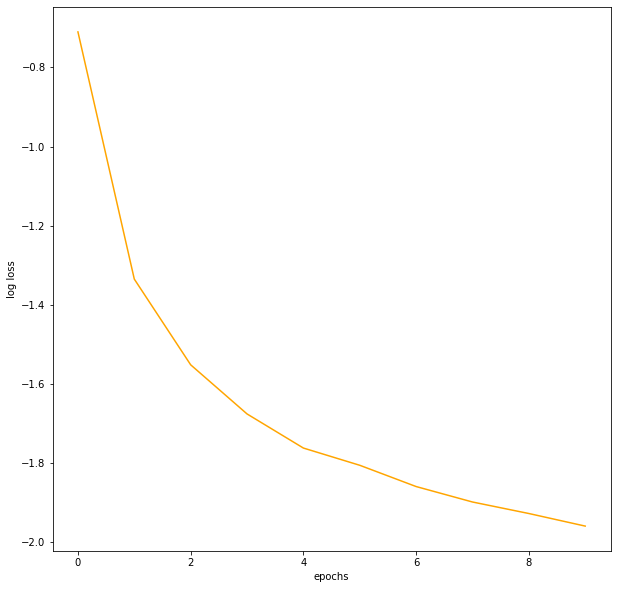

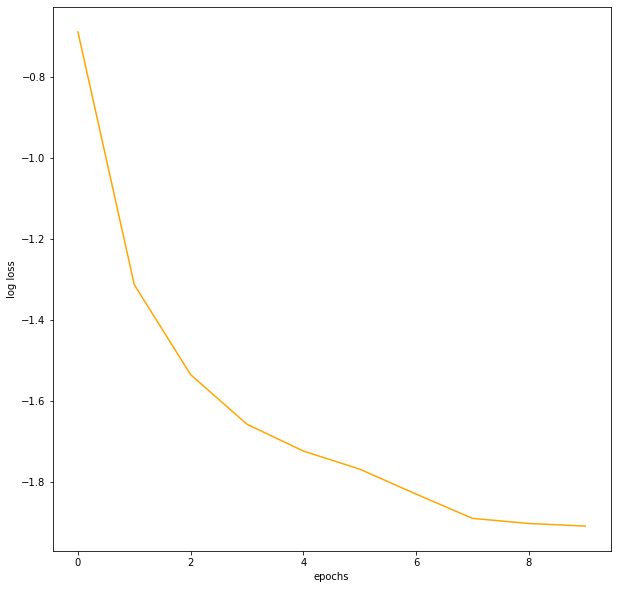

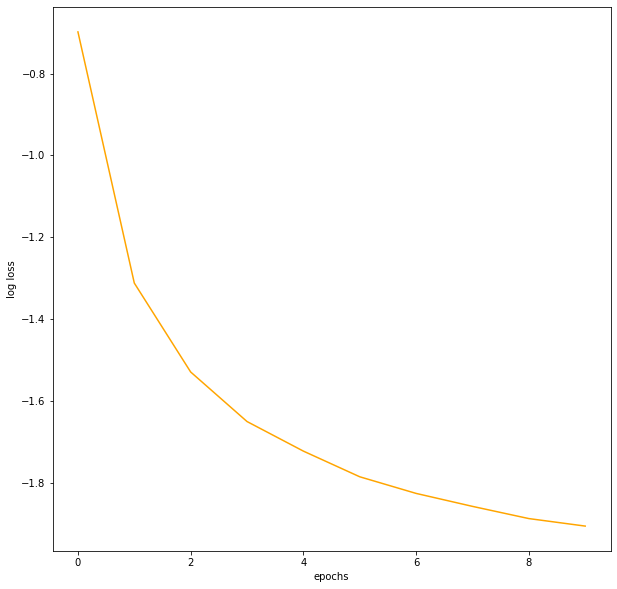

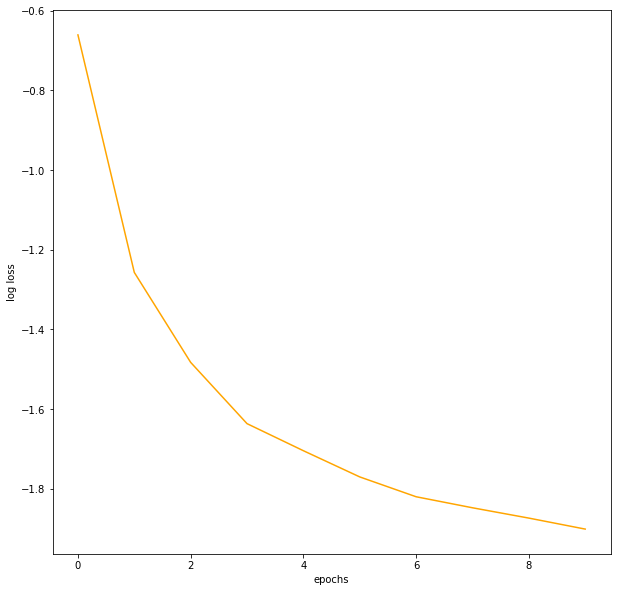

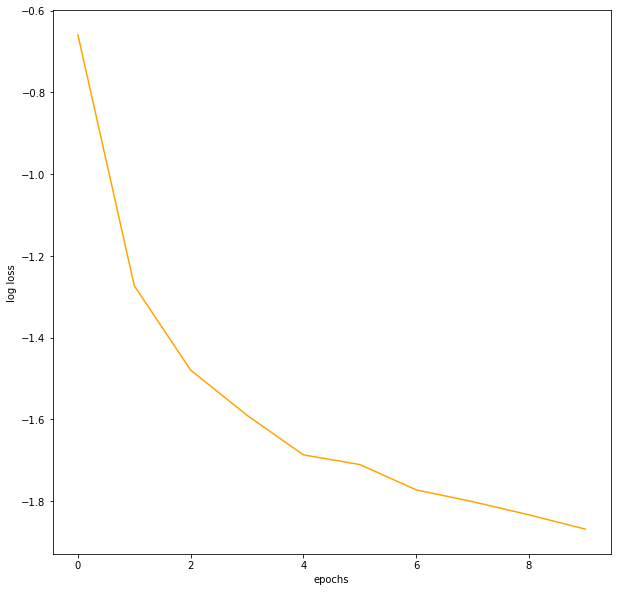

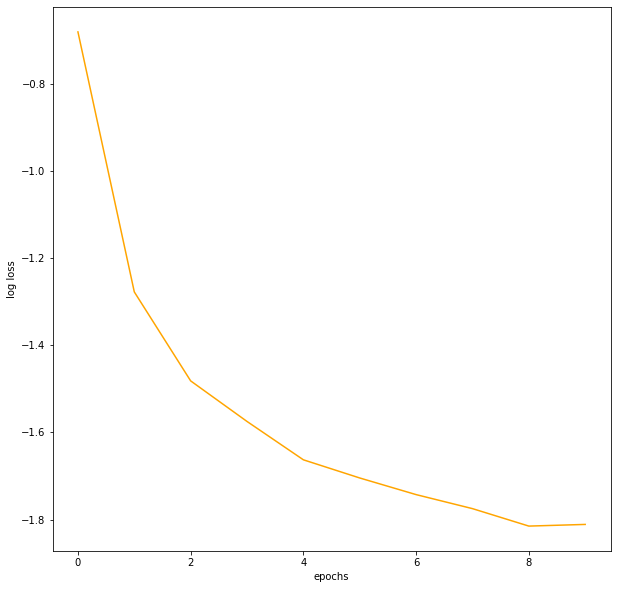

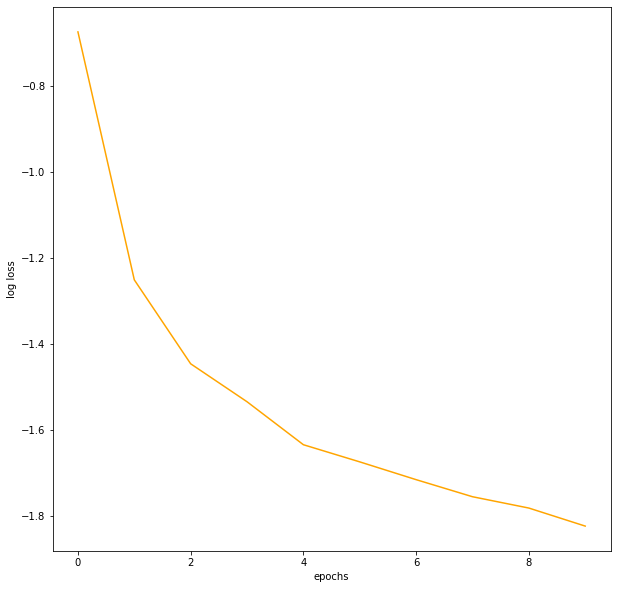

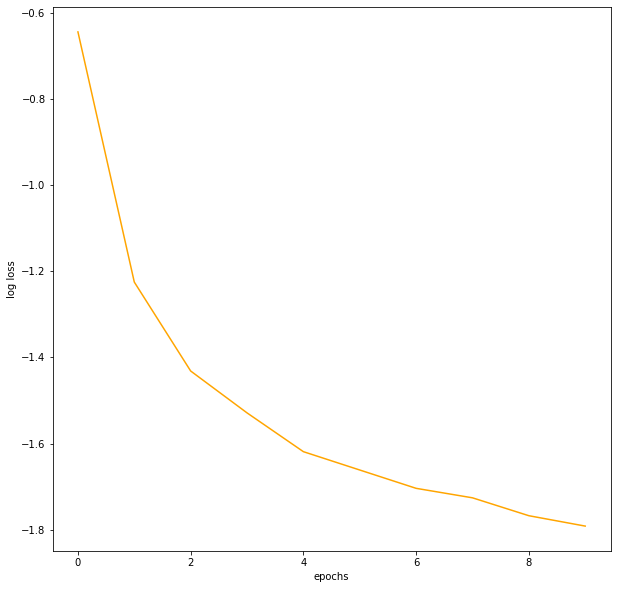

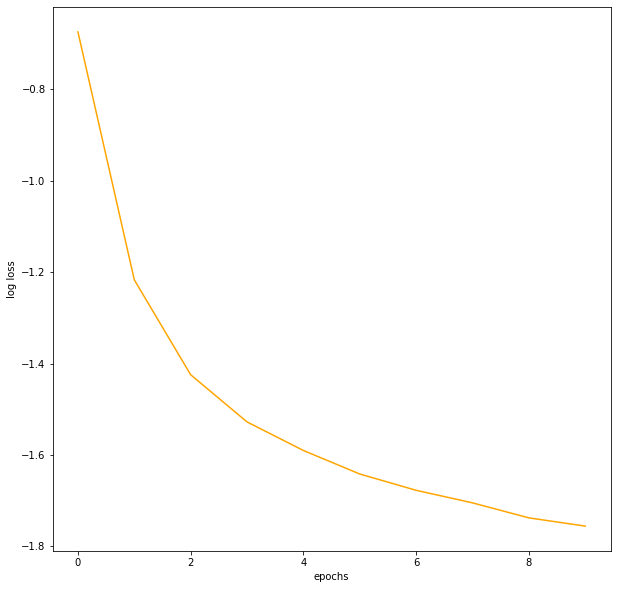

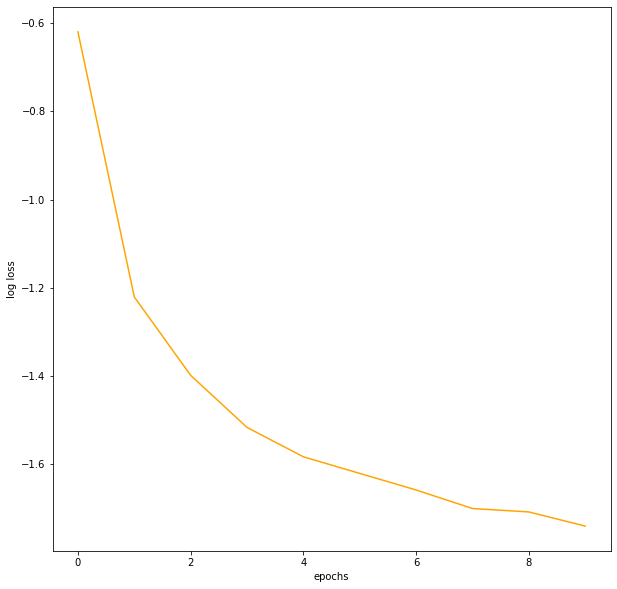

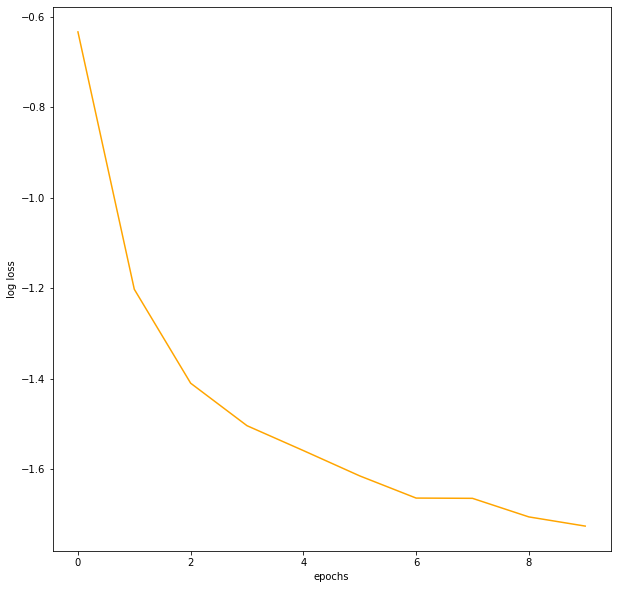

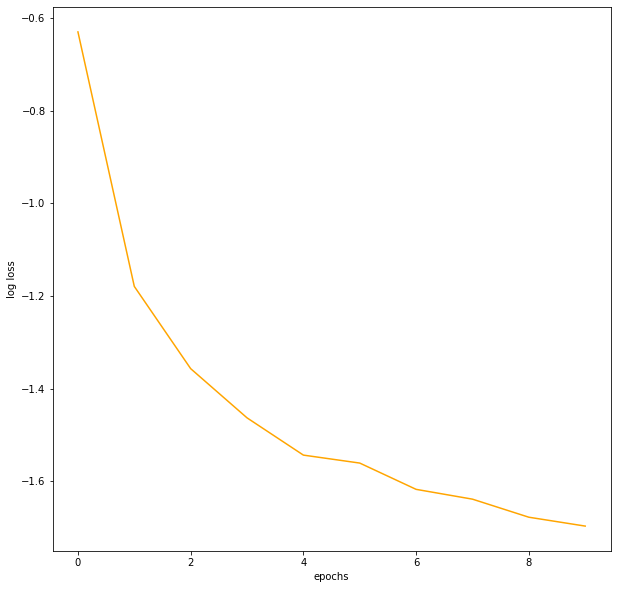

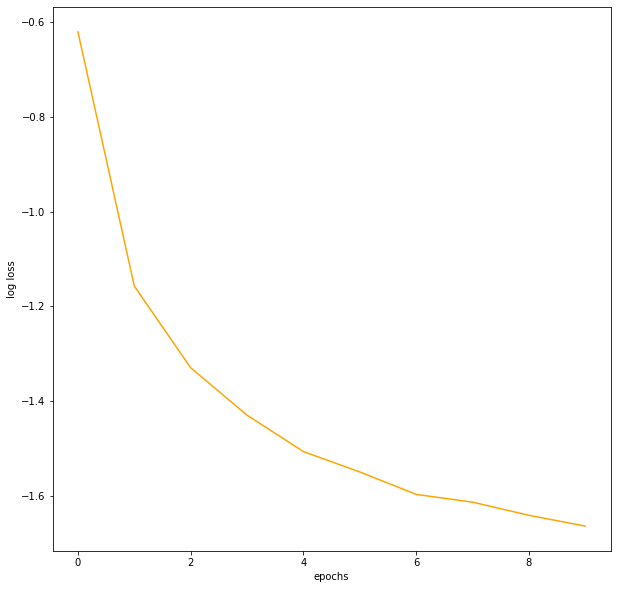

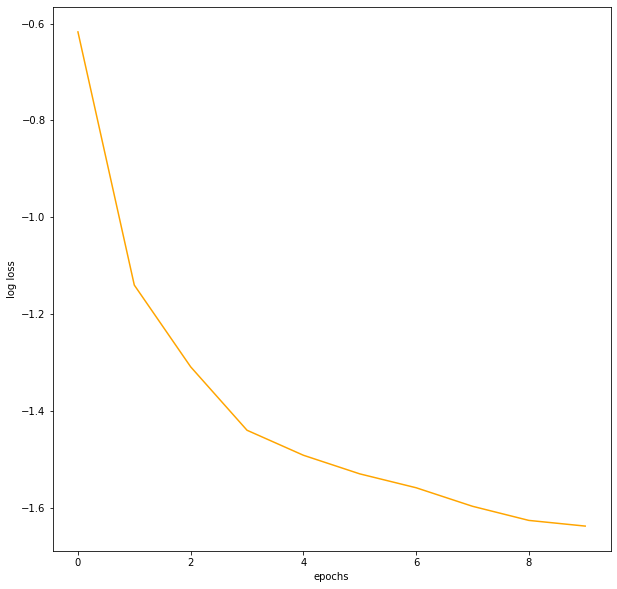

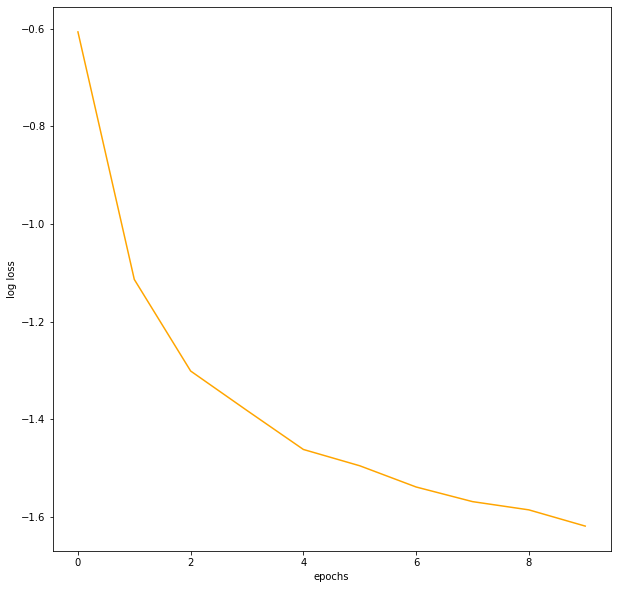

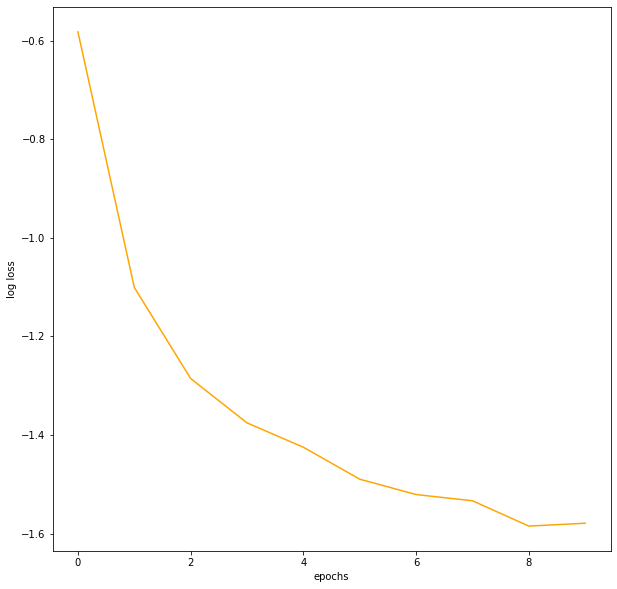

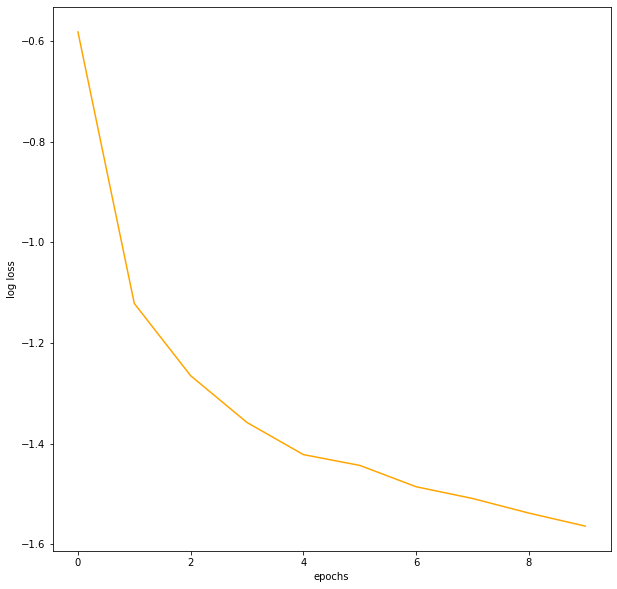

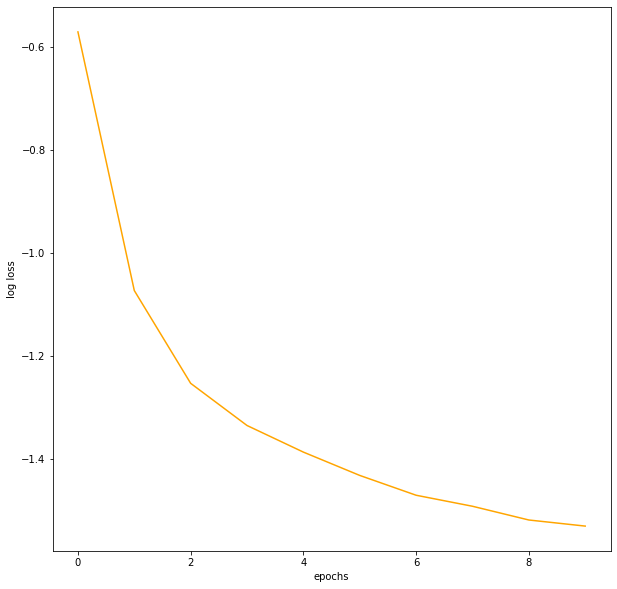

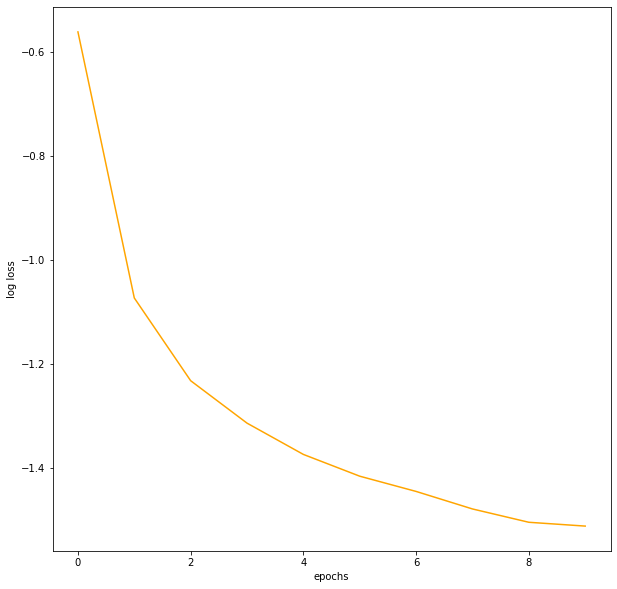

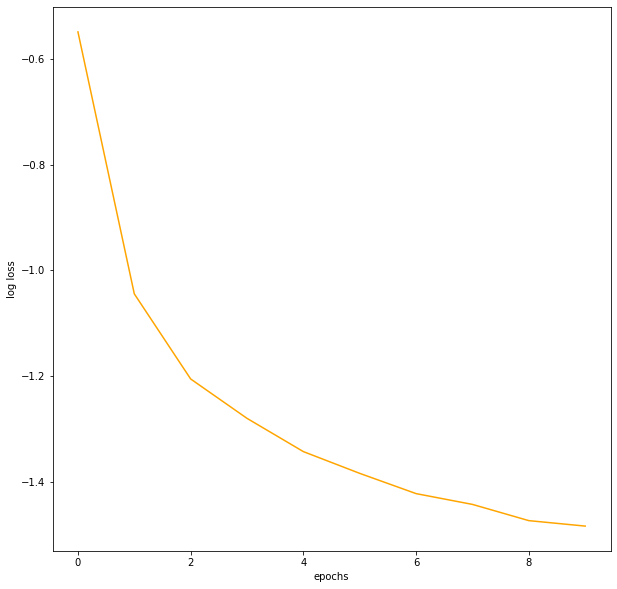

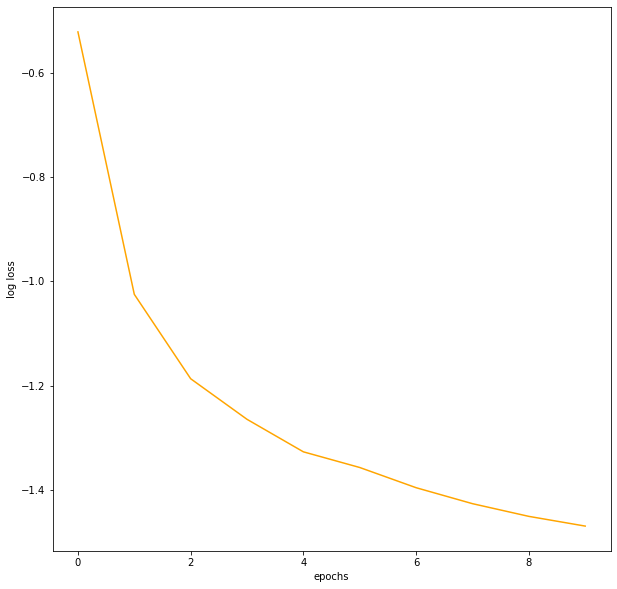

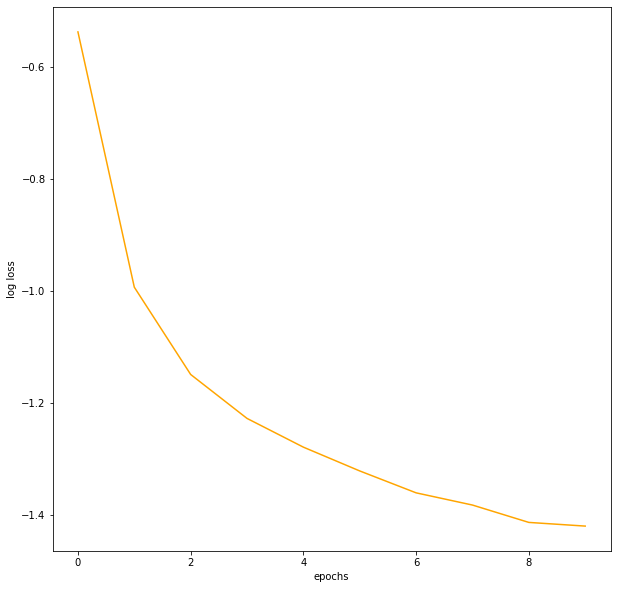

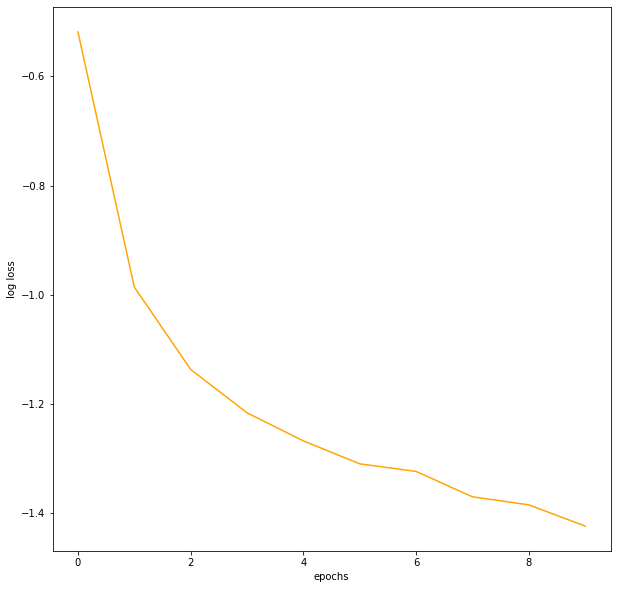

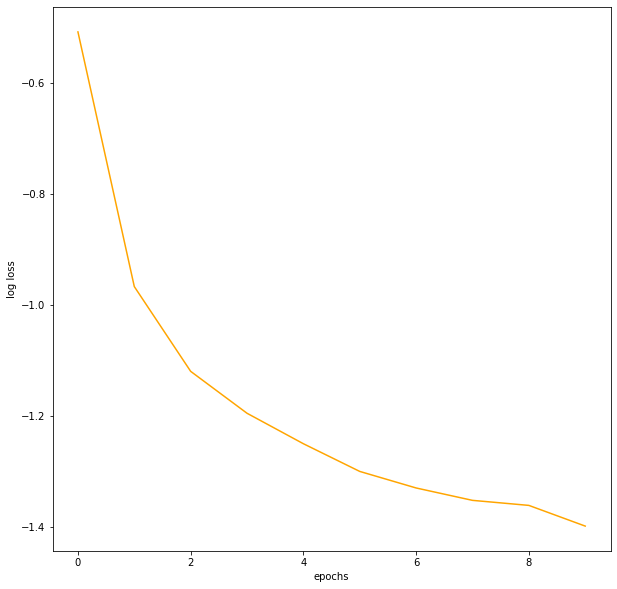

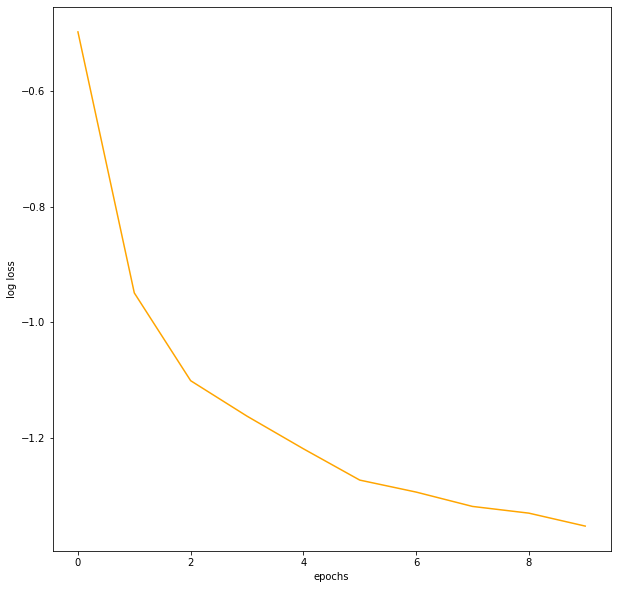

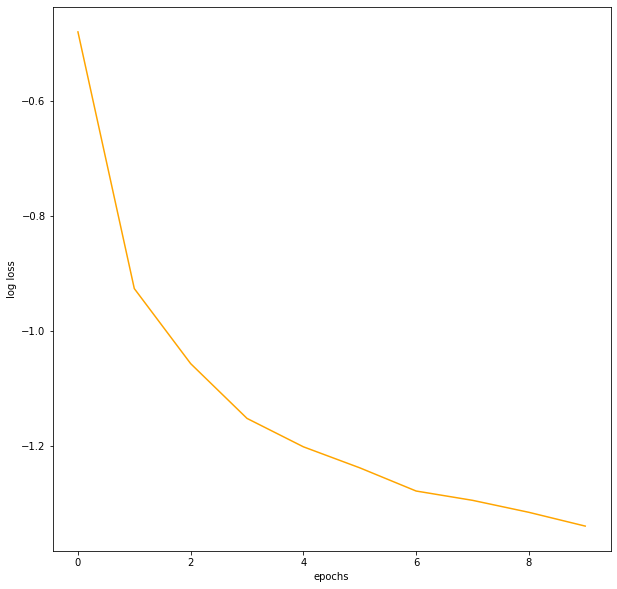

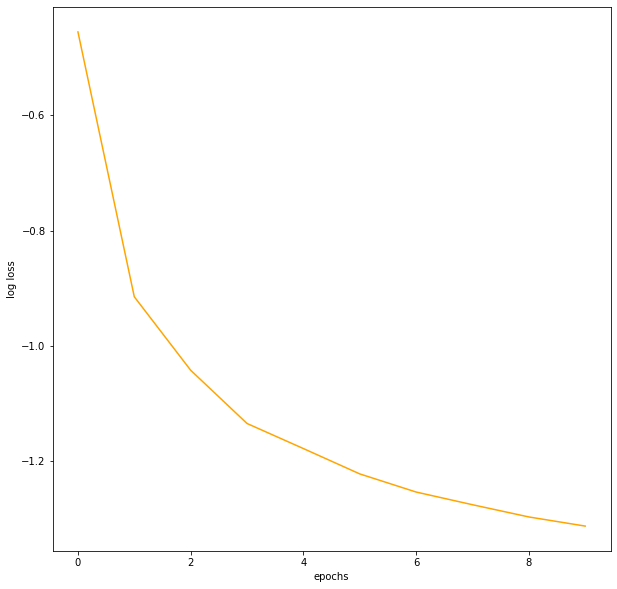

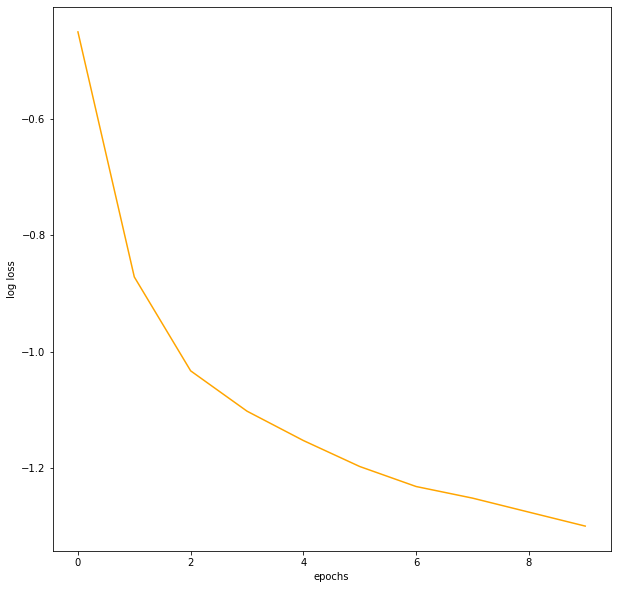

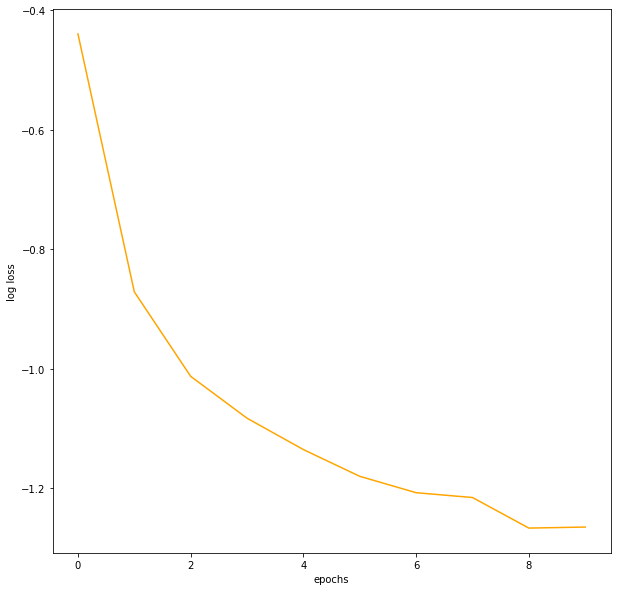

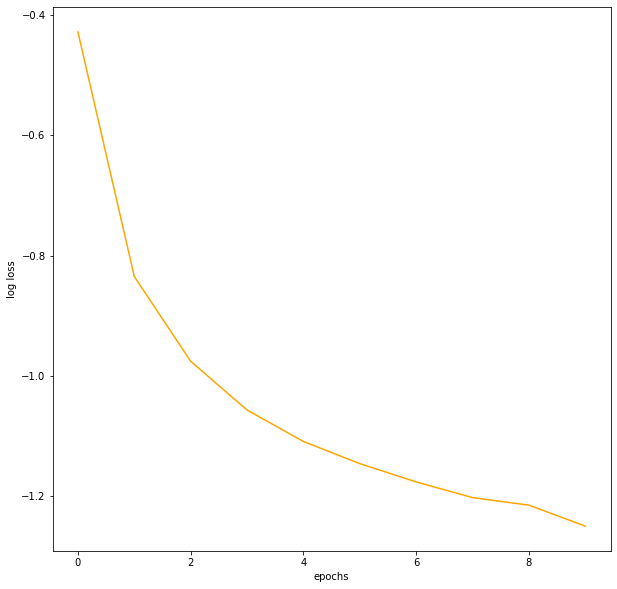

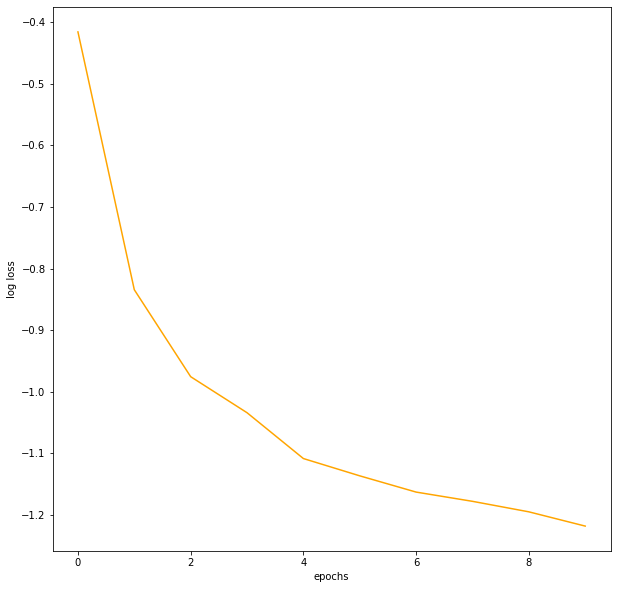

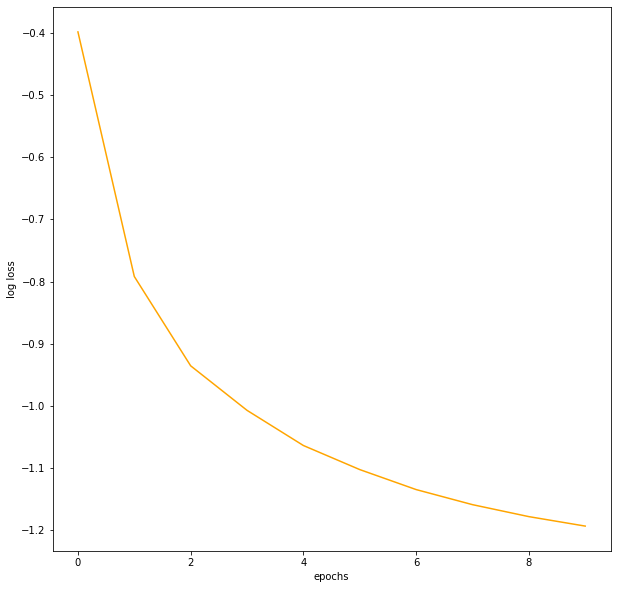

In [10]:
lambdas = 10**torch.linspace(-4,-2,100)
losseslam=[]
for lam in tqdm(lambdas):
    modellam = Model(28*28, 500, 10,1, [0,0,0,0,0],0,True)
    modellam.train(train_dl,epochs = 10, learning_rate=optimal_lr.item(),lam=lam)
    losslam = modellam.test(test_dl)
    losseslam.append(losslam)

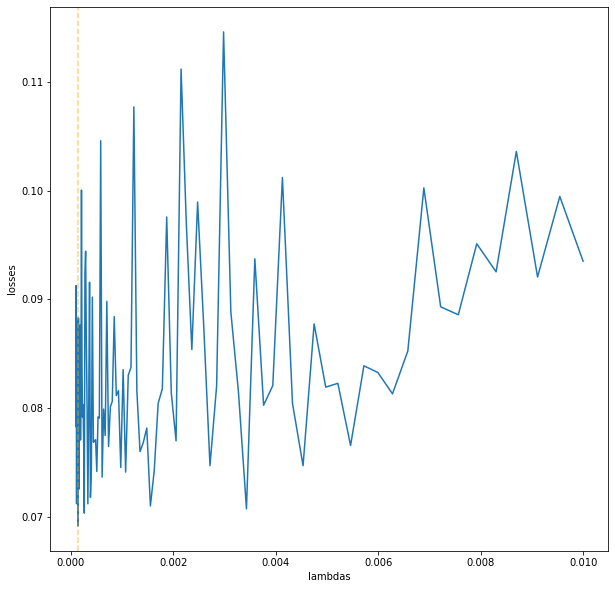

In [12]:
## lr vs losses:
optimal_lam = lambdas[losseslam.index(min(losseslam))]
plt.figure(figsize=(10,10))
plt.plot(lambdas,losseslam)
plt.xlabel('lambdas')
plt.ylabel('losses')
plt.axvline(x=optimal_lam,color='orange',linestyle='--',alpha=0.5)

In [13]:
print(f'optimal lambda: \n{optimal_lam.item():.7f}')
print(f'least testing loss: {min(losseslam):.4f}')

optimal lambda: 
0.0001451
least testing loss: 0.0692


#### 3. Deciding the number of hidden nodes: 

To choose the optimal number of neurons in each layer we ran an experiment where we trained the shallow network for 10 epochs each where in each time the number of neurons is different. The models were run at optimal regularisation term and optimal learning rate

  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

epoch: 0 loss: 1.0820808410644531
epoch: 1 loss: 0.47718870639801025
epoch: 2 loss: 0.4014931321144104
epoch: 3 loss: 0.37209147214889526
epoch: 4 loss: 0.3530702292919159
epoch: 5 loss: 0.34030988812446594
epoch: 6 loss: 0.3291921019554138
epoch: 7 loss: 0.32174181938171387
epoch: 8 loss: 0.3121725618839264
epoch: 9 loss: 0.30490532517433167
91.43833518028259 %


 17%|█████████████▊                                                                     | 1/6 [01:59<09:59, 119.88s/it]

epoch: 0 loss: 0.6050990223884583
epoch: 1 loss: 0.3139187693595886
epoch: 2 loss: 0.2584412097930908
epoch: 3 loss: 0.21723724901676178
epoch: 4 loss: 0.18252813816070557
epoch: 5 loss: 0.15864048898220062
epoch: 6 loss: 0.1411604881286621
epoch: 7 loss: 0.1256299912929535
epoch: 8 loss: 0.11652044206857681
epoch: 9 loss: 0.10840285569429398
97.0116674900055 %


 33%|███████████████████████████▋                                                       | 2/6 [04:09<08:10, 122.66s/it]

epoch: 0 loss: 0.5220993757247925
epoch: 1 loss: 0.27437642216682434
epoch: 2 loss: 0.2068951278924942
epoch: 3 loss: 0.16737167537212372
epoch: 4 loss: 0.1379043459892273
epoch: 5 loss: 0.11777258664369583
epoch: 6 loss: 0.10484553128480911
epoch: 7 loss: 0.09463168680667877
epoch: 8 loss: 0.08543027192354202
epoch: 9 loss: 0.07915530353784561
97.97499775886536 %


 50%|█████████████████████████████████████████▌                                         | 3/6 [06:30<06:25, 128.40s/it]

epoch: 0 loss: 0.4924348294734955
epoch: 1 loss: 0.24508726596832275
epoch: 2 loss: 0.17482100427150726
epoch: 3 loss: 0.13898614048957825
epoch: 4 loss: 0.11778540909290314
epoch: 5 loss: 0.10180788487195969
epoch: 6 loss: 0.09076986461877823
epoch: 7 loss: 0.08249352872371674
epoch: 8 loss: 0.07425567507743835
epoch: 9 loss: 0.06795822083950043
98.26666712760925 %


 67%|███████████████████████████████████████████████████████▎                           | 4/6 [09:00<04:29, 134.93s/it]

epoch: 0 loss: 0.44643911719322205
epoch: 1 loss: 0.21785280108451843
epoch: 2 loss: 0.1569344699382782
epoch: 3 loss: 0.1225227564573288
epoch: 4 loss: 0.10281401872634888
epoch: 5 loss: 0.09241094440221786
epoch: 6 loss: 0.08227503299713135
epoch: 7 loss: 0.07660530507564545
epoch: 8 loss: 0.06706248968839645
epoch: 9 loss: 0.06444753706455231
98.7416684627533 %


 83%|█████████████████████████████████████████████████████████████████████▏             | 5/6 [11:50<02:25, 145.20s/it]

epoch: 0 loss: 0.44183000922203064
epoch: 1 loss: 0.20243874192237854
epoch: 2 loss: 0.14503660798072815
epoch: 3 loss: 0.12158914655447006
epoch: 4 loss: 0.10037500411272049
epoch: 5 loss: 0.08955162763595581
epoch: 6 loss: 0.07924691587686539
epoch: 7 loss: 0.07074212282896042
epoch: 8 loss: 0.06230127066373825
epoch: 9 loss: 0.05974850431084633
98.48499894142151 %


100%|███████████████████████████████████████████████████████████████████████████████████| 6/6 [14:44<00:00, 147.44s/it]


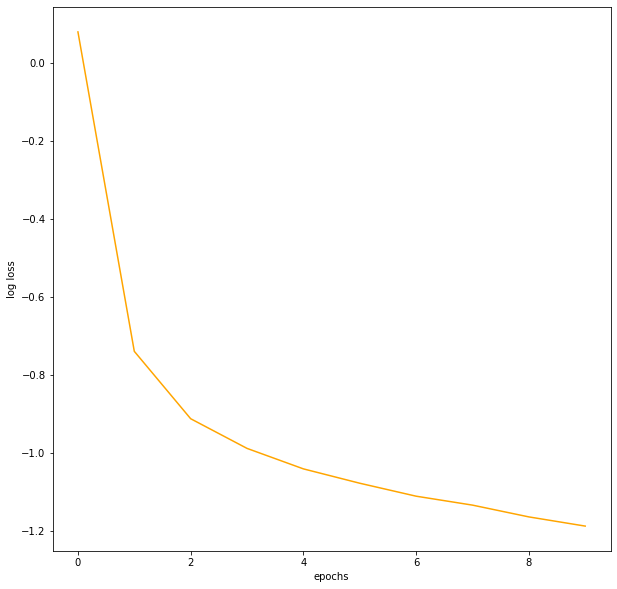

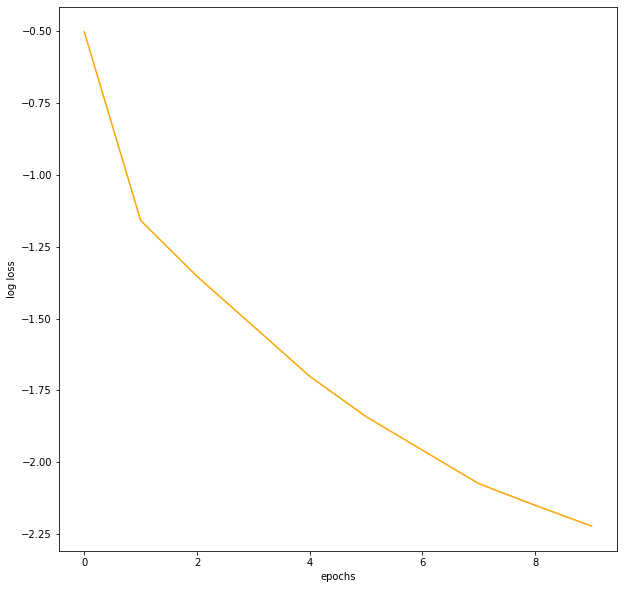

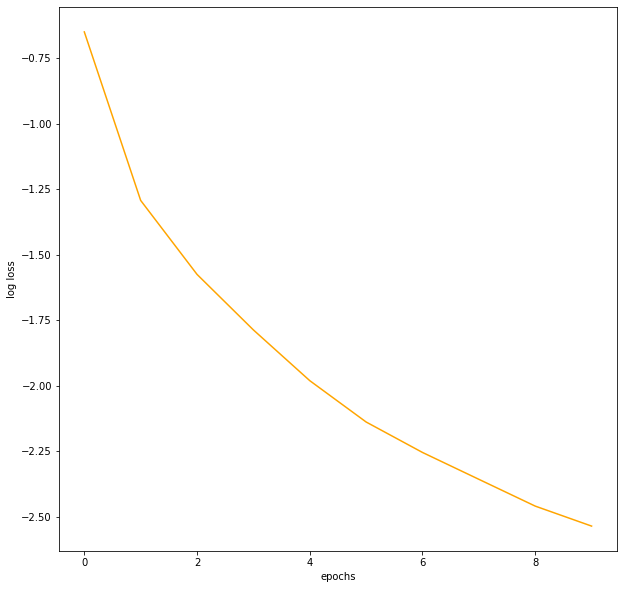

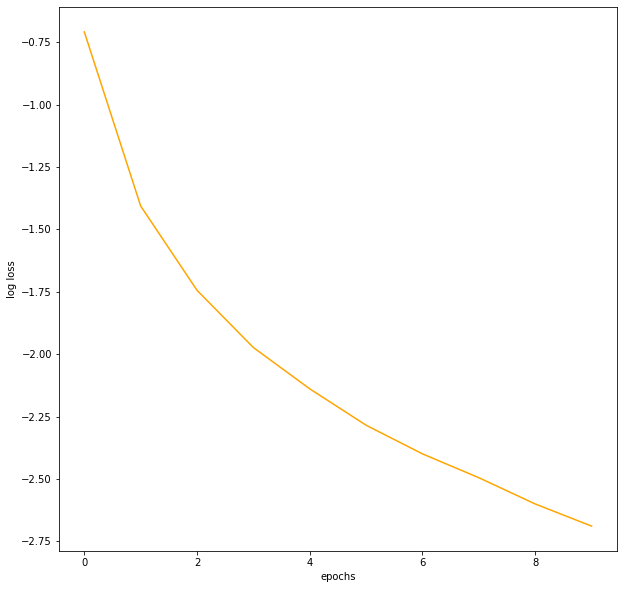

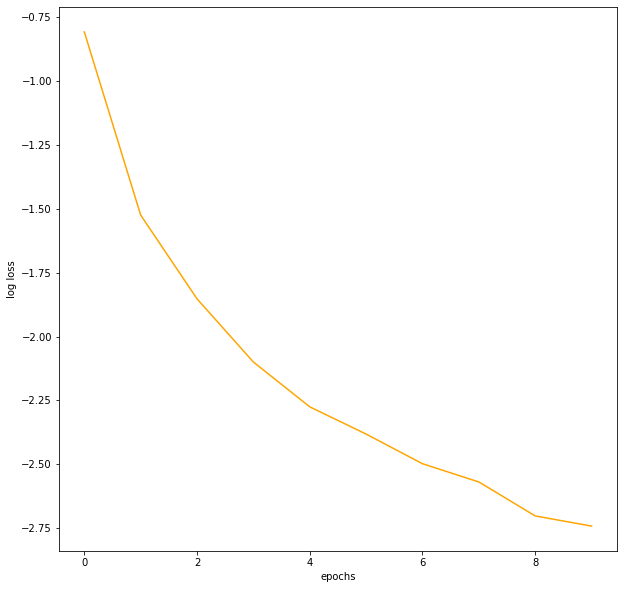

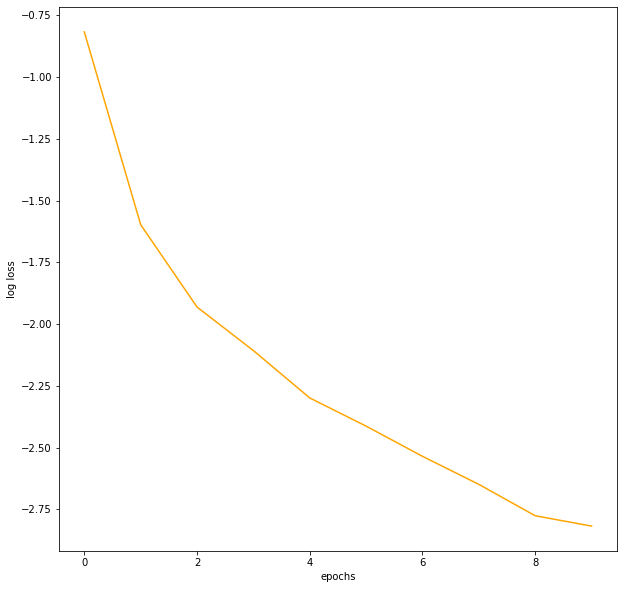

In [14]:
n_nodes = [20,100,200,300,400,500]

for n in tqdm(n_nodes):
    modelnode = Model(28*28, n, 10,1, [0,0,0,0,0],0,True)
    modelnode.train(train_dl,epochs = 10, learning_rate=optimal_lr.item(),lam=optimal_lam)
    get_accuracy(mnist_train,modelnode)

#### Expectation:
The expectation was to see increamental performance based on training accuracy as the model size increases.

#### Observation:
The model performed as expected as we moved from 20 to 400 neurons incrementally. with 91.43% accuracy at 20 nodes and 98.74 % accuracy at 400 nodes however at 500 nodes unexpectedly the model gave 98.48% accuracy with a drop of 0.26% from past value.

Hence we choosed the optimal <b>number of nodes</b> as <b>400</b> going ahead in the experiments.

#### 4. finding the optimal dropout value:

We have tested 50 different dropout values in between 5% to 50% on the shallow network that we used earlier with the optimal learning rate and regularisation term . The test loss is choosen as the metrics based on which we picked the optimal value. 

  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

epoch: 0 loss: 0.5747753977775574
epoch: 1 loss: 0.22212141752243042
epoch: 2 loss: 0.16444098949432373
epoch: 3 loss: 0.1419851928949356
epoch: 4 loss: 0.12107273936271667
epoch: 5 loss: 0.10805077850818634
epoch: 6 loss: 0.10026304423809052
epoch: 7 loss: 0.0947379469871521
epoch: 8 loss: 0.08290468901395798
epoch: 9 loss: 0.08046087622642517
0.08284962587603781


  2%|█▌                                                                            | 1/50 [41:55<34:14:05, 2515.22s/it]

epoch: 0 loss: 0.5968316197395325
epoch: 1 loss: 0.22629670798778534
epoch: 2 loss: 0.1696750819683075
epoch: 3 loss: 0.1428568959236145
epoch: 4 loss: 0.11940502375364304
epoch: 5 loss: 0.11039415746927261
epoch: 6 loss: 0.10068360716104507
epoch: 7 loss: 0.09137032181024551
epoch: 8 loss: 0.08329196274280548
epoch: 9 loss: 0.07783810049295425
0.09148727524200384


  4%|███                                                                           | 2/50 [46:19<24:31:59, 1839.99s/it]

epoch: 0 loss: 0.591564953327179
epoch: 1 loss: 0.23932848870754242
epoch: 2 loss: 0.1794605404138565
epoch: 3 loss: 0.14564527571201324
epoch: 4 loss: 0.12472182512283325
epoch: 5 loss: 0.11411581188440323
epoch: 6 loss: 0.103610560297966
epoch: 7 loss: 0.09617318212985992
epoch: 8 loss: 0.08821272104978561
epoch: 9 loss: 0.07905379682779312
0.12800989518070274


  6%|████▋                                                                         | 3/50 [50:42<17:50:35, 1366.71s/it]

epoch: 0 loss: 0.5847460627555847
epoch: 1 loss: 0.22746020555496216
epoch: 2 loss: 0.1718113273382187
epoch: 3 loss: 0.1480131894350052
epoch: 4 loss: 0.1258823275566101
epoch: 5 loss: 0.11270953714847565
epoch: 6 loss: 0.10665395110845566
epoch: 7 loss: 0.09840472042560577
epoch: 8 loss: 0.08768674731254578
epoch: 9 loss: 0.0849117860198021
0.12131219703385082


  8%|██████▏                                                                       | 4/50 [55:06<13:14:21, 1036.13s/it]

epoch: 0 loss: 0.5976094007492065
epoch: 1 loss: 0.22944825887680054
epoch: 2 loss: 0.17774686217308044
epoch: 3 loss: 0.14314769208431244
epoch: 4 loss: 0.12486545741558075
epoch: 5 loss: 0.11218396574258804
epoch: 6 loss: 0.1044904887676239
epoch: 7 loss: 0.0944596603512764
epoch: 8 loss: 0.08829674124717712
epoch: 9 loss: 0.08345047384500504
0.10828755106305397


 10%|███████▉                                                                       | 5/50 [59:31<10:03:27, 804.60s/it]

epoch: 0 loss: 0.6091369390487671
epoch: 1 loss: 0.2239687293767929
epoch: 2 loss: 0.17168410122394562
epoch: 3 loss: 0.1425025910139084
epoch: 4 loss: 0.1260511726140976
epoch: 5 loss: 0.11478256434202194
epoch: 6 loss: 0.10295553505420685
epoch: 7 loss: 0.09541045129299164
epoch: 8 loss: 0.0855250358581543
epoch: 9 loss: 0.08625506609678268
0.10522997738201101


 12%|█████████▎                                                                    | 6/50 [1:03:55<7:51:11, 642.54s/it]

epoch: 0 loss: 0.6204800605773926
epoch: 1 loss: 0.2379700392484665
epoch: 2 loss: 0.1734735667705536
epoch: 3 loss: 0.1478489339351654
epoch: 4 loss: 0.1282929629087448
epoch: 5 loss: 0.11373838037252426
epoch: 6 loss: 0.10411055386066437
epoch: 7 loss: 0.09617173671722412
epoch: 8 loss: 0.0900888592004776
epoch: 9 loss: 0.08508651703596115
0.12050747551993597


 14%|██████████▉                                                                   | 7/50 [1:08:21<6:19:24, 529.41s/it]

epoch: 0 loss: 0.6481299996376038
epoch: 1 loss: 0.23127928376197815
epoch: 2 loss: 0.1796465516090393
epoch: 3 loss: 0.14865140616893768
epoch: 4 loss: 0.1340559720993042
epoch: 5 loss: 0.11216519773006439
epoch: 6 loss: 0.10451006889343262
epoch: 7 loss: 0.10159844160079956
epoch: 8 loss: 0.09286587685346603
epoch: 9 loss: 0.0844733864068985
0.10612414679431086


 16%|████████████▍                                                                 | 8/50 [1:12:44<5:14:43, 449.61s/it]

epoch: 0 loss: 0.599391520023346
epoch: 1 loss: 0.2218056321144104
epoch: 2 loss: 0.17330431938171387
epoch: 3 loss: 0.14603622257709503
epoch: 4 loss: 0.1256609559059143
epoch: 5 loss: 0.1109142154455185
epoch: 6 loss: 0.10511121153831482
epoch: 7 loss: 0.09661323577165604
epoch: 8 loss: 0.08918627351522446
epoch: 9 loss: 0.08518707007169724
0.11487560178804553


 18%|██████████████                                                                | 9/50 [1:17:09<4:29:22, 394.20s/it]

epoch: 0 loss: 0.6054985523223877
epoch: 1 loss: 0.23023788630962372
epoch: 2 loss: 0.17986240983009338
epoch: 3 loss: 0.14944469928741455
epoch: 4 loss: 0.1310795545578003
epoch: 5 loss: 0.11788291484117508
epoch: 6 loss: 0.10531942546367645
epoch: 7 loss: 0.09928088635206223
epoch: 8 loss: 0.09640154987573624
epoch: 9 loss: 0.0869598239660263
0.09397658639509361


 20%|███████████████▍                                                             | 10/50 [1:21:37<3:57:36, 356.41s/it]

epoch: 0 loss: 0.6012967824935913
epoch: 1 loss: 0.22560986876487732
epoch: 2 loss: 0.17865821719169617
epoch: 3 loss: 0.15147332847118378
epoch: 4 loss: 0.13077020645141602
epoch: 5 loss: 0.11907865107059479
epoch: 6 loss: 0.10641902685165405
epoch: 7 loss: 0.09920619428157806
epoch: 8 loss: 0.093445785343647
epoch: 9 loss: 0.08689293265342712
0.10233941507861725


 22%|████████████████▉                                                            | 11/50 [1:26:07<3:34:42, 330.33s/it]

epoch: 0 loss: 0.6002514958381653
epoch: 1 loss: 0.23523975908756256
epoch: 2 loss: 0.17888830602169037
epoch: 3 loss: 0.15081800520420074
epoch: 4 loss: 0.1334092915058136
epoch: 5 loss: 0.12325669080018997
epoch: 6 loss: 0.11161502450704575
epoch: 7 loss: 0.10199083387851715
epoch: 8 loss: 0.09748483449220657
epoch: 9 loss: 0.08708196878433228
0.09212320654257349


 24%|██████████████████▍                                                          | 12/50 [1:28:48<2:57:10, 279.75s/it]

epoch: 0 loss: 0.6317377686500549
epoch: 1 loss: 0.240348681807518
epoch: 2 loss: 0.18668468296527863
epoch: 3 loss: 0.1535884439945221
epoch: 4 loss: 0.13281407952308655
epoch: 5 loss: 0.11856620758771896
epoch: 6 loss: 0.1061440110206604
epoch: 7 loss: 0.10468333959579468
epoch: 8 loss: 0.09492044150829315
epoch: 9 loss: 0.09158003330230713
0.11499616979839446


 26%|████████████████████                                                         | 13/50 [1:31:28<2:30:18, 243.73s/it]

epoch: 0 loss: 0.6324082016944885
epoch: 1 loss: 0.2440422773361206
epoch: 2 loss: 0.1812608540058136
epoch: 3 loss: 0.15858526527881622
epoch: 4 loss: 0.1345045119524002
epoch: 5 loss: 0.12149396538734436
epoch: 6 loss: 0.11443949490785599
epoch: 7 loss: 0.10120679438114166
epoch: 8 loss: 0.09363628923892975
epoch: 9 loss: 0.09447638690471649
0.10210658622834878


 28%|█████████████████████▌                                                       | 14/50 [1:34:06<2:10:47, 217.99s/it]

epoch: 0 loss: 0.6369932889938354
epoch: 1 loss: 0.23371438682079315
epoch: 2 loss: 0.1764114499092102
epoch: 3 loss: 0.15834616124629974
epoch: 4 loss: 0.13343484699726105
epoch: 5 loss: 0.12086895853281021
epoch: 6 loss: 0.10864651203155518
epoch: 7 loss: 0.10272414982318878
epoch: 8 loss: 0.09532307833433151
epoch: 9 loss: 0.09245014190673828
0.13822772544278186


 30%|███████████████████████                                                      | 15/50 [1:36:43<1:56:29, 199.70s/it]

epoch: 0 loss: 0.6342636942863464
epoch: 1 loss: 0.23367363214492798
epoch: 2 loss: 0.17979004979133606
epoch: 3 loss: 0.15182355046272278
epoch: 4 loss: 0.1353972852230072
epoch: 5 loss: 0.12079111486673355
epoch: 6 loss: 0.11517626792192459
epoch: 7 loss: 0.1026730015873909
epoch: 8 loss: 0.09814202785491943
epoch: 9 loss: 0.08944769948720932
0.09985826753173466


 32%|████████████████████████▋                                                    | 16/50 [1:39:21<1:46:00, 187.09s/it]

epoch: 0 loss: 0.6503508687019348
epoch: 1 loss: 0.2352234572172165
epoch: 2 loss: 0.1878204196691513
epoch: 3 loss: 0.15229861438274384
epoch: 4 loss: 0.13638366758823395
epoch: 5 loss: 0.12062564492225647
epoch: 6 loss: 0.1101120263338089
epoch: 7 loss: 0.1016906127333641
epoch: 8 loss: 0.09117121249437332
epoch: 9 loss: 0.0895124226808548
0.10067053898046076


 34%|██████████████████████████▏                                                  | 17/50 [1:41:58<1:37:59, 178.18s/it]

epoch: 0 loss: 0.6756587624549866
epoch: 1 loss: 0.24660423398017883
epoch: 2 loss: 0.19112683832645416
epoch: 3 loss: 0.15884865820407867
epoch: 4 loss: 0.14118491113185883
epoch: 5 loss: 0.12299175560474396
epoch: 6 loss: 0.1100107729434967
epoch: 7 loss: 0.10217026621103287
epoch: 8 loss: 0.09779322147369385
epoch: 9 loss: 0.09344041347503662
0.09671551008307952


 36%|███████████████████████████▋                                                 | 18/50 [1:44:35<1:31:40, 171.90s/it]

epoch: 0 loss: 0.7338525652885437
epoch: 1 loss: 0.24880217015743256
epoch: 2 loss: 0.19113264977931976
epoch: 3 loss: 0.15987293422222137
epoch: 4 loss: 0.13737154006958008
epoch: 5 loss: 0.12733469903469086
epoch: 6 loss: 0.11154606193304062
epoch: 7 loss: 0.10546544194221497
epoch: 8 loss: 0.09835339337587357
epoch: 9 loss: 0.09303567558526993
0.11325971462728479


 38%|█████████████████████████████▎                                               | 19/50 [1:47:13<1:26:33, 167.54s/it]

epoch: 0 loss: 0.7042379975318909
epoch: 1 loss: 0.24628235399723053
epoch: 2 loss: 0.1895304173231125
epoch: 3 loss: 0.15648499131202698
epoch: 4 loss: 0.1391444355249405
epoch: 5 loss: 0.12900415062904358
epoch: 6 loss: 0.1152191311120987
epoch: 7 loss: 0.10591679066419601
epoch: 8 loss: 0.10060997307300568
epoch: 9 loss: 0.0936952531337738
0.11759502353674225


 40%|██████████████████████████████▊                                              | 20/50 [1:49:55<1:22:58, 165.94s/it]

epoch: 0 loss: 0.7546391487121582
epoch: 1 loss: 0.26191699504852295
epoch: 2 loss: 0.19637572765350342
epoch: 3 loss: 0.15962645411491394
epoch: 4 loss: 0.14386847615242004
epoch: 5 loss: 0.1278870701789856
epoch: 6 loss: 0.11888828873634338
epoch: 7 loss: 0.10505690425634384
epoch: 8 loss: 0.09982743114233017
epoch: 9 loss: 0.09667867422103882


C:\Users\Asus\Anaconda3\lib\site-packages\ipykernel_launcher.py:73: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


0.09687296774524229


 42%|████████████████████████████████▎                                            | 21/50 [1:52:34<1:19:17, 164.03s/it]

epoch: 0 loss: 0.759432852268219
epoch: 1 loss: 0.25536367297172546
epoch: 2 loss: 0.19674408435821533
epoch: 3 loss: 0.16241642832756042
epoch: 4 loss: 0.14960958063602448
epoch: 5 loss: 0.13241833448410034
epoch: 6 loss: 0.12197176367044449
epoch: 7 loss: 0.1125829890370369
epoch: 8 loss: 0.10418445616960526
epoch: 9 loss: 0.09735879302024841
0.10549677873348605


 44%|█████████████████████████████████▉                                           | 22/50 [1:55:18<1:16:26, 163.79s/it]

epoch: 0 loss: 0.7029172778129578
epoch: 1 loss: 0.24704588949680328
epoch: 2 loss: 0.1928800642490387
epoch: 3 loss: 0.16090035438537598
epoch: 4 loss: 0.13961723446846008
epoch: 5 loss: 0.12822067737579346
epoch: 6 loss: 0.11644705384969711
epoch: 7 loss: 0.10663318634033203
epoch: 8 loss: 0.10233574360609055
epoch: 9 loss: 0.09724471718072891
0.10602245750671983


 46%|███████████████████████████████████▍                                         | 23/50 [1:57:58<1:13:11, 162.64s/it]

epoch: 0 loss: 0.71934974193573
epoch: 1 loss: 0.24919256567955017
epoch: 2 loss: 0.19422966241836548
epoch: 3 loss: 0.1601405292749405
epoch: 4 loss: 0.14727835357189178
epoch: 5 loss: 0.13192059099674225
epoch: 6 loss: 0.11893441528081894
epoch: 7 loss: 0.11202184110879898
epoch: 8 loss: 0.10777779668569565
epoch: 9 loss: 0.10121101886034012
0.12246811458298677


 48%|████████████████████████████████████▉                                        | 24/50 [2:00:36<1:09:58, 161.48s/it]

epoch: 0 loss: 0.7906109690666199
epoch: 1 loss: 0.2569088637828827
epoch: 2 loss: 0.194936141371727
epoch: 3 loss: 0.16120566427707672
epoch: 4 loss: 0.14521048963069916
epoch: 5 loss: 0.1323135495185852
epoch: 6 loss: 0.12338551133871078
epoch: 7 loss: 0.11076932400465012
epoch: 8 loss: 0.10653342306613922
epoch: 9 loss: 0.10022158175706863
0.11566325525098917


 50%|██████████████████████████████████████▌                                      | 25/50 [2:03:15<1:06:56, 160.67s/it]

epoch: 0 loss: 0.7230002880096436
epoch: 1 loss: 0.259755939245224
epoch: 2 loss: 0.19654059410095215
epoch: 3 loss: 0.16507601737976074
epoch: 4 loss: 0.14583925902843475
epoch: 5 loss: 0.13692627847194672
epoch: 6 loss: 0.12158249318599701
epoch: 7 loss: 0.11811138689517975
epoch: 8 loss: 0.10573363304138184
epoch: 9 loss: 0.10101404786109924
0.13381204163490595


 52%|████████████████████████████████████████                                     | 26/50 [2:05:53<1:03:58, 159.92s/it]

epoch: 0 loss: 0.7989422678947449
epoch: 1 loss: 0.26829683780670166
epoch: 2 loss: 0.2035750299692154
epoch: 3 loss: 0.1652548760175705
epoch: 4 loss: 0.15237560868263245
epoch: 5 loss: 0.13341033458709717
epoch: 6 loss: 0.12356985360383987
epoch: 7 loss: 0.1121932789683342
epoch: 8 loss: 0.10676358640193939
epoch: 9 loss: 0.10605994611978531
0.10635835464964208


 54%|█████████████████████████████████████████▌                                   | 27/50 [2:08:33<1:01:14, 159.75s/it]

epoch: 0 loss: 0.9265137910842896
epoch: 1 loss: 0.2932053804397583
epoch: 2 loss: 0.22413991391658783
epoch: 3 loss: 0.1873098760843277
epoch: 4 loss: 0.16259296238422394
epoch: 5 loss: 0.15551848709583282
epoch: 6 loss: 0.1404535323381424
epoch: 7 loss: 0.12555213272571564
epoch: 8 loss: 0.12246329337358475
epoch: 9 loss: 0.11597297340631485
0.11263346876448044


 56%|████████████████████████████████████████████▏                                  | 28/50 [2:11:12<58:29, 159.54s/it]

epoch: 0 loss: 0.8254069685935974
epoch: 1 loss: 0.27064159512519836
epoch: 2 loss: 0.20438241958618164
epoch: 3 loss: 0.17697782814502716
epoch: 4 loss: 0.15208123624324799
epoch: 5 loss: 0.14233632385730743
epoch: 6 loss: 0.12747341394424438
epoch: 7 loss: 0.12072700262069702
epoch: 8 loss: 0.11508011817932129
epoch: 9 loss: 0.10720404237508774
0.13423482434753375


 58%|█████████████████████████████████████████████▊                                 | 29/50 [2:13:55<56:12, 160.62s/it]

epoch: 0 loss: 0.8781693577766418
epoch: 1 loss: 0.274895042181015
epoch: 2 loss: 0.21004687249660492
epoch: 3 loss: 0.1820126622915268
epoch: 4 loss: 0.16078191995620728
epoch: 5 loss: 0.15061348676681519
epoch: 6 loss: 0.13544724881649017
epoch: 7 loss: 0.12662483751773834
epoch: 8 loss: 0.11664853990077972
epoch: 9 loss: 0.10881166160106659
0.12618558085228823


 60%|███████████████████████████████████████████████▍                               | 30/50 [2:16:34<53:21, 160.09s/it]

epoch: 0 loss: 0.9340226054191589
epoch: 1 loss: 0.28398773074150085
epoch: 2 loss: 0.21438993513584137
epoch: 3 loss: 0.18498866260051727
epoch: 4 loss: 0.1594993621110916
epoch: 5 loss: 0.1477855145931244
epoch: 6 loss: 0.13353130221366882
epoch: 7 loss: 0.12617097795009613
epoch: 8 loss: 0.12048857659101486
epoch: 9 loss: 0.10911663621664047
0.1283625128525722


 62%|████████████████████████████████████████████████▉                              | 31/50 [2:19:11<50:27, 159.34s/it]

epoch: 0 loss: 0.8438860774040222
epoch: 1 loss: 0.27910563349723816
epoch: 2 loss: 0.21173685789108276
epoch: 3 loss: 0.17906337976455688
epoch: 4 loss: 0.1577487736940384
epoch: 5 loss: 0.14163370430469513
epoch: 6 loss: 0.13491293787956238
epoch: 7 loss: 0.12700127065181732
epoch: 8 loss: 0.11654441058635712
epoch: 9 loss: 0.10955101251602173
0.12209490432604393


 64%|██████████████████████████████████████████████████▌                            | 32/50 [2:21:49<47:37, 158.75s/it]

epoch: 0 loss: 0.9999436140060425
epoch: 1 loss: 0.3105112314224243
epoch: 2 loss: 0.22309471666812897
epoch: 3 loss: 0.19085070490837097
epoch: 4 loss: 0.16688497364521027
epoch: 5 loss: 0.1497199535369873
epoch: 6 loss: 0.14186474680900574
epoch: 7 loss: 0.13140928745269775
epoch: 8 loss: 0.12246844917535782
epoch: 9 loss: 0.11549012362957001
0.14004356147650676


 66%|████████████████████████████████████████████████████▏                          | 33/50 [2:24:26<44:50, 158.27s/it]

epoch: 0 loss: 0.9898313879966736
epoch: 1 loss: 0.2972638010978699
epoch: 2 loss: 0.22763554751873016
epoch: 3 loss: 0.18779601156711578
epoch: 4 loss: 0.16737864911556244
epoch: 5 loss: 0.14777906239032745
epoch: 6 loss: 0.1414683610200882
epoch: 7 loss: 0.1375405490398407
epoch: 8 loss: 0.12366363406181335
epoch: 9 loss: 0.11965536326169968
0.142313416266248


 68%|█████████████████████████████████████████████████████▋                         | 34/50 [2:27:02<42:04, 157.78s/it]

epoch: 0 loss: 1.045464277267456
epoch: 1 loss: 0.30679741501808167
epoch: 2 loss: 0.23359322547912598
epoch: 3 loss: 0.19511063396930695
epoch: 4 loss: 0.17959155142307281
epoch: 5 loss: 0.1542227864265442
epoch: 6 loss: 0.14315082132816315
epoch: 7 loss: 0.13425885140895844
epoch: 8 loss: 0.1295911818742752
epoch: 9 loss: 0.11999886482954025
0.1324610895391766


 70%|███████████████████████████████████████████████████████▎                       | 35/50 [2:29:41<39:31, 158.08s/it]

epoch: 0 loss: 0.935038149356842
epoch: 1 loss: 0.2914198040962219
epoch: 2 loss: 0.23070739209651947
epoch: 3 loss: 0.19998489320278168
epoch: 4 loss: 0.17515923082828522
epoch: 5 loss: 0.15622705221176147
epoch: 6 loss: 0.14441773295402527
epoch: 7 loss: 0.13924971222877502
epoch: 8 loss: 0.13074347376823425
epoch: 9 loss: 0.12107869237661362
0.12004982175812408


 72%|████████████████████████████████████████████████████████▉                      | 36/50 [2:32:19<36:51, 157.97s/it]

epoch: 0 loss: 1.0423349142074585
epoch: 1 loss: 0.31129786372184753
epoch: 2 loss: 0.24143995344638824
epoch: 3 loss: 0.2068755030632019
epoch: 4 loss: 0.18658319115638733
epoch: 5 loss: 0.16323724389076233
epoch: 6 loss: 0.15238407254219055
epoch: 7 loss: 0.14370082318782806
epoch: 8 loss: 0.13505831360816956
epoch: 9 loss: 0.1282489150762558
0.15389650555539736


 74%|██████████████████████████████████████████████████████████▍                    | 37/50 [2:34:57<34:13, 157.98s/it]

epoch: 0 loss: 1.1608507633209229
epoch: 1 loss: 0.3762419521808624
epoch: 2 loss: 0.27195900678634644
epoch: 3 loss: 0.222603440284729
epoch: 4 loss: 0.19784598052501678
epoch: 5 loss: 0.18082202970981598
epoch: 6 loss: 0.16883692145347595
epoch: 7 loss: 0.15450185537338257
epoch: 8 loss: 0.14582249522209167
epoch: 9 loss: 0.1362181007862091
0.14733735325486882


 76%|████████████████████████████████████████████████████████████                   | 38/50 [2:37:34<31:31, 157.65s/it]

epoch: 0 loss: 1.10140061378479
epoch: 1 loss: 0.3222613036632538
epoch: 2 loss: 0.24255377054214478
epoch: 3 loss: 0.20619645714759827
epoch: 4 loss: 0.18579213321208954
epoch: 5 loss: 0.16606944799423218
epoch: 6 loss: 0.15260912477970123
epoch: 7 loss: 0.14132259786128998
epoch: 8 loss: 0.13745921850204468
epoch: 9 loss: 0.13302235305309296
0.14733284739246946


 78%|█████████████████████████████████████████████████████████████▌                 | 39/50 [2:40:13<28:57, 157.98s/it]

epoch: 0 loss: 1.0912971496582031
epoch: 1 loss: 0.31178832054138184
epoch: 2 loss: 0.24081440269947052
epoch: 3 loss: 0.20381112396717072
epoch: 4 loss: 0.1834351271390915
epoch: 5 loss: 0.16550268232822418
epoch: 6 loss: 0.15569500625133514
epoch: 7 loss: 0.14439143240451813
epoch: 8 loss: 0.14201720058918
epoch: 9 loss: 0.1335584968328476
0.1477476454493177


 80%|███████████████████████████████████████████████████████████████▏               | 40/50 [2:42:49<26:15, 157.54s/it]

epoch: 0 loss: 1.0821737051010132
epoch: 1 loss: 0.34861284494400024
epoch: 2 loss: 0.27082473039627075
epoch: 3 loss: 0.23333732783794403
epoch: 4 loss: 0.2066900134086609
epoch: 5 loss: 0.18913859128952026
epoch: 6 loss: 0.17274311184883118
epoch: 7 loss: 0.1648309826850891
epoch: 8 loss: 0.15483739972114563
epoch: 9 loss: 0.14905719459056854
0.17624224632789817


 82%|████████████████████████████████████████████████████████████████▊              | 41/50 [2:45:30<23:45, 158.43s/it]

epoch: 0 loss: 1.158673882484436
epoch: 1 loss: 0.3302825689315796
epoch: 2 loss: 0.2518024444580078
epoch: 3 loss: 0.20943988859653473
epoch: 4 loss: 0.19116711616516113
epoch: 5 loss: 0.17078043520450592
epoch: 6 loss: 0.1649269163608551
epoch: 7 loss: 0.1550673097372055
epoch: 8 loss: 0.14540621638298035
epoch: 9 loss: 0.13524354994297028
0.16714861625923386


 84%|██████████████████████████████████████████████████████████████████▎            | 42/50 [2:48:07<21:04, 158.04s/it]

epoch: 0 loss: 1.2347770929336548
epoch: 1 loss: 0.3608814477920532
epoch: 2 loss: 0.2688460946083069
epoch: 3 loss: 0.2259763777256012
epoch: 4 loss: 0.20313259959220886
epoch: 5 loss: 0.1848258227109909
epoch: 6 loss: 0.16990531980991364
epoch: 7 loss: 0.1556611806154251
epoch: 8 loss: 0.14820779860019684
epoch: 9 loss: 0.14688202738761902
0.15556635741509875


 86%|███████████████████████████████████████████████████████████████████▉           | 43/50 [2:50:44<18:25, 157.91s/it]

epoch: 0 loss: 1.1885401010513306
epoch: 1 loss: 0.364358514547348
epoch: 2 loss: 0.28838402032852173
epoch: 3 loss: 0.23448345065116882
epoch: 4 loss: 0.2114224135875702
epoch: 5 loss: 0.18969130516052246
epoch: 6 loss: 0.17689934372901917
epoch: 7 loss: 0.1653672605752945
epoch: 8 loss: 0.1623416393995285
epoch: 9 loss: 0.15016613900661469
0.16255602804660985


 88%|█████████████████████████████████████████████████████████████████████▌         | 44/50 [2:53:22<15:47, 157.96s/it]

epoch: 0 loss: 1.3819799423217773
epoch: 1 loss: 0.4900524318218231
epoch: 2 loss: 0.34237366914749146
epoch: 3 loss: 0.27437692880630493
epoch: 4 loss: 0.24697859585285187
epoch: 5 loss: 0.22082309424877167
epoch: 6 loss: 0.2071695327758789
epoch: 7 loss: 0.19591274857521057
epoch: 8 loss: 0.18253794312477112
epoch: 9 loss: 0.17374086380004883
0.18337554140370102


 90%|███████████████████████████████████████████████████████████████████████        | 45/50 [2:56:00<13:09, 157.98s/it]

epoch: 0 loss: 1.3192099332809448
epoch: 1 loss: 0.3929520845413208
epoch: 2 loss: 0.2877151072025299
epoch: 3 loss: 0.2534997761249542
epoch: 4 loss: 0.2240554541349411
epoch: 5 loss: 0.20269320905208588
epoch: 6 loss: 0.19141161441802979
epoch: 7 loss: 0.17515741288661957
epoch: 8 loss: 0.1674862504005432
epoch: 9 loss: 0.1638200283050537
0.16693876505847077


 92%|████████████████████████████████████████████████████████████████████████▋      | 46/50 [2:58:46<10:40, 160.22s/it]

epoch: 0 loss: 1.247153878211975
epoch: 1 loss: 0.39922958612442017
epoch: 2 loss: 0.2909311354160309
epoch: 3 loss: 0.25469088554382324
epoch: 4 loss: 0.22449645400047302
epoch: 5 loss: 0.21016448736190796
epoch: 6 loss: 0.19535642862319946
epoch: 7 loss: 0.17890644073486328
epoch: 8 loss: 0.17315234243869781
epoch: 9 loss: 0.16911689937114716
0.17715355132623942


 94%|██████████████████████████████████████████████████████████████████████████▎    | 47/50 [3:01:25<08:00, 160.01s/it]

epoch: 0 loss: 1.2640442848205566
epoch: 1 loss: 0.3898712694644928
epoch: 2 loss: 0.28794223070144653
epoch: 3 loss: 0.23933884501457214
epoch: 4 loss: 0.21420343220233917
epoch: 5 loss: 0.19913630187511444
epoch: 6 loss: 0.18692515790462494
epoch: 7 loss: 0.17276012897491455
epoch: 8 loss: 0.1630188375711441
epoch: 9 loss: 0.15855419635772705
0.21650656880928745


 96%|███████████████████████████████████████████████████████████████████████████▊   | 48/50 [3:04:04<05:19, 159.55s/it]

epoch: 0 loss: 1.2908223867416382
epoch: 1 loss: 0.41682103276252747
epoch: 2 loss: 0.3069084584712982
epoch: 3 loss: 0.2631082534790039
epoch: 4 loss: 0.24241609871387482
epoch: 5 loss: 0.21966004371643066
epoch: 6 loss: 0.2080697864294052
epoch: 7 loss: 0.18975922465324402
epoch: 8 loss: 0.18300892412662506
epoch: 9 loss: 0.17750225961208344
0.1805564978077442


 98%|█████████████████████████████████████████████████████████████████████████████▍ | 49/50 [3:06:42<02:39, 159.02s/it]

epoch: 0 loss: 1.3900892734527588
epoch: 1 loss: 0.4990772306919098
epoch: 2 loss: 0.3468490540981293
epoch: 3 loss: 0.28942394256591797
epoch: 4 loss: 0.26315808296203613
epoch: 5 loss: 0.2426774799823761
epoch: 6 loss: 0.22087416052818298
epoch: 7 loss: 0.2053978443145752
epoch: 8 loss: 0.19462458789348602
epoch: 9 loss: 0.1878085881471634
0.21990620855336326


100%|███████████████████████████████████████████████████████████████████████████████| 50/50 [3:09:20<00:00, 227.20s/it]


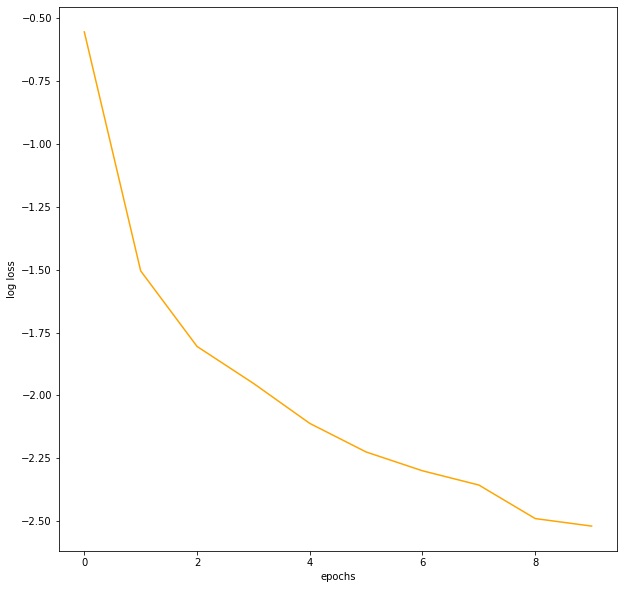

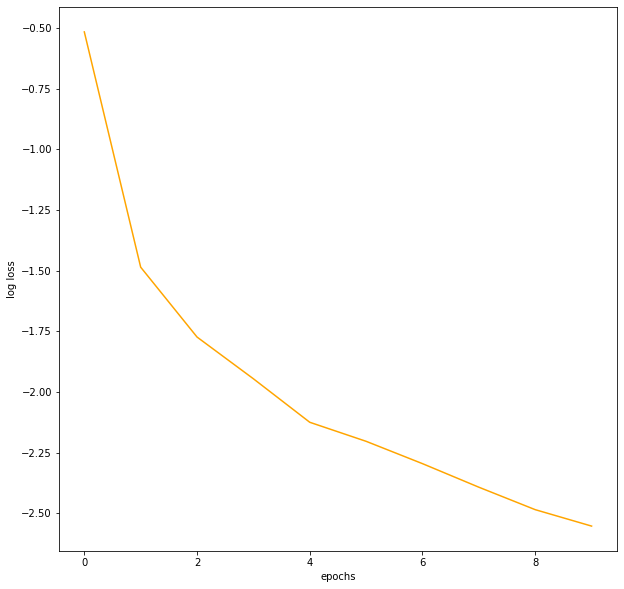

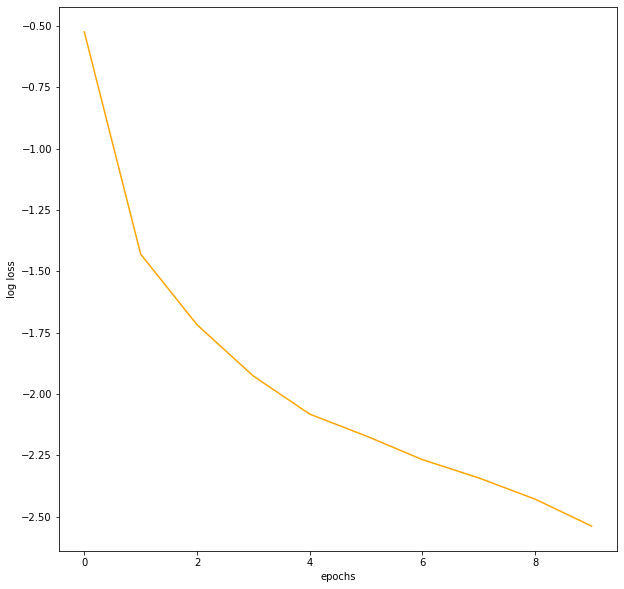

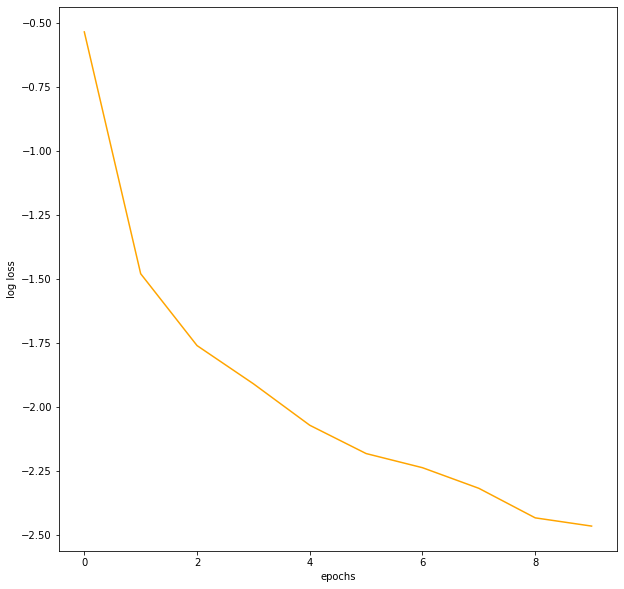

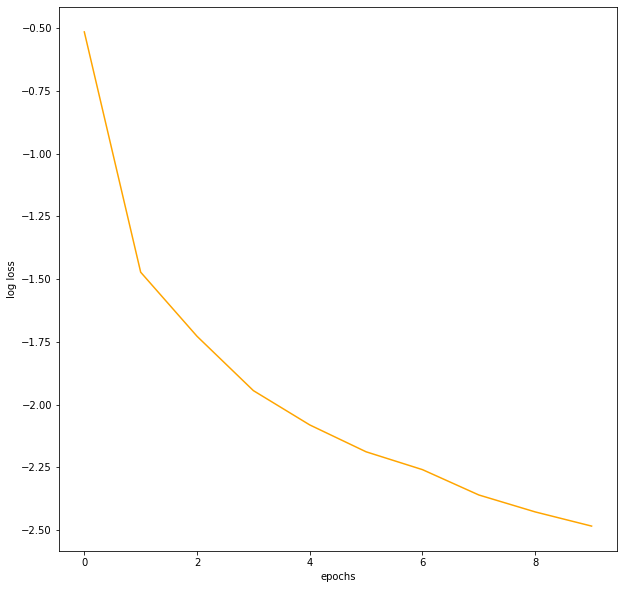

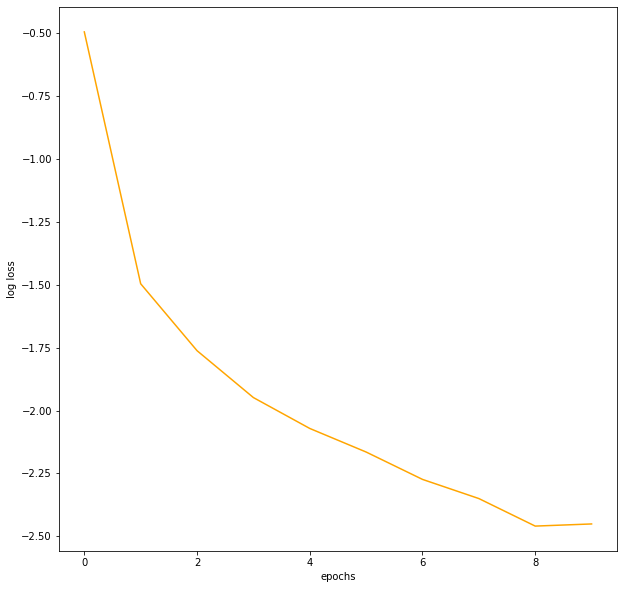

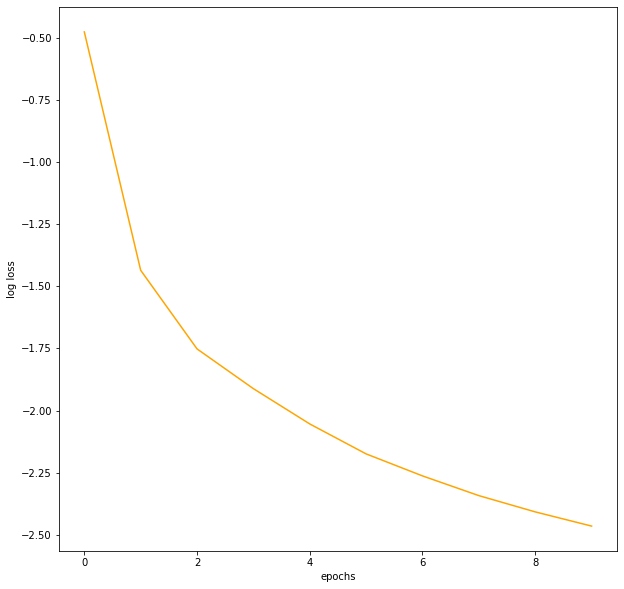

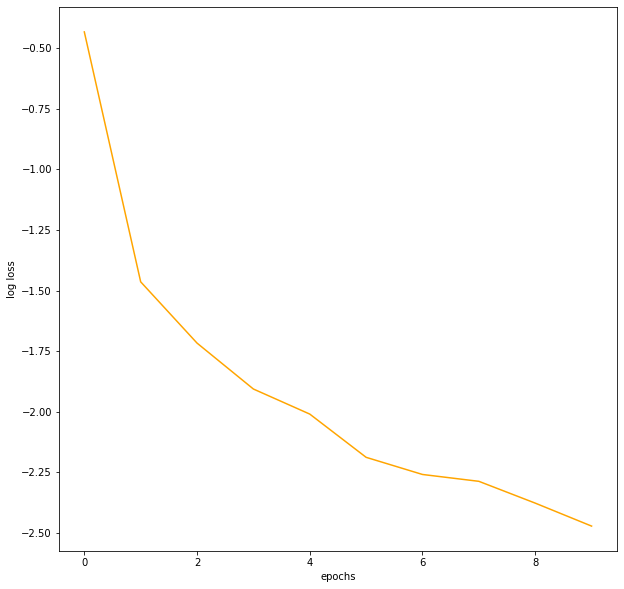

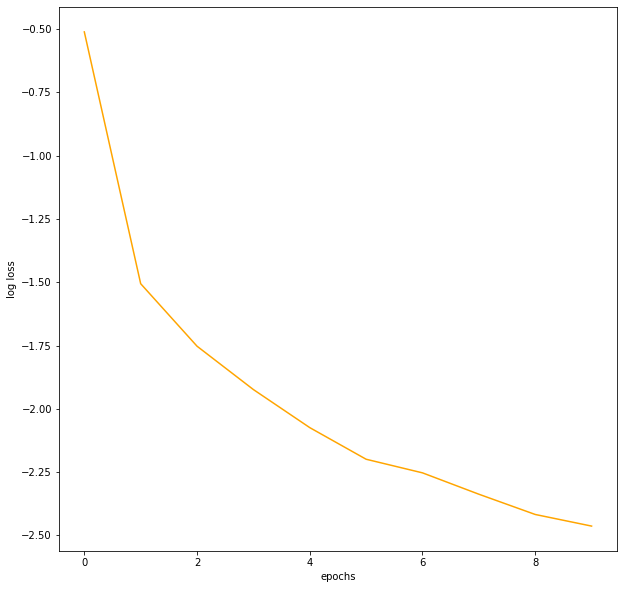

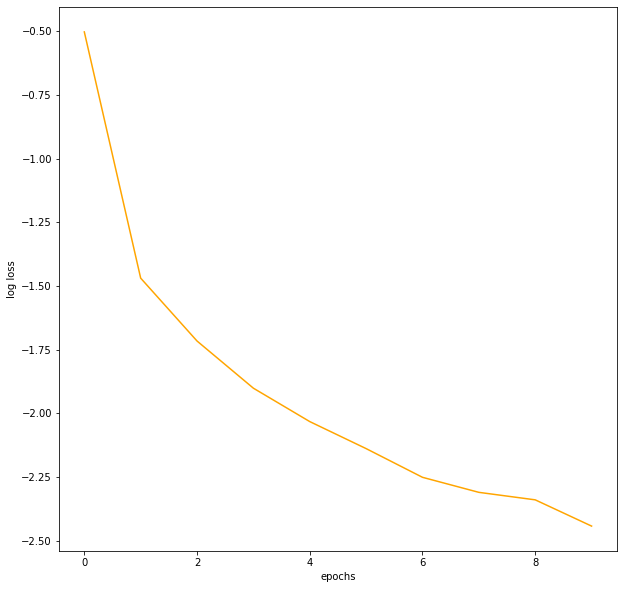

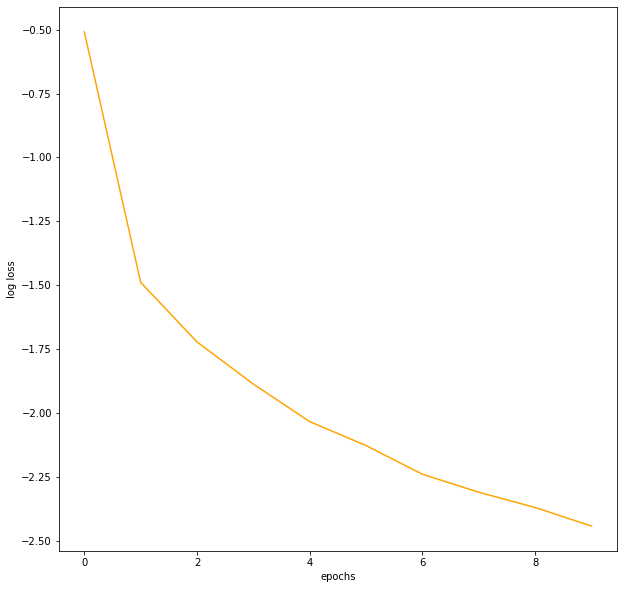

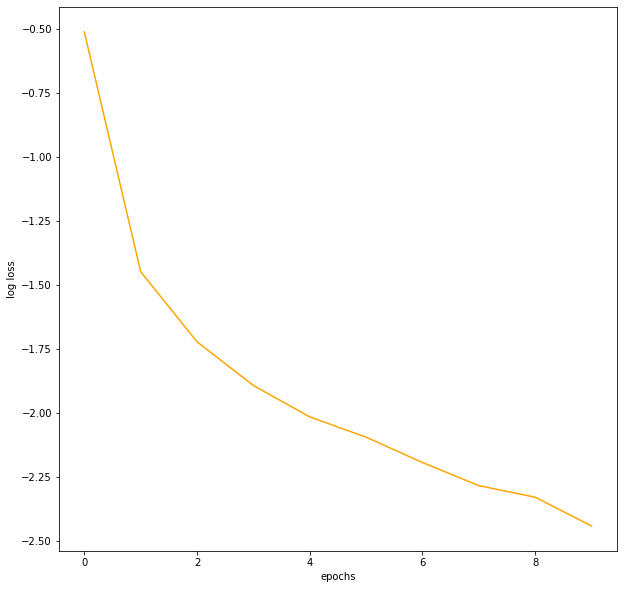

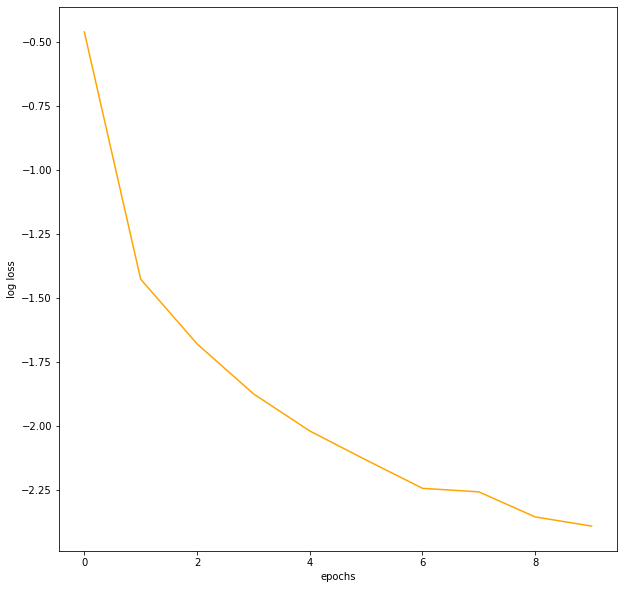

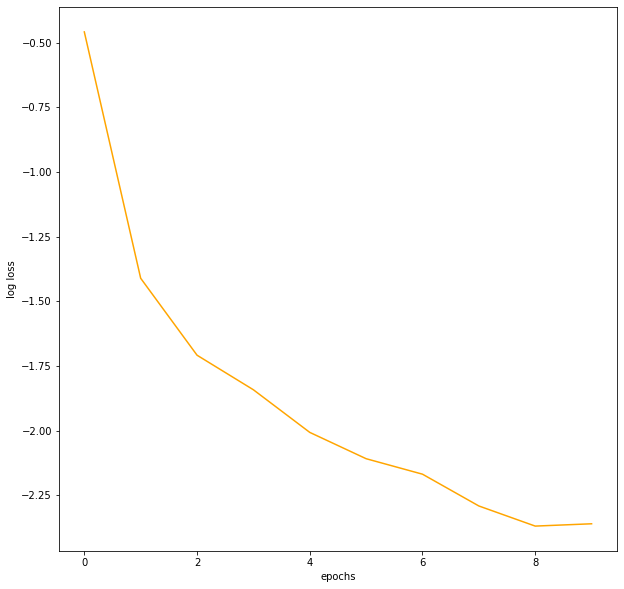

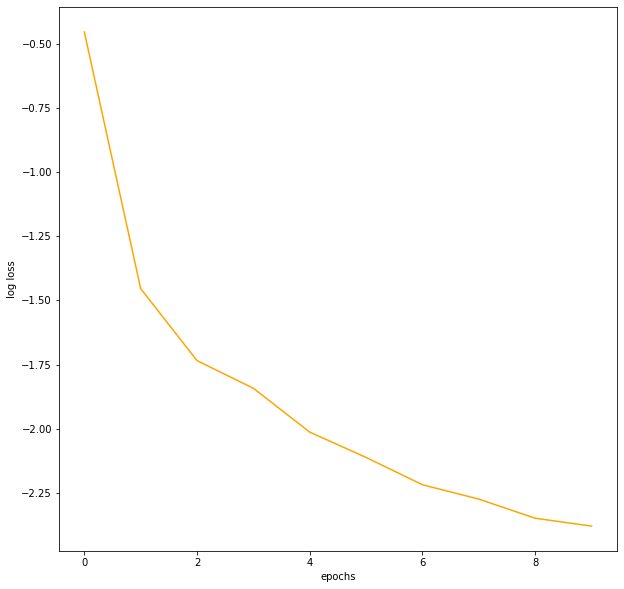

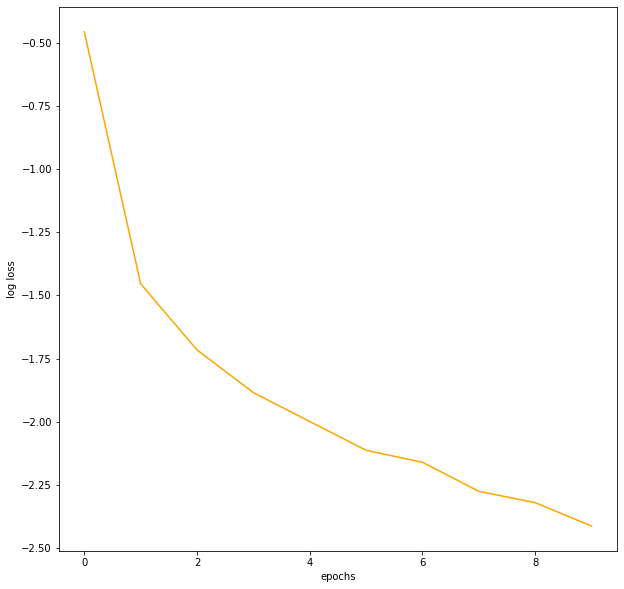

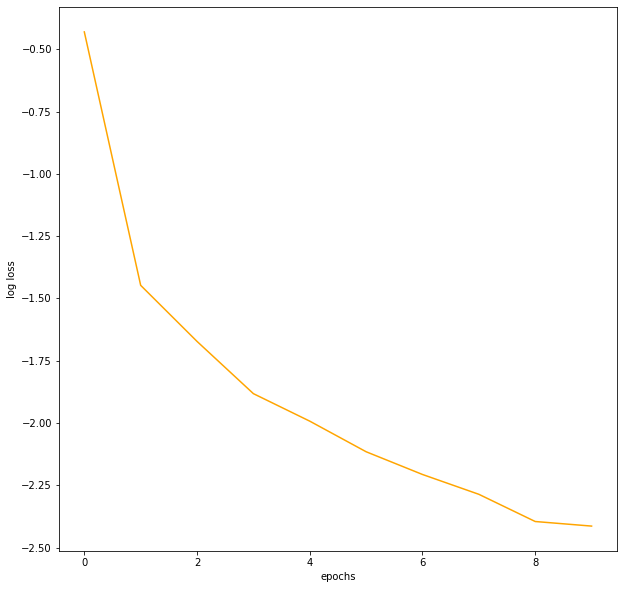

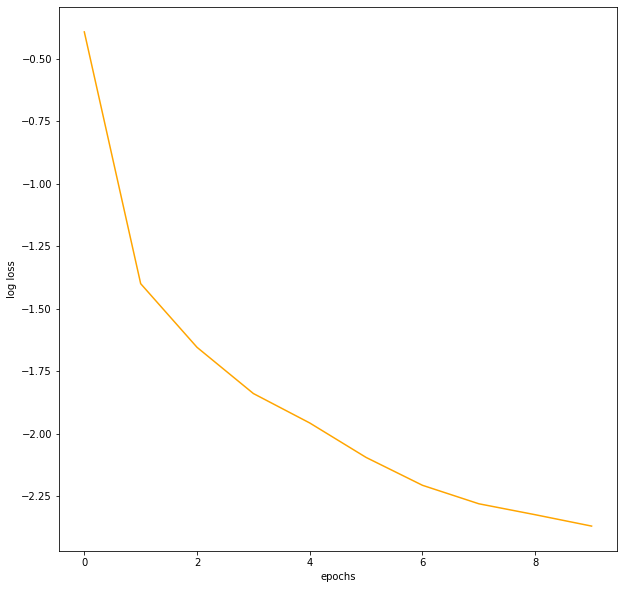

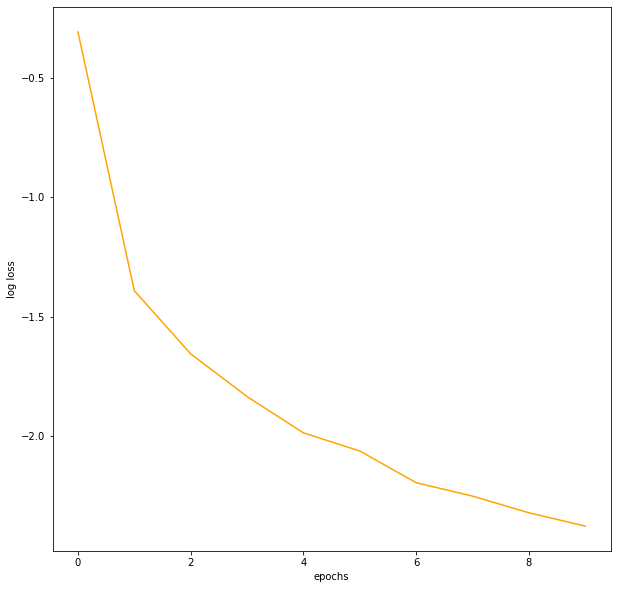

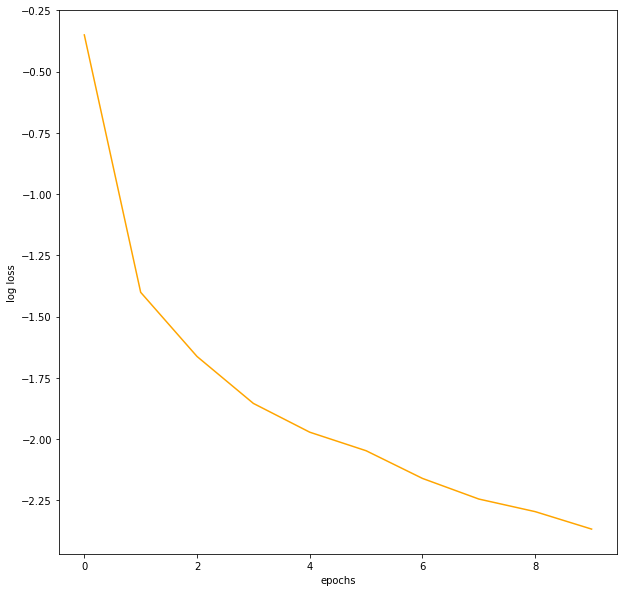

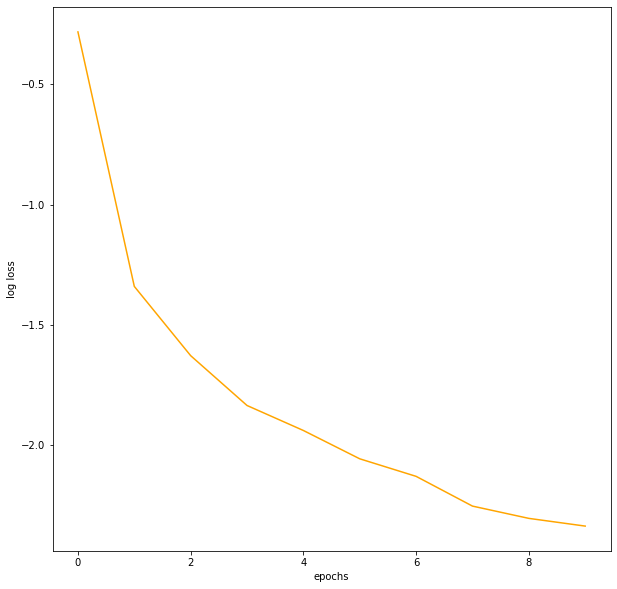

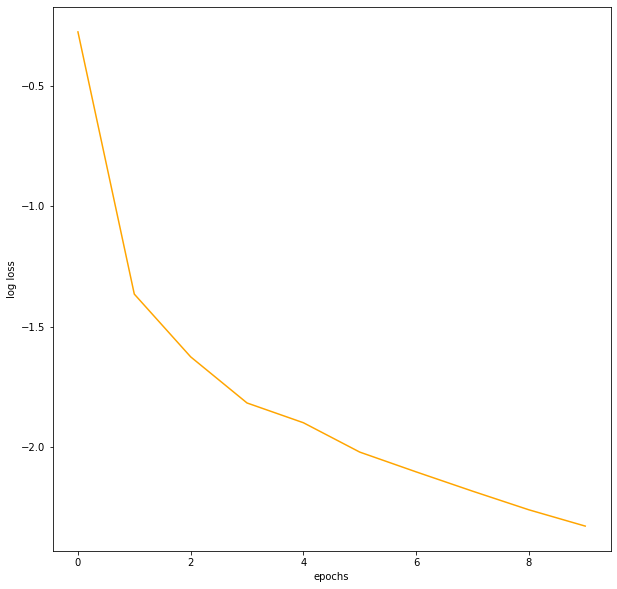

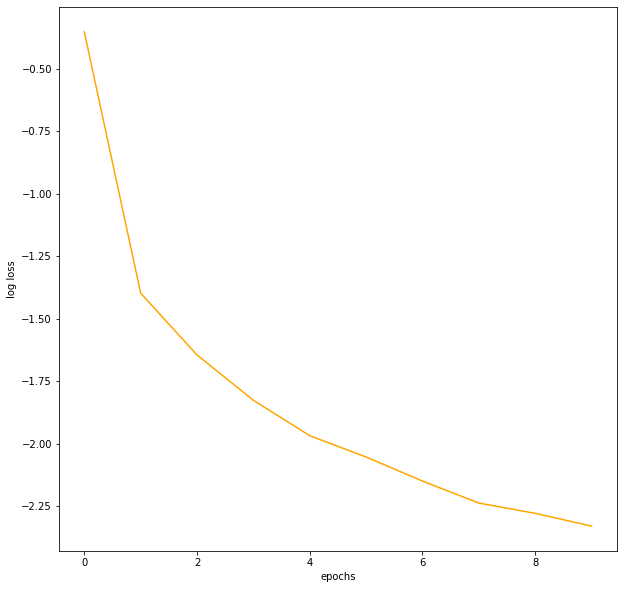

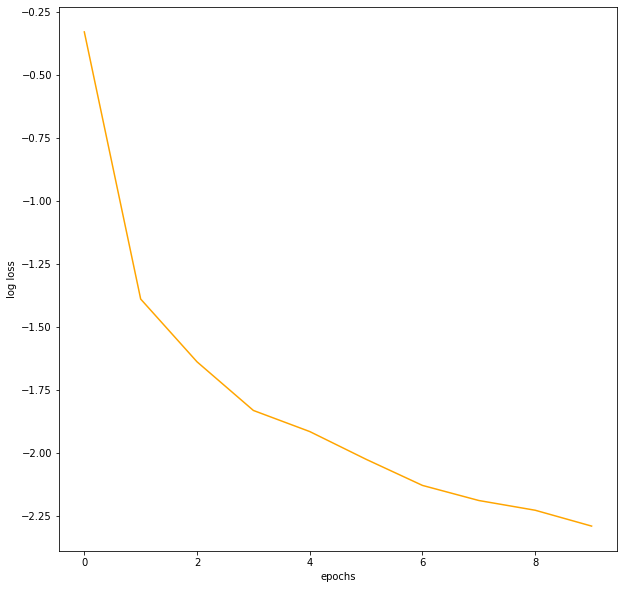

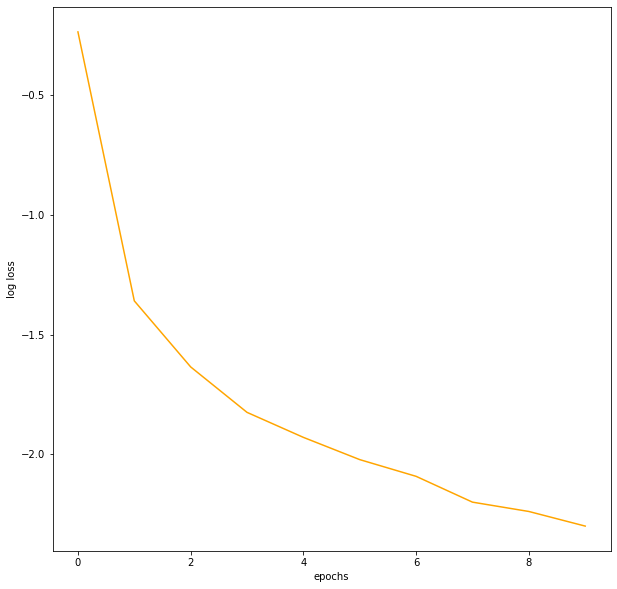

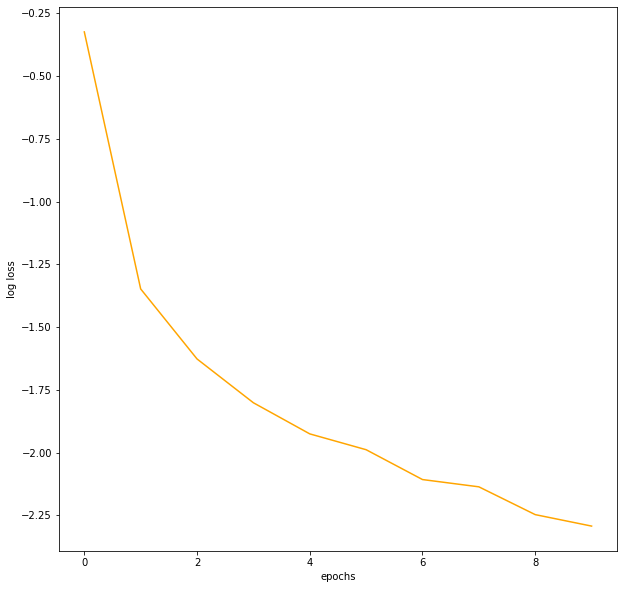

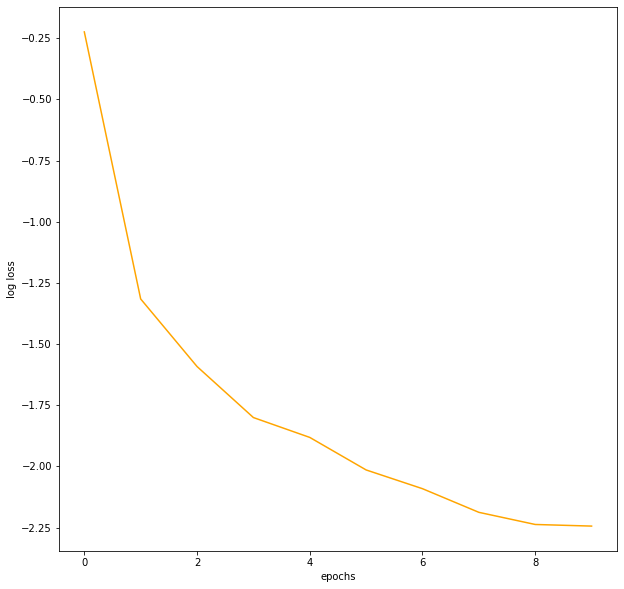

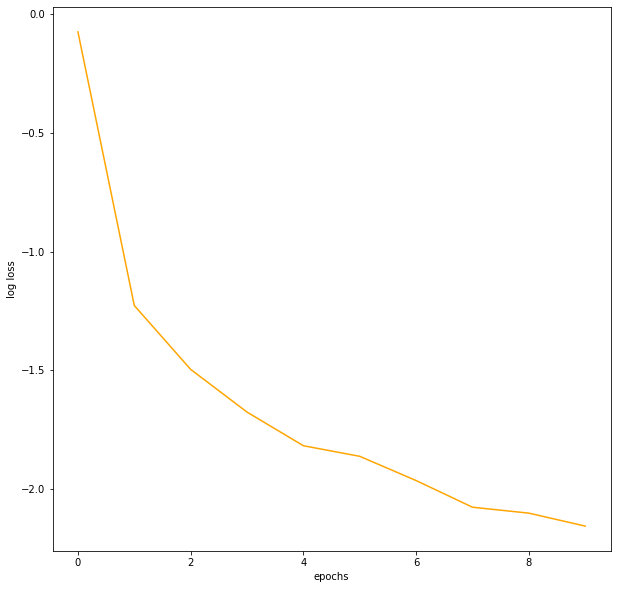

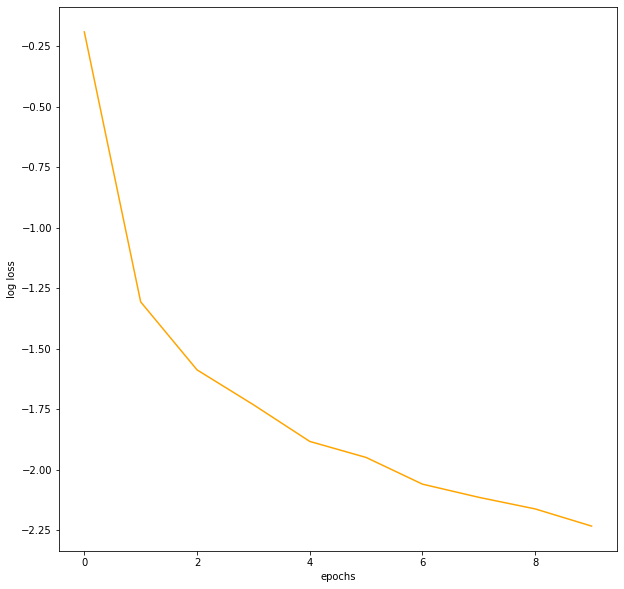

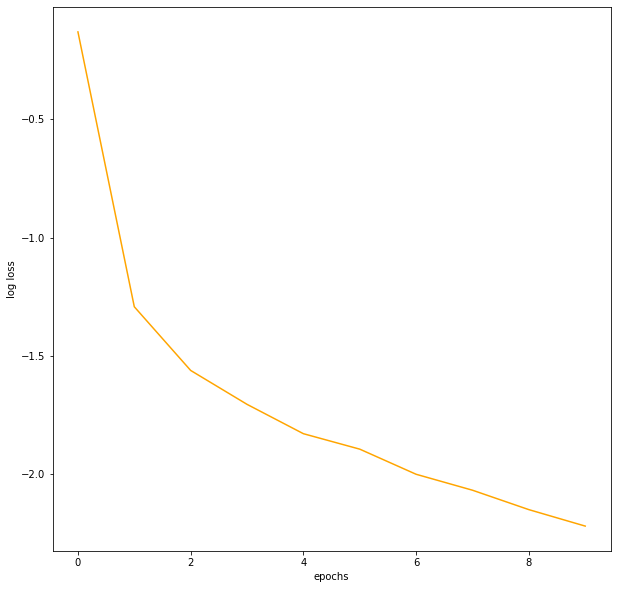

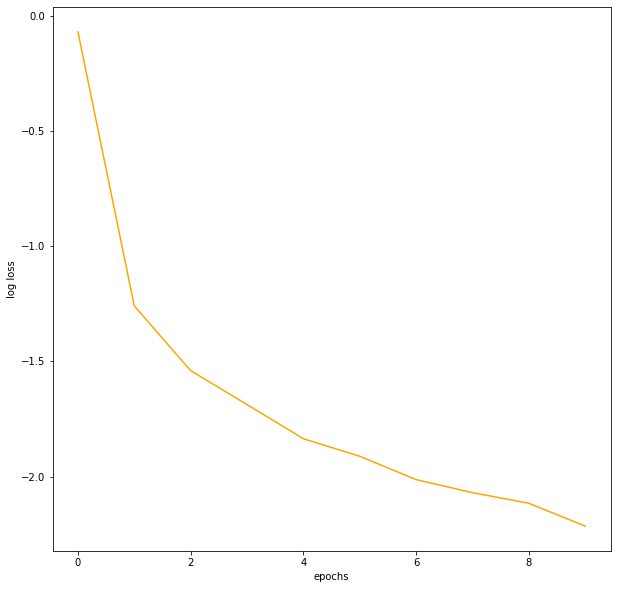

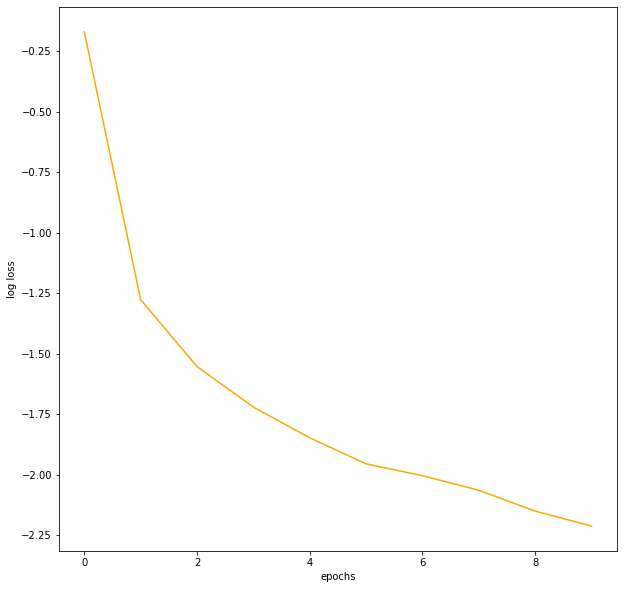

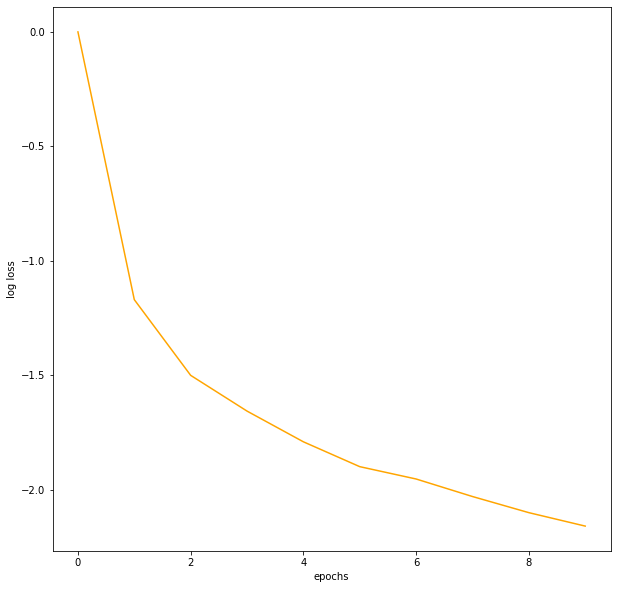

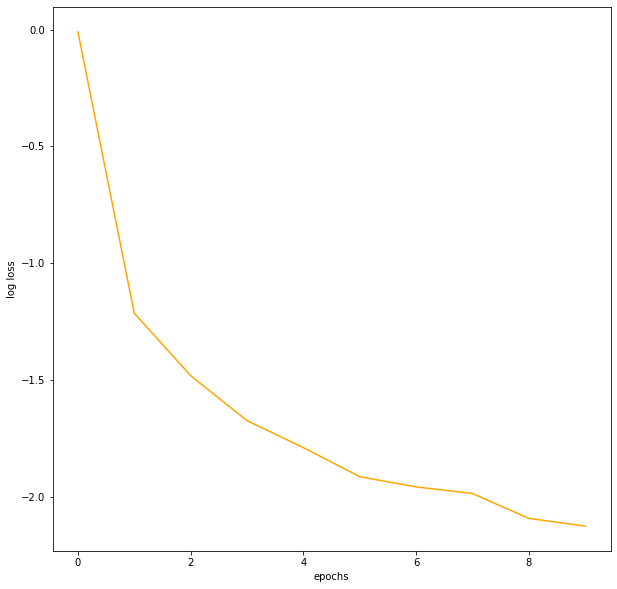

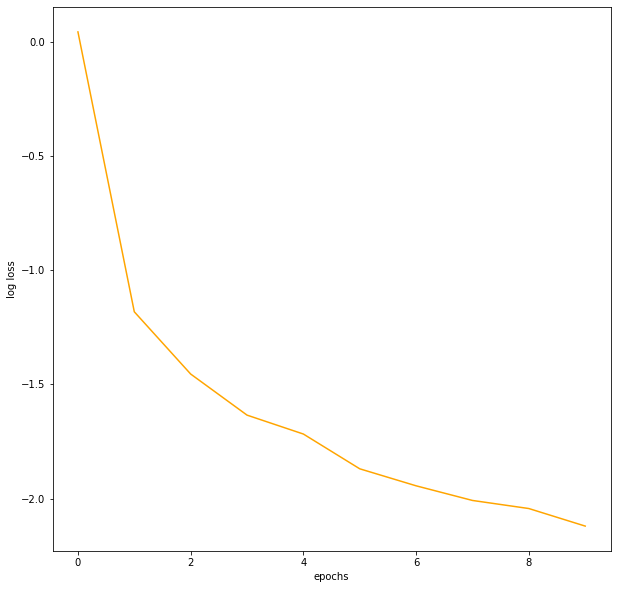

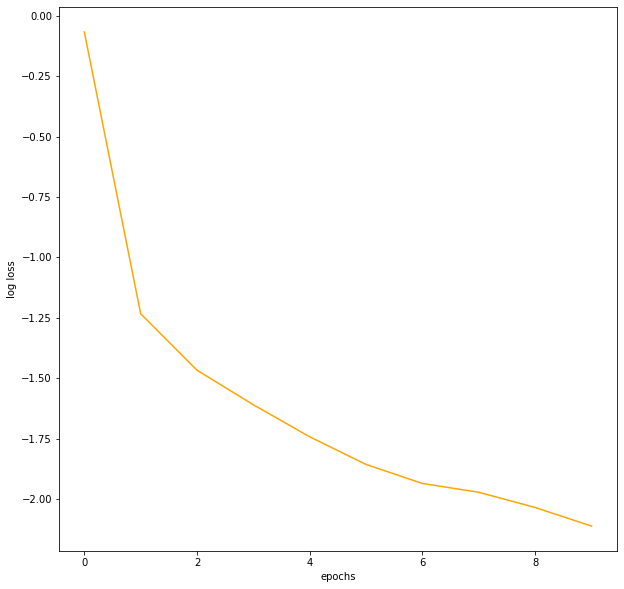

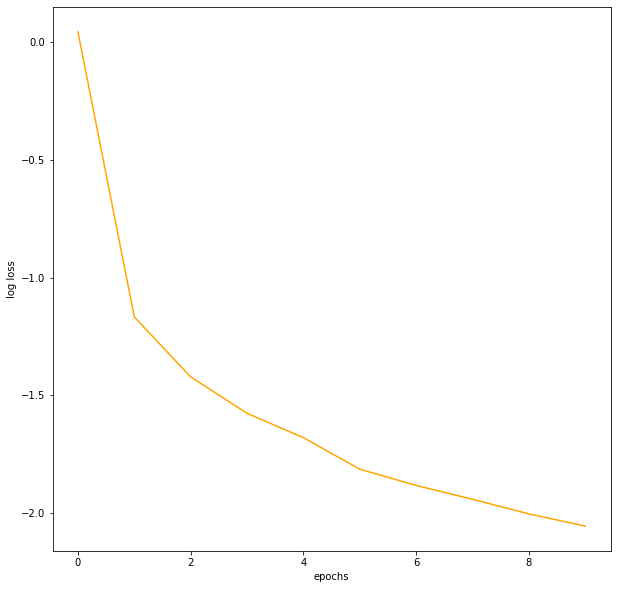

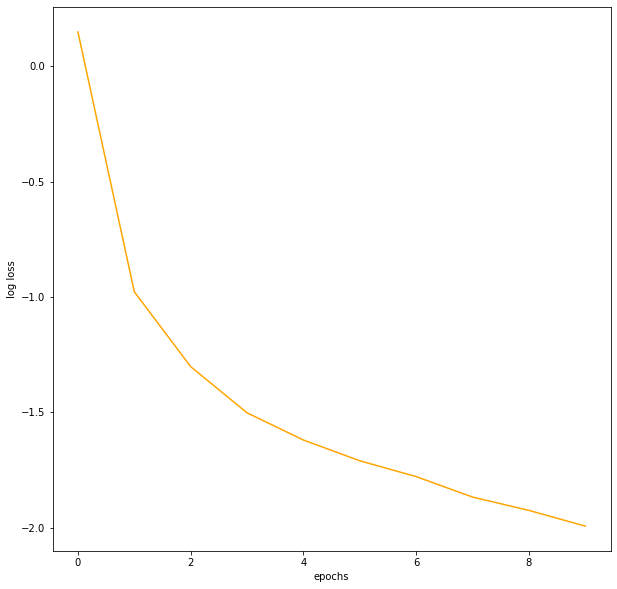

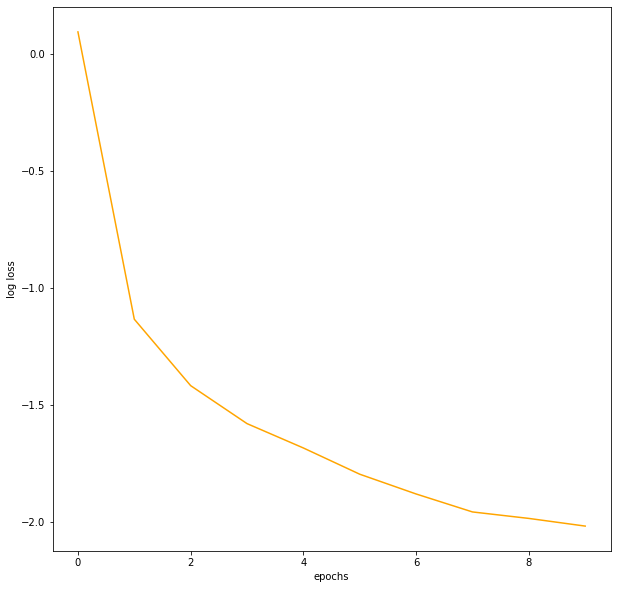

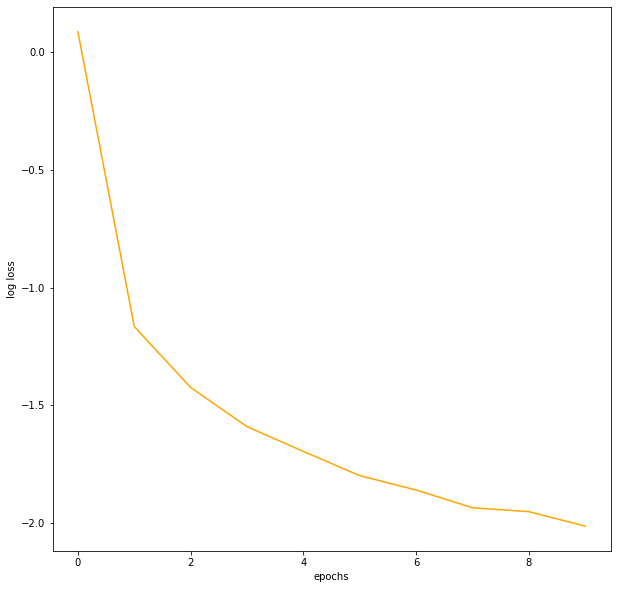

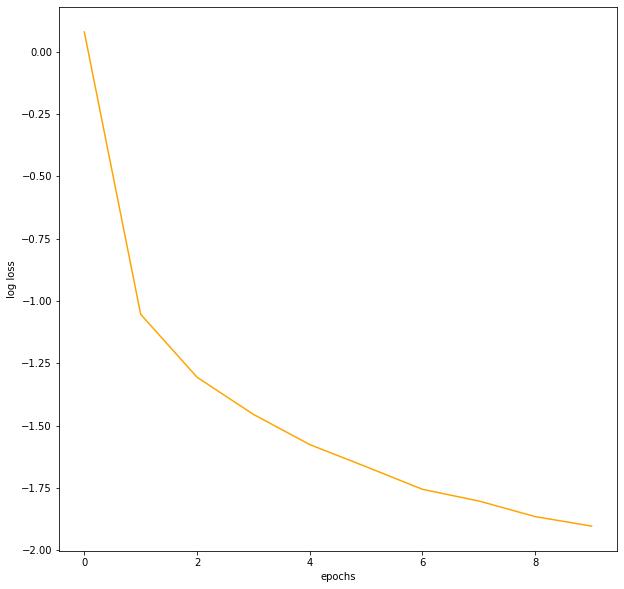

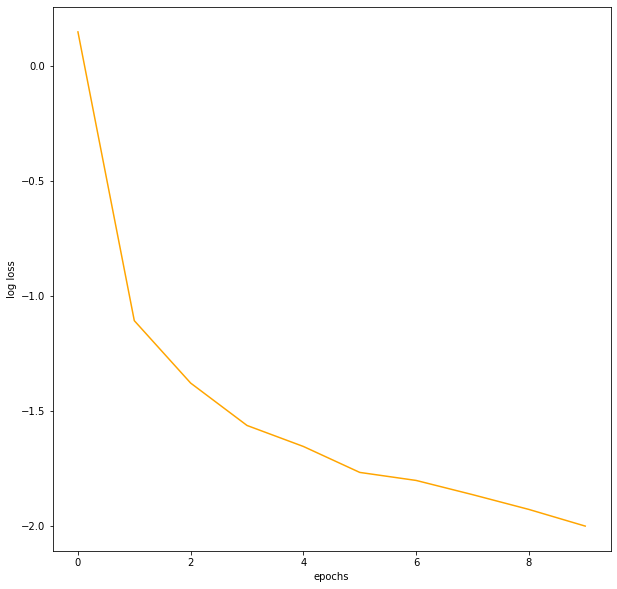

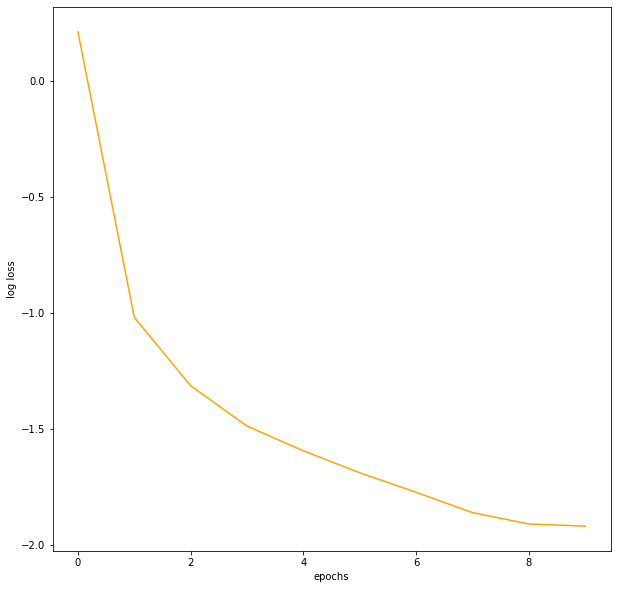

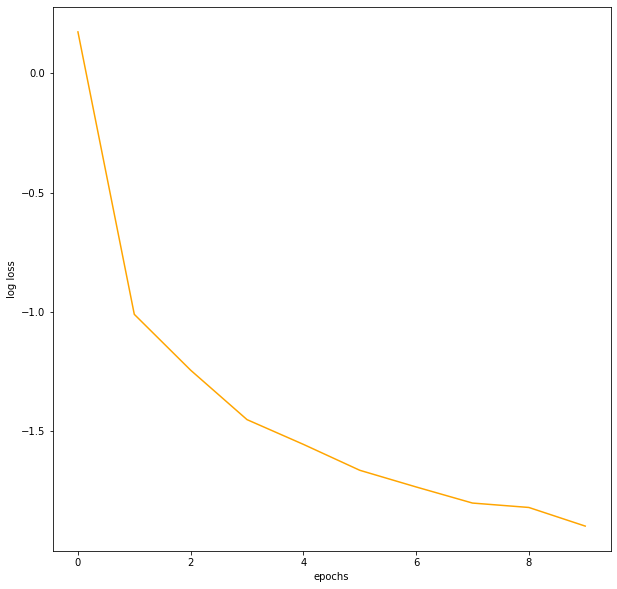

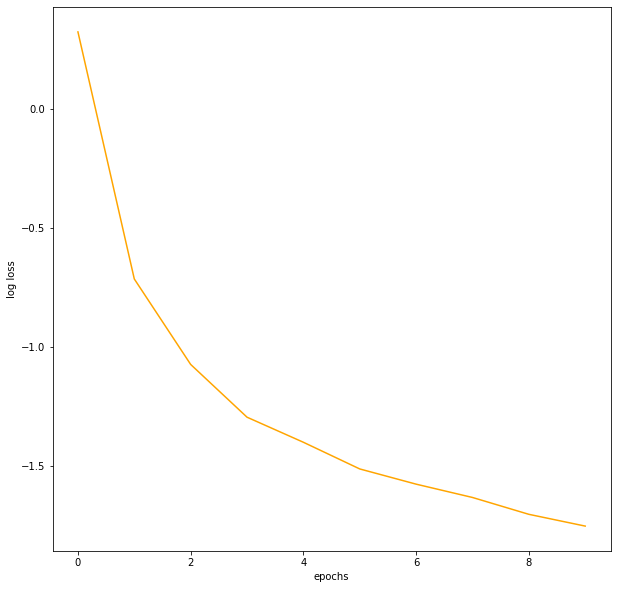

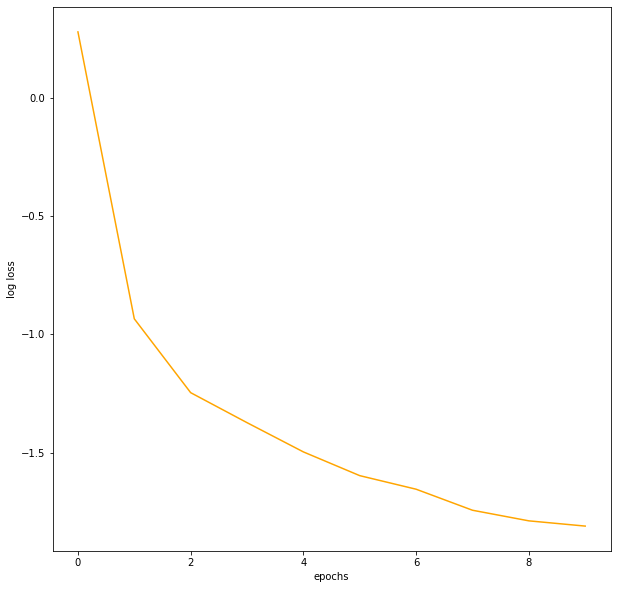

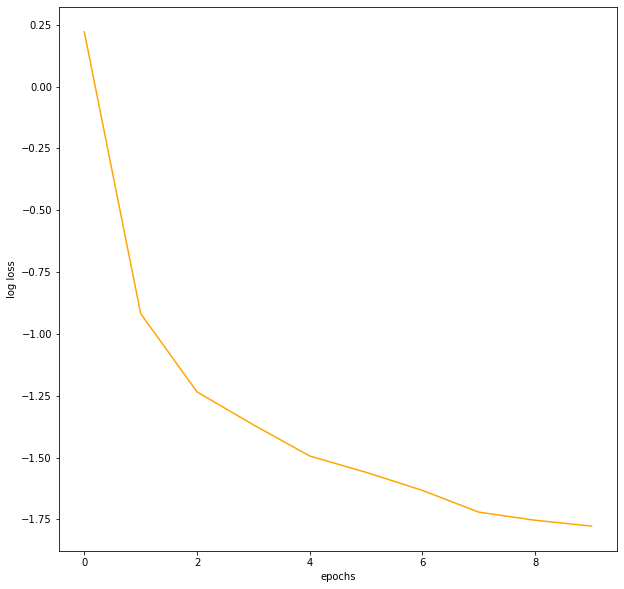

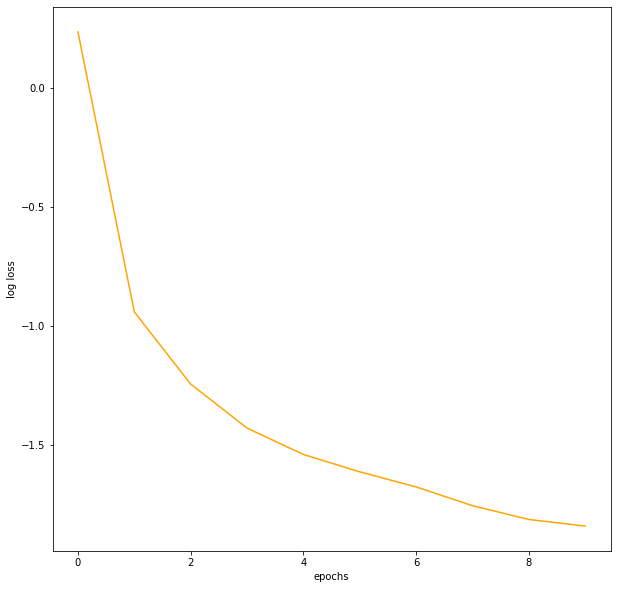

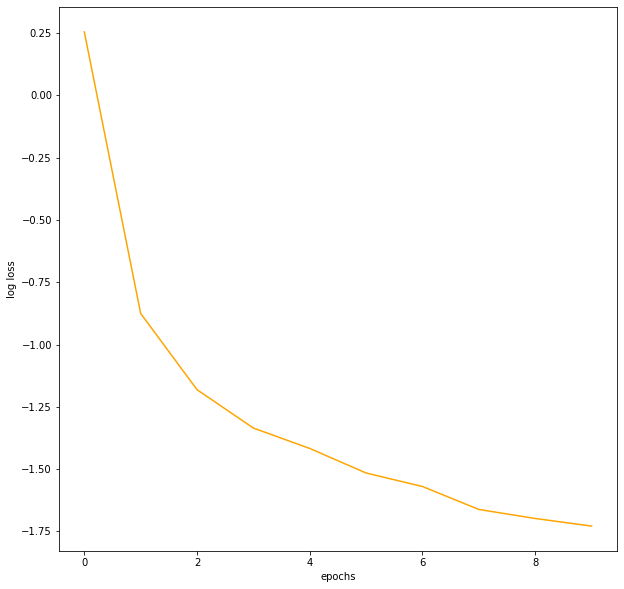

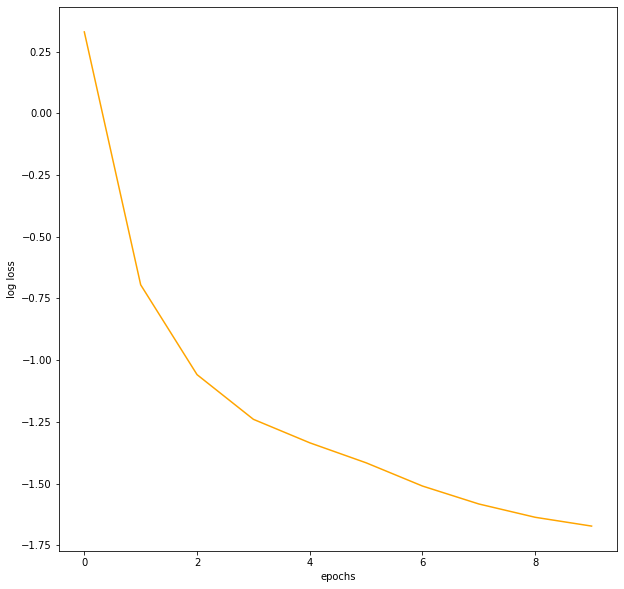

In [15]:
ps = torch.linspace(0.05,0.5,50)
lossesp=[]
for p in tqdm(ps):
    modelp = Model(28*28, 400, 10,5, [1,1,1,1,1],p,True)
    modelp.train(train_dl,epochs = 10, learning_rate=optimal_lr.item(),lam=optimal_lam)
    lossp = modelp.test(test_dl)
    lossesp.append(lossp)

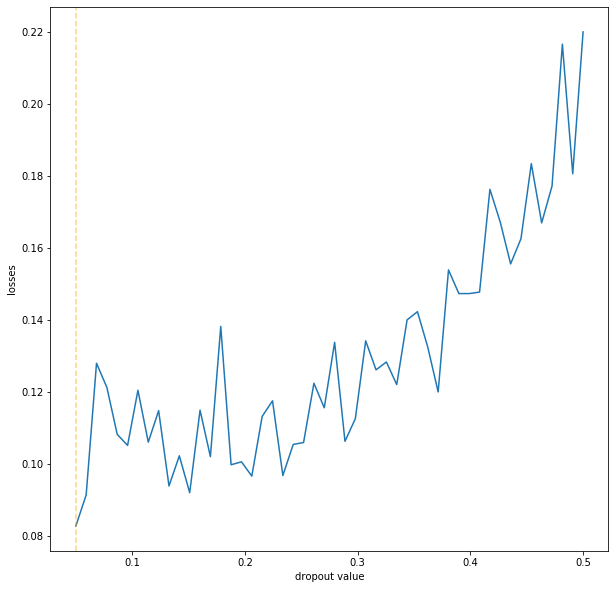

In [16]:
optimal_p = ps[lossesp.index(min(lossesp))]
plt.figure(figsize=(10,10))
plt.plot(ps,lossesp)
plt.xlabel('dropout value')
plt.ylabel('losses')
plt.axvline(x=optimal_p,color='orange',linestyle='--',alpha=0.5)

In [17]:
print(f'optimal dropour value: \n{optimal_p.item():.7f}')
print(f'least testing loss: {min(lossesp):.4f}')

optimal dropour value: 
0.0500000
least testing loss: 0.0828


#### Observation:
The model showed best test performance at 5% dropout rate. the model only looses 5% of the neurons at a time making it eligible to learn better at the same time giving appropriate regularising effect. The graph of dropout values vs losses shows that as the dropout value increases the model is unable to learn properly as its neurons are decreasing resulting in lesser learning capabilities.

#### 5. Shallow network without regularisation

epoch: 0 loss: 0.44983014464378357
epoch: 1 loss: 0.22382262349128723
epoch: 2 loss: 0.16038790345191956
epoch: 3 loss: 0.12443561106920242
epoch: 4 loss: 0.101738341152668
epoch: 5 loss: 0.08848237991333008
epoch: 6 loss: 0.07630003243684769
epoch: 7 loss: 0.07081775367259979
epoch: 8 loss: 0.06292136758565903
epoch: 9 loss: 0.05721672624349594
epoch: 10 loss: 0.050712522119283676
epoch: 11 loss: 0.046888381242752075
epoch: 12 loss: 0.04249386489391327
epoch: 13 loss: 0.04111027345061302
epoch: 14 loss: 0.03604990988969803
epoch: 15 loss: 0.034936610609292984
epoch: 16 loss: 0.031143812462687492
epoch: 17 loss: 0.03332260623574257
epoch: 18 loss: 0.026641642674803734
epoch: 19 loss: 0.022871891036629677
epoch: 20 loss: 0.026265498250722885
epoch: 21 loss: 0.023027323186397552
epoch: 22 loss: 0.022903045639395714
epoch: 23 loss: 0.019292538985610008
epoch: 24 loss: 0.018913503736257553
epoch: 25 loss: 0.021395837888121605
epoch: 26 loss: 0.01930317096412182
epoch: 27 loss: 0.0153348529

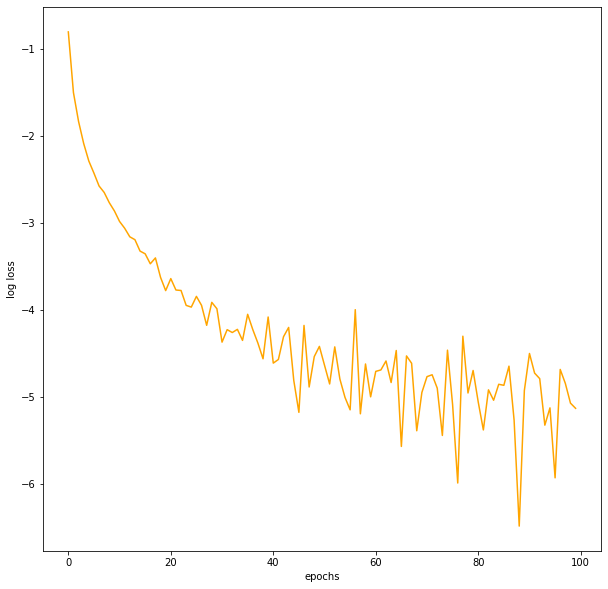

In [18]:
#shallow non regularised
model1 = Model(28*28, 400, 10,1, [0,0,0,0,0],0,False)
model1.to(device)
model1.train(train_dl,epochs = 100, learning_rate=optimal_lr,lam=optimal_lam)
print("Loss on test:")
model1.test(test_dl)
print("Training accuracy:")
get_accuracy(mnist_train,model1)
print("Test accuracy:")
get_accuracy(mnist_test,model1)
print("Training f1 score:")
get_f1(mnist_train,model1)
print("Test f1 score:")
get_f1(mnist_test,model1)

#### 6. Shallow network with regularisation

epoch: 0 loss: 0.46249741315841675
epoch: 1 loss: 0.22200949490070343
epoch: 2 loss: 0.160544753074646
epoch: 3 loss: 0.12940219044685364
epoch: 4 loss: 0.10963296890258789
epoch: 5 loss: 0.09537824243307114
epoch: 6 loss: 0.08303361386060715
epoch: 7 loss: 0.07746551185846329
epoch: 8 loss: 0.06956326216459274
epoch: 9 loss: 0.06465093791484833
epoch: 10 loss: 0.06066169589757919
epoch: 11 loss: 0.05483335629105568
epoch: 12 loss: 0.050997767597436905
epoch: 13 loss: 0.04919751361012459
epoch: 14 loss: 0.04479098692536354
epoch: 15 loss: 0.04461450129747391
epoch: 16 loss: 0.03935137018561363
epoch: 17 loss: 0.03969255089759827
epoch: 18 loss: 0.038822565227746964
epoch: 19 loss: 0.03733434900641441
epoch: 20 loss: 0.031177964061498642
epoch: 21 loss: 0.03128955513238907
epoch: 22 loss: 0.03324977681040764
epoch: 23 loss: 0.033285435289144516
epoch: 24 loss: 0.029299845919013023
epoch: 25 loss: 0.02685527130961418
epoch: 26 loss: 0.02740202285349369
epoch: 27 loss: 0.02666897512972355

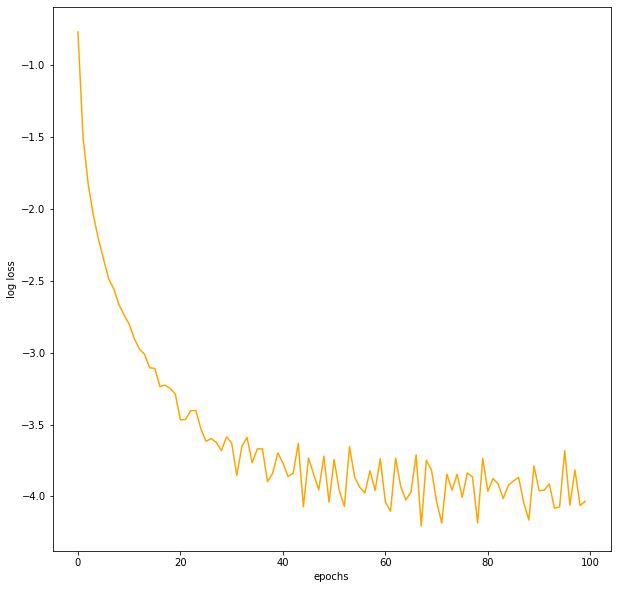

In [19]:
model2 = Model(28*28, 400, 10,1, [1,1,1,1,1],optimal_p,True)
model2.to(device)
model2.train(train_dl,epochs = 100, learning_rate=optimal_lr,lam=optimal_lam)
print("Loss on test:")
model2.test(test_dl)
print("Training accuracy:")
get_accuracy(mnist_train,model2)
print("Test accuracy:")
get_accuracy(mnist_test,model2)
print("Training f1 score:")
get_f1(mnist_train,model2)
print("Test f1 score:")
get_f1(mnist_test,model2)

#### Performance Table
| Model | Training Accuracy(A) | Test Accuracy(B) | Difference(A-B) |Test loss | training F1 scores | Testing F1 scores|
|----------|:-------------:|------:|------:|------:|------:|------:|
| model1(w/o regularization) | 99.86%  | 98.01% | 1.85% |0.148 |0.998|0.980|
| model2(with regularization) |    99.83%  | 98.37%| 1.46% | 0.109 |0.998|0.983|

From the performance obtained on the training set and the testing set we see that model2 that is the shallow model with regularization acheive better performance on the testing data showing better capabilities in generalising to unseen data.

#### Discussion:
It was observed that the model achieved very high rate of Training accuracy in both the model. This can be due to the very small learning rate(obtained with above experiment) which led to the minima value as obtained here. (training with larger values of learning rate was also done(not shown here in the notebook) which shows the model showing worse performance then obtained here. It also concluding that the overall accuracy obtained depended a lot on the learning rate). 

#### Changes in training set up:
We are training the deeper networks for more number of <b>epochs</b> as the number of parameters are significantly high so convergence of such model might take some extra time.

#### 7. Deep network without regularisation

epoch: 0 loss: 0.5850531458854675
epoch: 1 loss: 0.21763411164283752
epoch: 2 loss: 0.16053655743598938
epoch: 3 loss: 0.1336071938276291
epoch: 4 loss: 0.11154887825250626
epoch: 5 loss: 0.10099507123231888
epoch: 6 loss: 0.08965437859296799
epoch: 7 loss: 0.08019334077835083
epoch: 8 loss: 0.07533732801675797
epoch: 9 loss: 0.06952293962240219
epoch: 10 loss: 0.06313034147024155
epoch: 11 loss: 0.05771582946181297
epoch: 12 loss: 0.05846654996275902
epoch: 13 loss: 0.05147048830986023
epoch: 14 loss: 0.049420904368162155
epoch: 15 loss: 0.04690469428896904
epoch: 16 loss: 0.04292931407690048
epoch: 17 loss: 0.0400925874710083
epoch: 18 loss: 0.03795831650495529
epoch: 19 loss: 0.038369227200746536
epoch: 20 loss: 0.03401275724172592
epoch: 21 loss: 0.03454279899597168
epoch: 22 loss: 0.0289666298776865
epoch: 23 loss: 0.03090464137494564
epoch: 24 loss: 0.029367586597800255
epoch: 25 loss: 0.028292017057538033
epoch: 26 loss: 0.028086483478546143
epoch: 27 loss: 0.025748686864972115


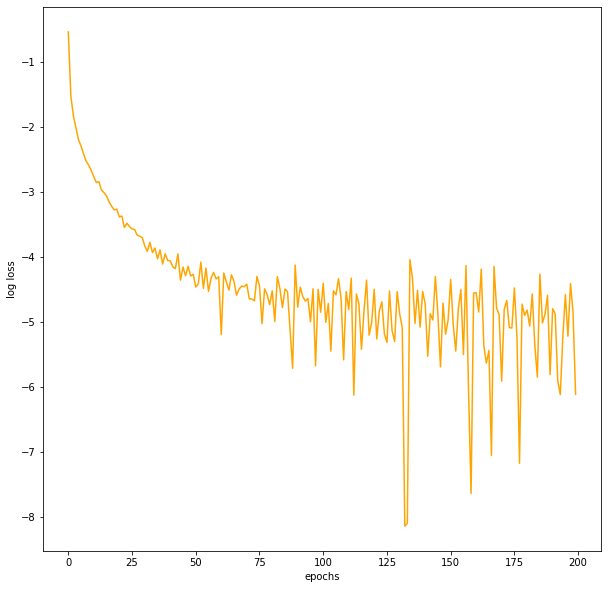

In [22]:
model3 = Model(28*28, 400, 10,5, [0,0,0,0,0],0,False)
model3.to(device)
model3.train(train_dl,epochs = 200, learning_rate=optimal_lr,lam=optimal_lam)
print("Loss on test:")
model3.test(test_dl)
print("Training accuracy:")
get_accuracy(mnist_train,model3)
print("Test accuracy:")
get_accuracy(mnist_test,model3)
print("Training f1 score:")
get_f1(mnist_train,model3)
print("Test f1 score:")
get_f1(mnist_test,model3)

#### 8. Deep network with regularisation

epoch: 0 loss: 0.6040361523628235
epoch: 1 loss: 0.22446034848690033
epoch: 2 loss: 0.1692025512456894
epoch: 3 loss: 0.14208932220935822
epoch: 4 loss: 0.1233845129609108
epoch: 5 loss: 0.10934983938932419
epoch: 6 loss: 0.10355739295482635
epoch: 7 loss: 0.09343785047531128
epoch: 8 loss: 0.08458441495895386
epoch: 9 loss: 0.07853761315345764
epoch: 10 loss: 0.07602494955062866
epoch: 11 loss: 0.06639425456523895
epoch: 12 loss: 0.06623437255620956
epoch: 13 loss: 0.0636088103055954
epoch: 14 loss: 0.06360166519880295
epoch: 15 loss: 0.05608829855918884
epoch: 16 loss: 0.05492869392037392
epoch: 17 loss: 0.05035565420985222
epoch: 18 loss: 0.05128087103366852
epoch: 19 loss: 0.04786207154393196
epoch: 20 loss: 0.04963235557079315
epoch: 21 loss: 0.04293713718652725
epoch: 22 loss: 0.04434174299240112
epoch: 23 loss: 0.04202009364962578
epoch: 24 loss: 0.04205984249711037
epoch: 25 loss: 0.04016991704702377
epoch: 26 loss: 0.039611347019672394
epoch: 27 loss: 0.03694319725036621
epoch

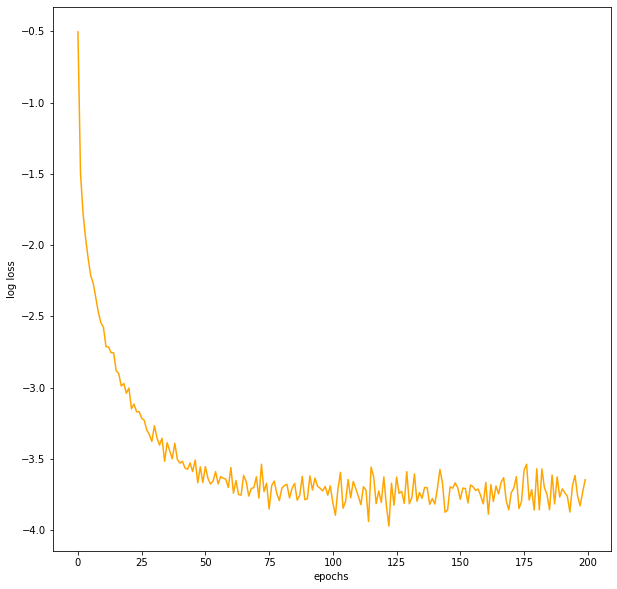

In [37]:
model4 = Model(28*28, 400, 10,5, [1,1,1,1,1],optimal_p,True)
model4.to(device)
model4.train(train_dl,epochs = 200, learning_rate=optimal_lr,lam=optimal_lam)
print("Loss on test:")
model4.test(test_dl)
print("Training accuracy:")
get_accuracy(mnist_train,model4)
print("Test accuracy:")
get_accuracy(mnist_test,model4)
print("Training f1 score:")
get_f1(mnist_train,model4)
print("Test f1 score:")
get_f1(mnist_test,model4)

#### Performance Table
| Model | Training Accuracy(A) | Test Accuracy(B) | Difference(A-B) |Test loss | training F1 scores | Testing F1 scores|
|----------|:-------------:|------:|------:|------:|------:|------:|
| model3(w/o regularization) | 99.99%  | 98.42% | 1.57% |0.152 |0.999|0.984|
| model4(with regularization) |    99.82%  | 98.00%| 1.82% | 0.1642 |0.9979|0.9803|


The performance observed in the unregularised version of the deep model is suprisingly better than the regularised one in case of testing accuracy and also testing loss. Although the training accuracy is very high but the difference between the training and the testing accuracy shows that the model is overfitting in this case.

#### DISCUSSION:

from the four models trained the shallow model with regularisations shows the best generalisability with optimal performance as its training accuracy and testing accuracy has the least amount of difference.

### 7.5.3 Get the best model! (1 + 1 point (bonus))

* Present your model during a tutorial session. Justify your decisions when designing your model/solution.
* If you achieve one of the top N results, you get yet another extra point!